cDCGAN for album
condition vae of spectrogram 30s

In [1]:
import os, time, itertools, pickle, random, glob, imageio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
def viz_grid(Xs, padding):
    N, H, W, C = Xs.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size + 1)
    grid_width = W * grid_size + padding * (grid_size + 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = padding, H + padding
    for y in range(grid_size):
        x0, x1 = padding, W + padding
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_random_seed(seed)

def conv2d(input, kernel_size, stride, num_filter, name = 'conv2d'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d(input, W, stride_shape, padding = 'SAME') + b

def conv2d_transpose(input, kernel_size, stride, num_filter, name = 'conv2d_transpose'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
        output_shape = tf.stack([tf.shape(input)[0], tf.shape(input)[1] * 2, tf.shape(input)[2] * 2, num_filter])

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d_transpose(input, W, output_shape, stride_shape, padding = 'SAME') + b

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def batch_norm(input, is_training):
    out = tf.contrib.layers.batch_norm(input, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def leaky_relu(input, alpha = 0.2):
    return tf.maximum(alpha * input, input)

In [3]:
def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():
    X = []
    Y = []
    for i in range(5):
        X_, Y_ = unpickle('data/cifar-10-batches-py/data_batch_%d' % (i + 1))
        X.append(X_)
        Y.extend(Y_)
    X = np.concatenate(X)
    X = X.reshape((X.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)
    return X, Y

def load_test_data():
    X_, Y = unpickle('data/cifar-10-batches-py/test_batch')
    X = X_.reshape((X_.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)
    return X, Y

def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

def dataset_load_album(datapath, labelpath, imgsize):
    """
    datapath 'jpeg' file of album image
    labelpath 'png' file of spectrogram 
    """
    datalist = os.listdir(datapath)
    datasize = len(datalist)
    
    data_ = np.zeros((datasize, imgsize, imgsize, 3))
    label_ = np.zeros((datasize, imgsize, imgsize, 3))
    nonelist = []
    for i, fname in enumerate(datalist):
        if glob.glob(os.path.join(labelpath, fname[:-4] + '*')):
        #f os.path.isfile(os.path.join(labelpath, fname[:-4] + 'png')):
            #print('there is file')
            img_d = Image.open(os.path.join(datapath, fname)
                              ).resize((imgsize, imgsize))
            img_l = Image.open(os.path.join(labelpath, fname[:-4]+'png')
                              ).convert('RGB').resize((imgsize, imgsize))
            data_[i] = np.asarray(img_d)
            label_[i] = np.asarray(img_l)
            
        else:
            nonelist.append(i)
            
    data = np.delete(data_, nonelist, 0)
    label = np.delete(label_, nonelist, 0)
    return data, label

def dataset_split(data, fold):
    size = data.shape[0]
    id_all = np.random.choice(size, size, replace=False)
    split = size//fold
    return data[split:], data[:split]
    
    

# Load albumdata
samples = np.load('vae/x_samples_64.npy')
labels = np.load('vae/z64_tras_ep1000_noinvers.npy')


train_samples, test_samples = dataset_split(samples, 20)
train_labels, test_labels = dataset_split(labels, 20)

In [7]:
labels.shape

(20600, 64)

In [21]:
class DCGAN(object):

    def __init__(self):
        self.num_epoch = 1000
        self.batch_size = 32 #32 => 64
        self.log_step = 500 # 50 => 500
        self.visualize_step = 200
        self.code_size = 64
        self.learning_rate = 1e-4
        self.vis_learning_rate = 1e-2
        self.recon_steps = 100
        self.actmax_steps = 100
        self.img_size = 64
        
        self._dis_called = False
        self._gen_called = False

        self.tracked_noise = np.random.normal(0, 1, [64, self.code_size])
        self.tracked_label = np.delete(np.transpose(np.tile(np.eye(10), 7)), np.s_[-6:], 0)

        self.real_input = tf.placeholder(tf.float32,
                                         [None, self.img_size, self.img_size, 3])
        self.real_label = tf.placeholder(tf.float32, [None, 1])
        self.fake_label = tf.placeholder(tf.float32, [None, 1])
        self.condition_label = tf.placeholder(tf.float32, [None, self.code_size])
        self.noise = tf.placeholder(tf.float32, [None, self.code_size])
        
        self.is_train = tf.placeholder(tf.bool)
        
        self.recon_sample = tf.placeholder(tf.float32, [1, self.img_size, self.img_size, 3])
        self.actmax_label = tf.placeholder(tf.float32, [1, 1])
        
        with tf.variable_scope('actmax'):
            self.actmax_code = tf.get_variable('actmax_code', [1, self.code_size],
                                               initializer = tf.constant_initializer(0.0))
        
        self._init_ops()

    def _discriminator(self, input, y_fill):
        # We have multiple instances of the discriminator in the same computation graph,
        # so set variable sharing if this is not the first invocation of this function.
        
        # input:(?, self.img_size=64, self.img_size=64, 3)
        # y_fill: (?, 64) vae label 
        
        
        with tf.variable_scope('dis', reuse = self._dis_called):
            self._dis_called = True
            
            #print('dis', dis_cat.get_shape())
            
            dis_conv1 = conv2d(input, 4, 2, 32, 'conv1') # => (?, 32, 32, 32)
            dis_lrelu1 = leaky_relu(dis_conv1)
            dis_conv2 = conv2d(dis_lrelu1, 4, 2, 64, 'conv2') # => (?, 16, 16, 64)
            dis_batchnorm2 = batch_norm(dis_conv2, self.is_train)
            dis_lrelu2 = leaky_relu(dis_batchnorm2)
            dis_conv3 = conv2d(dis_lrelu2, 4, 2, 128, 'conv3') # => (?, 8, 8, 128)
            dis_batchnorm3 = batch_norm(dis_conv3, self.is_train)
            dis_lrelu3 = leaky_relu(dis_batchnorm3)
            dis_reshape3 = tf.reshape(dis_lrelu3, [-1, 8 * 8 * 128])
            dis_fc4 = fc(dis_reshape3, self.code_size, 'fc4')
            dis_cat = tf.concat([dis_fc4, y_fill], 1)
            dis_fc5 = fc(dis_cat , 1, 'fc5')
            return dis_fc5

    def _generator(self, input, y_fill):
        # input (?, self.code_size=64)
        # c_label (?, 32, 32, 3)

        with tf.variable_scope('gen', reuse = self._gen_called):
            self._gen_called = True
            
            gen_cat = tf.concat([input, y_fill], 1)
            #print('gen', gen_cat.get_shape())
            
            gen_fc1 = fc(gen_cat, 8 * 8 * 128, 'fc1')
            gen_reshape1 = tf.reshape(gen_fc1, [-1, 8, 8, 128])  # => (?, 8, 8, 128)
            gen_batchnorm1 = batch_norm(gen_reshape1, self.is_train)
            gen_lrelu1 = leaky_relu(gen_batchnorm1)
            gen_conv2 = conv2d_transpose(gen_lrelu1, 4, 2, 64, 'conv2') # => (?, 16, 16, 64)
            gen_batchnorm2 = batch_norm(gen_conv2, self.is_train)
            gen_lrelu2 = leaky_relu(gen_batchnorm2)
            gen_conv3 = conv2d_transpose(gen_lrelu2, 4, 2, 32, 'conv3') # => (?, 32, 32, 32)
            gen_batchnorm3 = batch_norm(gen_conv3, self.is_train)
            gen_lrelu3 = leaky_relu(gen_batchnorm3)
            gen_conv4 = conv2d_transpose(gen_lrelu3, 4, 2, 3, 'conv4') # => (?, 64, 64, 3)
            gen_sigmoid4 = tf.sigmoid(gen_conv4)
            return gen_sigmoid4
        
        
    def _loss(self, labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)

    def _reconstruction_loss(self, generated, target):
        loss = tf.nn.l2_loss(generated - target)
        return tf.reduce_mean(loss)

    def _loss(self, labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)

    def _reconstruction_loss(self, generated, target):
        loss = tf.nn.l2_loss(generated - target)
        return tf.reduce_mean(loss)
    
    # Define operations
    def _init_ops(self):
        
        ################################################################################
        # Prob 2-1: complete the definition of these operations                        #
        ################################################################################
        # reshape
        #y_label_ = tf.reshape(self.condition_label, [-1, 1, 1, 10])
        #bsize = tf.shape(self.condition_label)[0]
        #y_fill_ = y_label_ * tf.ones([bsize, self.img_size, self.img_size, 10])
        
        # self.fake_samples_op = None
        self.fake_samples_op = self._generator(self.noise, self.condition_label)
        
        self.dis_loss_op = self._loss(self.real_label, 
                                      self._discriminator(self.real_input, 
                                                          self.condition_label)
                                      ) + self._loss(self.fake_label,
            self._discriminator(self.fake_samples_op, self.condition_label))
        
        # self.gen_loss_op = None
        self.gen_loss_op = self._loss(self.real_label,
                                      self._discriminator(self.fake_samples_op, 
                                                          self.condition_label))
        
        ################################################################################
        # Prob 2-1: fix the definition of these operations                             #
        ################################################################################
        
        # dis_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        # self.dis_train_op = dis_optimizer.minimize(self.dis_loss_op)
        dis_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                     "dis")
        dis_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.dis_train_op = dis_optimizer.minimize(self.dis_loss_op,
                                                   var_list=dis_train_vars)
        
        # gen_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        # self.gen_train_op = gen_optimizer.minimize(self.gen_loss_op)
        gen_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                     "gen")
        gen_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.gen_train_op = gen_optimizer.minimize(self.gen_loss_op,
                                                  var_list=gen_train_vars)
        
        ################################################################################
        # Prob 2-4: check the definition of these operations                           #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        self.actmax_sample_op = self._generator(self.actmax_code, self.condition_label)
        actmax_dis = self._discriminator(self.actmax_sample_op, self.condition_label)
        self.actmax_loss_op = self._loss(self.actmax_label, actmax_dis)

        actmax_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        self.actmax_op = actmax_optimizer.minimize(self.actmax_loss_op, var_list = [self.actmax_code])
        
        ################################################################################
        # Prob 2-4: complete the definition of these operations                        #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        # self.recon_loss_op = None
        self.recon_loss_op = self._reconstruction_loss(self.actmax_sample_op, self.recon_sample)
        
        # recon_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        recon_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        
        # self.reconstruct_op = recon_optimizer.minimize(self.recon_loss_op)
        self.reconstruct_op = recon_optimizer.minimize(self.recon_loss_op)
        
        
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################

    # Training function
    def train(self, sess, train_samples, test_labels):
        sess.run(tf.global_variables_initializer())

        num_train = train_samples.shape[0]
        step = 0
        
        # smooth the loss curve so that it does not fluctuate too much
        smooth_factor = 0.95
        plot_dis_s = 0
        plot_gen_s = 0
        plot_ws = 0
        
        dis_losses = []
        gen_losses = []
        max_steps = int(self.num_epoch * (num_train // self.batch_size))
        print('Start training ...')
        start_time = time.time()
        for epoch in range(self.num_epoch):
            epoch_start_time = time.time()
            for i in range(num_train // self.batch_size):
                step += 1

                batch_samples = train_samples[i * self.batch_size : (i + 1) * self.batch_size]
                batch_labels = train_labels[i * self.batch_size : (i + 1) * self.batch_size]
                #noise = np.random.normal(0, 1, [batch_labels.shape[0], self.code_size])
                noise = np.random.normal(0, 1, [self.batch_size, self.code_size])
                zeros = np.zeros([self.batch_size, 1])
                ones = np.ones([self.batch_size, 1])
        
                ################################################################################
                # Prob 2-1: complete the feed dictionary                                       #
                ################################################################################
                
                # dis_feed_dict = {}
                dis_feed_dict = {self.real_input:batch_samples, self.real_label:zeros,
                                self.fake_label:ones, self.noise:noise, self.is_train:True,
                                self.condition_label:batch_labels}
                
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################
                #print('batch', batch_labels.shape, 'noise', noise.shape)

                _, dis_loss = sess.run([self.dis_train_op, self.dis_loss_op], feed_dict = dis_feed_dict)
        
                ################################################################################
                # Prob 2-1: complete the feed dictionary                                       #
                ################################################################################
                
                # gen_feed_dict = {}
                gen_feed_dict = {self.noise:noise, self.real_label:zeros,
                                 self.fake_label:ones, self.is_train:True,
                                 self.condition_label:batch_labels}
                
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################

                _, gen_loss = sess.run([self.gen_train_op, self.gen_loss_op], feed_dict = gen_feed_dict)

                plot_dis_s = plot_dis_s * smooth_factor + dis_loss * (1 - smooth_factor)
                plot_gen_s = plot_gen_s * smooth_factor + gen_loss * (1 - smooth_factor)
                plot_ws = plot_ws * smooth_factor + (1 - smooth_factor)
                dis_losses.append(plot_dis_s / plot_ws)
                gen_losses.append(plot_gen_s / plot_ws)

                if step % self.log_step == 0:
                    print('Iteration {0}/{1}: dis loss = {2:.4f}, gen loss = {3:.4f}'.format(step, max_steps, dis_loss, gen_loss))
            
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - epoch_start_time
            print('Epoch {0} time is {1:.2f} [s]'.format(epoch, per_epoch_ptime))
            
            
            if epoch % 5 ==0:
                
                fig = plt.figure(figsize = (8, 8))   
                ax1 = plt.subplot(111)
                ax1.imshow(viz_grid(self.generate(self.tracked_noise, test_labels), 1))
                plt.show()

                plt.plot(dis_losses)
                plt.title('discriminator loss')
                plt.xlabel('iterations')
                plt.ylabel('loss')
                plt.show()

                plt.plot(gen_losses)
                plt.title('generator loss')
                plt.xlabel('iterations')
                plt.ylabel('loss')
                plt.show()
        print('... Done!')
        end_time = time.time()
        total_ptime = end_time - start_time
        print('total time is {0:.2f} [s]'.format(total_ptime))

    # Find the reconstruction of one input sample
    def reconstruct_one_sample(self, sample):
        
        ################################################################################
        # Prob 2-4: initialize self.actmax_code                                        #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        # actmax_init_val = None
        # sample <class 'numpy.ndarray'> (1, 32, 32, 3)
        # sample_tf = tf.convert_to_tensor(sample, dtype = tf.float32)
        actmax_init_val = np.random.normal(0, 1, [1, self.code_size])
        
        self.condition_label = np.eye(10)
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################
        
        sess.run(self.actmax_code.assign(actmax_init_val))
        last_reconstruction = None
        last_loss = None
        for i in range(self.recon_steps):
        
            ################################################################################
            # Prob 2-4: complete the feed dictionary                                       #
            # skip this part when working on problem 2-1 and come back for problem 2-4     #
            ################################################################################   
            confeed = np.zeros((1,10))
            confeed[i%10] = 1
            
            # recon_feed_dict = {}
            recon_feed_dict = {self.recon_sample: sample, self.actmax_label: np.ones([1, 1]),
                               self.is_train: True, self.condition_label:confeed }
            
            ################################################################################
            #                               END OF YOUR CODE                               #
            ################################################################################
            
            run_ops = [self.recon_loss_op, self.reconstruct_op, self.actmax_sample_op]
            last_loss, _, last_reconstruction = sess.run(run_ops, feed_dict = recon_feed_dict)
        return last_loss, last_reconstruction

    # Find the reconstruction of a batch of samples
    def reconstruct(self, samples):
        reconstructions = np.zeros(samples.shape)
        total_loss = 0
        for i in range(samples.shape[0]):
            loss, reconstructions[i:i+1] = self.reconstruct_one_sample(samples[i:i+1])
            total_loss += loss
        return total_loss / samples.shape[0], reconstructions

    # Generates a single sample from input code
    def generate_one_sample(self, code, label):
        
        ################################################################################
        # Prob 2-1: complete the feed dictionary                                       #
        ################################################################################
                # gen_vis_feed_dict = {}
        label = label.reshape(-1,self.code_size)
        gen_vis_feed_dict = {self.noise:code, self.is_train:False,
                             self.condition_label:label
                            }
        
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################
        
        generated = sess.run(self.fake_samples_op, feed_dict = gen_vis_feed_dict)
        return generated

    # Generates samples from input batch of codes
    def generate(self, codes, test_labels):
        generated = np.zeros((codes.shape[0], self.img_size , self.img_size, 3))
        labelsize = test_labels.shape[0]
        for i in range(codes.shape[0]):
            idx = np.random.randint(labelsize)
            generated[i:i+1] = self.generate_one_sample(codes[i:i+1], test_labels[idx])
        return generated

    # Perform activation maximization on one initial code
    def actmax_one_sample(self, initial_code):
        
        ################################################################################
        # Prob 2-4: check this function                                                #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        actmax_init_val = tf.convert_to_tensor(initial_code, dtype = tf.float32)
        sess.run(self.actmax_code.assign(actmax_init_val))
        for i in range(self.actmax_steps):
            actmax_feed_dict = {
                self.actmax_label: np.ones([1, 1]),
                self.is_train: False
            }
            _, last_actmax = sess.run([self.actmax_op, self.actmax_sample_op], feed_dict = actmax_feed_dict)
        return last_actmax

    # Perform activation maximization on a batch of different initial codes
    def actmax(self, initial_codes):
        actmax_results = np.zeros((initial_codes.shape[0], 32, 32, 3))
        for i in range(initial_codes.shape[0]):
            actmax_results[i:i+1] = self.actmax_one_sample(initial_codes[i:i+1])
        return actmax_results.clip(0, 1)



In [22]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):
    test_images = sess.run(G_z, {z: fixed_z_, y_label: fixed_y_, isTrain: False})

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (img_size, img_size)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()


Start training ...
Iteration 500/611000: dis loss = nan, gen loss = nan
Epoch 0 time is 34.32 [s]


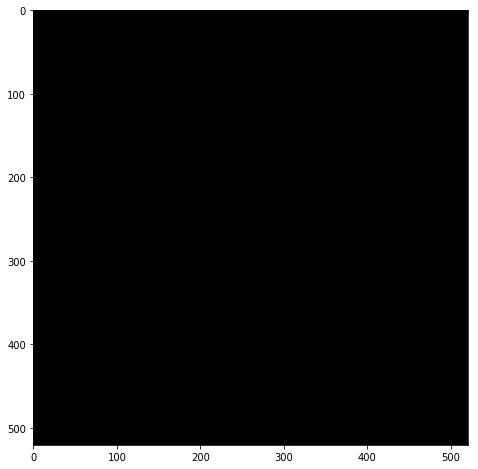

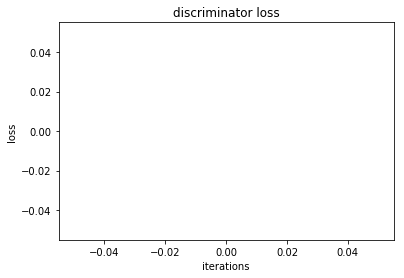

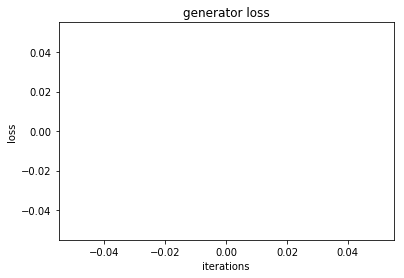

Iteration 1000/611000: dis loss = nan, gen loss = nan
Epoch 1 time is 33.29 [s]
Iteration 1500/611000: dis loss = nan, gen loss = nan
Epoch 2 time is 33.32 [s]
Iteration 2000/611000: dis loss = nan, gen loss = nan
Epoch 3 time is 33.40 [s]
Iteration 2500/611000: dis loss = nan, gen loss = nan
Iteration 3000/611000: dis loss = nan, gen loss = nan
Epoch 4 time is 33.26 [s]
Iteration 3500/611000: dis loss = nan, gen loss = nan
Epoch 5 time is 33.34 [s]


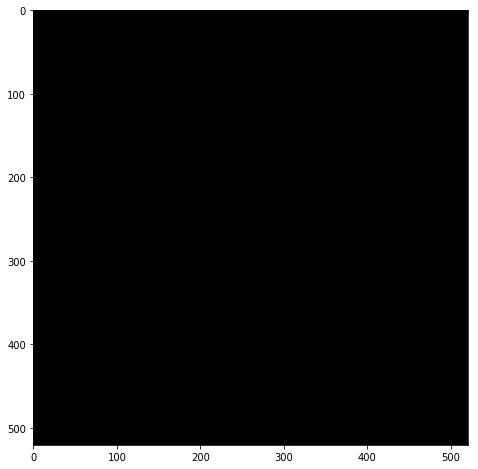

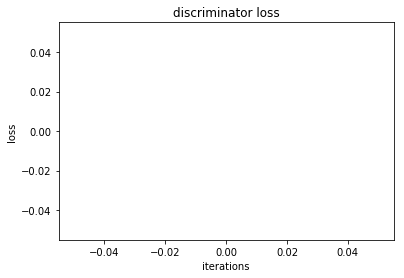

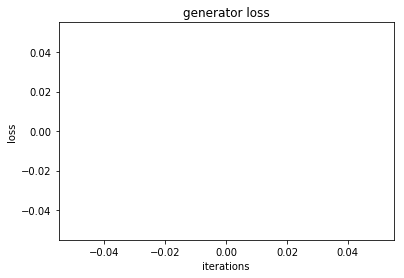

Iteration 4000/611000: dis loss = nan, gen loss = nan
Epoch 6 time is 33.62 [s]
Iteration 4500/611000: dis loss = nan, gen loss = nan
Epoch 7 time is 33.61 [s]
Iteration 5000/611000: dis loss = nan, gen loss = nan
Epoch 8 time is 33.47 [s]
Iteration 5500/611000: dis loss = nan, gen loss = nan
Iteration 6000/611000: dis loss = nan, gen loss = nan
Epoch 9 time is 33.50 [s]
Iteration 6500/611000: dis loss = nan, gen loss = nan
Epoch 10 time is 33.48 [s]


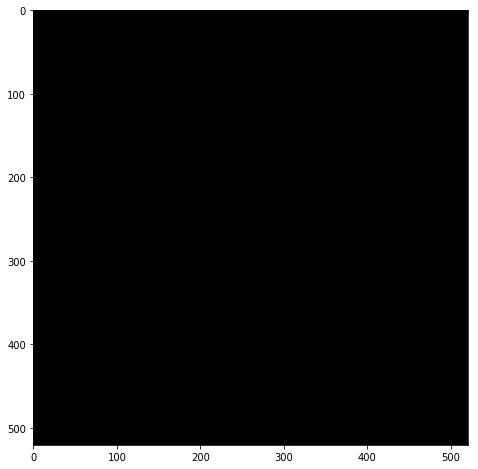

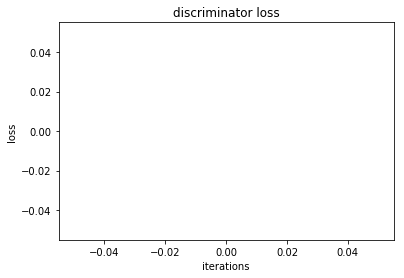

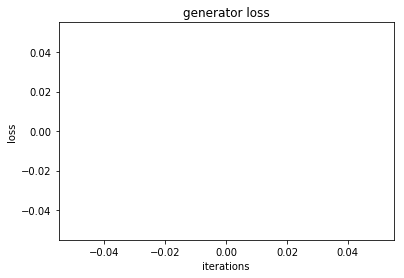

Iteration 7000/611000: dis loss = nan, gen loss = nan
Epoch 11 time is 33.54 [s]
Iteration 7500/611000: dis loss = nan, gen loss = nan
Epoch 12 time is 33.55 [s]
Iteration 8000/611000: dis loss = nan, gen loss = nan
Iteration 8500/611000: dis loss = nan, gen loss = nan
Epoch 13 time is 33.56 [s]
Iteration 9000/611000: dis loss = nan, gen loss = nan
Epoch 14 time is 33.41 [s]
Iteration 9500/611000: dis loss = nan, gen loss = nan
Epoch 15 time is 33.57 [s]


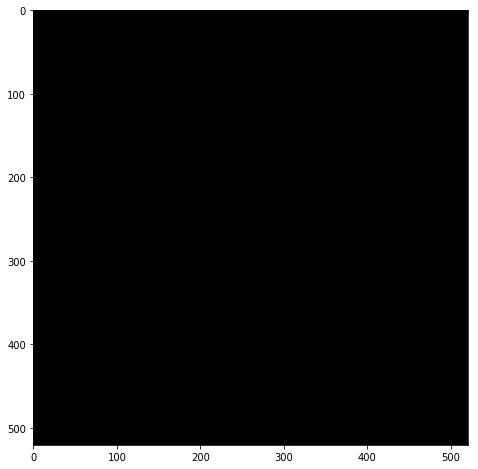

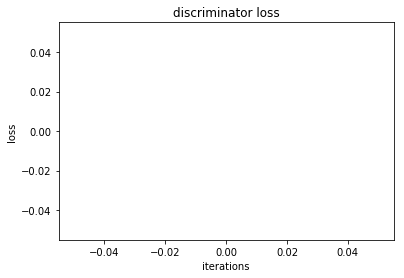

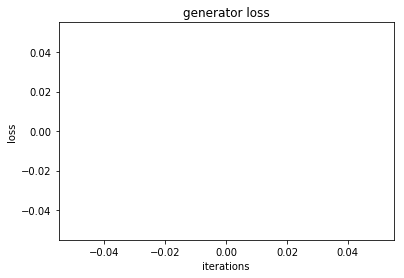

Iteration 10000/611000: dis loss = nan, gen loss = nan
Epoch 16 time is 33.45 [s]
Iteration 10500/611000: dis loss = nan, gen loss = nan
Epoch 17 time is 33.49 [s]
Iteration 11000/611000: dis loss = nan, gen loss = nan
Iteration 11500/611000: dis loss = nan, gen loss = nan
Epoch 18 time is 33.47 [s]
Iteration 12000/611000: dis loss = nan, gen loss = nan
Epoch 19 time is 33.55 [s]
Iteration 12500/611000: dis loss = nan, gen loss = nan
Epoch 20 time is 33.52 [s]


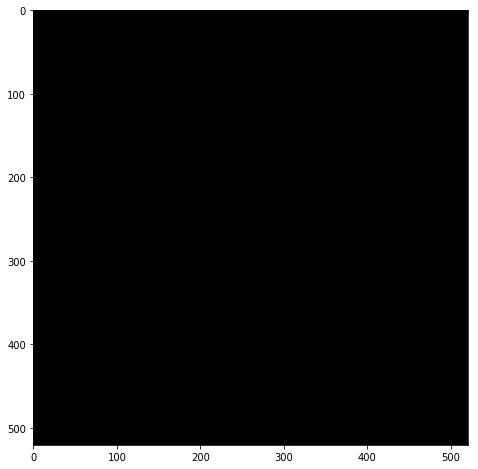

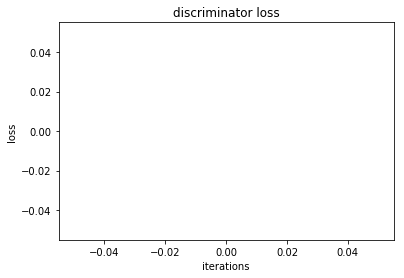

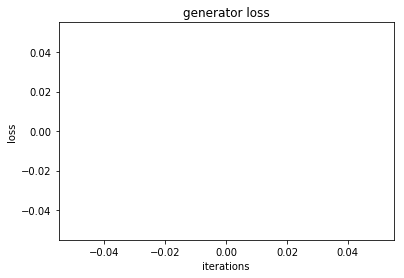

Iteration 13000/611000: dis loss = nan, gen loss = nan
Epoch 21 time is 33.25 [s]
Iteration 13500/611000: dis loss = nan, gen loss = nan
Iteration 14000/611000: dis loss = nan, gen loss = nan
Epoch 22 time is 33.30 [s]
Iteration 14500/611000: dis loss = nan, gen loss = nan
Epoch 23 time is 33.29 [s]
Iteration 15000/611000: dis loss = nan, gen loss = nan
Epoch 24 time is 33.37 [s]
Iteration 15500/611000: dis loss = nan, gen loss = nan
Epoch 25 time is 33.39 [s]


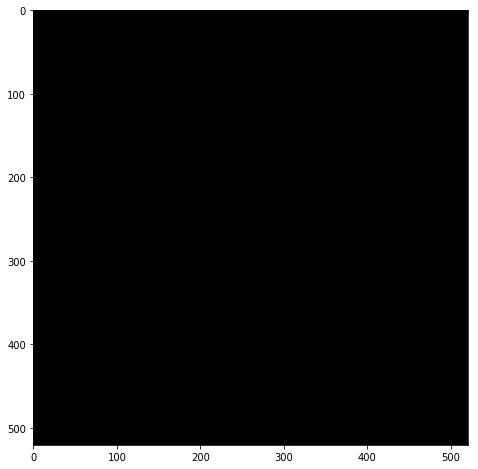

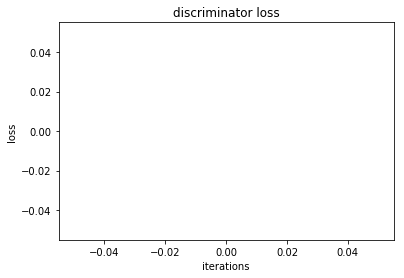

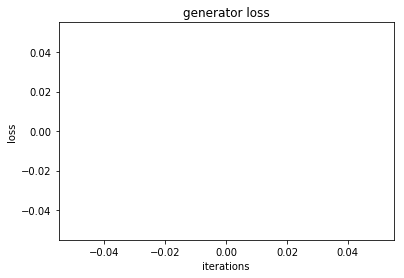

Iteration 16000/611000: dis loss = nan, gen loss = nan
Epoch 26 time is 33.52 [s]
Iteration 16500/611000: dis loss = nan, gen loss = nan
Iteration 17000/611000: dis loss = nan, gen loss = nan
Epoch 27 time is 33.52 [s]
Iteration 17500/611000: dis loss = nan, gen loss = nan
Epoch 28 time is 33.57 [s]
Iteration 18000/611000: dis loss = nan, gen loss = nan
Epoch 29 time is 33.44 [s]
Iteration 18500/611000: dis loss = nan, gen loss = nan
Epoch 30 time is 33.38 [s]


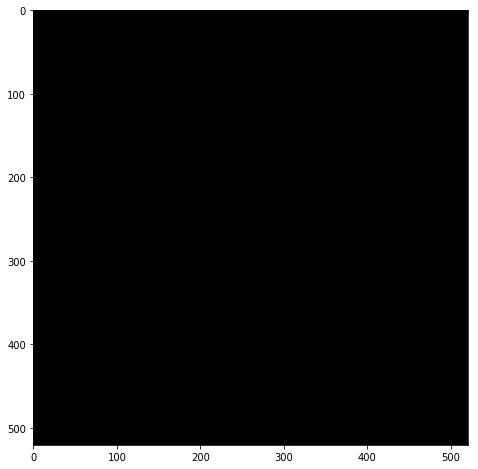

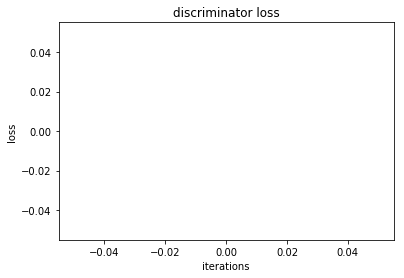

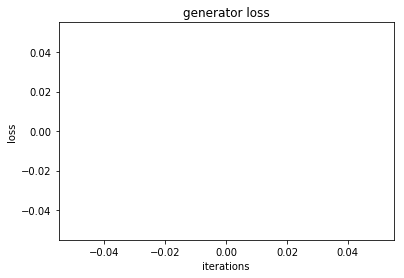

Iteration 19000/611000: dis loss = nan, gen loss = nan
Iteration 19500/611000: dis loss = nan, gen loss = nan
Epoch 31 time is 33.44 [s]
Iteration 20000/611000: dis loss = nan, gen loss = nan
Epoch 32 time is 33.36 [s]
Iteration 20500/611000: dis loss = nan, gen loss = nan
Epoch 33 time is 33.58 [s]
Iteration 21000/611000: dis loss = nan, gen loss = nan
Epoch 34 time is 33.50 [s]
Iteration 21500/611000: dis loss = nan, gen loss = nan
Epoch 35 time is 33.48 [s]


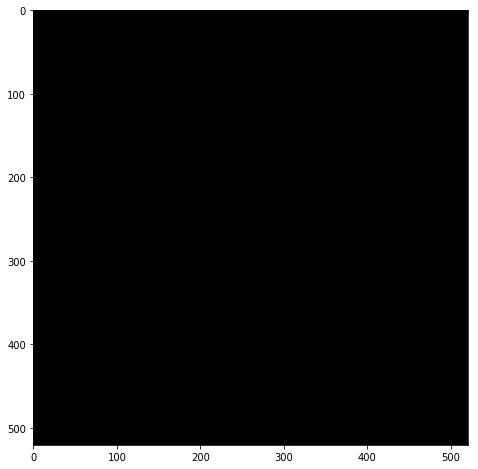

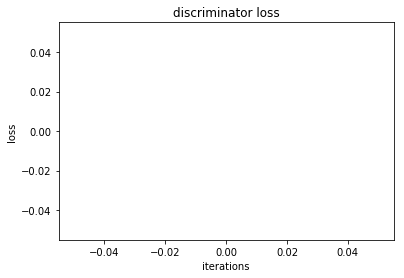

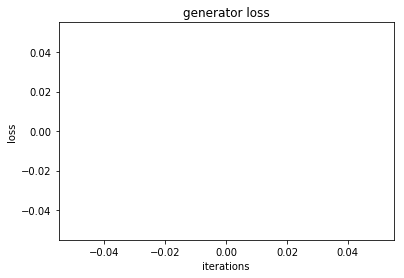

Iteration 22000/611000: dis loss = nan, gen loss = nan
Iteration 22500/611000: dis loss = nan, gen loss = nan
Epoch 36 time is 33.48 [s]
Iteration 23000/611000: dis loss = nan, gen loss = nan
Epoch 37 time is 33.44 [s]
Iteration 23500/611000: dis loss = nan, gen loss = nan
Epoch 38 time is 33.41 [s]
Iteration 24000/611000: dis loss = nan, gen loss = nan
Epoch 39 time is 33.48 [s]
Iteration 24500/611000: dis loss = nan, gen loss = nan
Iteration 25000/611000: dis loss = nan, gen loss = nan
Epoch 40 time is 33.47 [s]


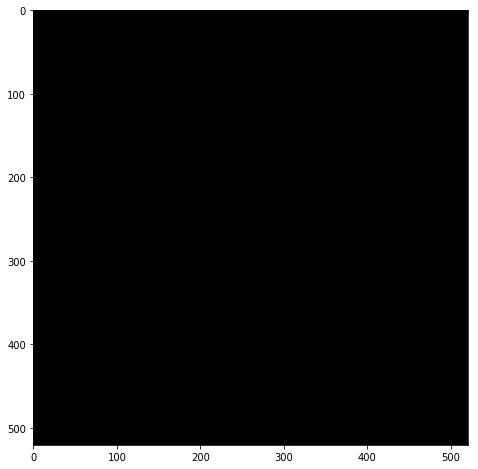

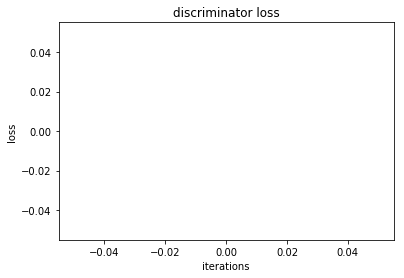

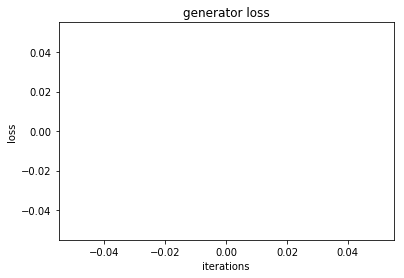

Iteration 25500/611000: dis loss = nan, gen loss = nan
Epoch 41 time is 33.52 [s]
Iteration 26000/611000: dis loss = nan, gen loss = nan
Epoch 42 time is 33.46 [s]
Iteration 26500/611000: dis loss = nan, gen loss = nan
Epoch 43 time is 33.46 [s]
Iteration 27000/611000: dis loss = nan, gen loss = nan
Epoch 44 time is 33.46 [s]
Iteration 27500/611000: dis loss = nan, gen loss = nan
Iteration 28000/611000: dis loss = nan, gen loss = nan
Epoch 45 time is 33.42 [s]


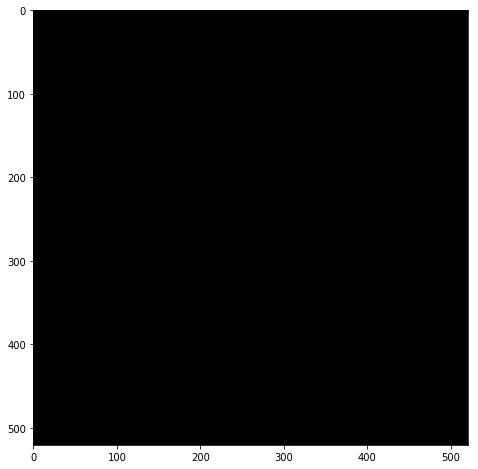

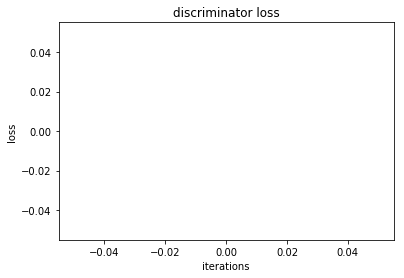

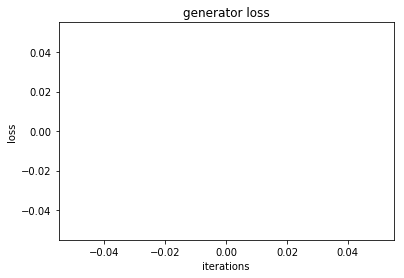

Iteration 28500/611000: dis loss = nan, gen loss = nan
Epoch 46 time is 33.45 [s]
Iteration 29000/611000: dis loss = nan, gen loss = nan
Epoch 47 time is 33.29 [s]
Iteration 29500/611000: dis loss = nan, gen loss = nan
Epoch 48 time is 33.30 [s]
Iteration 30000/611000: dis loss = nan, gen loss = nan
Iteration 30500/611000: dis loss = nan, gen loss = nan
Epoch 49 time is 33.37 [s]
Iteration 31000/611000: dis loss = nan, gen loss = nan
Epoch 50 time is 33.34 [s]


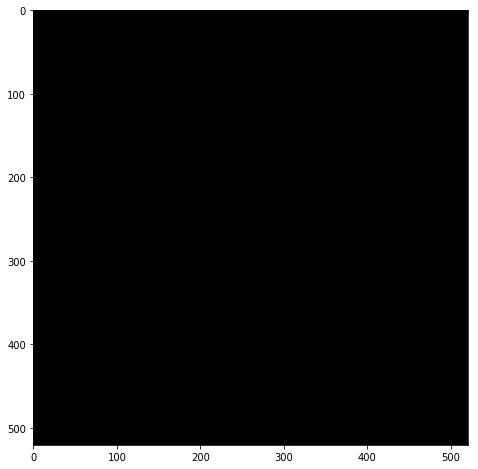

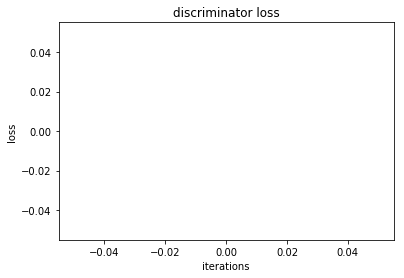

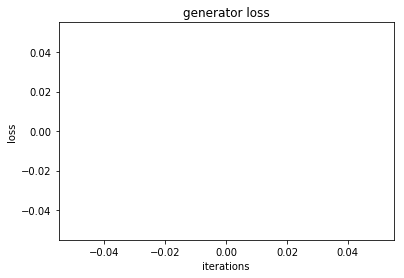

Iteration 31500/611000: dis loss = nan, gen loss = nan
Epoch 51 time is 33.30 [s]
Iteration 32000/611000: dis loss = nan, gen loss = nan
Epoch 52 time is 33.39 [s]
Iteration 32500/611000: dis loss = nan, gen loss = nan
Epoch 53 time is 33.33 [s]
Iteration 33000/611000: dis loss = nan, gen loss = nan
Iteration 33500/611000: dis loss = nan, gen loss = nan
Epoch 54 time is 33.26 [s]
Iteration 34000/611000: dis loss = nan, gen loss = nan
Epoch 55 time is 33.36 [s]


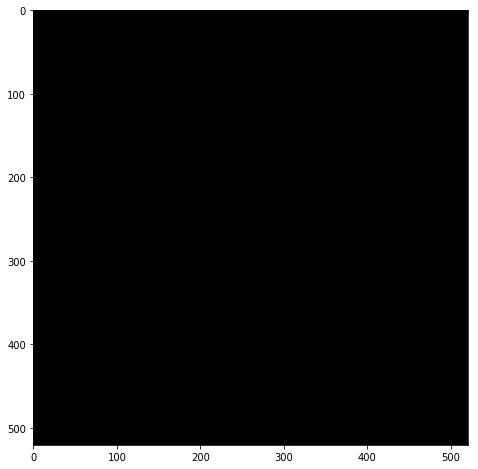

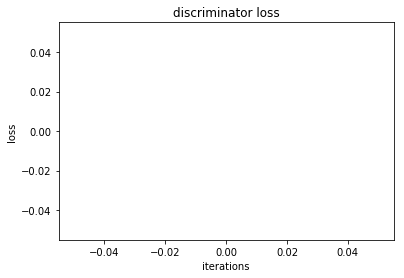

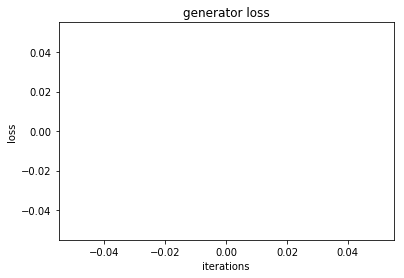

Iteration 34500/611000: dis loss = nan, gen loss = nan
Epoch 56 time is 33.45 [s]
Iteration 35000/611000: dis loss = nan, gen loss = nan
Epoch 57 time is 33.55 [s]
Iteration 35500/611000: dis loss = nan, gen loss = nan
Iteration 36000/611000: dis loss = nan, gen loss = nan
Epoch 58 time is 33.55 [s]
Iteration 36500/611000: dis loss = nan, gen loss = nan
Epoch 59 time is 33.48 [s]
Iteration 37000/611000: dis loss = nan, gen loss = nan
Epoch 60 time is 33.34 [s]


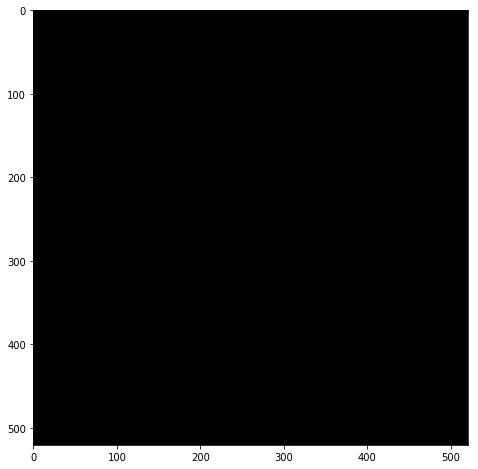

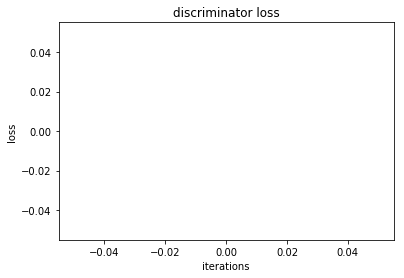

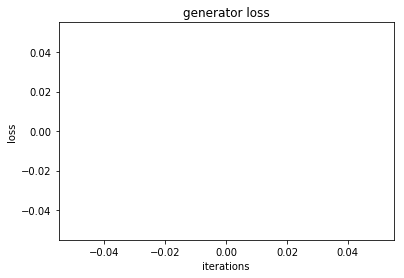

Iteration 37500/611000: dis loss = nan, gen loss = nan
Epoch 61 time is 33.52 [s]
Iteration 38000/611000: dis loss = nan, gen loss = nan
Epoch 62 time is 33.47 [s]
Iteration 38500/611000: dis loss = nan, gen loss = nan
Iteration 39000/611000: dis loss = nan, gen loss = nan
Epoch 63 time is 33.50 [s]
Iteration 39500/611000: dis loss = nan, gen loss = nan
Epoch 64 time is 33.55 [s]
Iteration 40000/611000: dis loss = nan, gen loss = nan
Epoch 65 time is 33.65 [s]


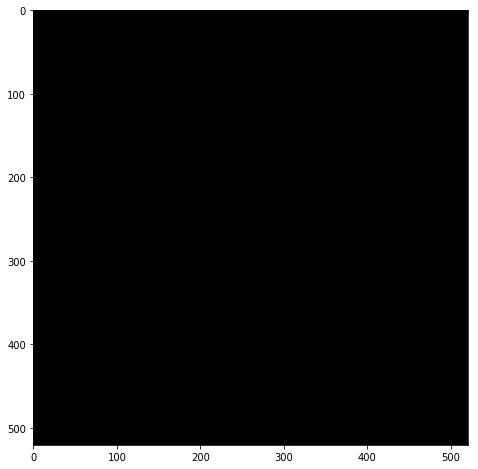

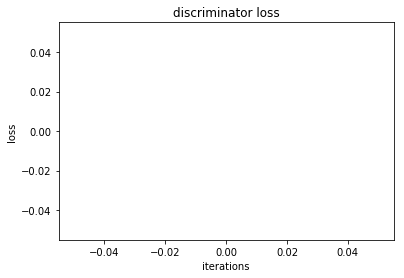

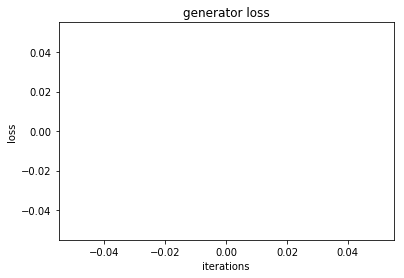

Iteration 40500/611000: dis loss = nan, gen loss = nan
Epoch 66 time is 33.34 [s]
Iteration 41000/611000: dis loss = nan, gen loss = nan
Iteration 41500/611000: dis loss = nan, gen loss = nan
Epoch 67 time is 33.44 [s]
Iteration 42000/611000: dis loss = nan, gen loss = nan
Epoch 68 time is 33.31 [s]
Iteration 42500/611000: dis loss = nan, gen loss = nan
Epoch 69 time is 33.32 [s]
Iteration 43000/611000: dis loss = nan, gen loss = nan
Epoch 70 time is 33.18 [s]


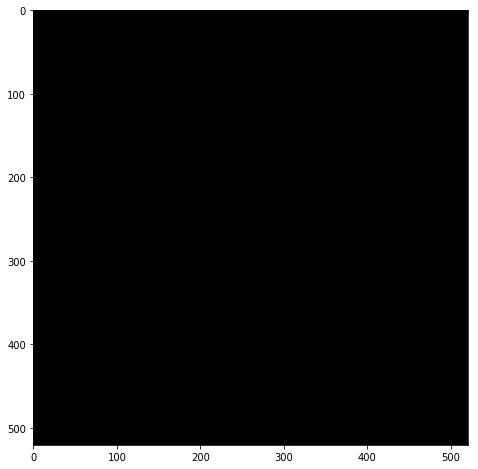

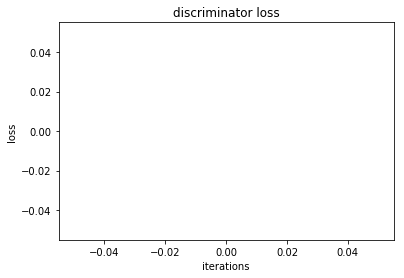

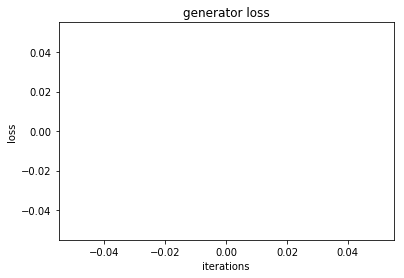

Iteration 43500/611000: dis loss = nan, gen loss = nan
Epoch 71 time is 33.33 [s]
Iteration 44000/611000: dis loss = nan, gen loss = nan
Iteration 44500/611000: dis loss = nan, gen loss = nan
Epoch 72 time is 33.37 [s]
Iteration 45000/611000: dis loss = nan, gen loss = nan
Epoch 73 time is 33.40 [s]
Iteration 45500/611000: dis loss = nan, gen loss = nan
Epoch 74 time is 33.38 [s]
Iteration 46000/611000: dis loss = nan, gen loss = nan
Epoch 75 time is 33.45 [s]


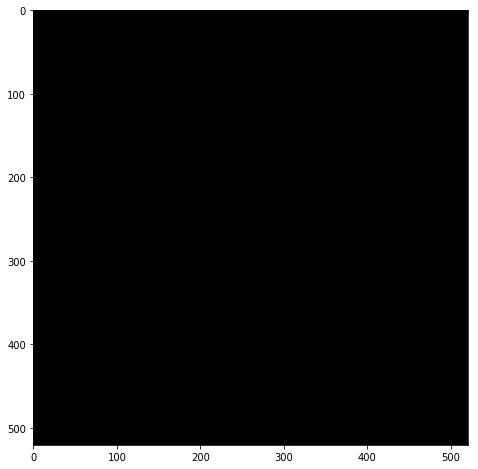

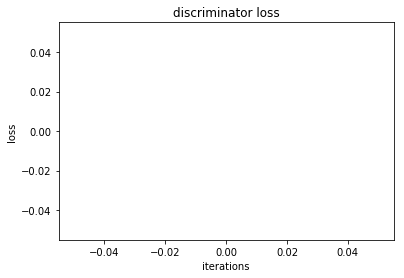

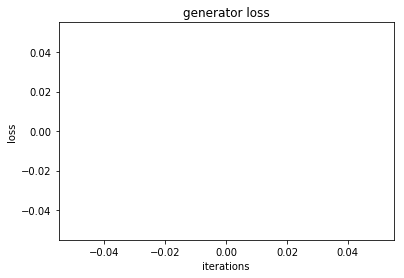

Iteration 46500/611000: dis loss = nan, gen loss = nan
Iteration 47000/611000: dis loss = nan, gen loss = nan
Epoch 76 time is 33.64 [s]
Iteration 47500/611000: dis loss = nan, gen loss = nan
Epoch 77 time is 33.31 [s]
Iteration 48000/611000: dis loss = nan, gen loss = nan
Epoch 78 time is 33.48 [s]
Iteration 48500/611000: dis loss = nan, gen loss = nan
Epoch 79 time is 33.39 [s]
Iteration 49000/611000: dis loss = nan, gen loss = nan
Epoch 80 time is 33.54 [s]


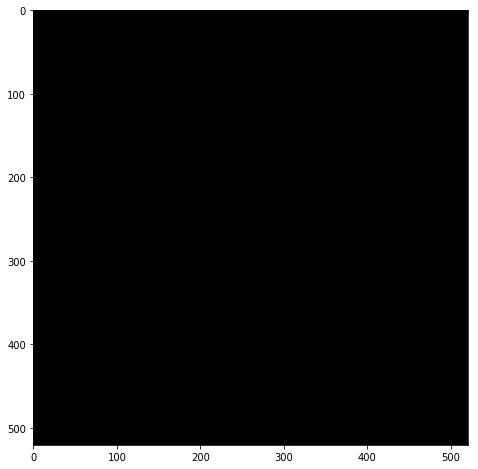

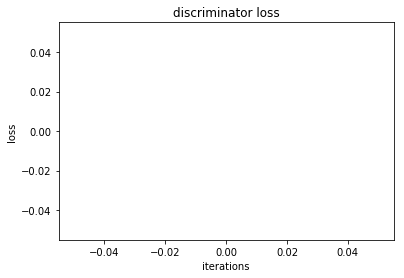

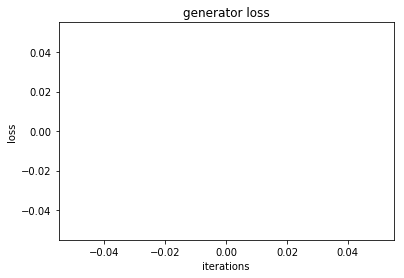

Iteration 49500/611000: dis loss = nan, gen loss = nan
Iteration 50000/611000: dis loss = nan, gen loss = nan
Epoch 81 time is 33.44 [s]
Iteration 50500/611000: dis loss = nan, gen loss = nan
Epoch 82 time is 33.49 [s]
Iteration 51000/611000: dis loss = nan, gen loss = nan
Epoch 83 time is 33.32 [s]
Iteration 51500/611000: dis loss = nan, gen loss = nan
Epoch 84 time is 33.26 [s]
Iteration 52000/611000: dis loss = nan, gen loss = nan
Iteration 52500/611000: dis loss = nan, gen loss = nan
Epoch 85 time is 33.20 [s]


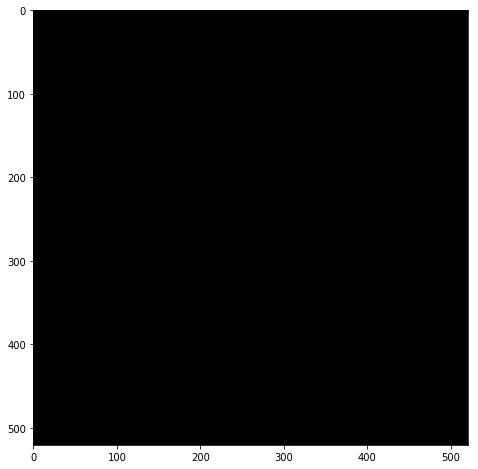

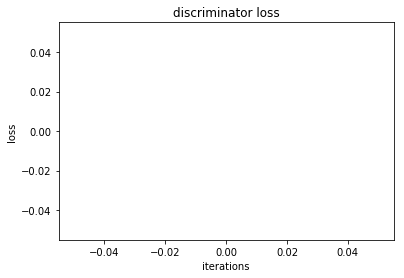

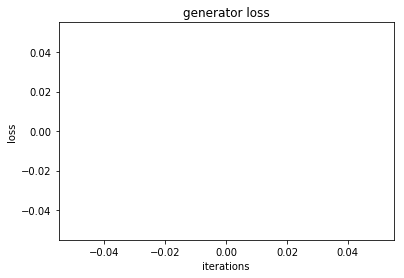

Iteration 53000/611000: dis loss = nan, gen loss = nan
Epoch 86 time is 33.49 [s]
Iteration 53500/611000: dis loss = nan, gen loss = nan
Epoch 87 time is 33.46 [s]
Iteration 54000/611000: dis loss = nan, gen loss = nan
Epoch 88 time is 33.50 [s]
Iteration 54500/611000: dis loss = nan, gen loss = nan
Epoch 89 time is 33.50 [s]
Iteration 55000/611000: dis loss = nan, gen loss = nan
Iteration 55500/611000: dis loss = nan, gen loss = nan
Epoch 90 time is 33.43 [s]


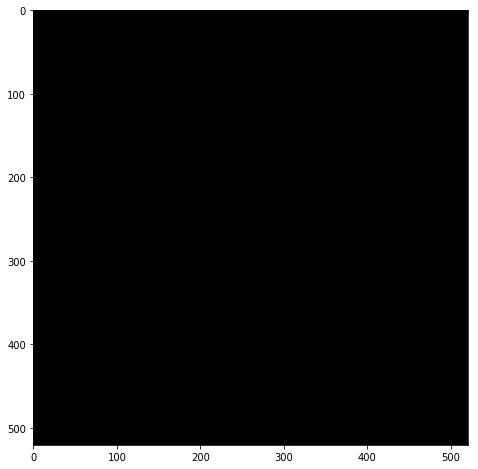

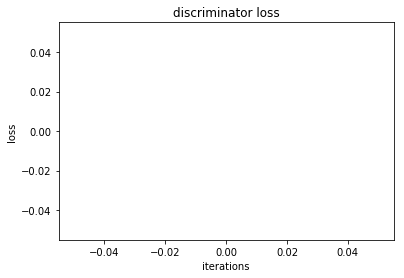

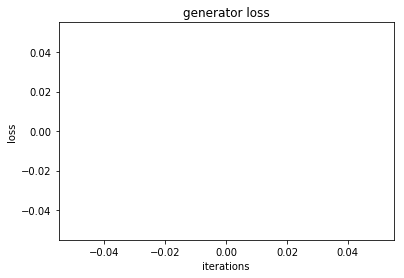

Iteration 56000/611000: dis loss = nan, gen loss = nan
Epoch 91 time is 33.30 [s]
Iteration 56500/611000: dis loss = nan, gen loss = nan
Epoch 92 time is 33.47 [s]
Iteration 57000/611000: dis loss = nan, gen loss = nan
Epoch 93 time is 33.37 [s]
Iteration 57500/611000: dis loss = nan, gen loss = nan
Iteration 58000/611000: dis loss = nan, gen loss = nan
Epoch 94 time is 33.50 [s]
Iteration 58500/611000: dis loss = nan, gen loss = nan
Epoch 95 time is 33.46 [s]


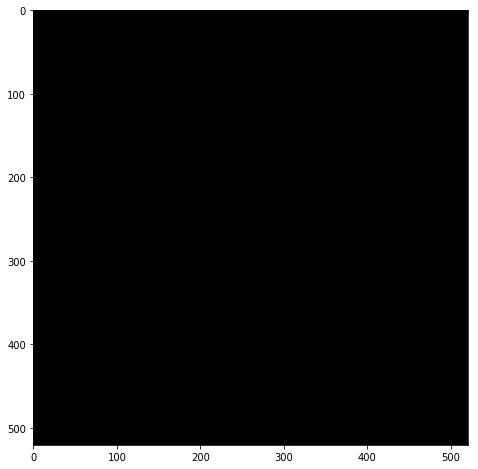

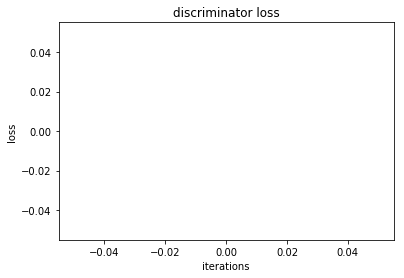

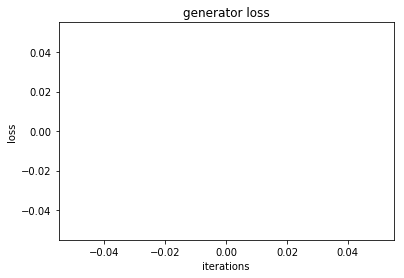

Iteration 59000/611000: dis loss = nan, gen loss = nan
Epoch 96 time is 33.46 [s]
Iteration 59500/611000: dis loss = nan, gen loss = nan
Epoch 97 time is 33.36 [s]
Iteration 60000/611000: dis loss = nan, gen loss = nan
Epoch 98 time is 33.37 [s]
Iteration 60500/611000: dis loss = nan, gen loss = nan
Iteration 61000/611000: dis loss = nan, gen loss = nan
Epoch 99 time is 33.45 [s]
Iteration 61500/611000: dis loss = nan, gen loss = nan
Epoch 100 time is 33.57 [s]


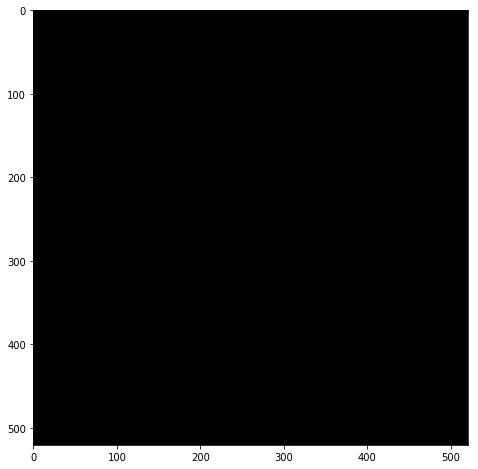

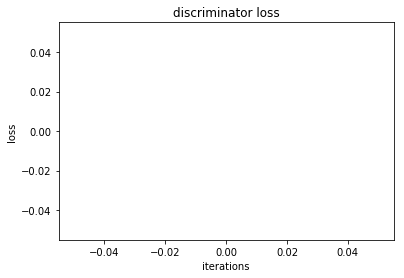

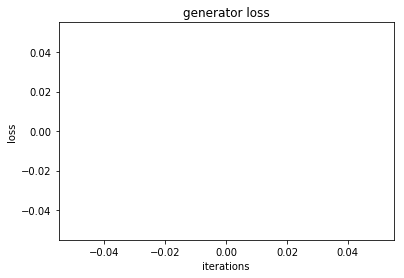

Iteration 62000/611000: dis loss = nan, gen loss = nan
Epoch 101 time is 33.38 [s]
Iteration 62500/611000: dis loss = nan, gen loss = nan
Epoch 102 time is 33.50 [s]
Iteration 63000/611000: dis loss = nan, gen loss = nan
Iteration 63500/611000: dis loss = nan, gen loss = nan
Epoch 103 time is 33.52 [s]
Iteration 64000/611000: dis loss = nan, gen loss = nan
Epoch 104 time is 33.39 [s]
Iteration 64500/611000: dis loss = nan, gen loss = nan
Epoch 105 time is 33.50 [s]


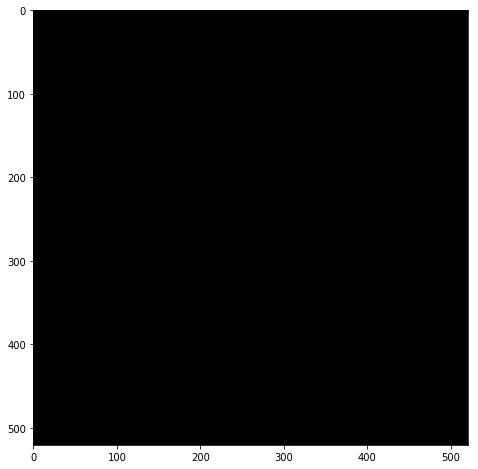

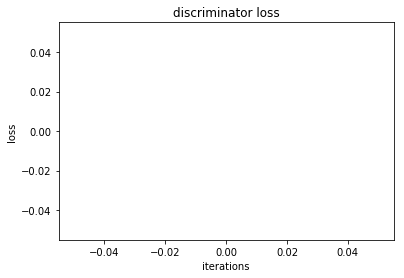

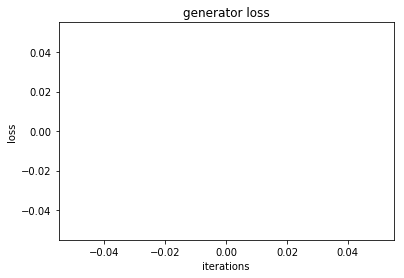

Iteration 65000/611000: dis loss = nan, gen loss = nan
Epoch 106 time is 33.51 [s]
Iteration 65500/611000: dis loss = nan, gen loss = nan
Epoch 107 time is 33.41 [s]
Iteration 66000/611000: dis loss = nan, gen loss = nan
Iteration 66500/611000: dis loss = nan, gen loss = nan
Epoch 108 time is 33.44 [s]
Iteration 67000/611000: dis loss = nan, gen loss = nan
Epoch 109 time is 33.47 [s]
Iteration 67500/611000: dis loss = nan, gen loss = nan
Epoch 110 time is 33.52 [s]


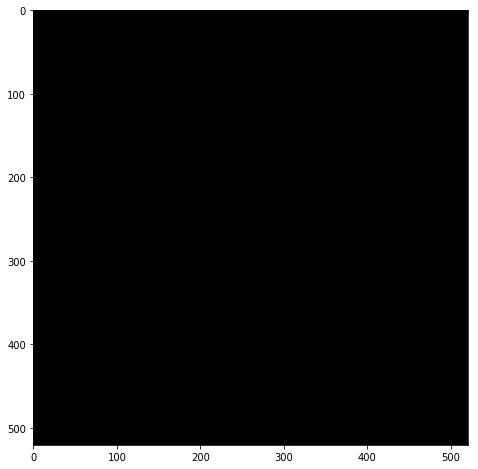

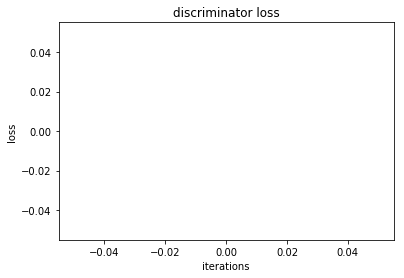

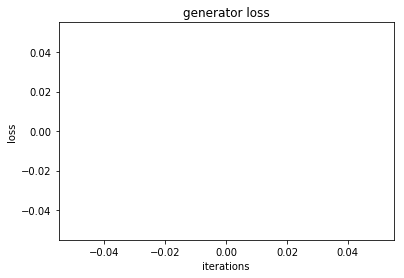

Iteration 68000/611000: dis loss = nan, gen loss = nan
Epoch 111 time is 33.49 [s]
Iteration 68500/611000: dis loss = nan, gen loss = nan
Iteration 69000/611000: dis loss = nan, gen loss = nan
Epoch 112 time is 33.49 [s]
Iteration 69500/611000: dis loss = nan, gen loss = nan
Epoch 113 time is 33.53 [s]
Iteration 70000/611000: dis loss = nan, gen loss = nan
Epoch 114 time is 33.49 [s]
Iteration 70500/611000: dis loss = nan, gen loss = nan
Epoch 115 time is 33.40 [s]


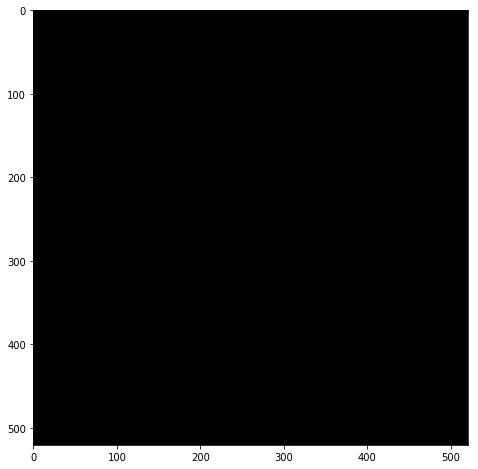

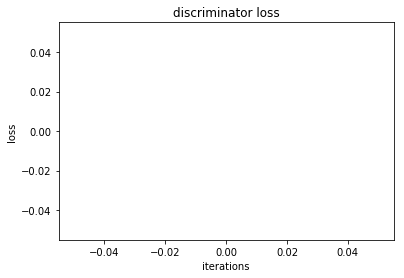

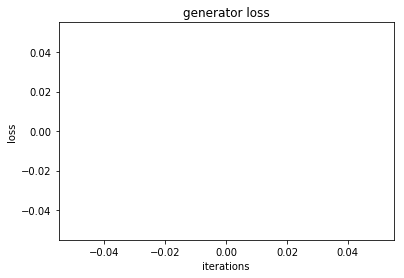

Iteration 71000/611000: dis loss = nan, gen loss = nan
Epoch 116 time is 33.55 [s]
Iteration 71500/611000: dis loss = nan, gen loss = nan
Iteration 72000/611000: dis loss = nan, gen loss = nan
Epoch 117 time is 33.40 [s]
Iteration 72500/611000: dis loss = nan, gen loss = nan
Epoch 118 time is 33.51 [s]
Iteration 73000/611000: dis loss = nan, gen loss = nan
Epoch 119 time is 33.54 [s]
Iteration 73500/611000: dis loss = nan, gen loss = nan
Epoch 120 time is 33.59 [s]


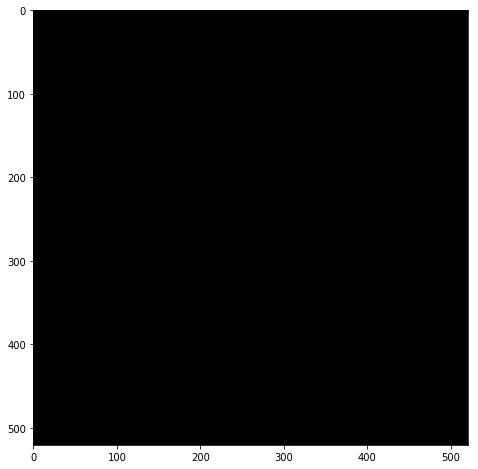

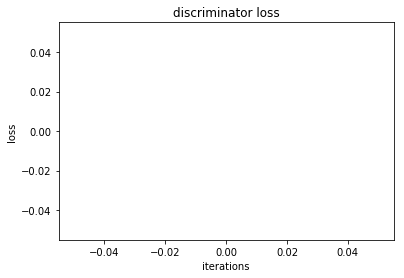

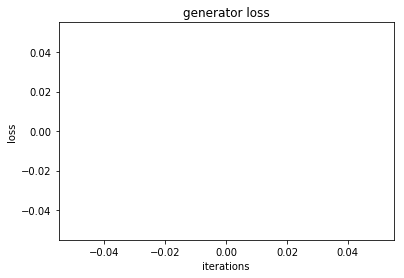

Iteration 74000/611000: dis loss = nan, gen loss = nan
Iteration 74500/611000: dis loss = nan, gen loss = nan
Epoch 121 time is 33.52 [s]
Iteration 75000/611000: dis loss = nan, gen loss = nan
Epoch 122 time is 33.47 [s]
Iteration 75500/611000: dis loss = nan, gen loss = nan
Epoch 123 time is 33.52 [s]
Iteration 76000/611000: dis loss = nan, gen loss = nan
Epoch 124 time is 33.44 [s]
Iteration 76500/611000: dis loss = nan, gen loss = nan
Epoch 125 time is 33.53 [s]


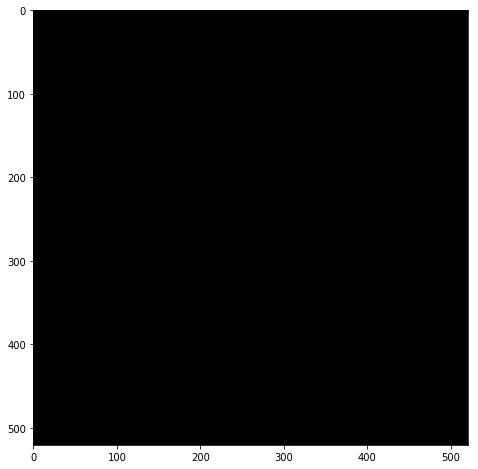

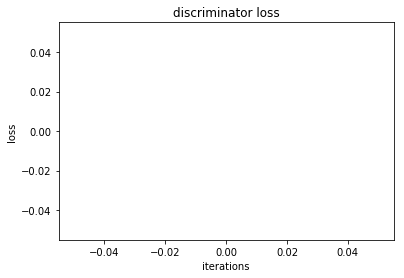

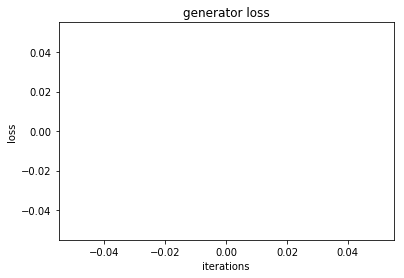

Iteration 77000/611000: dis loss = nan, gen loss = nan
Iteration 77500/611000: dis loss = nan, gen loss = nan
Epoch 126 time is 33.35 [s]
Iteration 78000/611000: dis loss = nan, gen loss = nan
Epoch 127 time is 33.48 [s]
Iteration 78500/611000: dis loss = nan, gen loss = nan
Epoch 128 time is 33.48 [s]
Iteration 79000/611000: dis loss = nan, gen loss = nan
Epoch 129 time is 33.48 [s]
Iteration 79500/611000: dis loss = nan, gen loss = nan
Iteration 80000/611000: dis loss = nan, gen loss = nan
Epoch 130 time is 33.45 [s]


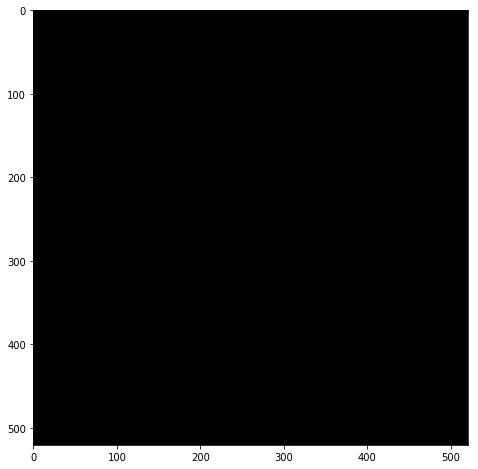

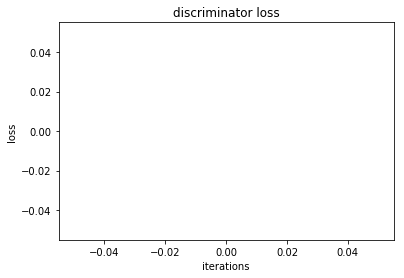

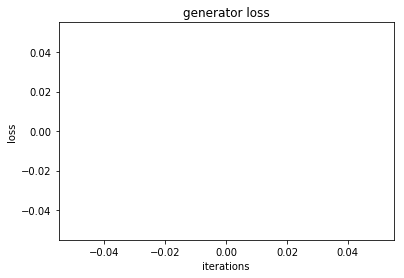

Iteration 80500/611000: dis loss = nan, gen loss = nan
Epoch 131 time is 33.44 [s]
Iteration 81000/611000: dis loss = nan, gen loss = nan
Epoch 132 time is 33.36 [s]
Iteration 81500/611000: dis loss = nan, gen loss = nan
Epoch 133 time is 33.60 [s]
Iteration 82000/611000: dis loss = nan, gen loss = nan
Epoch 134 time is 33.46 [s]
Iteration 82500/611000: dis loss = nan, gen loss = nan
Iteration 83000/611000: dis loss = nan, gen loss = nan
Epoch 135 time is 33.71 [s]


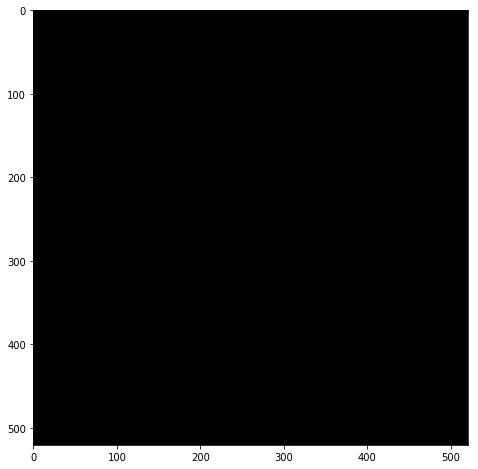

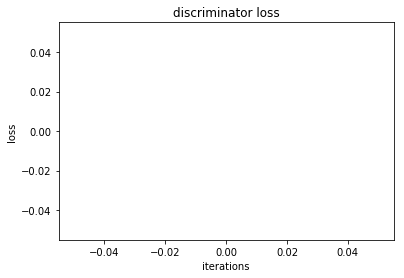

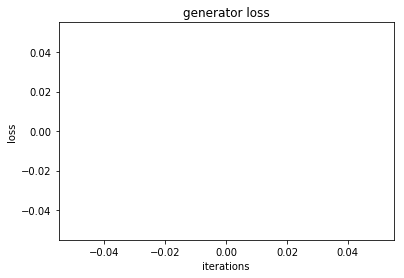

Iteration 83500/611000: dis loss = nan, gen loss = nan
Epoch 136 time is 33.53 [s]
Iteration 84000/611000: dis loss = nan, gen loss = nan
Epoch 137 time is 33.52 [s]
Iteration 84500/611000: dis loss = nan, gen loss = nan
Epoch 138 time is 33.37 [s]
Iteration 85000/611000: dis loss = nan, gen loss = nan
Iteration 85500/611000: dis loss = nan, gen loss = nan
Epoch 139 time is 33.59 [s]
Iteration 86000/611000: dis loss = nan, gen loss = nan
Epoch 140 time is 33.45 [s]


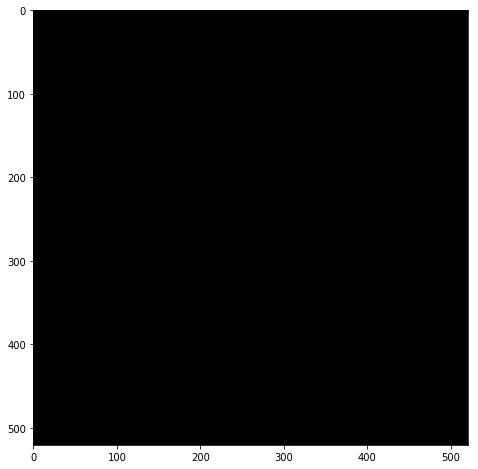

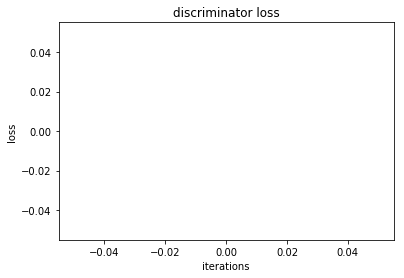

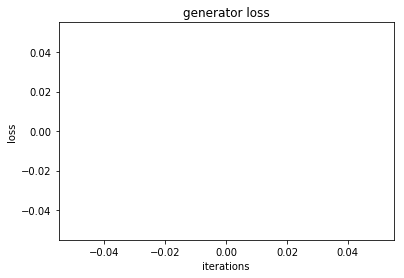

Iteration 86500/611000: dis loss = nan, gen loss = nan
Epoch 141 time is 33.40 [s]
Iteration 87000/611000: dis loss = nan, gen loss = nan
Epoch 142 time is 33.45 [s]
Iteration 87500/611000: dis loss = nan, gen loss = nan
Epoch 143 time is 33.54 [s]
Iteration 88000/611000: dis loss = nan, gen loss = nan
Iteration 88500/611000: dis loss = nan, gen loss = nan
Epoch 144 time is 33.46 [s]
Iteration 89000/611000: dis loss = nan, gen loss = nan
Epoch 145 time is 33.51 [s]


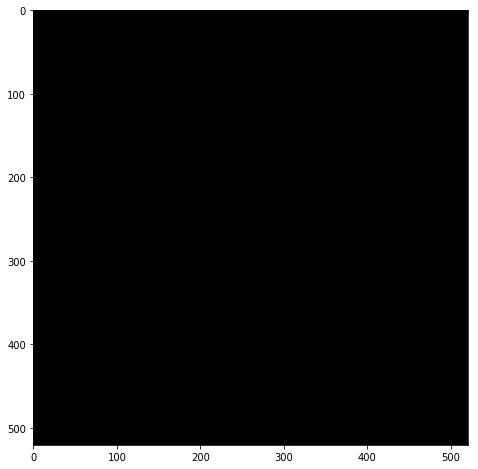

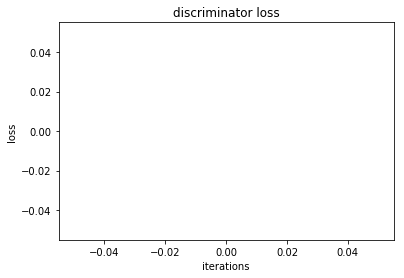

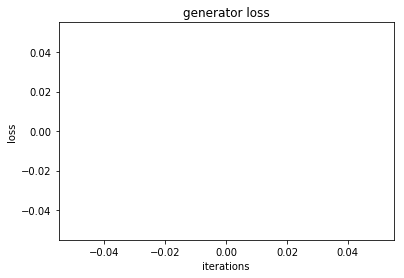

Iteration 89500/611000: dis loss = nan, gen loss = nan
Epoch 146 time is 33.33 [s]
Iteration 90000/611000: dis loss = nan, gen loss = nan
Epoch 147 time is 33.31 [s]
Iteration 90500/611000: dis loss = nan, gen loss = nan
Iteration 91000/611000: dis loss = nan, gen loss = nan
Epoch 148 time is 33.37 [s]
Iteration 91500/611000: dis loss = nan, gen loss = nan
Epoch 149 time is 33.36 [s]
Iteration 92000/611000: dis loss = nan, gen loss = nan
Epoch 150 time is 33.37 [s]


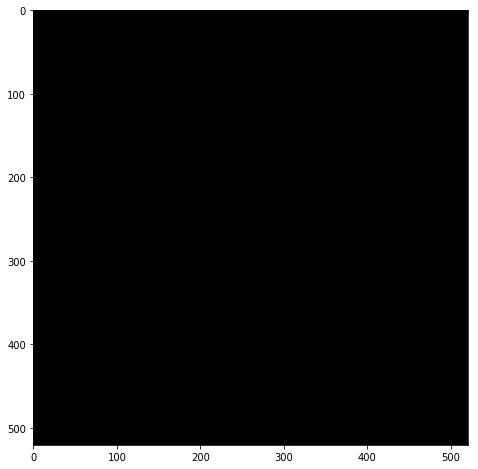

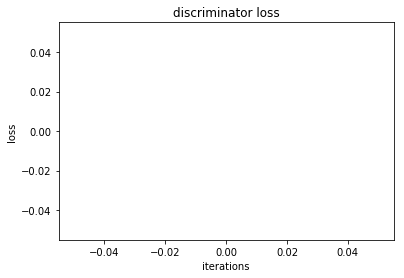

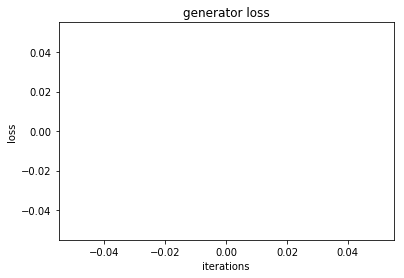

Iteration 92500/611000: dis loss = nan, gen loss = nan
Epoch 151 time is 33.33 [s]
Iteration 93000/611000: dis loss = nan, gen loss = nan
Epoch 152 time is 33.27 [s]
Iteration 93500/611000: dis loss = nan, gen loss = nan
Iteration 94000/611000: dis loss = nan, gen loss = nan
Epoch 153 time is 33.25 [s]
Iteration 94500/611000: dis loss = nan, gen loss = nan
Epoch 154 time is 33.31 [s]
Iteration 95000/611000: dis loss = nan, gen loss = nan
Epoch 155 time is 33.26 [s]


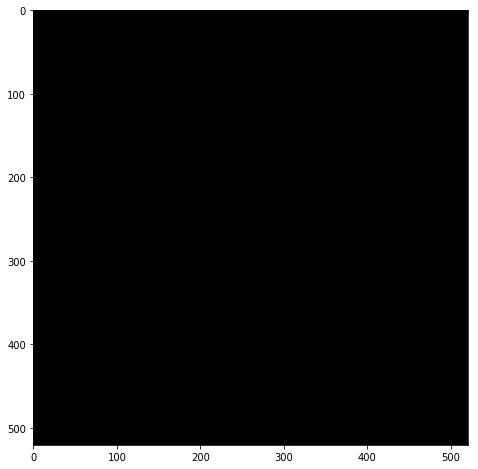

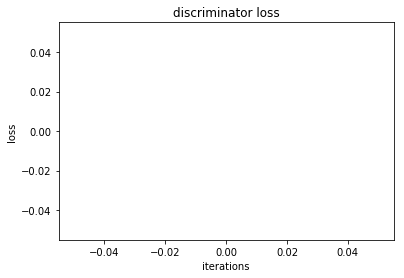

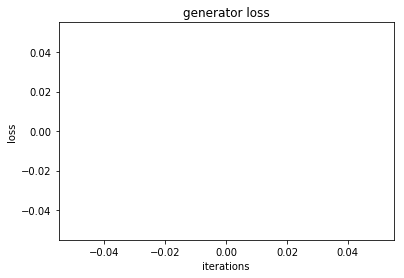

Iteration 95500/611000: dis loss = nan, gen loss = nan
Epoch 156 time is 33.49 [s]
Iteration 96000/611000: dis loss = nan, gen loss = nan
Iteration 96500/611000: dis loss = nan, gen loss = nan
Epoch 157 time is 33.49 [s]
Iteration 97000/611000: dis loss = nan, gen loss = nan
Epoch 158 time is 33.43 [s]
Iteration 97500/611000: dis loss = nan, gen loss = nan
Epoch 159 time is 33.44 [s]
Iteration 98000/611000: dis loss = nan, gen loss = nan
Epoch 160 time is 33.46 [s]


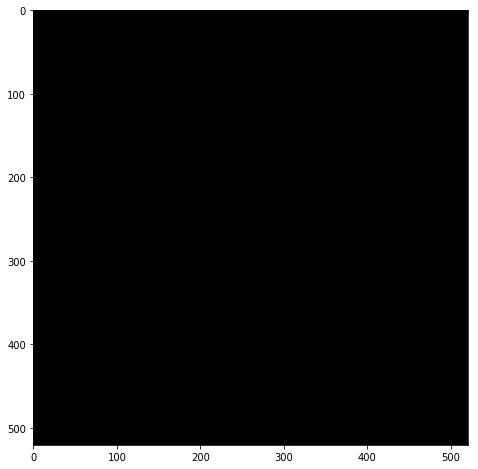

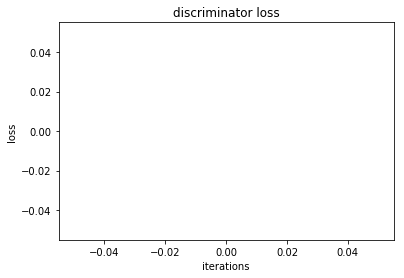

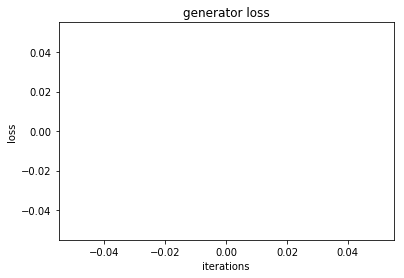

Iteration 98500/611000: dis loss = nan, gen loss = nan
Epoch 161 time is 33.41 [s]
Iteration 99000/611000: dis loss = nan, gen loss = nan
Iteration 99500/611000: dis loss = nan, gen loss = nan
Epoch 162 time is 33.58 [s]
Iteration 100000/611000: dis loss = nan, gen loss = nan
Epoch 163 time is 33.48 [s]
Iteration 100500/611000: dis loss = nan, gen loss = nan
Epoch 164 time is 33.53 [s]
Iteration 101000/611000: dis loss = nan, gen loss = nan
Epoch 165 time is 33.37 [s]


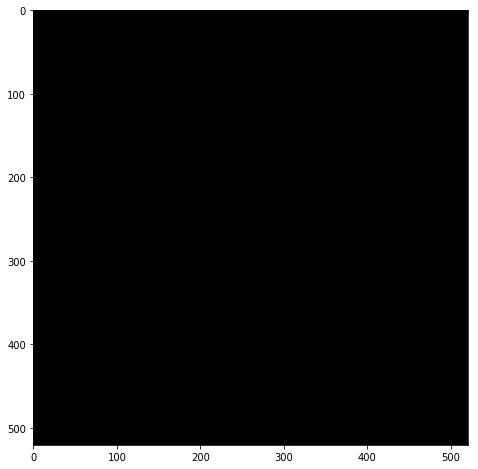

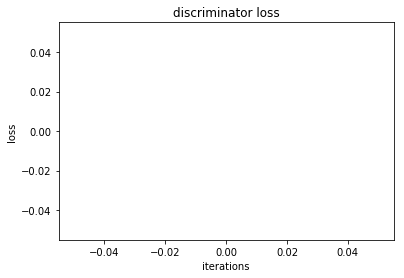

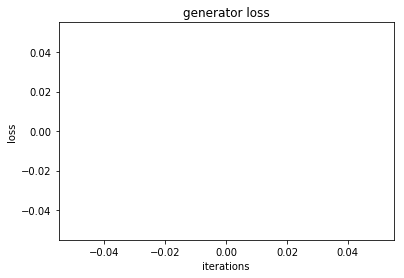

Iteration 101500/611000: dis loss = nan, gen loss = nan
Iteration 102000/611000: dis loss = nan, gen loss = nan
Epoch 166 time is 33.53 [s]
Iteration 102500/611000: dis loss = nan, gen loss = nan
Epoch 167 time is 33.44 [s]
Iteration 103000/611000: dis loss = nan, gen loss = nan
Epoch 168 time is 33.38 [s]
Iteration 103500/611000: dis loss = nan, gen loss = nan
Epoch 169 time is 33.25 [s]
Iteration 104000/611000: dis loss = nan, gen loss = nan
Epoch 170 time is 33.24 [s]


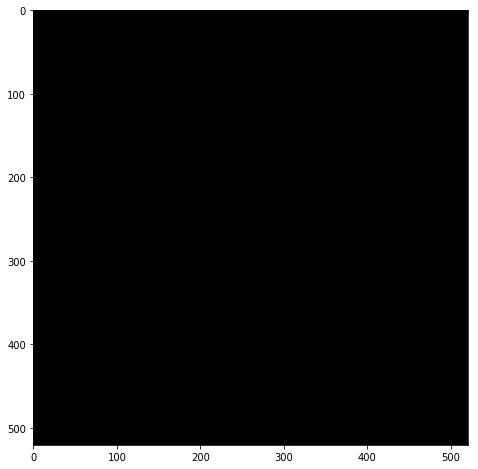

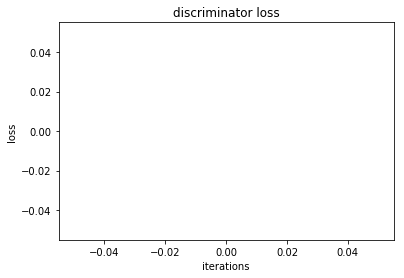

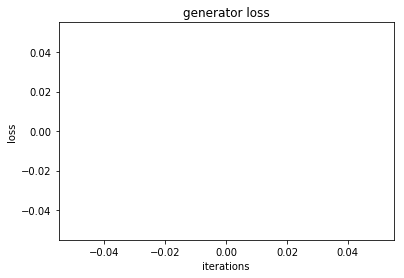

Iteration 104500/611000: dis loss = nan, gen loss = nan
Iteration 105000/611000: dis loss = nan, gen loss = nan
Epoch 171 time is 33.40 [s]
Iteration 105500/611000: dis loss = nan, gen loss = nan
Epoch 172 time is 33.52 [s]
Iteration 106000/611000: dis loss = nan, gen loss = nan
Epoch 173 time is 33.39 [s]
Iteration 106500/611000: dis loss = nan, gen loss = nan
Epoch 174 time is 33.33 [s]
Iteration 107000/611000: dis loss = nan, gen loss = nan
Iteration 107500/611000: dis loss = nan, gen loss = nan
Epoch 175 time is 33.39 [s]


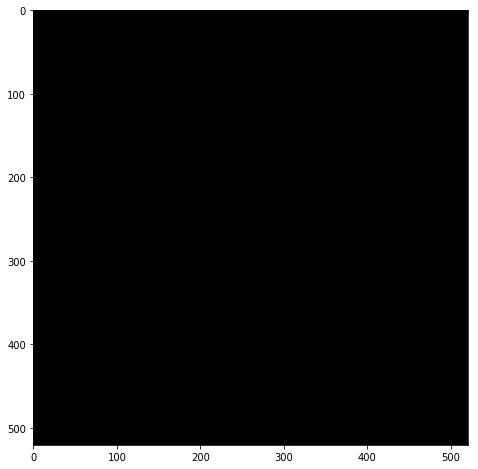

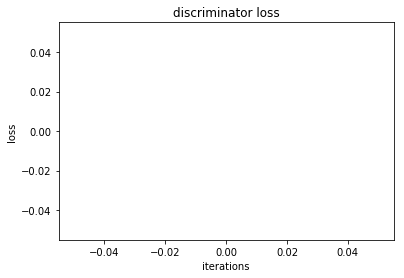

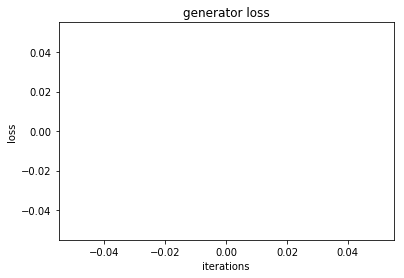

Iteration 108000/611000: dis loss = nan, gen loss = nan
Epoch 176 time is 33.51 [s]
Iteration 108500/611000: dis loss = nan, gen loss = nan
Epoch 177 time is 33.51 [s]
Iteration 109000/611000: dis loss = nan, gen loss = nan
Epoch 178 time is 33.49 [s]
Iteration 109500/611000: dis loss = nan, gen loss = nan
Epoch 179 time is 33.46 [s]
Iteration 110000/611000: dis loss = nan, gen loss = nan
Iteration 110500/611000: dis loss = nan, gen loss = nan
Epoch 180 time is 33.33 [s]


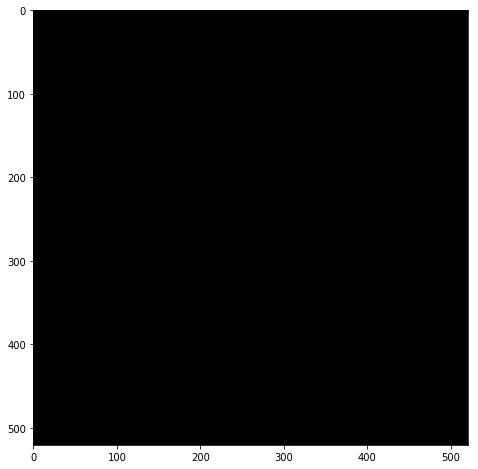

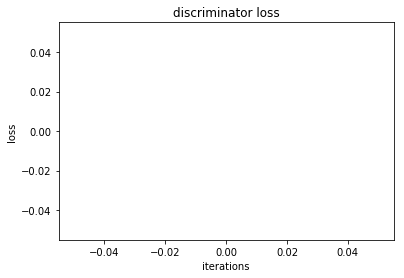

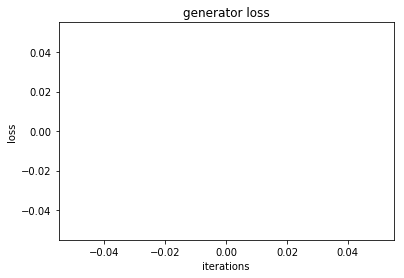

Iteration 111000/611000: dis loss = nan, gen loss = nan
Epoch 181 time is 33.46 [s]
Iteration 111500/611000: dis loss = nan, gen loss = nan
Epoch 182 time is 33.46 [s]
Iteration 112000/611000: dis loss = nan, gen loss = nan
Epoch 183 time is 33.47 [s]
Iteration 112500/611000: dis loss = nan, gen loss = nan
Iteration 113000/611000: dis loss = nan, gen loss = nan
Epoch 184 time is 33.43 [s]
Iteration 113500/611000: dis loss = nan, gen loss = nan
Epoch 185 time is 33.48 [s]


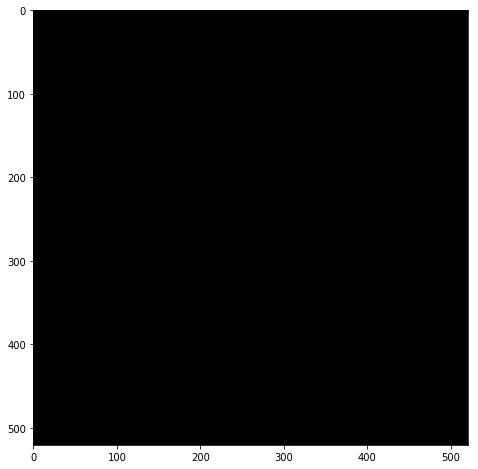

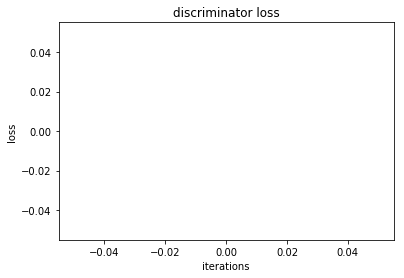

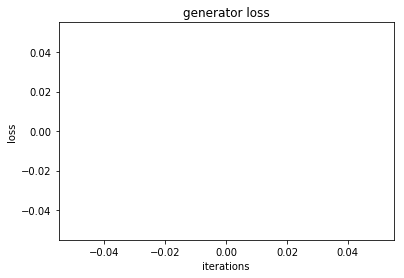

Iteration 114000/611000: dis loss = nan, gen loss = nan
Epoch 186 time is 33.33 [s]
Iteration 114500/611000: dis loss = nan, gen loss = nan
Epoch 187 time is 33.37 [s]
Iteration 115000/611000: dis loss = nan, gen loss = nan
Epoch 188 time is 33.46 [s]
Iteration 115500/611000: dis loss = nan, gen loss = nan
Iteration 116000/611000: dis loss = nan, gen loss = nan
Epoch 189 time is 33.46 [s]
Iteration 116500/611000: dis loss = nan, gen loss = nan
Epoch 190 time is 33.31 [s]


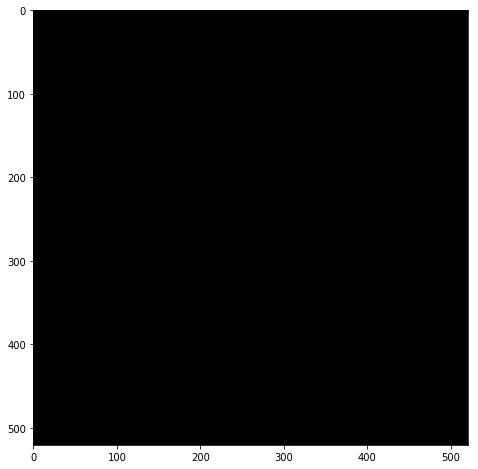

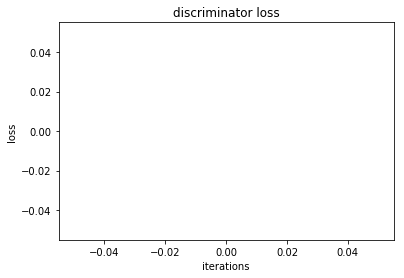

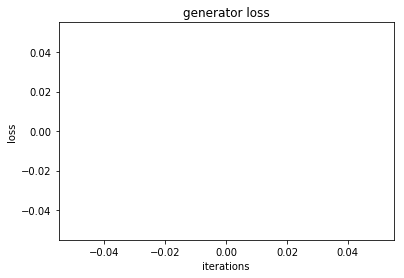

Iteration 117000/611000: dis loss = nan, gen loss = nan
Epoch 191 time is 33.45 [s]
Iteration 117500/611000: dis loss = nan, gen loss = nan
Epoch 192 time is 33.51 [s]
Iteration 118000/611000: dis loss = nan, gen loss = nan
Iteration 118500/611000: dis loss = nan, gen loss = nan
Epoch 193 time is 33.45 [s]
Iteration 119000/611000: dis loss = nan, gen loss = nan
Epoch 194 time is 33.52 [s]
Iteration 119500/611000: dis loss = nan, gen loss = nan
Epoch 195 time is 33.51 [s]


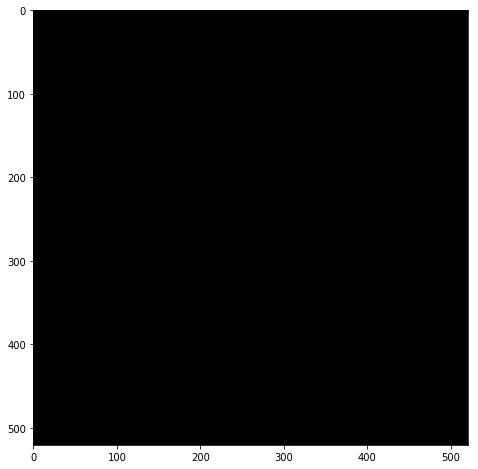

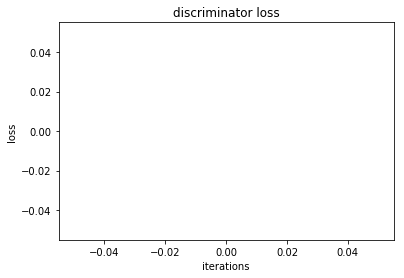

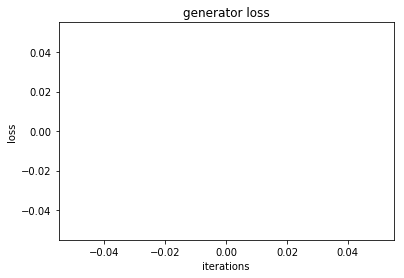

Iteration 120000/611000: dis loss = nan, gen loss = nan
Epoch 196 time is 33.54 [s]
Iteration 120500/611000: dis loss = nan, gen loss = nan
Epoch 197 time is 33.55 [s]
Iteration 121000/611000: dis loss = nan, gen loss = nan
Iteration 121500/611000: dis loss = nan, gen loss = nan
Epoch 198 time is 33.48 [s]
Iteration 122000/611000: dis loss = nan, gen loss = nan
Epoch 199 time is 33.55 [s]
Iteration 122500/611000: dis loss = nan, gen loss = nan
Epoch 200 time is 33.66 [s]


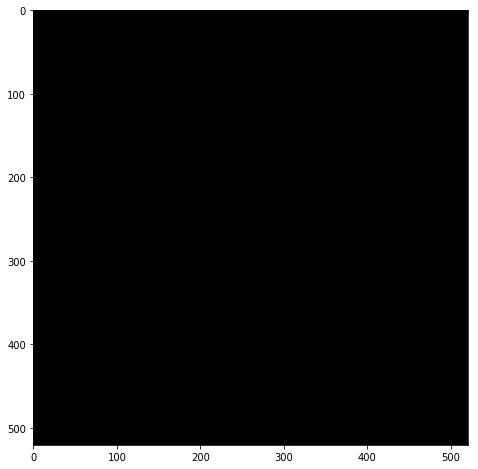

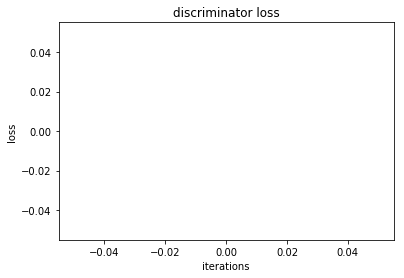

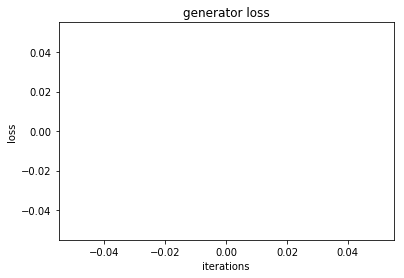

Iteration 123000/611000: dis loss = nan, gen loss = nan
Epoch 201 time is 33.54 [s]
Iteration 123500/611000: dis loss = nan, gen loss = nan
Iteration 124000/611000: dis loss = nan, gen loss = nan
Epoch 202 time is 33.42 [s]
Iteration 124500/611000: dis loss = nan, gen loss = nan
Epoch 203 time is 33.45 [s]
Iteration 125000/611000: dis loss = nan, gen loss = nan
Epoch 204 time is 33.45 [s]
Iteration 125500/611000: dis loss = nan, gen loss = nan
Epoch 205 time is 33.58 [s]


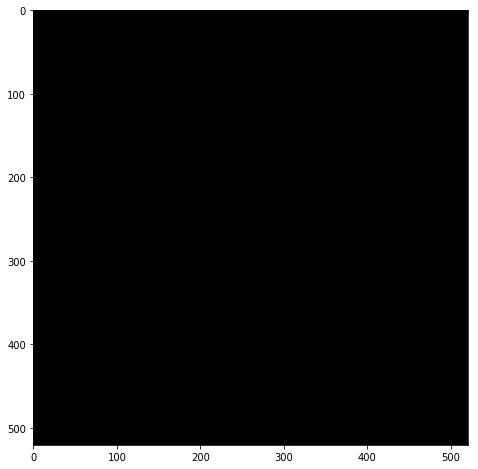

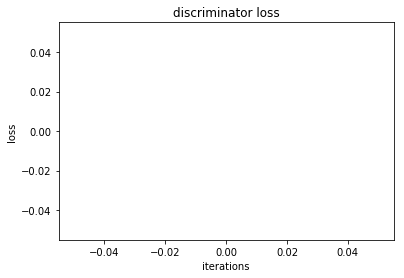

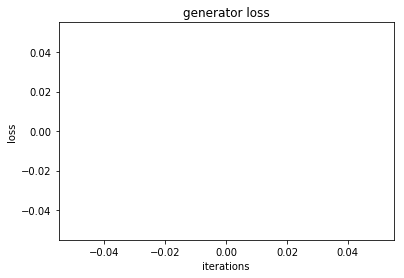

Iteration 126000/611000: dis loss = nan, gen loss = nan
Epoch 206 time is 33.42 [s]
Iteration 126500/611000: dis loss = nan, gen loss = nan
Iteration 127000/611000: dis loss = nan, gen loss = nan
Epoch 207 time is 33.59 [s]
Iteration 127500/611000: dis loss = nan, gen loss = nan
Epoch 208 time is 33.55 [s]
Iteration 128000/611000: dis loss = nan, gen loss = nan
Epoch 209 time is 33.53 [s]
Iteration 128500/611000: dis loss = nan, gen loss = nan
Epoch 210 time is 33.48 [s]


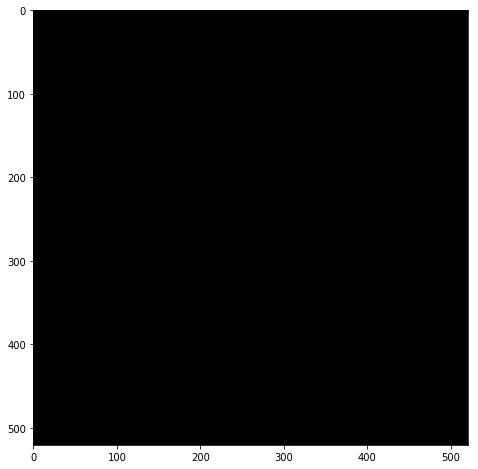

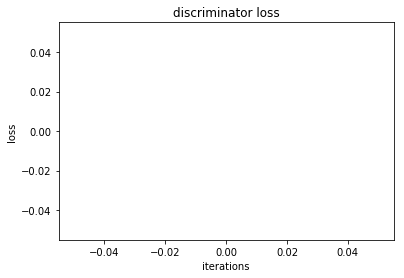

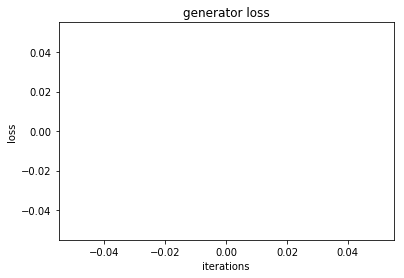

Iteration 129000/611000: dis loss = nan, gen loss = nan
Iteration 129500/611000: dis loss = nan, gen loss = nan
Epoch 211 time is 33.46 [s]
Iteration 130000/611000: dis loss = nan, gen loss = nan
Epoch 212 time is 33.58 [s]
Iteration 130500/611000: dis loss = nan, gen loss = nan
Epoch 213 time is 33.61 [s]
Iteration 131000/611000: dis loss = nan, gen loss = nan
Epoch 214 time is 33.50 [s]
Iteration 131500/611000: dis loss = nan, gen loss = nan
Epoch 215 time is 33.51 [s]


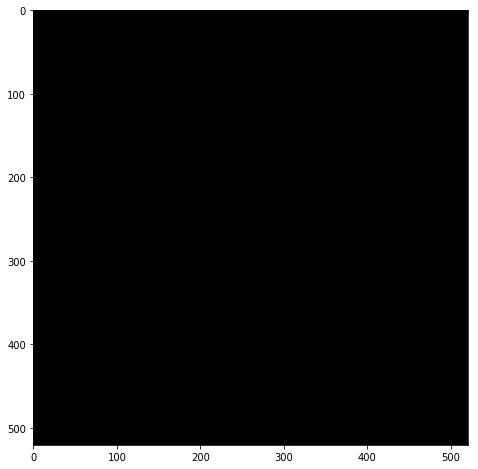

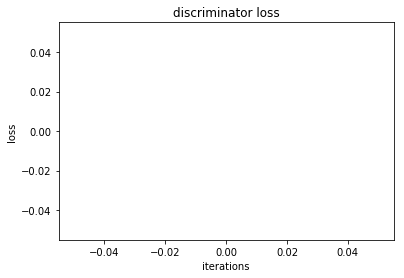

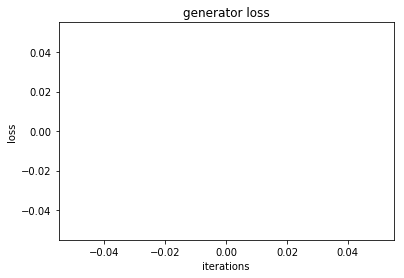

Iteration 132000/611000: dis loss = nan, gen loss = nan
Iteration 132500/611000: dis loss = nan, gen loss = nan
Epoch 216 time is 33.57 [s]
Iteration 133000/611000: dis loss = nan, gen loss = nan
Epoch 217 time is 33.49 [s]
Iteration 133500/611000: dis loss = nan, gen loss = nan
Epoch 218 time is 33.45 [s]
Iteration 134000/611000: dis loss = nan, gen loss = nan
Epoch 219 time is 33.45 [s]
Iteration 134500/611000: dis loss = nan, gen loss = nan
Iteration 135000/611000: dis loss = nan, gen loss = nan
Epoch 220 time is 33.50 [s]


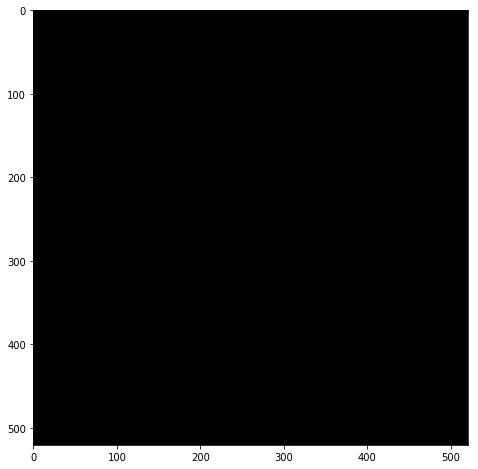

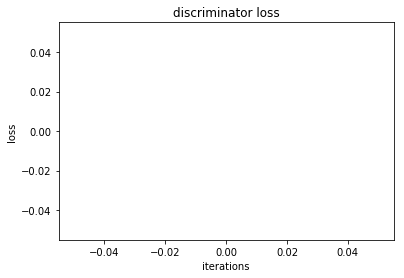

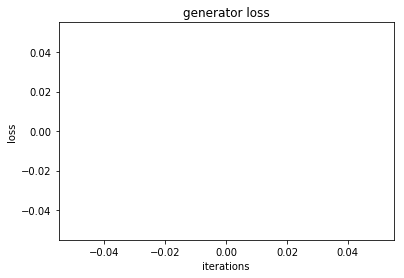

Iteration 135500/611000: dis loss = nan, gen loss = nan
Epoch 221 time is 33.27 [s]
Iteration 136000/611000: dis loss = nan, gen loss = nan
Epoch 222 time is 33.22 [s]
Iteration 136500/611000: dis loss = nan, gen loss = nan
Epoch 223 time is 33.25 [s]
Iteration 137000/611000: dis loss = nan, gen loss = nan
Epoch 224 time is 33.34 [s]
Iteration 137500/611000: dis loss = nan, gen loss = nan
Iteration 138000/611000: dis loss = nan, gen loss = nan
Epoch 225 time is 33.25 [s]


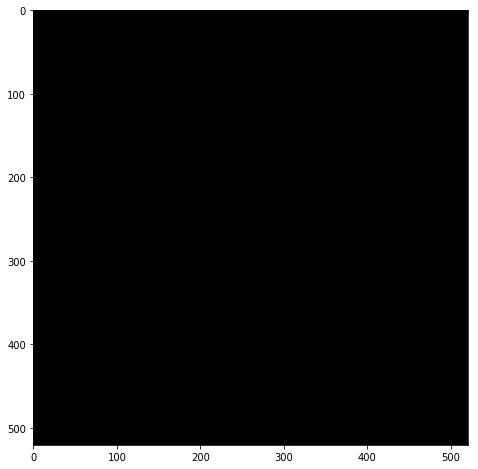

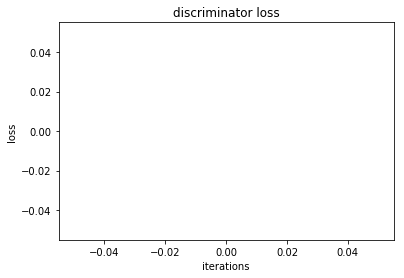

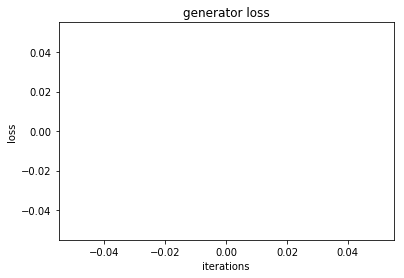

Iteration 138500/611000: dis loss = nan, gen loss = nan
Epoch 226 time is 33.49 [s]
Iteration 139000/611000: dis loss = nan, gen loss = nan
Epoch 227 time is 33.36 [s]
Iteration 139500/611000: dis loss = nan, gen loss = nan
Epoch 228 time is 33.45 [s]
Iteration 140000/611000: dis loss = nan, gen loss = nan
Iteration 140500/611000: dis loss = nan, gen loss = nan
Epoch 229 time is 33.55 [s]
Iteration 141000/611000: dis loss = nan, gen loss = nan
Epoch 230 time is 33.48 [s]


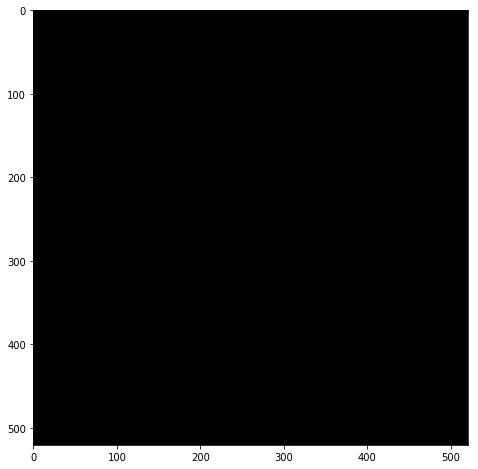

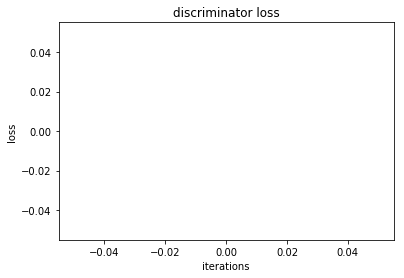

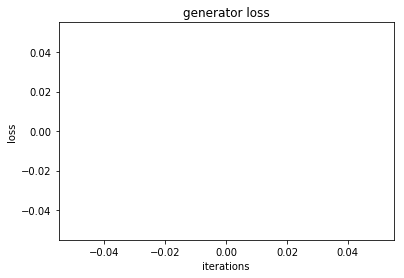

Iteration 141500/611000: dis loss = nan, gen loss = nan
Epoch 231 time is 33.47 [s]
Iteration 142000/611000: dis loss = nan, gen loss = nan
Epoch 232 time is 33.57 [s]
Iteration 142500/611000: dis loss = nan, gen loss = nan
Epoch 233 time is 33.44 [s]
Iteration 143000/611000: dis loss = nan, gen loss = nan
Iteration 143500/611000: dis loss = nan, gen loss = nan
Epoch 234 time is 33.46 [s]
Iteration 144000/611000: dis loss = nan, gen loss = nan
Epoch 235 time is 33.39 [s]


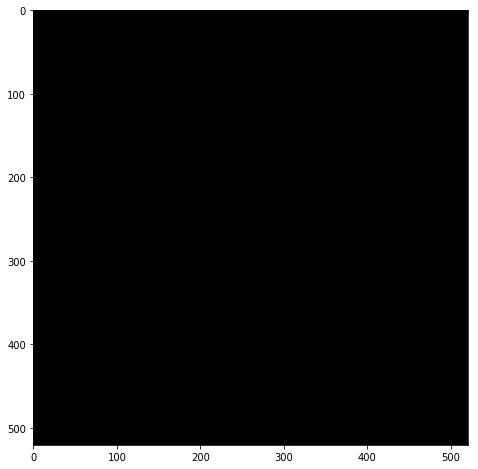

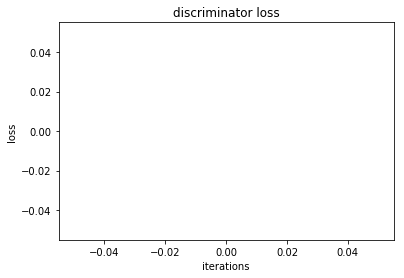

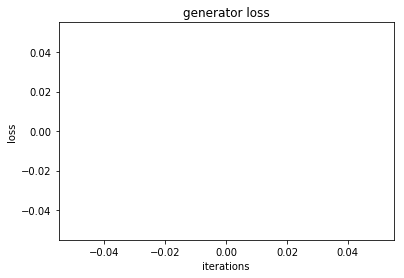

Iteration 144500/611000: dis loss = nan, gen loss = nan
Epoch 236 time is 33.38 [s]
Iteration 145000/611000: dis loss = nan, gen loss = nan
Epoch 237 time is 33.48 [s]
Iteration 145500/611000: dis loss = nan, gen loss = nan
Iteration 146000/611000: dis loss = nan, gen loss = nan
Epoch 238 time is 33.44 [s]
Iteration 146500/611000: dis loss = nan, gen loss = nan
Epoch 239 time is 33.45 [s]
Iteration 147000/611000: dis loss = nan, gen loss = nan
Epoch 240 time is 33.48 [s]


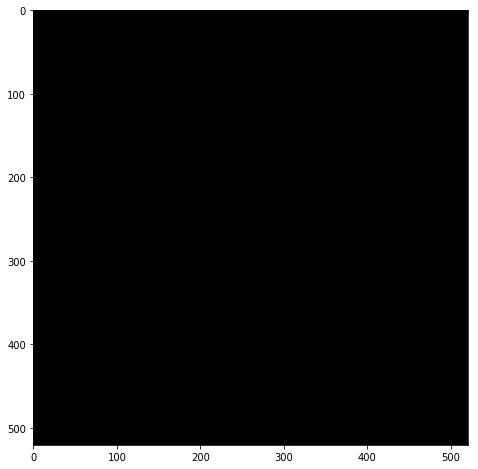

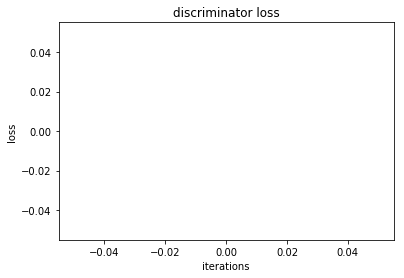

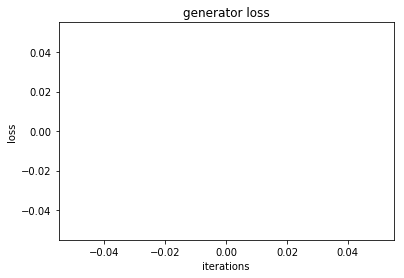

Iteration 147500/611000: dis loss = nan, gen loss = nan
Epoch 241 time is 33.44 [s]
Iteration 148000/611000: dis loss = nan, gen loss = nan
Epoch 242 time is 33.35 [s]
Iteration 148500/611000: dis loss = nan, gen loss = nan
Iteration 149000/611000: dis loss = nan, gen loss = nan
Epoch 243 time is 33.40 [s]
Iteration 149500/611000: dis loss = nan, gen loss = nan
Epoch 244 time is 33.48 [s]
Iteration 150000/611000: dis loss = nan, gen loss = nan
Epoch 245 time is 33.45 [s]


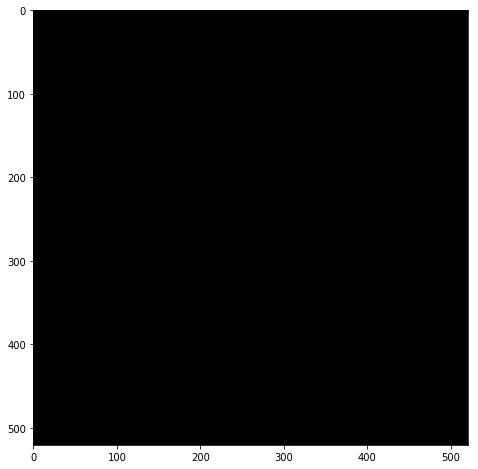

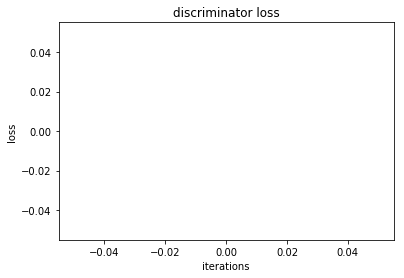

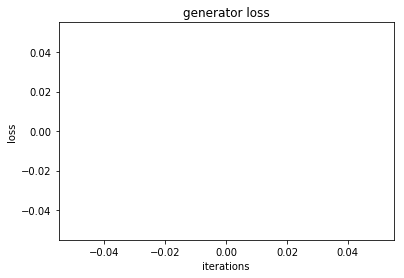

Iteration 150500/611000: dis loss = nan, gen loss = nan
Epoch 246 time is 33.54 [s]
Iteration 151000/611000: dis loss = nan, gen loss = nan
Iteration 151500/611000: dis loss = nan, gen loss = nan
Epoch 247 time is 33.57 [s]
Iteration 152000/611000: dis loss = nan, gen loss = nan
Epoch 248 time is 33.49 [s]
Iteration 152500/611000: dis loss = nan, gen loss = nan
Epoch 249 time is 33.44 [s]
Iteration 153000/611000: dis loss = nan, gen loss = nan
Epoch 250 time is 33.53 [s]


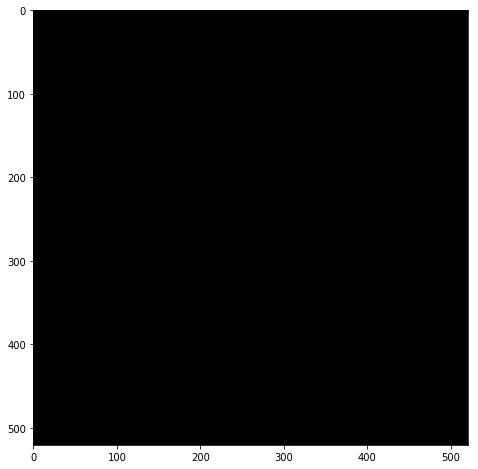

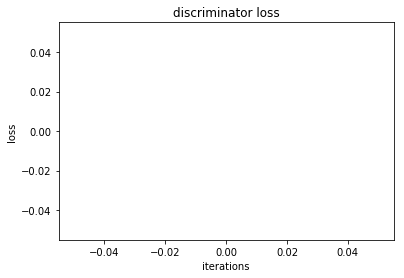

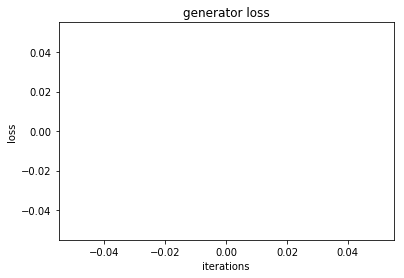

Iteration 153500/611000: dis loss = nan, gen loss = nan
Epoch 251 time is 33.42 [s]
Iteration 154000/611000: dis loss = nan, gen loss = nan
Iteration 154500/611000: dis loss = nan, gen loss = nan
Epoch 252 time is 33.37 [s]
Iteration 155000/611000: dis loss = nan, gen loss = nan
Epoch 253 time is 33.44 [s]
Iteration 155500/611000: dis loss = nan, gen loss = nan
Epoch 254 time is 33.38 [s]
Iteration 156000/611000: dis loss = nan, gen loss = nan
Epoch 255 time is 33.51 [s]


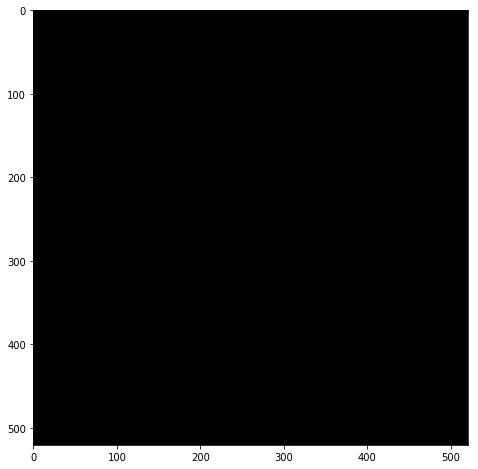

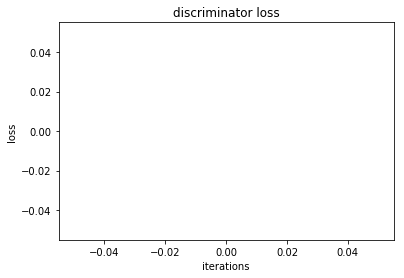

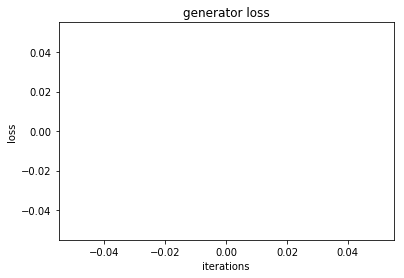

Iteration 156500/611000: dis loss = nan, gen loss = nan
Iteration 157000/611000: dis loss = nan, gen loss = nan
Epoch 256 time is 33.47 [s]
Iteration 157500/611000: dis loss = nan, gen loss = nan
Epoch 257 time is 33.46 [s]
Iteration 158000/611000: dis loss = nan, gen loss = nan
Epoch 258 time is 33.58 [s]
Iteration 158500/611000: dis loss = nan, gen loss = nan
Epoch 259 time is 33.52 [s]
Iteration 159000/611000: dis loss = nan, gen loss = nan
Epoch 260 time is 33.44 [s]


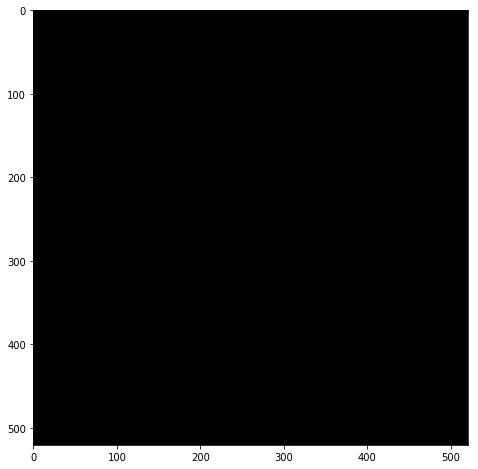

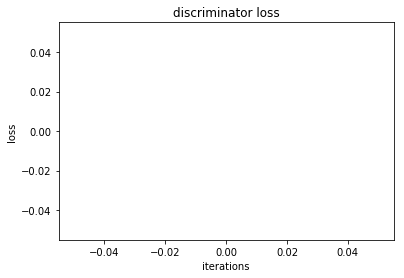

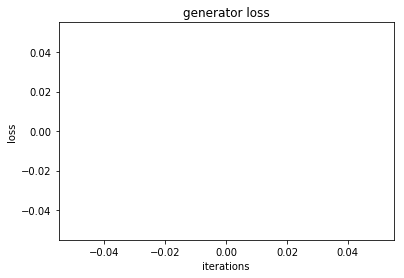

Iteration 159500/611000: dis loss = nan, gen loss = nan
Iteration 160000/611000: dis loss = nan, gen loss = nan
Epoch 261 time is 33.42 [s]
Iteration 160500/611000: dis loss = nan, gen loss = nan
Epoch 262 time is 33.38 [s]
Iteration 161000/611000: dis loss = nan, gen loss = nan
Epoch 263 time is 33.55 [s]
Iteration 161500/611000: dis loss = nan, gen loss = nan
Epoch 264 time is 33.40 [s]
Iteration 162000/611000: dis loss = nan, gen loss = nan
Iteration 162500/611000: dis loss = nan, gen loss = nan
Epoch 265 time is 33.45 [s]


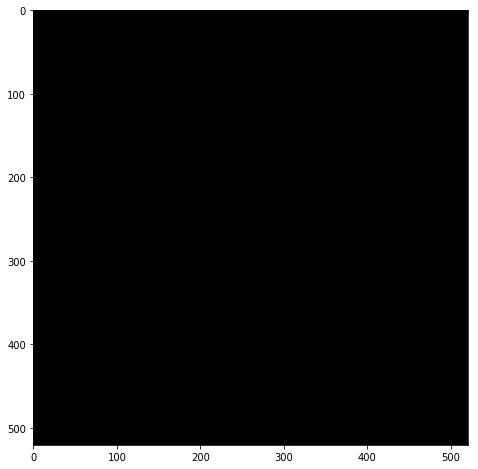

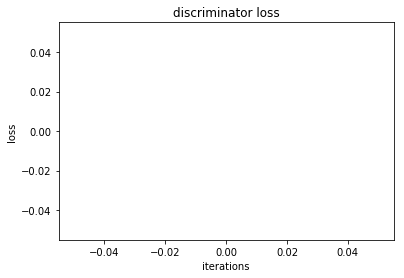

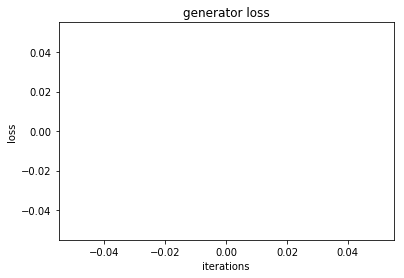

Iteration 163000/611000: dis loss = nan, gen loss = nan
Epoch 266 time is 33.19 [s]
Iteration 163500/611000: dis loss = nan, gen loss = nan
Epoch 267 time is 33.33 [s]
Iteration 164000/611000: dis loss = nan, gen loss = nan
Epoch 268 time is 33.39 [s]
Iteration 164500/611000: dis loss = nan, gen loss = nan
Epoch 269 time is 33.33 [s]
Iteration 165000/611000: dis loss = nan, gen loss = nan
Iteration 165500/611000: dis loss = nan, gen loss = nan
Epoch 270 time is 33.43 [s]


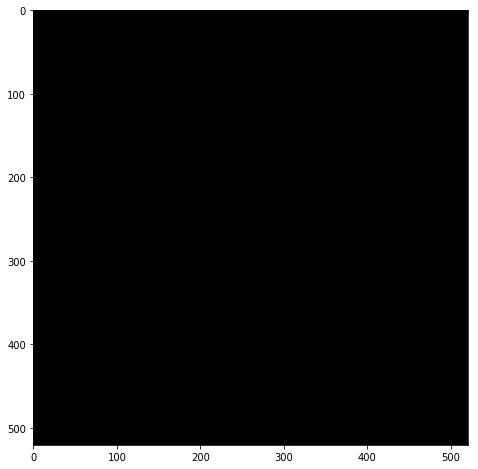

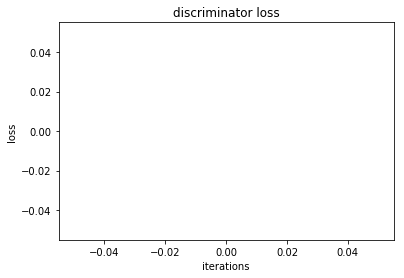

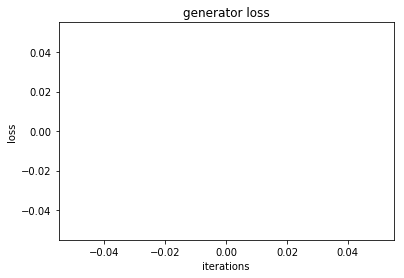

Iteration 166000/611000: dis loss = nan, gen loss = nan
Epoch 271 time is 33.51 [s]
Iteration 166500/611000: dis loss = nan, gen loss = nan
Epoch 272 time is 33.53 [s]
Iteration 167000/611000: dis loss = nan, gen loss = nan
Epoch 273 time is 33.44 [s]
Iteration 167500/611000: dis loss = nan, gen loss = nan
Iteration 168000/611000: dis loss = nan, gen loss = nan
Epoch 274 time is 33.53 [s]
Iteration 168500/611000: dis loss = nan, gen loss = nan
Epoch 275 time is 33.70 [s]


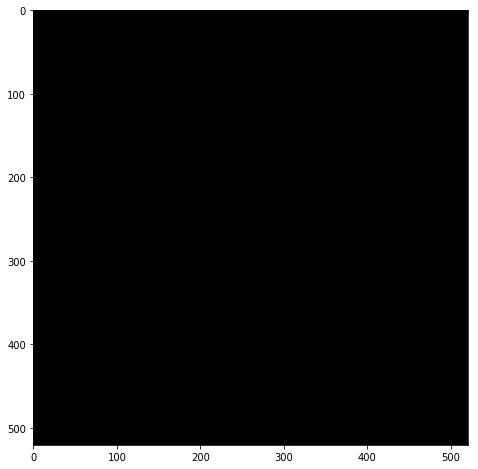

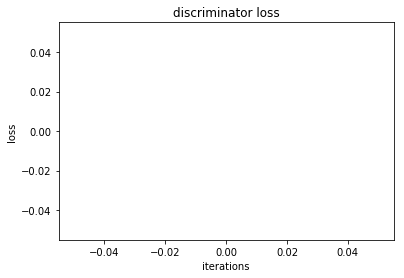

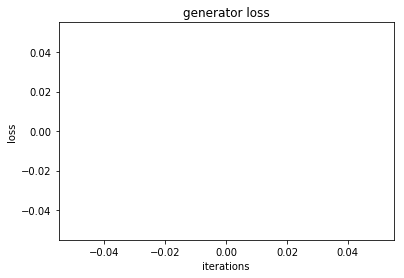

Iteration 169000/611000: dis loss = nan, gen loss = nan
Epoch 276 time is 33.37 [s]
Iteration 169500/611000: dis loss = nan, gen loss = nan
Epoch 277 time is 33.52 [s]
Iteration 170000/611000: dis loss = nan, gen loss = nan
Epoch 278 time is 33.48 [s]
Iteration 170500/611000: dis loss = nan, gen loss = nan
Iteration 171000/611000: dis loss = nan, gen loss = nan
Epoch 279 time is 33.54 [s]
Iteration 171500/611000: dis loss = nan, gen loss = nan
Epoch 280 time is 33.38 [s]


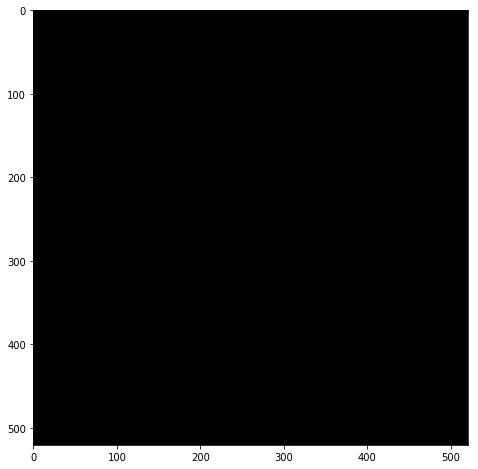

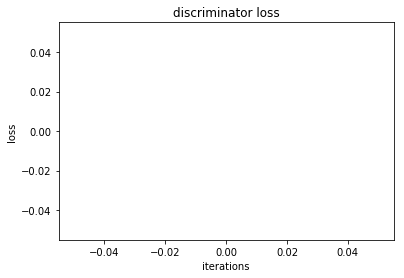

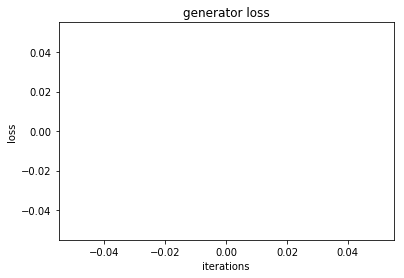

Iteration 172000/611000: dis loss = nan, gen loss = nan
Epoch 281 time is 33.45 [s]
Iteration 172500/611000: dis loss = nan, gen loss = nan
Epoch 282 time is 33.45 [s]
Iteration 173000/611000: dis loss = nan, gen loss = nan
Iteration 173500/611000: dis loss = nan, gen loss = nan
Epoch 283 time is 33.45 [s]
Iteration 174000/611000: dis loss = nan, gen loss = nan
Epoch 284 time is 33.38 [s]
Iteration 174500/611000: dis loss = nan, gen loss = nan
Epoch 285 time is 33.36 [s]


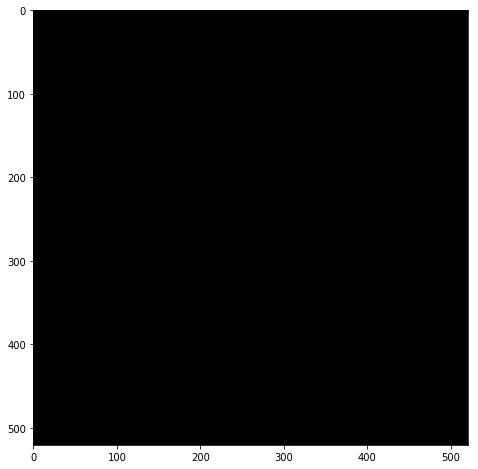

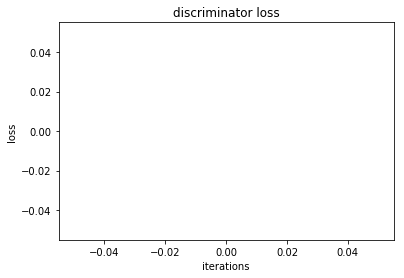

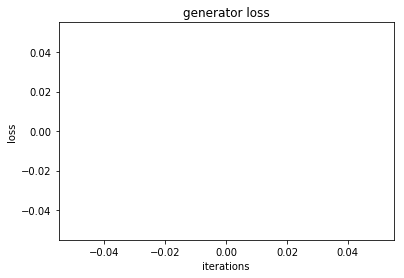

Iteration 175000/611000: dis loss = nan, gen loss = nan
Epoch 286 time is 33.55 [s]
Iteration 175500/611000: dis loss = nan, gen loss = nan
Epoch 287 time is 33.49 [s]
Iteration 176000/611000: dis loss = nan, gen loss = nan
Iteration 176500/611000: dis loss = nan, gen loss = nan
Epoch 288 time is 33.36 [s]
Iteration 177000/611000: dis loss = nan, gen loss = nan
Epoch 289 time is 33.37 [s]
Iteration 177500/611000: dis loss = nan, gen loss = nan
Epoch 290 time is 33.37 [s]


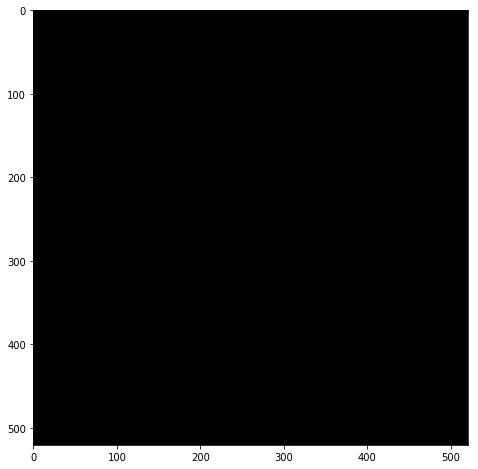

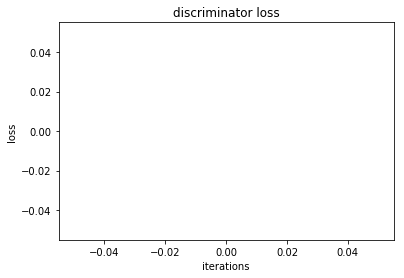

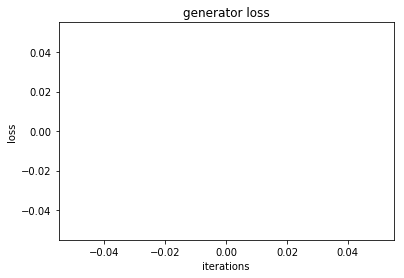

Iteration 178000/611000: dis loss = nan, gen loss = nan
Epoch 291 time is 33.43 [s]
Iteration 178500/611000: dis loss = nan, gen loss = nan
Iteration 179000/611000: dis loss = nan, gen loss = nan
Epoch 292 time is 33.38 [s]
Iteration 179500/611000: dis loss = nan, gen loss = nan
Epoch 293 time is 33.54 [s]
Iteration 180000/611000: dis loss = nan, gen loss = nan
Epoch 294 time is 33.44 [s]
Iteration 180500/611000: dis loss = nan, gen loss = nan
Epoch 295 time is 33.57 [s]


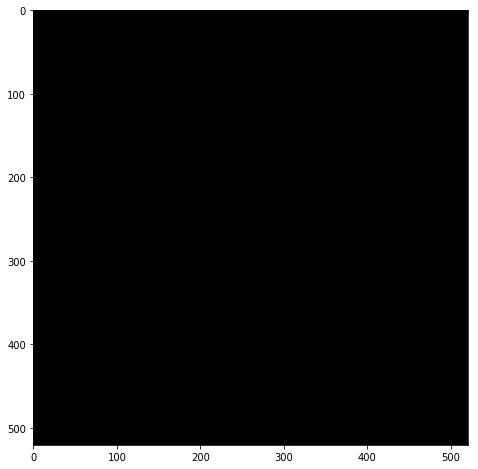

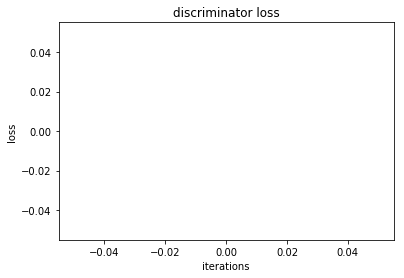

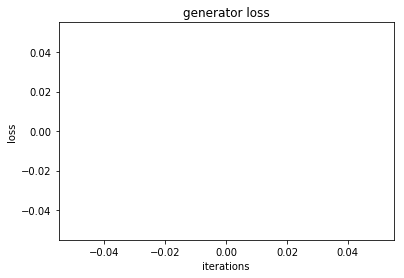

Iteration 181000/611000: dis loss = nan, gen loss = nan
Epoch 296 time is 33.45 [s]
Iteration 181500/611000: dis loss = nan, gen loss = nan
Iteration 182000/611000: dis loss = nan, gen loss = nan
Epoch 297 time is 33.45 [s]
Iteration 182500/611000: dis loss = nan, gen loss = nan
Epoch 298 time is 33.34 [s]
Iteration 183000/611000: dis loss = nan, gen loss = nan
Epoch 299 time is 33.34 [s]
Iteration 183500/611000: dis loss = nan, gen loss = nan
Epoch 300 time is 33.59 [s]


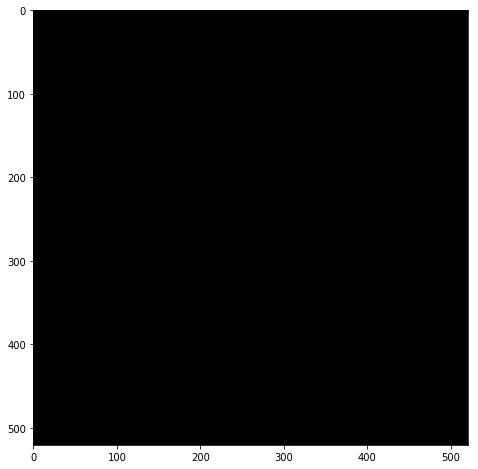

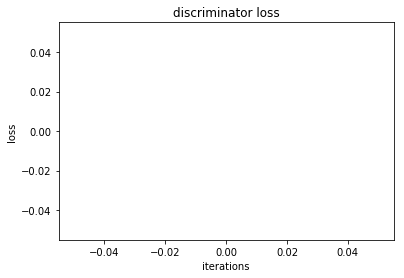

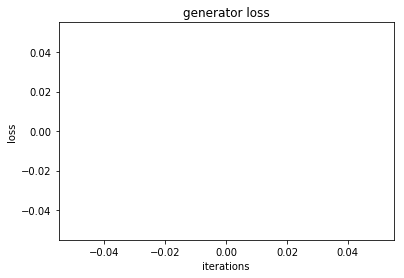

Iteration 184000/611000: dis loss = nan, gen loss = nan
Iteration 184500/611000: dis loss = nan, gen loss = nan
Epoch 301 time is 33.51 [s]
Iteration 185000/611000: dis loss = nan, gen loss = nan
Epoch 302 time is 33.52 [s]
Iteration 185500/611000: dis loss = nan, gen loss = nan
Epoch 303 time is 33.53 [s]
Iteration 186000/611000: dis loss = nan, gen loss = nan
Epoch 304 time is 33.55 [s]
Iteration 186500/611000: dis loss = nan, gen loss = nan
Epoch 305 time is 33.62 [s]


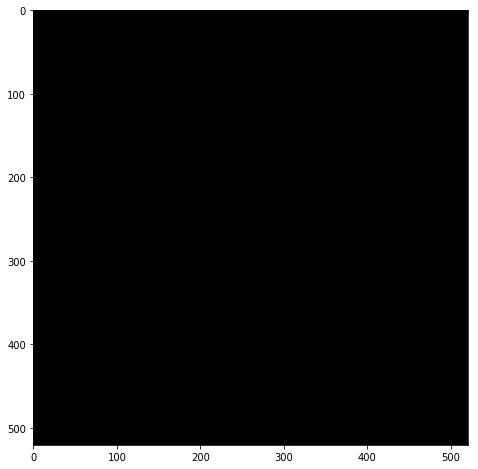

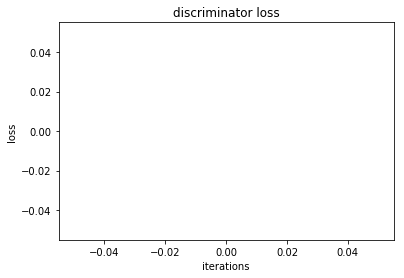

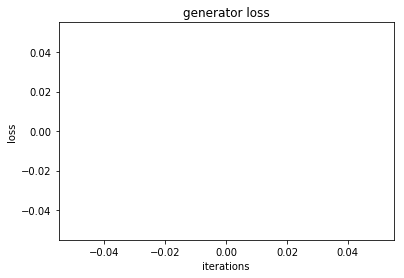

Iteration 187000/611000: dis loss = nan, gen loss = nan
Iteration 187500/611000: dis loss = nan, gen loss = nan
Epoch 306 time is 33.54 [s]
Iteration 188000/611000: dis loss = nan, gen loss = nan
Epoch 307 time is 33.55 [s]
Iteration 188500/611000: dis loss = nan, gen loss = nan
Epoch 308 time is 33.46 [s]
Iteration 189000/611000: dis loss = nan, gen loss = nan
Epoch 309 time is 33.55 [s]
Iteration 189500/611000: dis loss = nan, gen loss = nan
Iteration 190000/611000: dis loss = nan, gen loss = nan
Epoch 310 time is 33.50 [s]


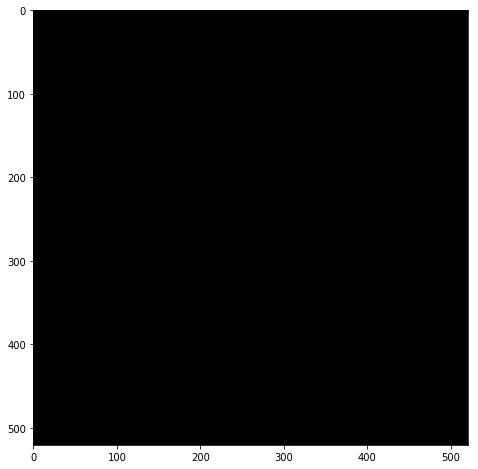

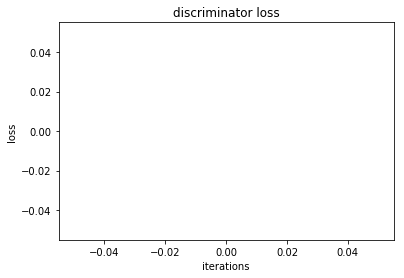

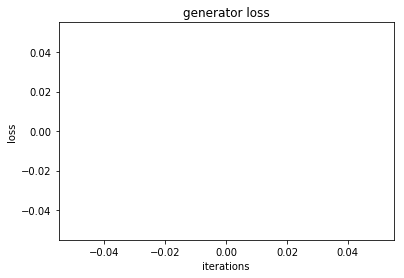

Iteration 190500/611000: dis loss = nan, gen loss = nan
Epoch 311 time is 33.39 [s]
Iteration 191000/611000: dis loss = nan, gen loss = nan
Epoch 312 time is 33.47 [s]
Iteration 191500/611000: dis loss = nan, gen loss = nan
Epoch 313 time is 33.56 [s]
Iteration 192000/611000: dis loss = nan, gen loss = nan
Epoch 314 time is 33.31 [s]
Iteration 192500/611000: dis loss = nan, gen loss = nan
Iteration 193000/611000: dis loss = nan, gen loss = nan
Epoch 315 time is 33.44 [s]


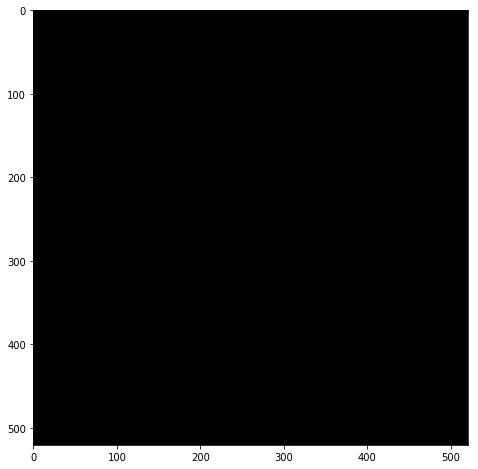

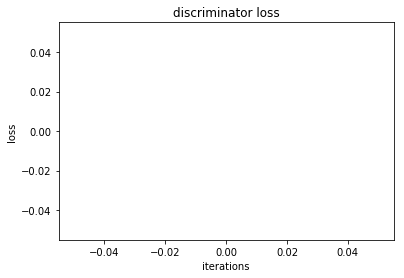

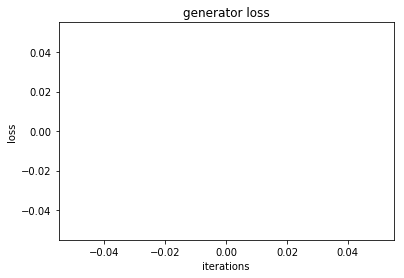

Iteration 193500/611000: dis loss = nan, gen loss = nan
Epoch 316 time is 33.63 [s]
Iteration 194000/611000: dis loss = nan, gen loss = nan
Epoch 317 time is 33.52 [s]
Iteration 194500/611000: dis loss = nan, gen loss = nan
Epoch 318 time is 33.60 [s]
Iteration 195000/611000: dis loss = nan, gen loss = nan
Iteration 195500/611000: dis loss = nan, gen loss = nan
Epoch 319 time is 33.54 [s]
Iteration 196000/611000: dis loss = nan, gen loss = nan
Epoch 320 time is 33.58 [s]


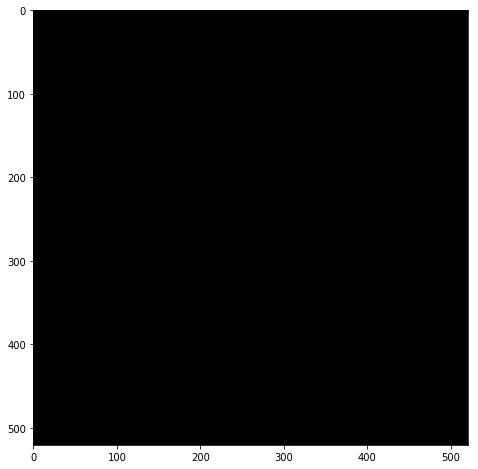

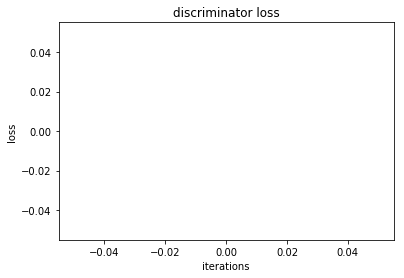

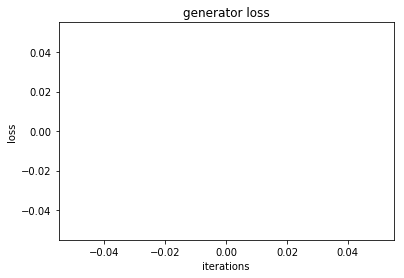

Iteration 196500/611000: dis loss = nan, gen loss = nan
Epoch 321 time is 33.46 [s]
Iteration 197000/611000: dis loss = nan, gen loss = nan
Epoch 322 time is 33.54 [s]
Iteration 197500/611000: dis loss = nan, gen loss = nan
Epoch 323 time is 33.43 [s]
Iteration 198000/611000: dis loss = nan, gen loss = nan
Iteration 198500/611000: dis loss = nan, gen loss = nan
Epoch 324 time is 33.38 [s]
Iteration 199000/611000: dis loss = nan, gen loss = nan
Epoch 325 time is 33.53 [s]


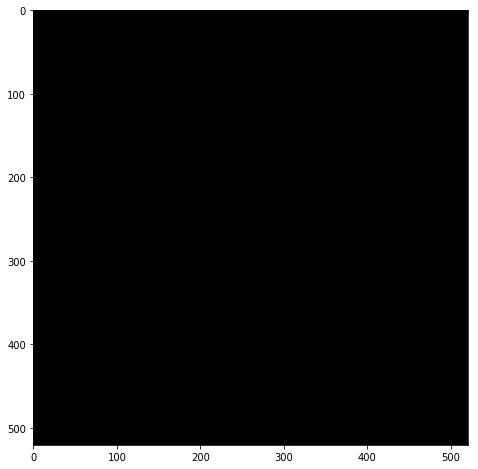

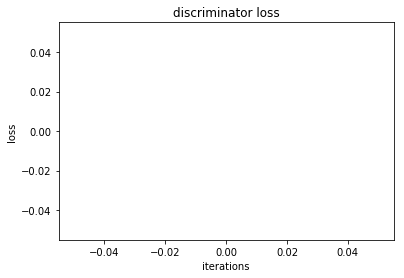

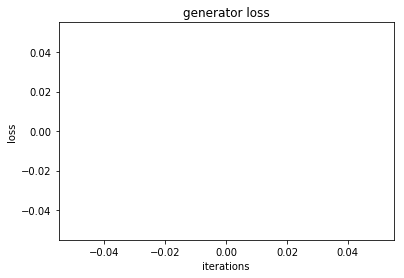

Iteration 199500/611000: dis loss = nan, gen loss = nan
Epoch 326 time is 33.34 [s]
Iteration 200000/611000: dis loss = nan, gen loss = nan
Epoch 327 time is 33.29 [s]
Iteration 200500/611000: dis loss = nan, gen loss = nan
Iteration 201000/611000: dis loss = nan, gen loss = nan
Epoch 328 time is 33.37 [s]
Iteration 201500/611000: dis loss = nan, gen loss = nan
Epoch 329 time is 33.36 [s]
Iteration 202000/611000: dis loss = nan, gen loss = nan
Epoch 330 time is 33.32 [s]


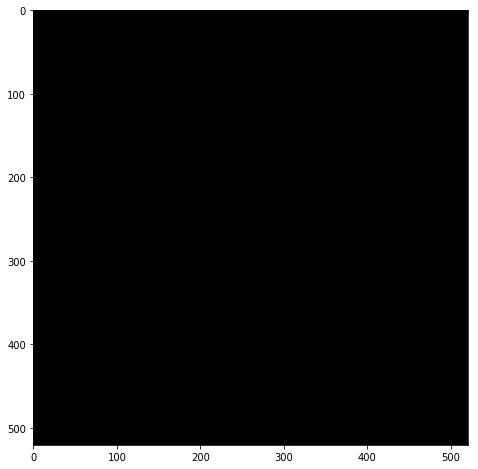

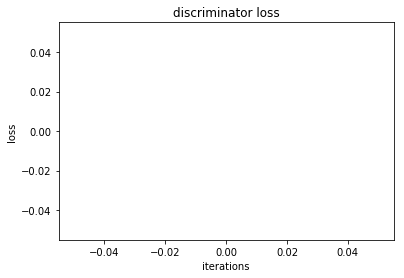

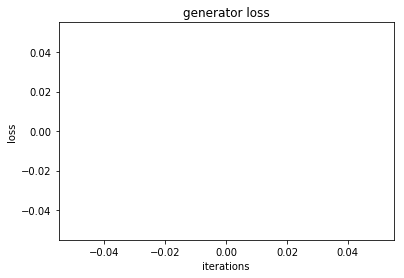

Iteration 202500/611000: dis loss = nan, gen loss = nan
Epoch 331 time is 33.39 [s]
Iteration 203000/611000: dis loss = nan, gen loss = nan
Epoch 332 time is 33.48 [s]
Iteration 203500/611000: dis loss = nan, gen loss = nan
Iteration 204000/611000: dis loss = nan, gen loss = nan
Epoch 333 time is 33.48 [s]
Iteration 204500/611000: dis loss = nan, gen loss = nan
Epoch 334 time is 33.52 [s]
Iteration 205000/611000: dis loss = nan, gen loss = nan
Epoch 335 time is 33.40 [s]


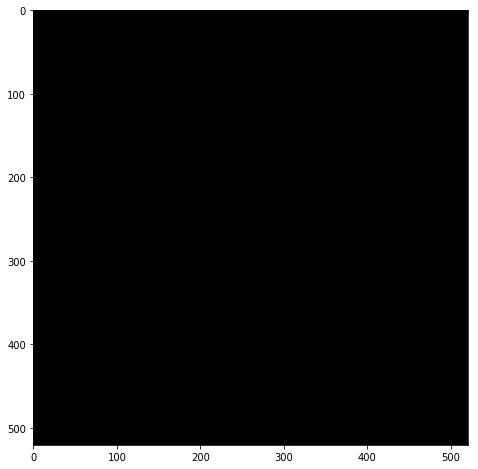

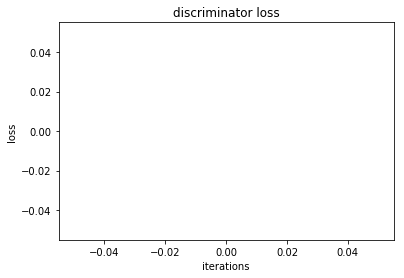

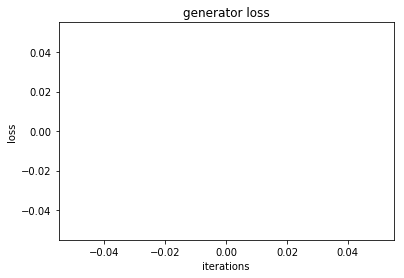

Iteration 205500/611000: dis loss = nan, gen loss = nan
Epoch 336 time is 33.47 [s]
Iteration 206000/611000: dis loss = nan, gen loss = nan
Iteration 206500/611000: dis loss = nan, gen loss = nan
Epoch 337 time is 33.52 [s]
Iteration 207000/611000: dis loss = nan, gen loss = nan
Epoch 338 time is 33.59 [s]
Iteration 207500/611000: dis loss = nan, gen loss = nan
Epoch 339 time is 33.50 [s]
Iteration 208000/611000: dis loss = nan, gen loss = nan
Epoch 340 time is 33.59 [s]


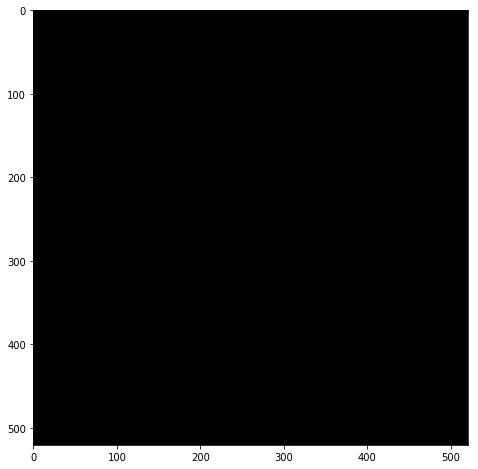

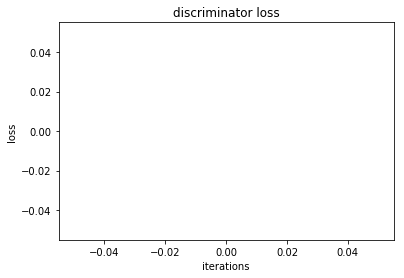

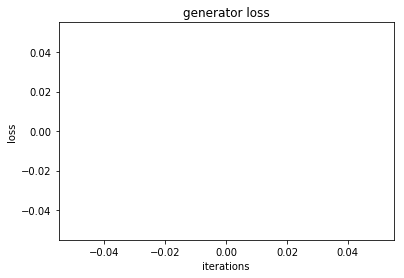

Iteration 208500/611000: dis loss = nan, gen loss = nan
Epoch 341 time is 33.39 [s]
Iteration 209000/611000: dis loss = nan, gen loss = nan
Iteration 209500/611000: dis loss = nan, gen loss = nan
Epoch 342 time is 33.52 [s]
Iteration 210000/611000: dis loss = nan, gen loss = nan
Epoch 343 time is 33.44 [s]
Iteration 210500/611000: dis loss = nan, gen loss = nan
Epoch 344 time is 33.41 [s]
Iteration 211000/611000: dis loss = nan, gen loss = nan
Epoch 345 time is 33.53 [s]


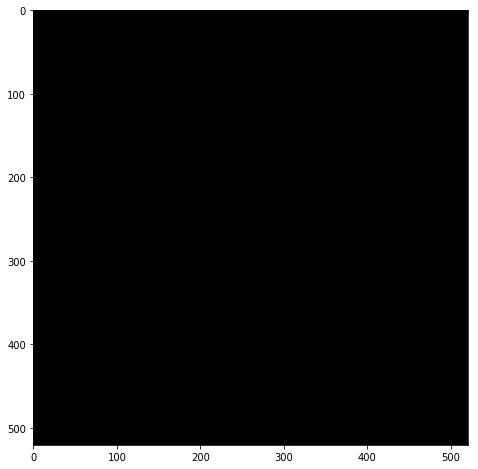

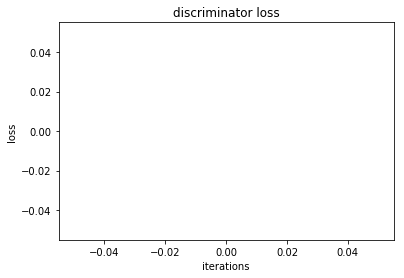

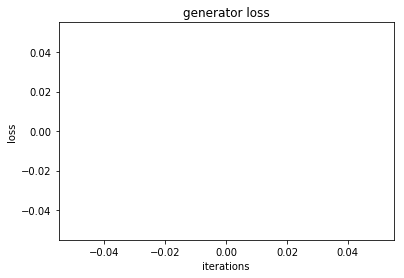

Iteration 211500/611000: dis loss = nan, gen loss = nan
Iteration 212000/611000: dis loss = nan, gen loss = nan
Epoch 346 time is 33.50 [s]
Iteration 212500/611000: dis loss = nan, gen loss = nan
Epoch 347 time is 33.61 [s]
Iteration 213000/611000: dis loss = nan, gen loss = nan
Epoch 348 time is 33.34 [s]
Iteration 213500/611000: dis loss = nan, gen loss = nan
Epoch 349 time is 33.50 [s]
Iteration 214000/611000: dis loss = nan, gen loss = nan
Epoch 350 time is 33.45 [s]


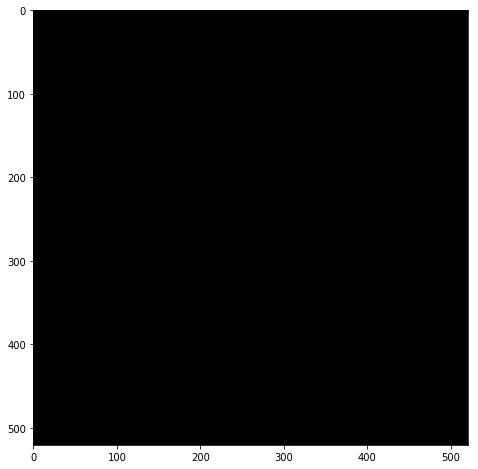

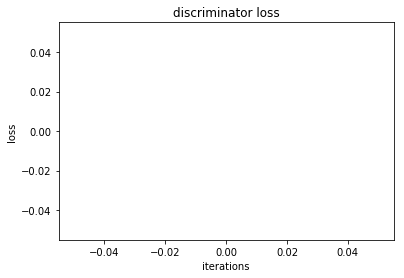

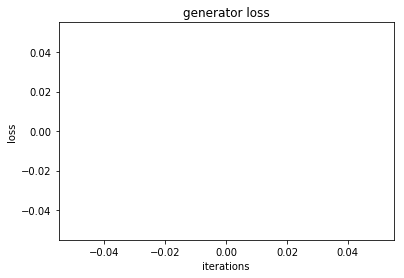

Iteration 214500/611000: dis loss = nan, gen loss = nan
Iteration 215000/611000: dis loss = nan, gen loss = nan
Epoch 351 time is 33.48 [s]
Iteration 215500/611000: dis loss = nan, gen loss = nan
Epoch 352 time is 33.56 [s]
Iteration 216000/611000: dis loss = nan, gen loss = nan
Epoch 353 time is 33.49 [s]
Iteration 216500/611000: dis loss = nan, gen loss = nan
Epoch 354 time is 33.61 [s]
Iteration 217000/611000: dis loss = nan, gen loss = nan
Iteration 217500/611000: dis loss = nan, gen loss = nan
Epoch 355 time is 33.53 [s]


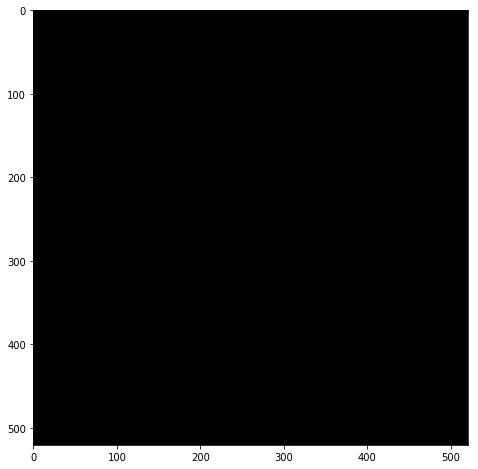

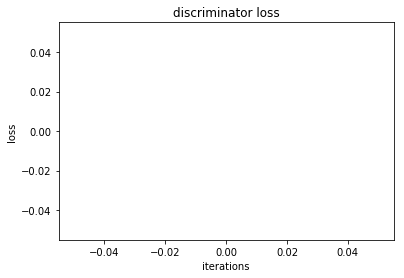

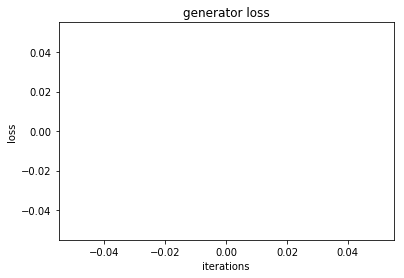

Iteration 218000/611000: dis loss = nan, gen loss = nan
Epoch 356 time is 33.42 [s]
Iteration 218500/611000: dis loss = nan, gen loss = nan
Epoch 357 time is 33.59 [s]
Iteration 219000/611000: dis loss = nan, gen loss = nan
Epoch 358 time is 33.64 [s]
Iteration 219500/611000: dis loss = nan, gen loss = nan
Epoch 359 time is 33.48 [s]
Iteration 220000/611000: dis loss = nan, gen loss = nan
Iteration 220500/611000: dis loss = nan, gen loss = nan
Epoch 360 time is 33.47 [s]


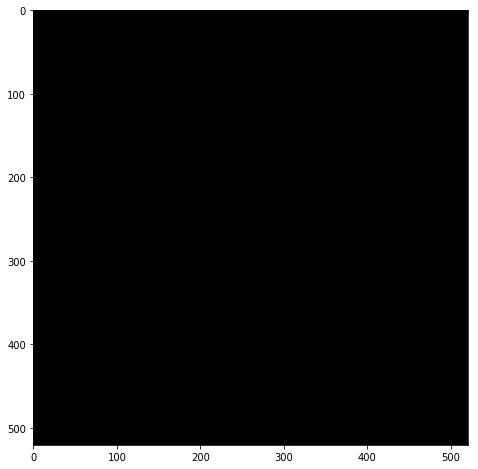

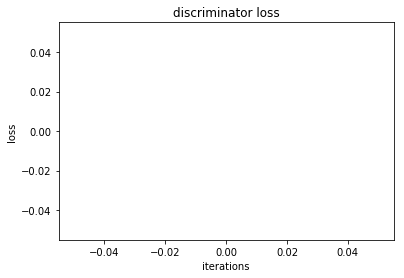

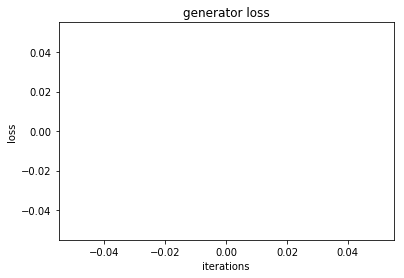

Iteration 221000/611000: dis loss = nan, gen loss = nan
Epoch 361 time is 33.39 [s]
Iteration 221500/611000: dis loss = nan, gen loss = nan
Epoch 362 time is 33.51 [s]
Iteration 222000/611000: dis loss = nan, gen loss = nan
Epoch 363 time is 33.36 [s]
Iteration 222500/611000: dis loss = nan, gen loss = nan
Iteration 223000/611000: dis loss = nan, gen loss = nan
Epoch 364 time is 33.50 [s]
Iteration 223500/611000: dis loss = nan, gen loss = nan
Epoch 365 time is 33.48 [s]


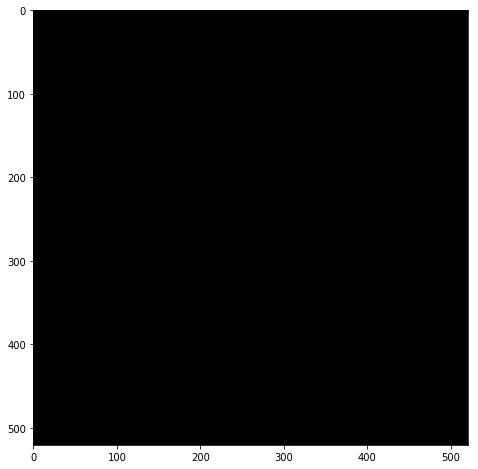

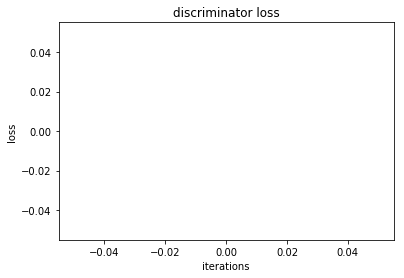

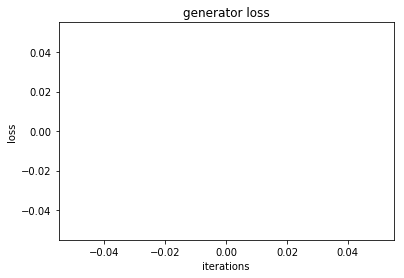

Iteration 224000/611000: dis loss = nan, gen loss = nan
Epoch 366 time is 33.40 [s]
Iteration 224500/611000: dis loss = nan, gen loss = nan
Epoch 367 time is 33.53 [s]
Iteration 225000/611000: dis loss = nan, gen loss = nan
Epoch 368 time is 33.53 [s]
Iteration 225500/611000: dis loss = nan, gen loss = nan
Iteration 226000/611000: dis loss = nan, gen loss = nan
Epoch 369 time is 33.50 [s]
Iteration 226500/611000: dis loss = nan, gen loss = nan
Epoch 370 time is 33.43 [s]


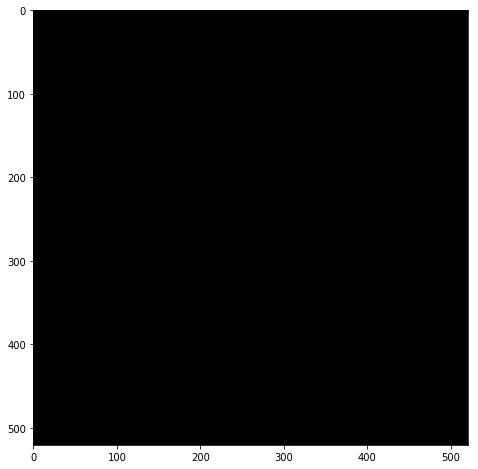

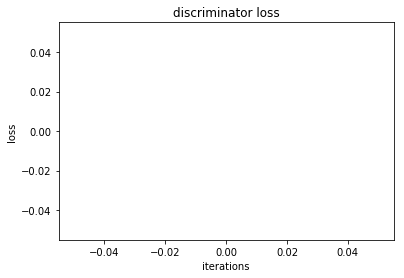

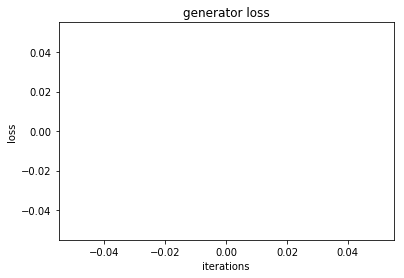

Iteration 227000/611000: dis loss = nan, gen loss = nan
Epoch 371 time is 33.38 [s]
Iteration 227500/611000: dis loss = nan, gen loss = nan
Epoch 372 time is 33.49 [s]
Iteration 228000/611000: dis loss = nan, gen loss = nan
Iteration 228500/611000: dis loss = nan, gen loss = nan
Epoch 373 time is 33.41 [s]
Iteration 229000/611000: dis loss = nan, gen loss = nan
Epoch 374 time is 33.52 [s]
Iteration 229500/611000: dis loss = nan, gen loss = nan
Epoch 375 time is 33.41 [s]


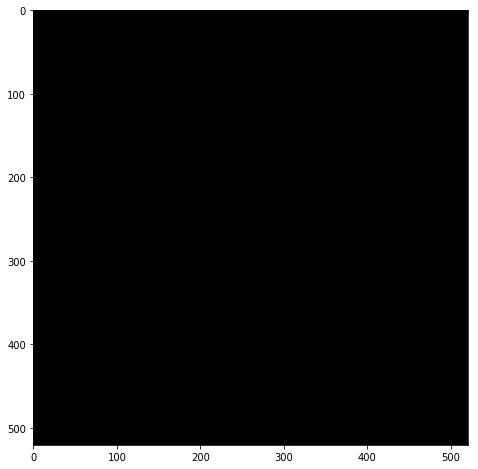

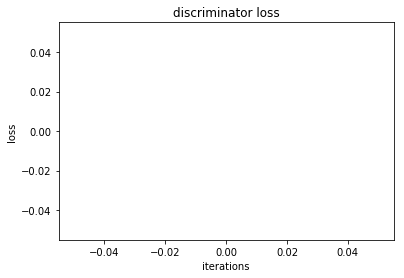

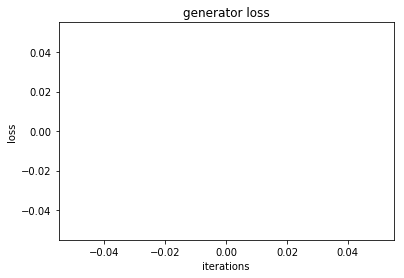

Iteration 230000/611000: dis loss = nan, gen loss = nan
Epoch 376 time is 33.27 [s]
Iteration 230500/611000: dis loss = nan, gen loss = nan
Epoch 377 time is 33.36 [s]
Iteration 231000/611000: dis loss = nan, gen loss = nan
Iteration 231500/611000: dis loss = nan, gen loss = nan
Epoch 378 time is 33.38 [s]
Iteration 232000/611000: dis loss = nan, gen loss = nan
Epoch 379 time is 33.49 [s]
Iteration 232500/611000: dis loss = nan, gen loss = nan
Epoch 380 time is 33.52 [s]


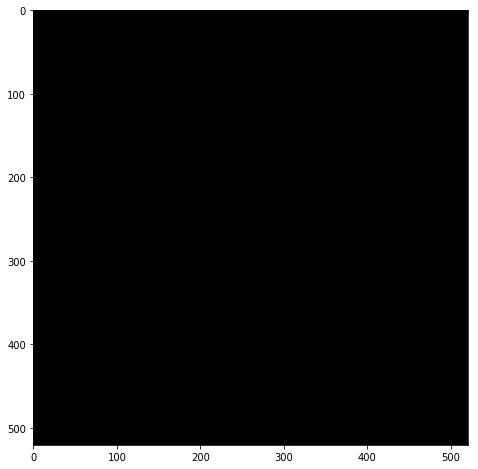

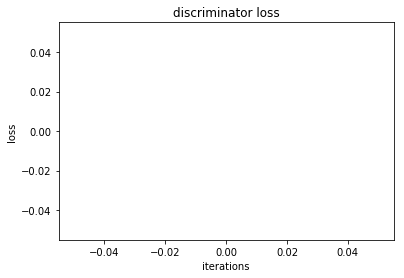

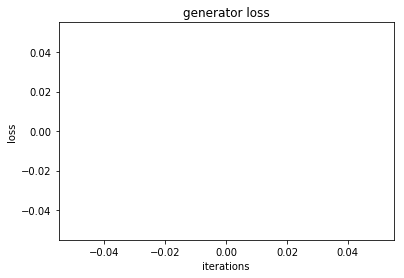

Iteration 233000/611000: dis loss = nan, gen loss = nan
Epoch 381 time is 33.54 [s]
Iteration 233500/611000: dis loss = nan, gen loss = nan
Iteration 234000/611000: dis loss = nan, gen loss = nan
Epoch 382 time is 33.54 [s]
Iteration 234500/611000: dis loss = nan, gen loss = nan
Epoch 383 time is 33.54 [s]
Iteration 235000/611000: dis loss = nan, gen loss = nan
Epoch 384 time is 33.54 [s]
Iteration 235500/611000: dis loss = nan, gen loss = nan
Epoch 385 time is 33.43 [s]


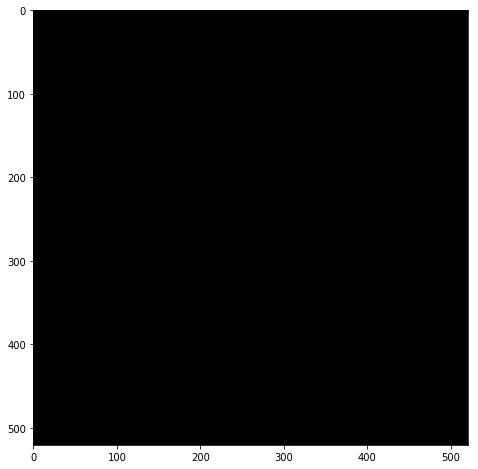

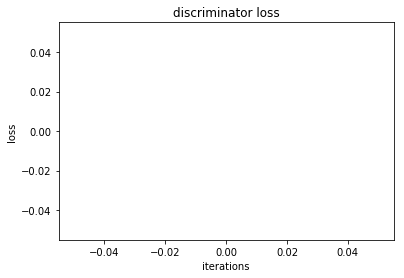

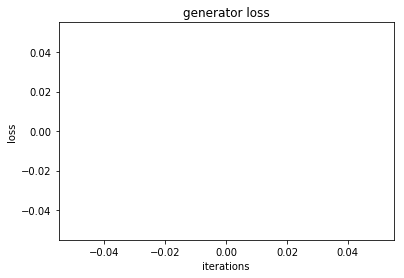

Iteration 236000/611000: dis loss = nan, gen loss = nan
Epoch 386 time is 33.38 [s]
Iteration 236500/611000: dis loss = nan, gen loss = nan
Iteration 237000/611000: dis loss = nan, gen loss = nan
Epoch 387 time is 33.32 [s]
Iteration 237500/611000: dis loss = nan, gen loss = nan
Epoch 388 time is 33.34 [s]
Iteration 238000/611000: dis loss = nan, gen loss = nan
Epoch 389 time is 33.41 [s]
Iteration 238500/611000: dis loss = nan, gen loss = nan
Epoch 390 time is 33.28 [s]


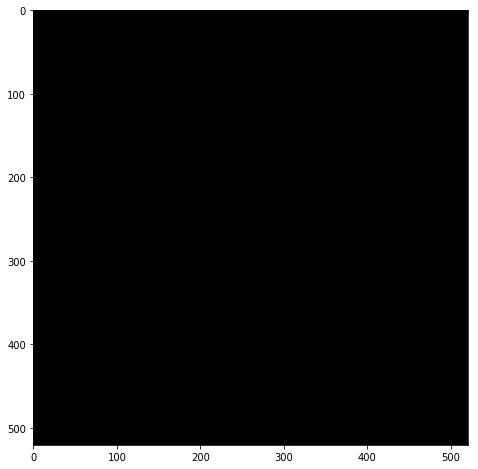

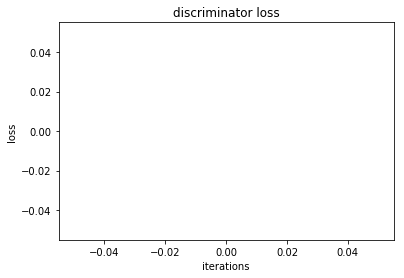

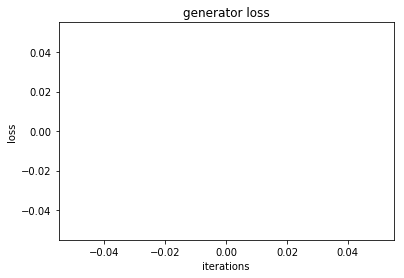

Iteration 239000/611000: dis loss = nan, gen loss = nan
Iteration 239500/611000: dis loss = nan, gen loss = nan
Epoch 391 time is 33.45 [s]
Iteration 240000/611000: dis loss = nan, gen loss = nan
Epoch 392 time is 33.46 [s]
Iteration 240500/611000: dis loss = nan, gen loss = nan
Epoch 393 time is 33.65 [s]
Iteration 241000/611000: dis loss = nan, gen loss = nan
Epoch 394 time is 33.41 [s]
Iteration 241500/611000: dis loss = nan, gen loss = nan
Epoch 395 time is 33.53 [s]


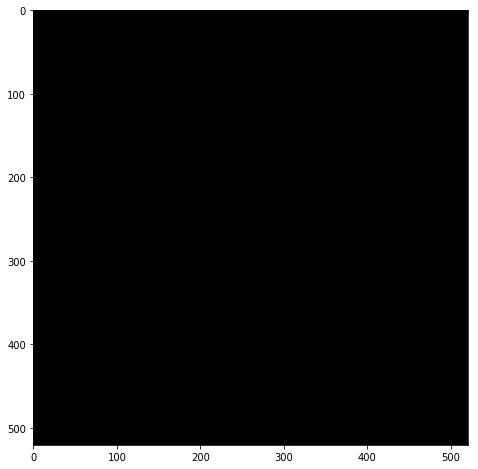

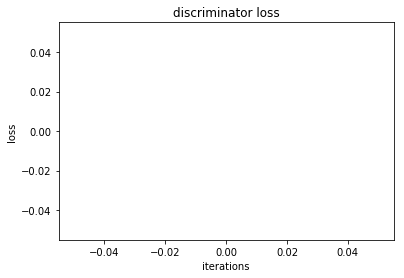

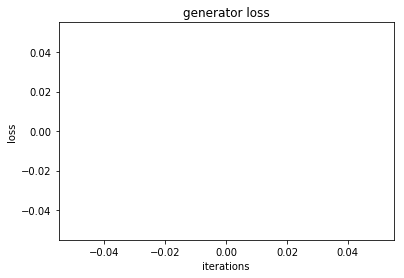

Iteration 242000/611000: dis loss = nan, gen loss = nan
Iteration 242500/611000: dis loss = nan, gen loss = nan
Epoch 396 time is 33.50 [s]
Iteration 243000/611000: dis loss = nan, gen loss = nan
Epoch 397 time is 33.34 [s]
Iteration 243500/611000: dis loss = nan, gen loss = nan
Epoch 398 time is 33.38 [s]
Iteration 244000/611000: dis loss = nan, gen loss = nan
Epoch 399 time is 33.31 [s]
Iteration 244500/611000: dis loss = nan, gen loss = nan
Iteration 245000/611000: dis loss = nan, gen loss = nan
Epoch 400 time is 33.13 [s]


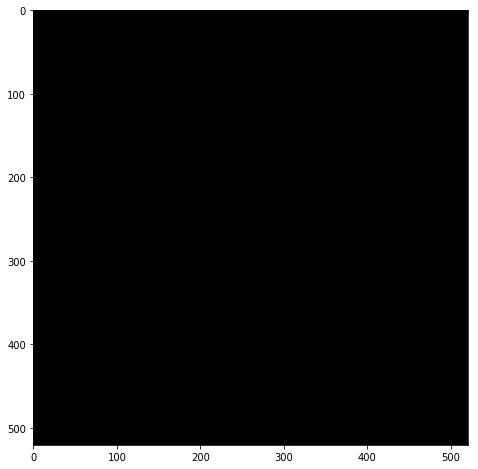

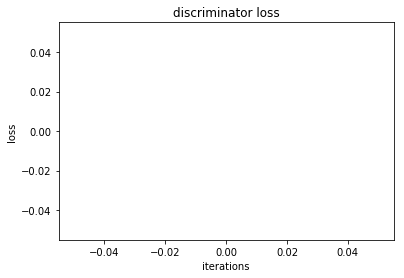

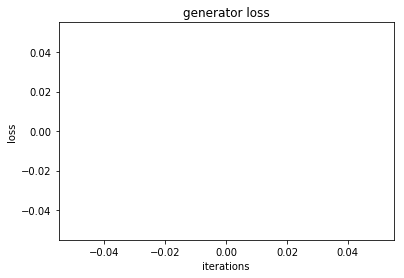

Iteration 245500/611000: dis loss = nan, gen loss = nan
Epoch 401 time is 33.44 [s]
Iteration 246000/611000: dis loss = nan, gen loss = nan
Epoch 402 time is 33.37 [s]
Iteration 246500/611000: dis loss = nan, gen loss = nan
Epoch 403 time is 33.43 [s]
Iteration 247000/611000: dis loss = nan, gen loss = nan
Epoch 404 time is 33.48 [s]
Iteration 247500/611000: dis loss = nan, gen loss = nan
Iteration 248000/611000: dis loss = nan, gen loss = nan
Epoch 405 time is 33.55 [s]


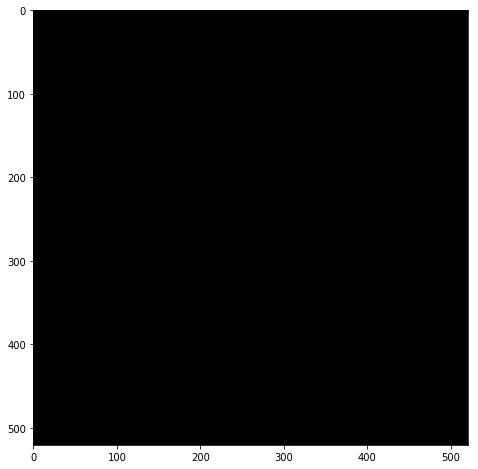

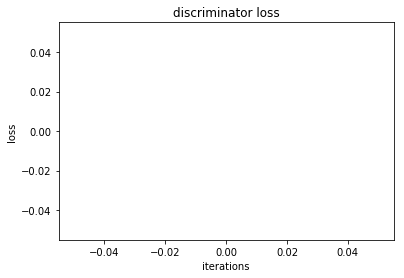

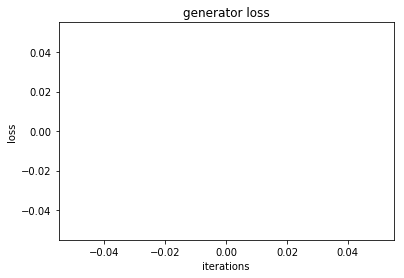

Iteration 248500/611000: dis loss = nan, gen loss = nan
Epoch 406 time is 33.31 [s]
Iteration 249000/611000: dis loss = nan, gen loss = nan
Epoch 407 time is 33.22 [s]
Iteration 249500/611000: dis loss = nan, gen loss = nan
Epoch 408 time is 33.36 [s]
Iteration 250000/611000: dis loss = nan, gen loss = nan
Iteration 250500/611000: dis loss = nan, gen loss = nan
Epoch 409 time is 33.36 [s]
Iteration 251000/611000: dis loss = nan, gen loss = nan
Epoch 410 time is 33.26 [s]


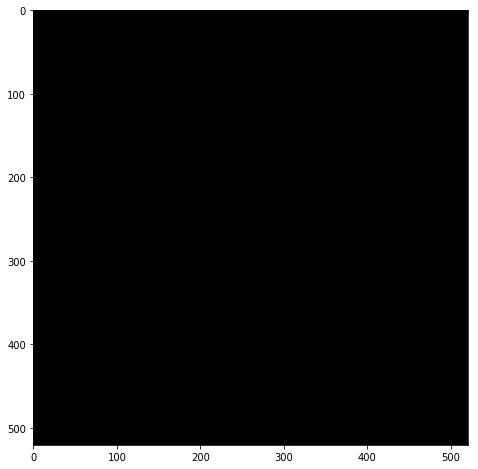

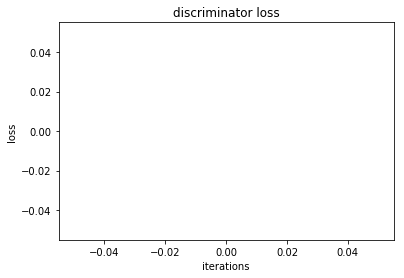

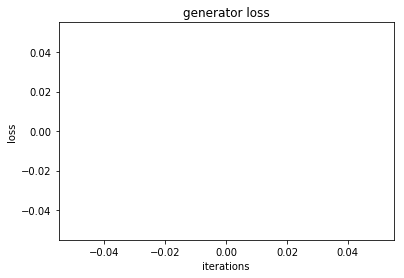

Iteration 251500/611000: dis loss = nan, gen loss = nan
Epoch 411 time is 33.56 [s]
Iteration 252000/611000: dis loss = nan, gen loss = nan
Epoch 412 time is 33.49 [s]
Iteration 252500/611000: dis loss = nan, gen loss = nan
Epoch 413 time is 33.35 [s]
Iteration 253000/611000: dis loss = nan, gen loss = nan
Iteration 253500/611000: dis loss = nan, gen loss = nan
Epoch 414 time is 33.56 [s]
Iteration 254000/611000: dis loss = nan, gen loss = nan
Epoch 415 time is 33.45 [s]


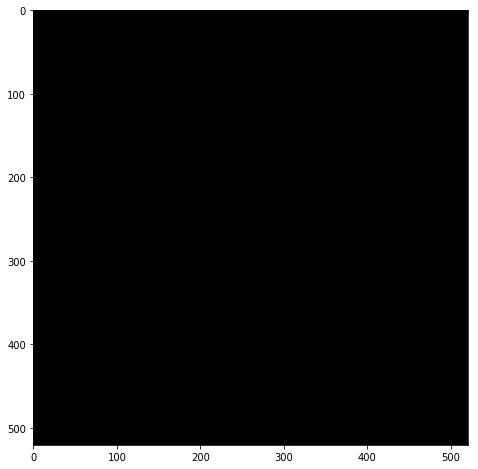

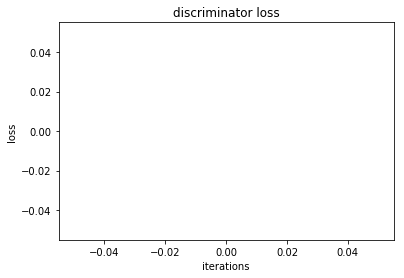

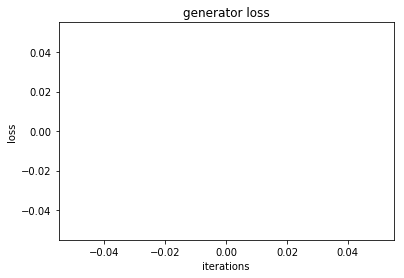

Iteration 254500/611000: dis loss = nan, gen loss = nan
Epoch 416 time is 33.48 [s]
Iteration 255000/611000: dis loss = nan, gen loss = nan
Epoch 417 time is 33.48 [s]
Iteration 255500/611000: dis loss = nan, gen loss = nan
Iteration 256000/611000: dis loss = nan, gen loss = nan
Epoch 418 time is 33.40 [s]
Iteration 256500/611000: dis loss = nan, gen loss = nan
Epoch 419 time is 33.44 [s]
Iteration 257000/611000: dis loss = nan, gen loss = nan
Epoch 420 time is 33.40 [s]


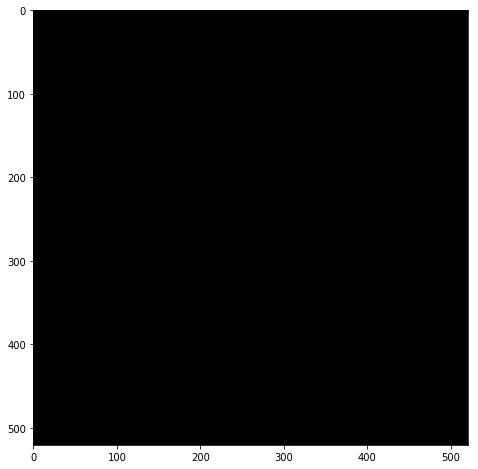

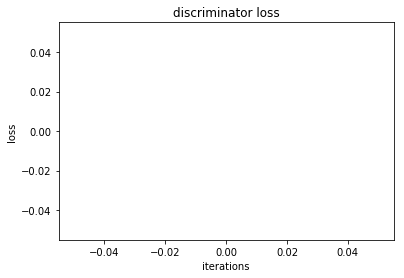

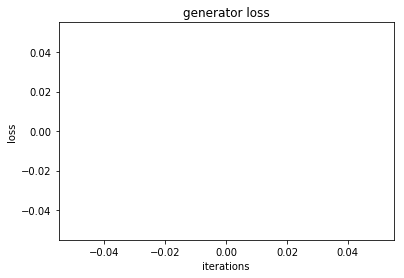

Iteration 257500/611000: dis loss = nan, gen loss = nan
Epoch 421 time is 33.40 [s]
Iteration 258000/611000: dis loss = nan, gen loss = nan
Epoch 422 time is 33.50 [s]
Iteration 258500/611000: dis loss = nan, gen loss = nan
Iteration 259000/611000: dis loss = nan, gen loss = nan
Epoch 423 time is 33.40 [s]
Iteration 259500/611000: dis loss = nan, gen loss = nan
Epoch 424 time is 33.55 [s]
Iteration 260000/611000: dis loss = nan, gen loss = nan
Epoch 425 time is 33.53 [s]


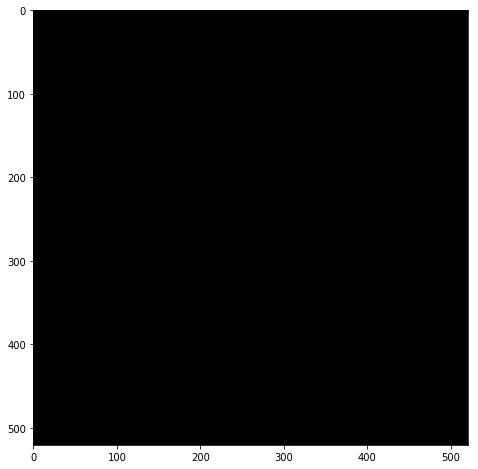

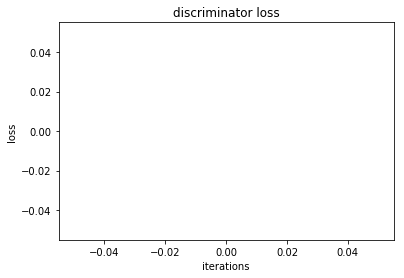

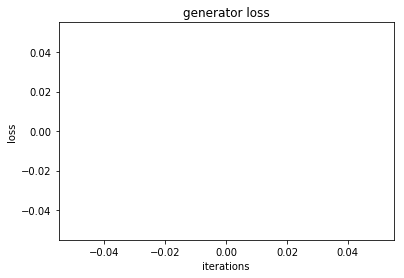

Iteration 260500/611000: dis loss = nan, gen loss = nan
Epoch 426 time is 33.45 [s]
Iteration 261000/611000: dis loss = nan, gen loss = nan
Iteration 261500/611000: dis loss = nan, gen loss = nan
Epoch 427 time is 33.30 [s]
Iteration 262000/611000: dis loss = nan, gen loss = nan
Epoch 428 time is 33.32 [s]
Iteration 262500/611000: dis loss = nan, gen loss = nan
Epoch 429 time is 33.38 [s]
Iteration 263000/611000: dis loss = nan, gen loss = nan
Epoch 430 time is 33.28 [s]


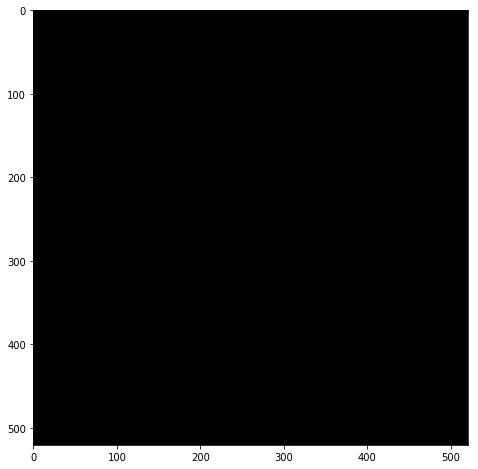

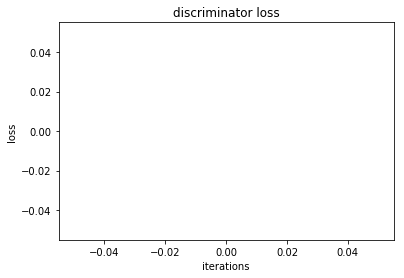

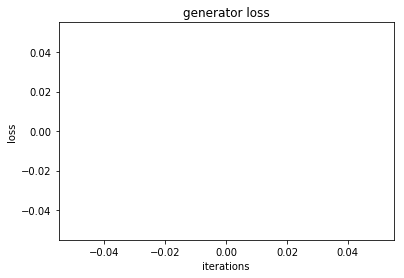

Iteration 263500/611000: dis loss = nan, gen loss = nan
Epoch 431 time is 33.32 [s]
Iteration 264000/611000: dis loss = nan, gen loss = nan
Iteration 264500/611000: dis loss = nan, gen loss = nan
Epoch 432 time is 33.41 [s]
Iteration 265000/611000: dis loss = nan, gen loss = nan
Epoch 433 time is 33.29 [s]
Iteration 265500/611000: dis loss = nan, gen loss = nan
Epoch 434 time is 33.43 [s]
Iteration 266000/611000: dis loss = nan, gen loss = nan
Epoch 435 time is 33.46 [s]


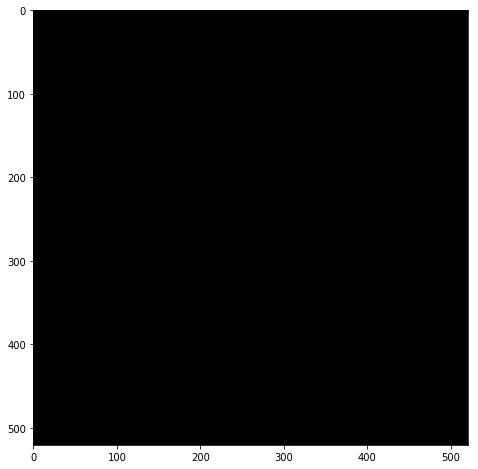

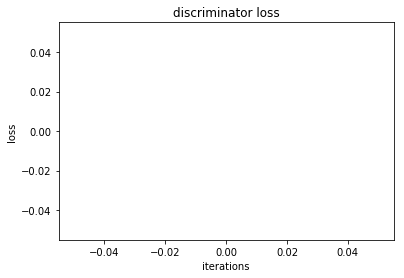

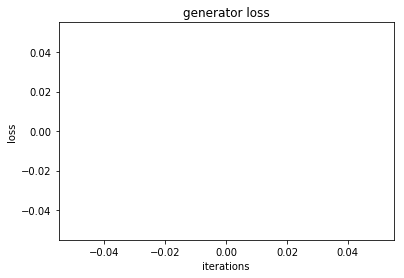

Iteration 266500/611000: dis loss = nan, gen loss = nan
Iteration 267000/611000: dis loss = nan, gen loss = nan
Epoch 436 time is 33.38 [s]
Iteration 267500/611000: dis loss = nan, gen loss = nan
Epoch 437 time is 33.48 [s]
Iteration 268000/611000: dis loss = nan, gen loss = nan
Epoch 438 time is 33.36 [s]
Iteration 268500/611000: dis loss = nan, gen loss = nan
Epoch 439 time is 33.50 [s]
Iteration 269000/611000: dis loss = nan, gen loss = nan
Epoch 440 time is 33.42 [s]


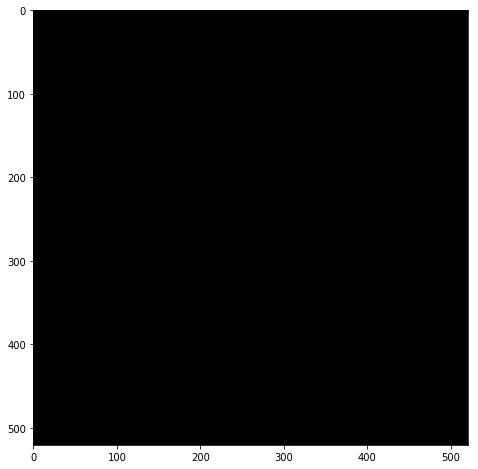

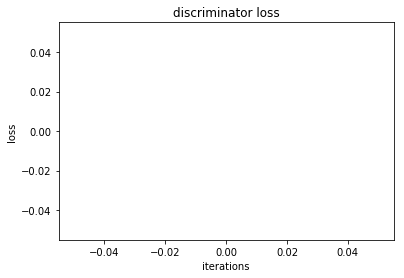

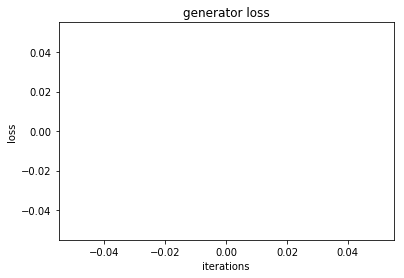

Iteration 269500/611000: dis loss = nan, gen loss = nan
Iteration 270000/611000: dis loss = nan, gen loss = nan
Epoch 441 time is 33.35 [s]
Iteration 270500/611000: dis loss = nan, gen loss = nan
Epoch 442 time is 33.53 [s]
Iteration 271000/611000: dis loss = nan, gen loss = nan
Epoch 443 time is 33.40 [s]
Iteration 271500/611000: dis loss = nan, gen loss = nan
Epoch 444 time is 33.55 [s]
Iteration 272000/611000: dis loss = nan, gen loss = nan
Iteration 272500/611000: dis loss = nan, gen loss = nan
Epoch 445 time is 33.42 [s]


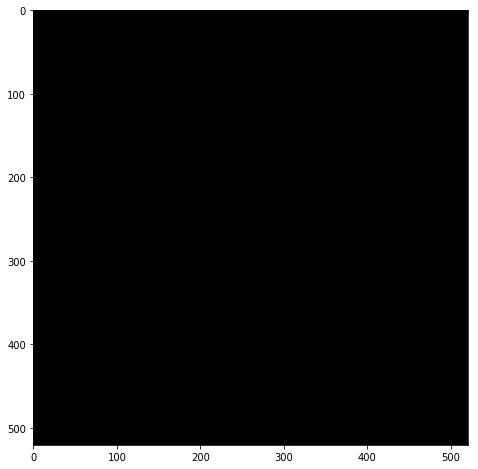

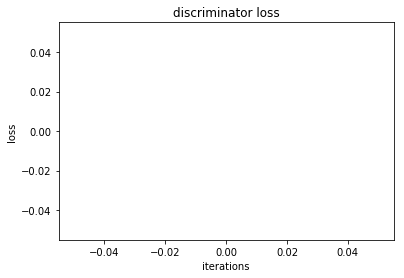

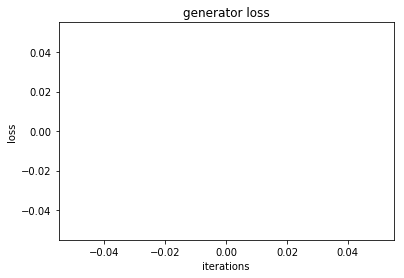

Iteration 273000/611000: dis loss = nan, gen loss = nan
Epoch 446 time is 33.40 [s]
Iteration 273500/611000: dis loss = nan, gen loss = nan
Epoch 447 time is 33.35 [s]
Iteration 274000/611000: dis loss = nan, gen loss = nan
Epoch 448 time is 33.34 [s]
Iteration 274500/611000: dis loss = nan, gen loss = nan
Epoch 449 time is 33.54 [s]
Iteration 275000/611000: dis loss = nan, gen loss = nan
Iteration 275500/611000: dis loss = nan, gen loss = nan
Epoch 450 time is 33.51 [s]


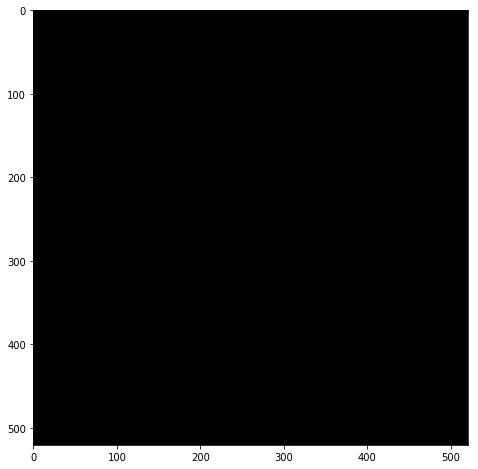

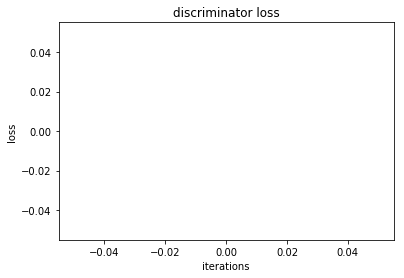

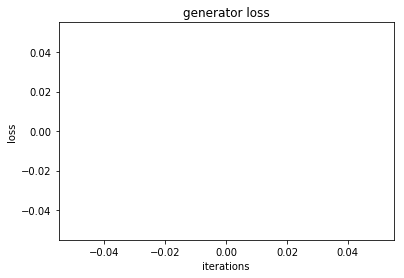

Iteration 276000/611000: dis loss = nan, gen loss = nan
Epoch 451 time is 33.62 [s]
Iteration 276500/611000: dis loss = nan, gen loss = nan
Epoch 452 time is 33.37 [s]
Iteration 277000/611000: dis loss = nan, gen loss = nan
Epoch 453 time is 33.49 [s]
Iteration 277500/611000: dis loss = nan, gen loss = nan
Iteration 278000/611000: dis loss = nan, gen loss = nan
Epoch 454 time is 33.32 [s]
Iteration 278500/611000: dis loss = nan, gen loss = nan
Epoch 455 time is 33.51 [s]


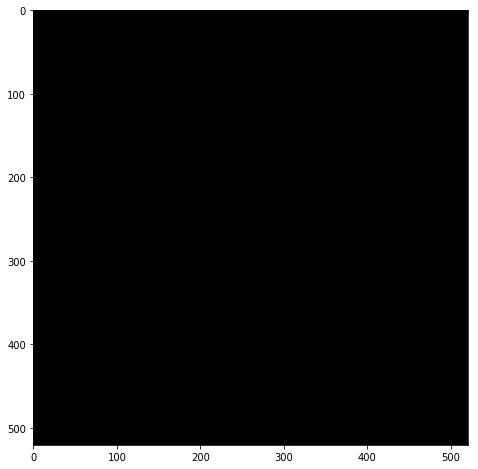

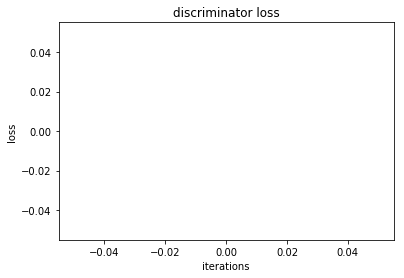

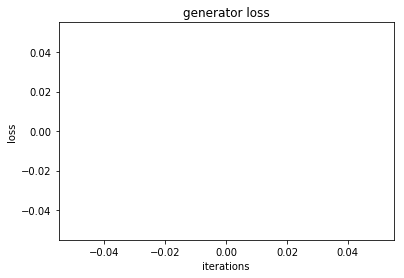

Iteration 279000/611000: dis loss = nan, gen loss = nan
Epoch 456 time is 33.47 [s]
Iteration 279500/611000: dis loss = nan, gen loss = nan
Epoch 457 time is 33.50 [s]
Iteration 280000/611000: dis loss = nan, gen loss = nan
Epoch 458 time is 33.48 [s]
Iteration 280500/611000: dis loss = nan, gen loss = nan
Iteration 281000/611000: dis loss = nan, gen loss = nan
Epoch 459 time is 33.57 [s]
Iteration 281500/611000: dis loss = nan, gen loss = nan
Epoch 460 time is 33.68 [s]


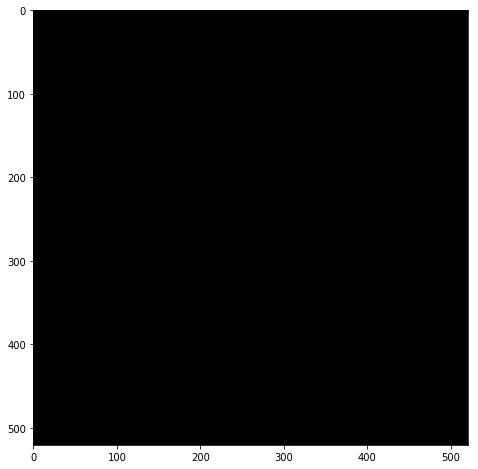

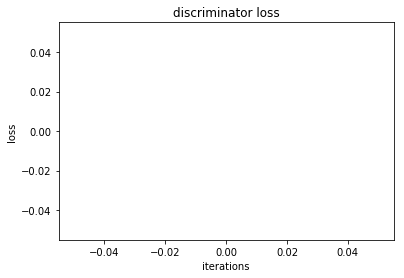

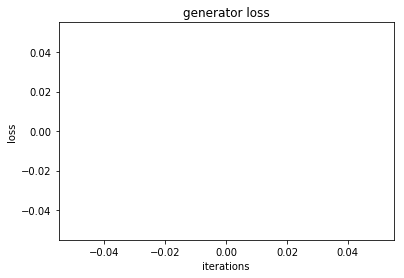

Iteration 282000/611000: dis loss = nan, gen loss = nan
Epoch 461 time is 33.35 [s]
Iteration 282500/611000: dis loss = nan, gen loss = nan
Epoch 462 time is 33.33 [s]
Iteration 283000/611000: dis loss = nan, gen loss = nan
Iteration 283500/611000: dis loss = nan, gen loss = nan
Epoch 463 time is 33.34 [s]
Iteration 284000/611000: dis loss = nan, gen loss = nan
Epoch 464 time is 33.32 [s]
Iteration 284500/611000: dis loss = nan, gen loss = nan
Epoch 465 time is 33.26 [s]


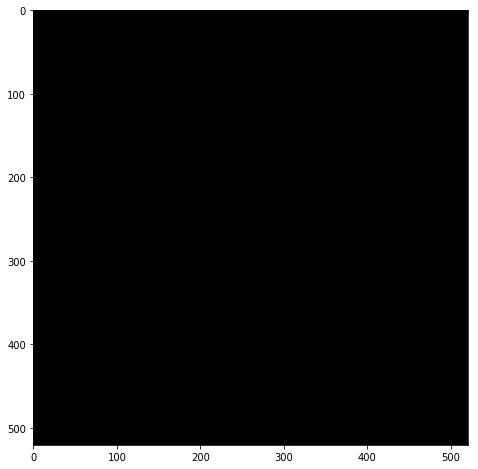

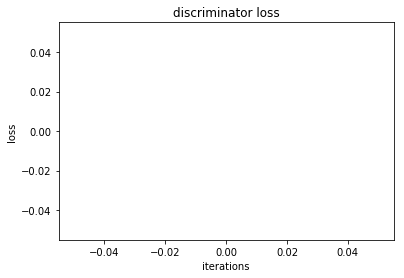

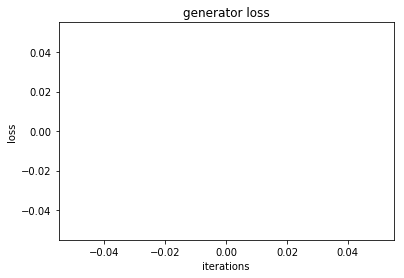

Iteration 285000/611000: dis loss = nan, gen loss = nan
Epoch 466 time is 33.45 [s]
Iteration 285500/611000: dis loss = nan, gen loss = nan
Epoch 467 time is 33.45 [s]
Iteration 286000/611000: dis loss = nan, gen loss = nan
Iteration 286500/611000: dis loss = nan, gen loss = nan
Epoch 468 time is 33.51 [s]
Iteration 287000/611000: dis loss = nan, gen loss = nan
Epoch 469 time is 33.44 [s]
Iteration 287500/611000: dis loss = nan, gen loss = nan
Epoch 470 time is 33.55 [s]


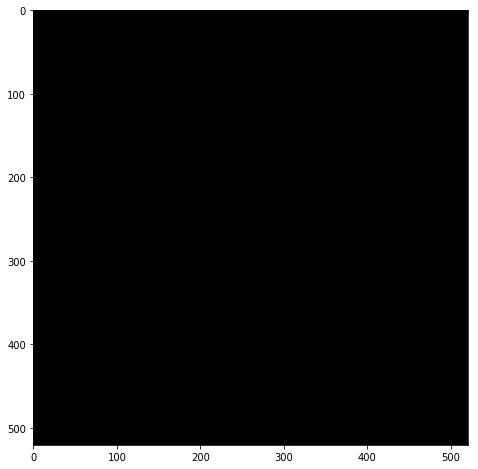

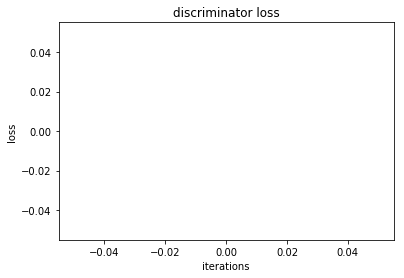

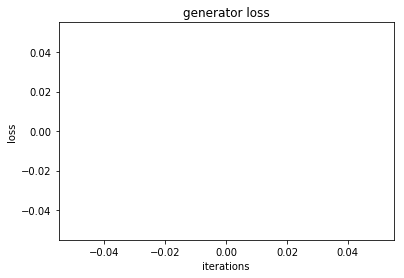

Iteration 288000/611000: dis loss = nan, gen loss = nan
Epoch 471 time is 33.44 [s]
Iteration 288500/611000: dis loss = nan, gen loss = nan
Iteration 289000/611000: dis loss = nan, gen loss = nan
Epoch 472 time is 33.59 [s]
Iteration 289500/611000: dis loss = nan, gen loss = nan
Epoch 473 time is 33.42 [s]
Iteration 290000/611000: dis loss = nan, gen loss = nan
Epoch 474 time is 33.49 [s]
Iteration 290500/611000: dis loss = nan, gen loss = nan
Epoch 475 time is 33.50 [s]


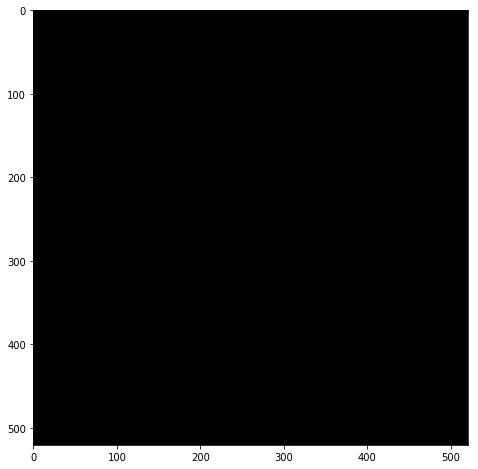

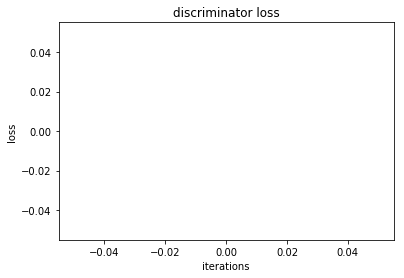

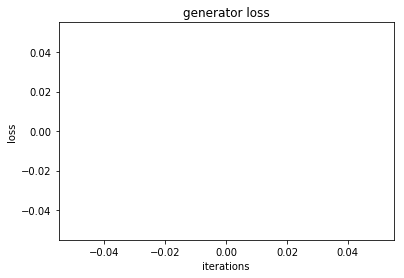

Iteration 291000/611000: dis loss = nan, gen loss = nan
Epoch 476 time is 33.40 [s]
Iteration 291500/611000: dis loss = nan, gen loss = nan
Iteration 292000/611000: dis loss = nan, gen loss = nan
Epoch 477 time is 33.58 [s]
Iteration 292500/611000: dis loss = nan, gen loss = nan
Epoch 478 time is 33.47 [s]
Iteration 293000/611000: dis loss = nan, gen loss = nan
Epoch 479 time is 33.39 [s]
Iteration 293500/611000: dis loss = nan, gen loss = nan
Epoch 480 time is 33.43 [s]


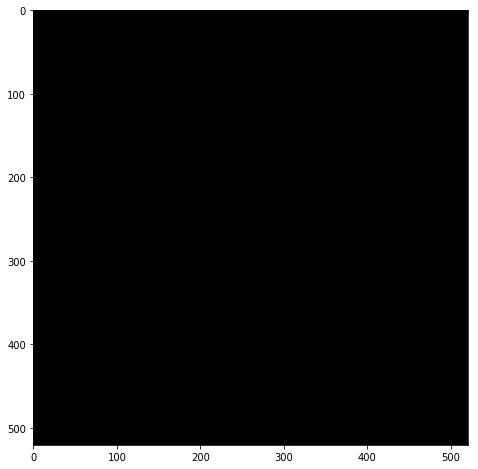

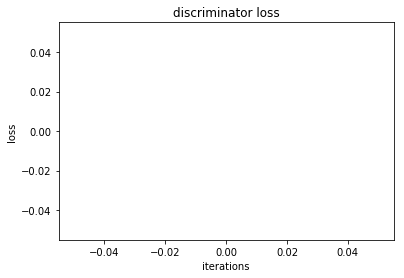

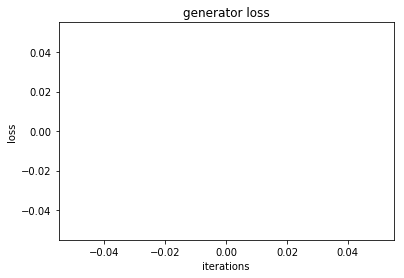

Iteration 294000/611000: dis loss = nan, gen loss = nan
Iteration 294500/611000: dis loss = nan, gen loss = nan
Epoch 481 time is 33.49 [s]
Iteration 295000/611000: dis loss = nan, gen loss = nan
Epoch 482 time is 33.47 [s]
Iteration 295500/611000: dis loss = nan, gen loss = nan
Epoch 483 time is 33.61 [s]
Iteration 296000/611000: dis loss = nan, gen loss = nan
Epoch 484 time is 33.40 [s]
Iteration 296500/611000: dis loss = nan, gen loss = nan
Epoch 485 time is 33.44 [s]


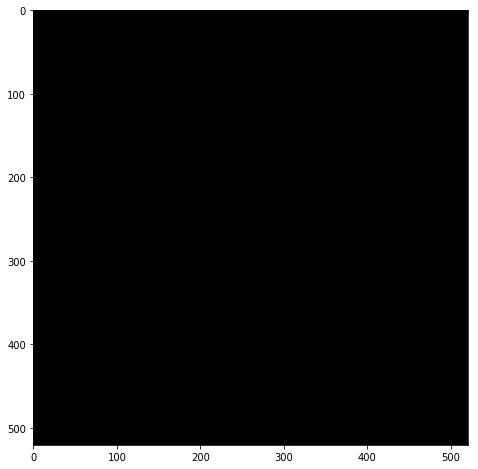

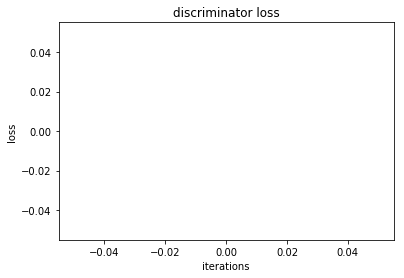

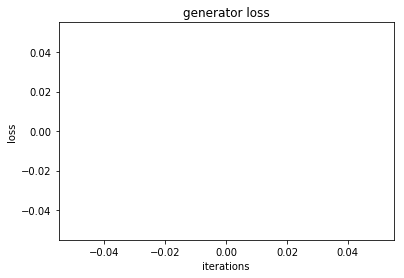

Iteration 297000/611000: dis loss = nan, gen loss = nan
Iteration 297500/611000: dis loss = nan, gen loss = nan
Epoch 486 time is 33.30 [s]
Iteration 298000/611000: dis loss = nan, gen loss = nan
Epoch 487 time is 33.53 [s]
Iteration 298500/611000: dis loss = nan, gen loss = nan
Epoch 488 time is 33.41 [s]
Iteration 299000/611000: dis loss = nan, gen loss = nan
Epoch 489 time is 33.43 [s]
Iteration 299500/611000: dis loss = nan, gen loss = nan
Iteration 300000/611000: dis loss = nan, gen loss = nan
Epoch 490 time is 33.47 [s]


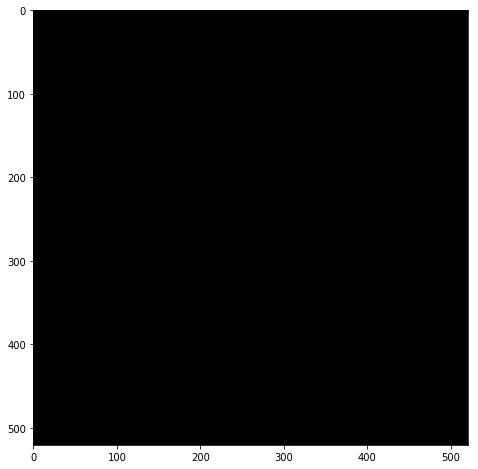

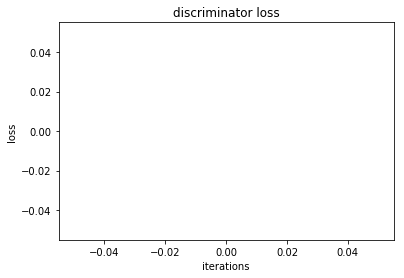

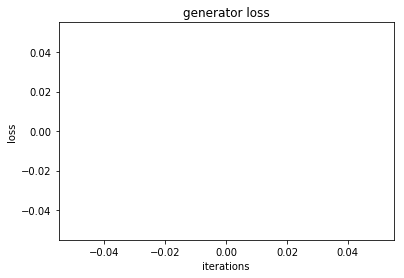

Iteration 300500/611000: dis loss = nan, gen loss = nan
Epoch 491 time is 33.46 [s]
Iteration 301000/611000: dis loss = nan, gen loss = nan
Epoch 492 time is 33.70 [s]
Iteration 301500/611000: dis loss = nan, gen loss = nan
Epoch 493 time is 33.47 [s]
Iteration 302000/611000: dis loss = nan, gen loss = nan
Epoch 494 time is 33.43 [s]
Iteration 302500/611000: dis loss = nan, gen loss = nan
Iteration 303000/611000: dis loss = nan, gen loss = nan
Epoch 495 time is 33.56 [s]


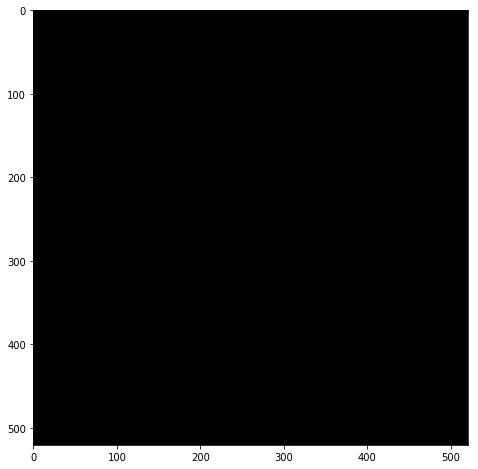

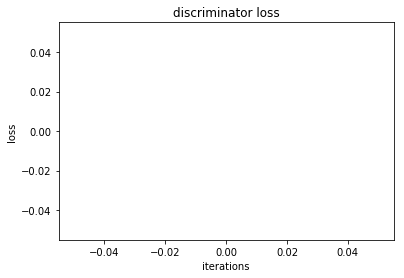

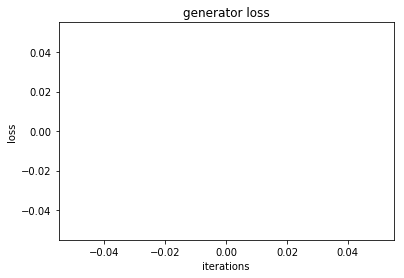

Iteration 303500/611000: dis loss = nan, gen loss = nan
Epoch 496 time is 33.30 [s]
Iteration 304000/611000: dis loss = nan, gen loss = nan
Epoch 497 time is 33.36 [s]
Iteration 304500/611000: dis loss = nan, gen loss = nan
Epoch 498 time is 33.37 [s]
Iteration 305000/611000: dis loss = nan, gen loss = nan
Iteration 305500/611000: dis loss = nan, gen loss = nan
Epoch 499 time is 33.26 [s]
Iteration 306000/611000: dis loss = nan, gen loss = nan
Epoch 500 time is 33.40 [s]


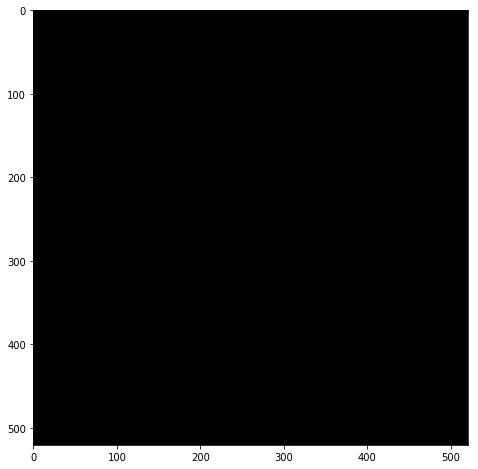

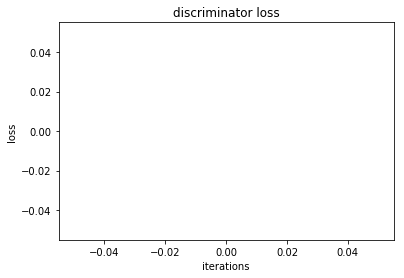

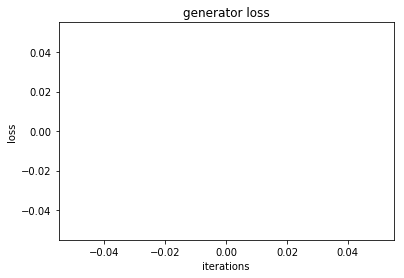

Iteration 306500/611000: dis loss = nan, gen loss = nan
Epoch 501 time is 33.55 [s]
Iteration 307000/611000: dis loss = nan, gen loss = nan
Epoch 502 time is 33.69 [s]
Iteration 307500/611000: dis loss = nan, gen loss = nan
Epoch 503 time is 33.55 [s]
Iteration 308000/611000: dis loss = nan, gen loss = nan
Iteration 308500/611000: dis loss = nan, gen loss = nan
Epoch 504 time is 33.49 [s]
Iteration 309000/611000: dis loss = nan, gen loss = nan
Epoch 505 time is 33.49 [s]


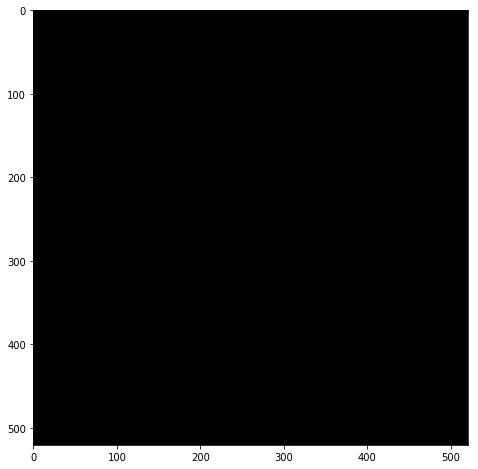

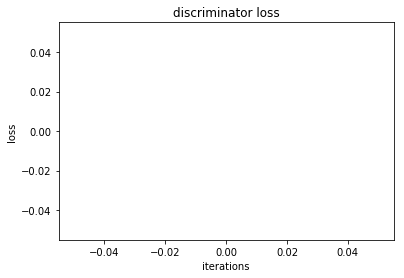

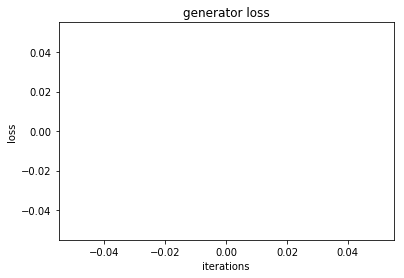

Iteration 309500/611000: dis loss = nan, gen loss = nan
Epoch 506 time is 33.32 [s]
Iteration 310000/611000: dis loss = nan, gen loss = nan
Epoch 507 time is 33.35 [s]
Iteration 310500/611000: dis loss = nan, gen loss = nan
Epoch 508 time is 33.36 [s]
Iteration 311000/611000: dis loss = nan, gen loss = nan
Iteration 311500/611000: dis loss = nan, gen loss = nan
Epoch 509 time is 33.33 [s]
Iteration 312000/611000: dis loss = nan, gen loss = nan
Epoch 510 time is 33.32 [s]


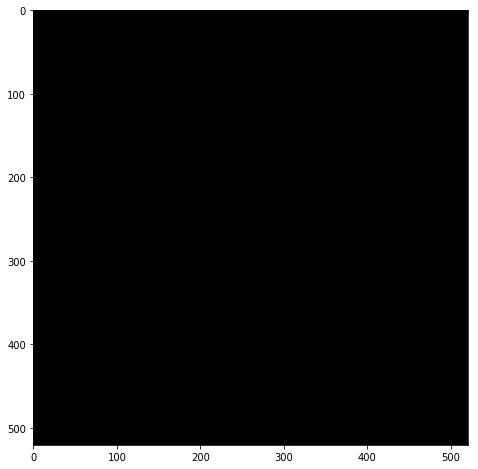

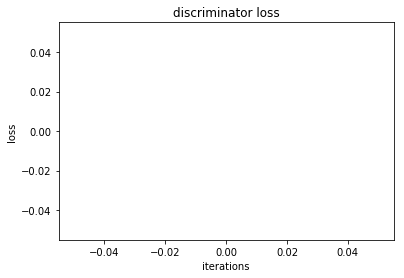

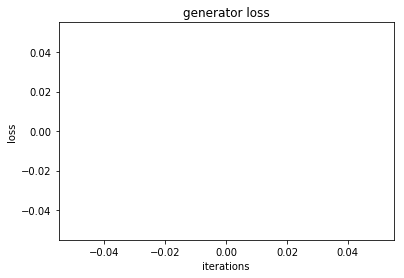

Iteration 312500/611000: dis loss = nan, gen loss = nan
Epoch 511 time is 33.39 [s]
Iteration 313000/611000: dis loss = nan, gen loss = nan
Epoch 512 time is 33.37 [s]
Iteration 313500/611000: dis loss = nan, gen loss = nan
Iteration 314000/611000: dis loss = nan, gen loss = nan
Epoch 513 time is 33.48 [s]
Iteration 314500/611000: dis loss = nan, gen loss = nan
Epoch 514 time is 33.30 [s]
Iteration 315000/611000: dis loss = nan, gen loss = nan
Epoch 515 time is 33.33 [s]


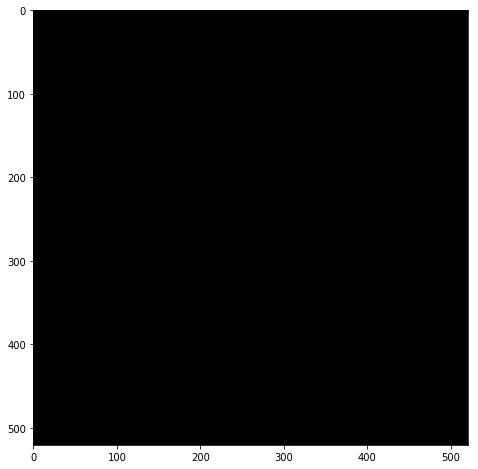

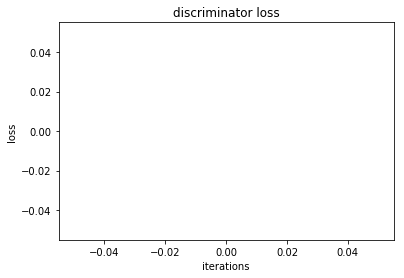

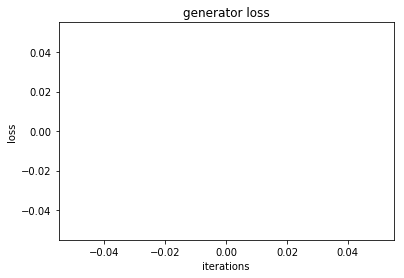

Iteration 315500/611000: dis loss = nan, gen loss = nan
Epoch 516 time is 33.28 [s]
Iteration 316000/611000: dis loss = nan, gen loss = nan
Epoch 517 time is 33.28 [s]
Iteration 316500/611000: dis loss = nan, gen loss = nan
Iteration 317000/611000: dis loss = nan, gen loss = nan
Epoch 518 time is 33.31 [s]
Iteration 317500/611000: dis loss = nan, gen loss = nan
Epoch 519 time is 33.43 [s]
Iteration 318000/611000: dis loss = nan, gen loss = nan
Epoch 520 time is 33.35 [s]


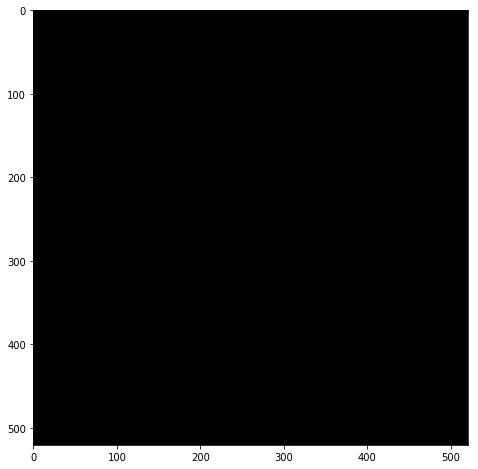

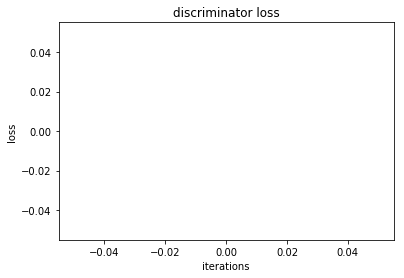

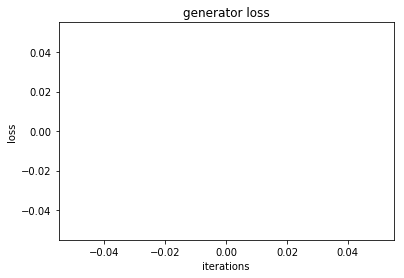

Iteration 318500/611000: dis loss = nan, gen loss = nan
Epoch 521 time is 33.43 [s]
Iteration 319000/611000: dis loss = nan, gen loss = nan
Iteration 319500/611000: dis loss = nan, gen loss = nan
Epoch 522 time is 33.43 [s]
Iteration 320000/611000: dis loss = nan, gen loss = nan
Epoch 523 time is 33.35 [s]
Iteration 320500/611000: dis loss = nan, gen loss = nan
Epoch 524 time is 33.29 [s]
Iteration 321000/611000: dis loss = nan, gen loss = nan
Epoch 525 time is 33.26 [s]


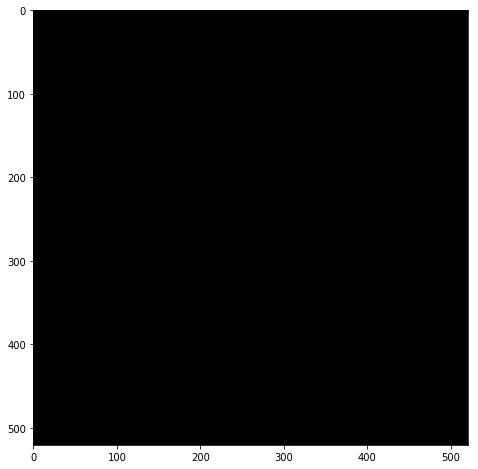

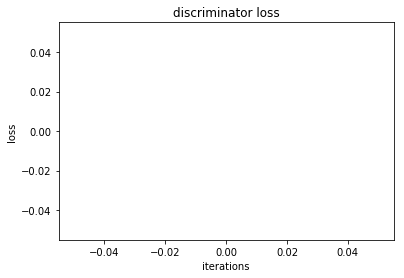

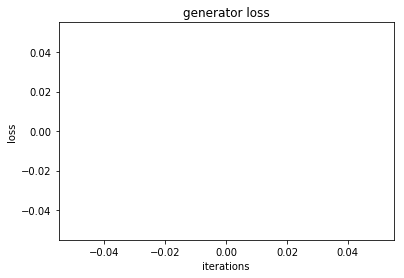

Iteration 321500/611000: dis loss = nan, gen loss = nan
Epoch 526 time is 33.35 [s]
Iteration 322000/611000: dis loss = nan, gen loss = nan
Iteration 322500/611000: dis loss = nan, gen loss = nan
Epoch 527 time is 33.32 [s]
Iteration 323000/611000: dis loss = nan, gen loss = nan
Epoch 528 time is 33.24 [s]
Iteration 323500/611000: dis loss = nan, gen loss = nan
Epoch 529 time is 33.44 [s]
Iteration 324000/611000: dis loss = nan, gen loss = nan
Epoch 530 time is 33.38 [s]


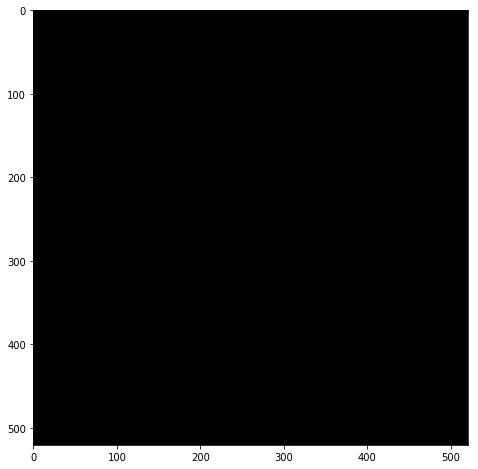

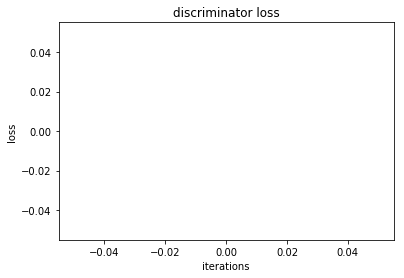

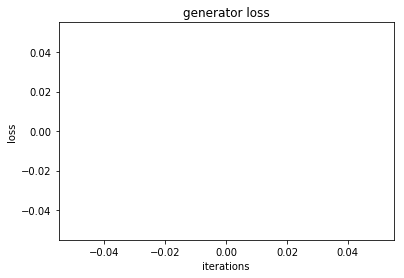

Iteration 324500/611000: dis loss = nan, gen loss = nan
Iteration 325000/611000: dis loss = nan, gen loss = nan
Epoch 531 time is 33.23 [s]
Iteration 325500/611000: dis loss = nan, gen loss = nan
Epoch 532 time is 33.33 [s]
Iteration 326000/611000: dis loss = nan, gen loss = nan
Epoch 533 time is 33.31 [s]
Iteration 326500/611000: dis loss = nan, gen loss = nan
Epoch 534 time is 33.31 [s]
Iteration 327000/611000: dis loss = nan, gen loss = nan
Epoch 535 time is 33.31 [s]


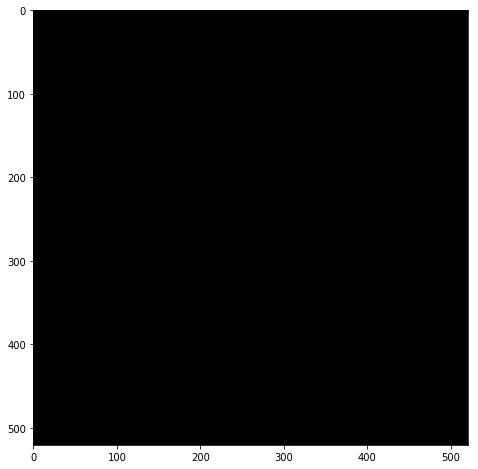

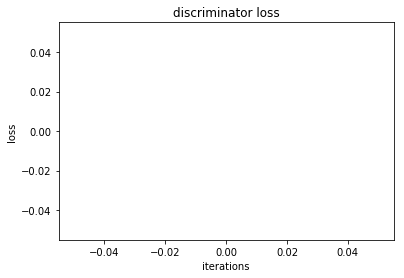

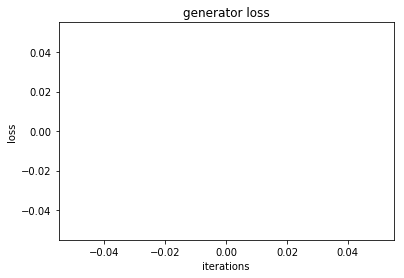

Iteration 327500/611000: dis loss = nan, gen loss = nan
Iteration 328000/611000: dis loss = nan, gen loss = nan
Epoch 536 time is 33.54 [s]
Iteration 328500/611000: dis loss = nan, gen loss = nan
Epoch 537 time is 33.46 [s]
Iteration 329000/611000: dis loss = nan, gen loss = nan
Epoch 538 time is 33.48 [s]
Iteration 329500/611000: dis loss = nan, gen loss = nan
Epoch 539 time is 33.47 [s]
Iteration 330000/611000: dis loss = nan, gen loss = nan
Iteration 330500/611000: dis loss = nan, gen loss = nan
Epoch 540 time is 33.60 [s]


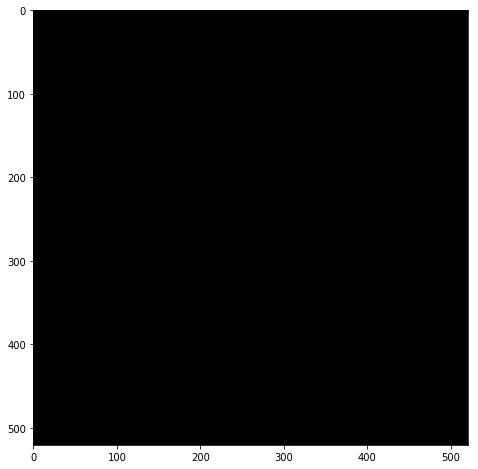

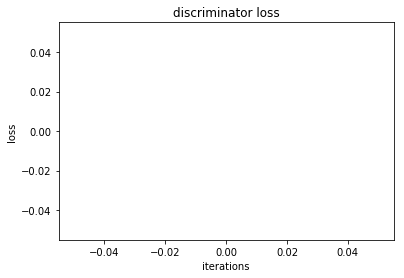

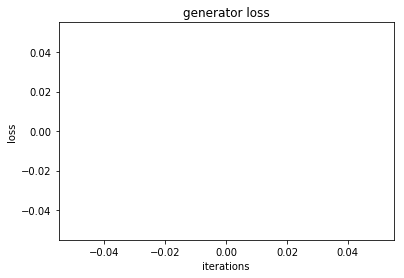

Iteration 331000/611000: dis loss = nan, gen loss = nan
Epoch 541 time is 33.34 [s]
Iteration 331500/611000: dis loss = nan, gen loss = nan
Epoch 542 time is 33.37 [s]
Iteration 332000/611000: dis loss = nan, gen loss = nan
Epoch 543 time is 33.26 [s]
Iteration 332500/611000: dis loss = nan, gen loss = nan
Epoch 544 time is 33.33 [s]
Iteration 333000/611000: dis loss = nan, gen loss = nan
Iteration 333500/611000: dis loss = nan, gen loss = nan
Epoch 545 time is 33.38 [s]


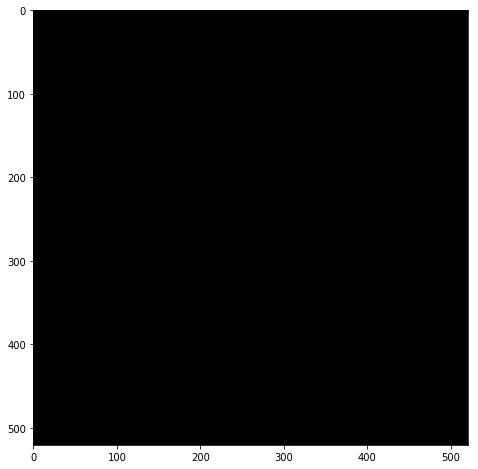

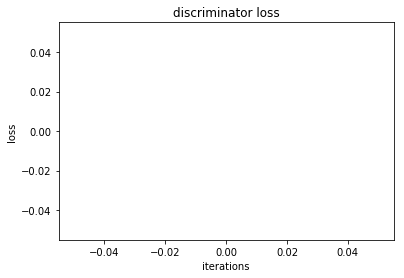

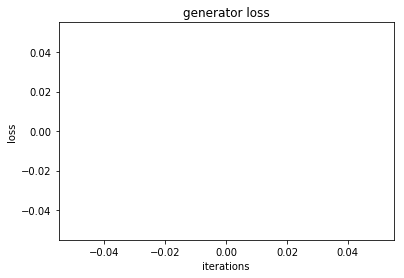

Iteration 334000/611000: dis loss = nan, gen loss = nan
Epoch 546 time is 33.31 [s]
Iteration 334500/611000: dis loss = nan, gen loss = nan
Epoch 547 time is 33.29 [s]
Iteration 335000/611000: dis loss = nan, gen loss = nan
Epoch 548 time is 33.29 [s]
Iteration 335500/611000: dis loss = nan, gen loss = nan
Iteration 336000/611000: dis loss = nan, gen loss = nan
Epoch 549 time is 33.25 [s]
Iteration 336500/611000: dis loss = nan, gen loss = nan
Epoch 550 time is 33.39 [s]


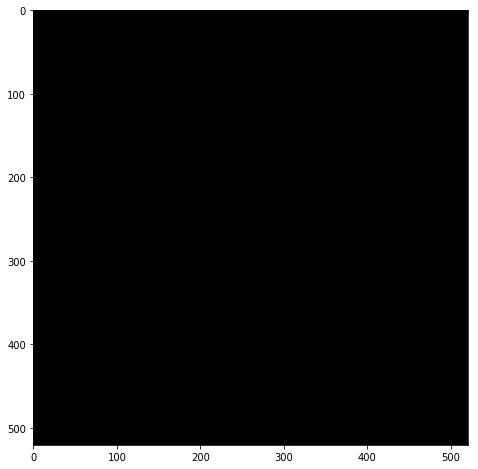

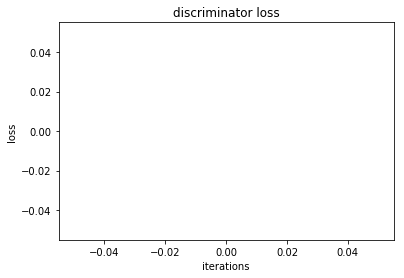

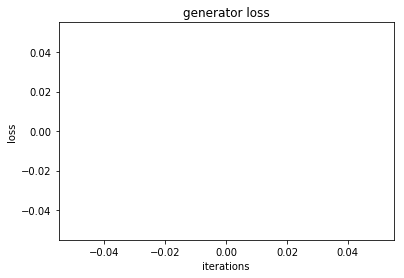

Iteration 337000/611000: dis loss = nan, gen loss = nan
Epoch 551 time is 33.27 [s]
Iteration 337500/611000: dis loss = nan, gen loss = nan
Epoch 552 time is 33.28 [s]
Iteration 338000/611000: dis loss = nan, gen loss = nan
Epoch 553 time is 33.33 [s]
Iteration 338500/611000: dis loss = nan, gen loss = nan
Iteration 339000/611000: dis loss = nan, gen loss = nan
Epoch 554 time is 33.35 [s]
Iteration 339500/611000: dis loss = nan, gen loss = nan
Epoch 555 time is 33.44 [s]


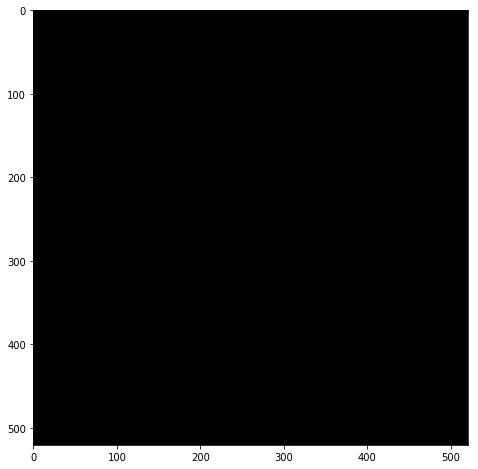

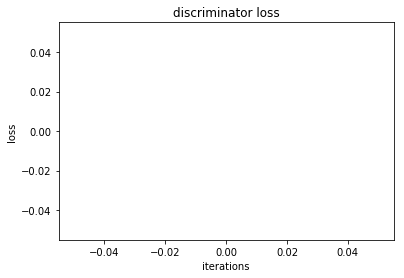

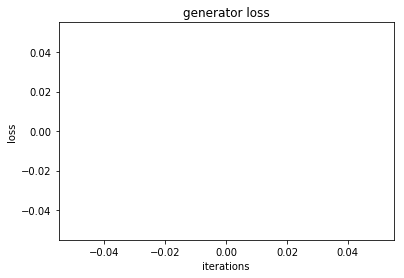

Iteration 340000/611000: dis loss = nan, gen loss = nan
Epoch 556 time is 33.27 [s]
Iteration 340500/611000: dis loss = nan, gen loss = nan
Epoch 557 time is 33.31 [s]
Iteration 341000/611000: dis loss = nan, gen loss = nan
Iteration 341500/611000: dis loss = nan, gen loss = nan
Epoch 558 time is 33.40 [s]
Iteration 342000/611000: dis loss = nan, gen loss = nan
Epoch 559 time is 33.23 [s]
Iteration 342500/611000: dis loss = nan, gen loss = nan
Epoch 560 time is 33.40 [s]


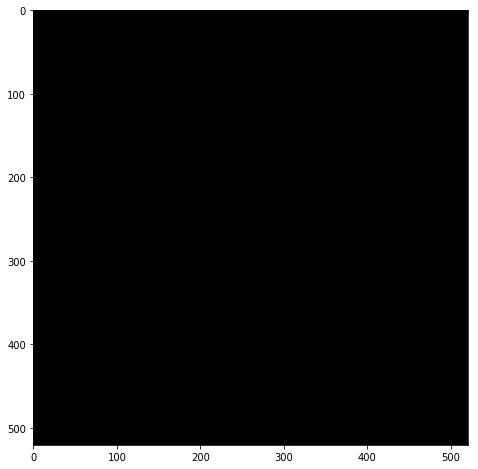

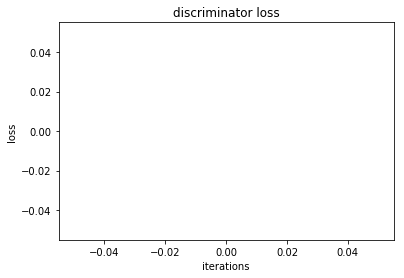

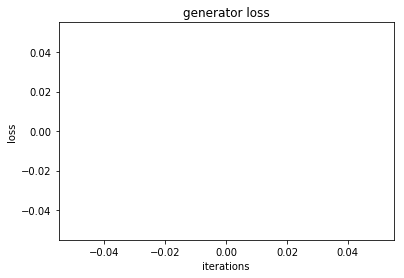

Iteration 343000/611000: dis loss = nan, gen loss = nan
Epoch 561 time is 33.31 [s]
Iteration 343500/611000: dis loss = nan, gen loss = nan
Epoch 562 time is 33.41 [s]
Iteration 344000/611000: dis loss = nan, gen loss = nan
Iteration 344500/611000: dis loss = nan, gen loss = nan
Epoch 563 time is 33.30 [s]
Iteration 345000/611000: dis loss = nan, gen loss = nan
Epoch 564 time is 33.51 [s]
Iteration 345500/611000: dis loss = nan, gen loss = nan
Epoch 565 time is 33.44 [s]


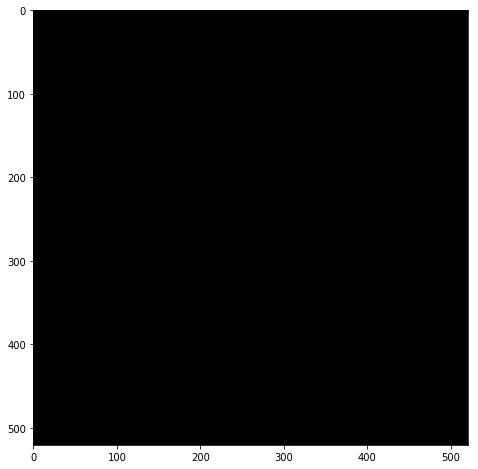

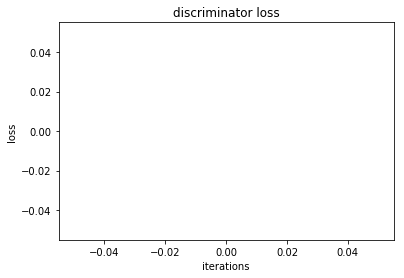

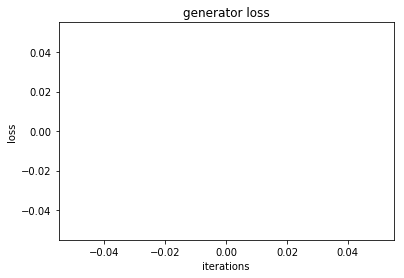

Iteration 346000/611000: dis loss = nan, gen loss = nan
Epoch 566 time is 33.44 [s]
Iteration 346500/611000: dis loss = nan, gen loss = nan
Iteration 347000/611000: dis loss = nan, gen loss = nan
Epoch 567 time is 33.52 [s]
Iteration 347500/611000: dis loss = nan, gen loss = nan
Epoch 568 time is 33.43 [s]
Iteration 348000/611000: dis loss = nan, gen loss = nan
Epoch 569 time is 33.37 [s]
Iteration 348500/611000: dis loss = nan, gen loss = nan
Epoch 570 time is 33.40 [s]


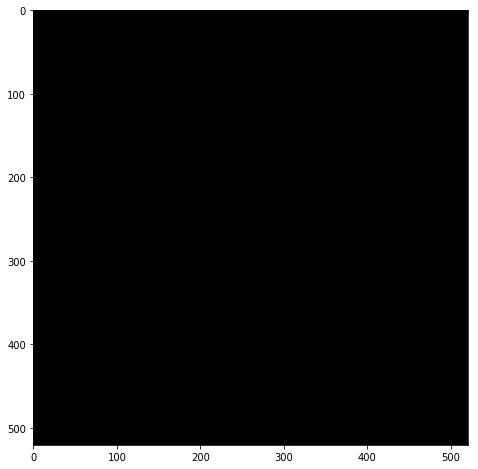

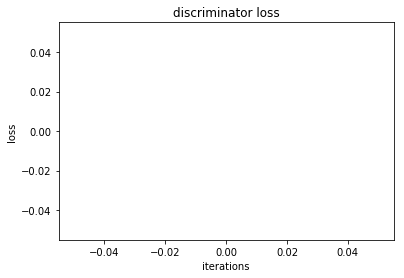

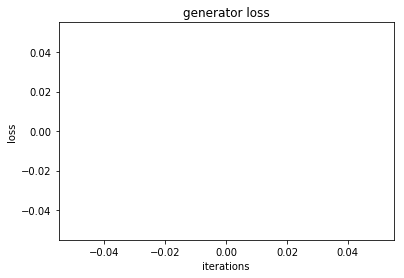

Iteration 349000/611000: dis loss = nan, gen loss = nan
Epoch 571 time is 33.45 [s]
Iteration 349500/611000: dis loss = nan, gen loss = nan
Iteration 350000/611000: dis loss = nan, gen loss = nan
Epoch 572 time is 33.50 [s]
Iteration 350500/611000: dis loss = nan, gen loss = nan
Epoch 573 time is 33.32 [s]
Iteration 351000/611000: dis loss = nan, gen loss = nan
Epoch 574 time is 33.48 [s]
Iteration 351500/611000: dis loss = nan, gen loss = nan
Epoch 575 time is 33.51 [s]


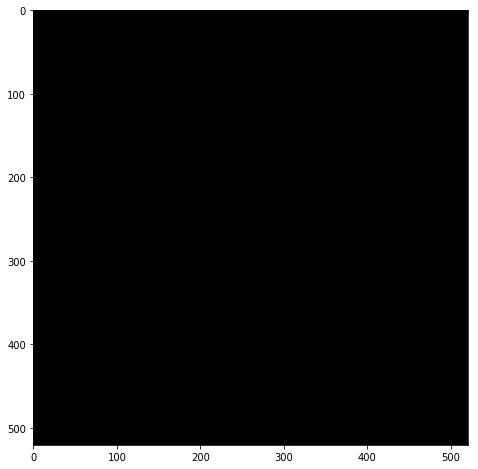

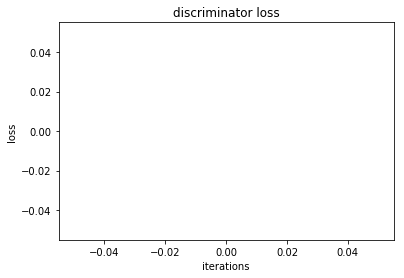

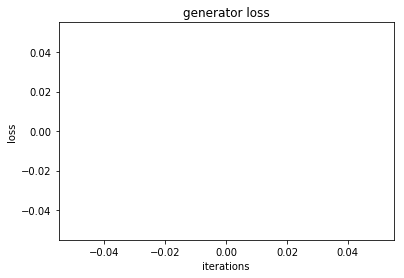

Iteration 352000/611000: dis loss = nan, gen loss = nan
Iteration 352500/611000: dis loss = nan, gen loss = nan
Epoch 576 time is 33.41 [s]
Iteration 353000/611000: dis loss = nan, gen loss = nan
Epoch 577 time is 33.51 [s]
Iteration 353500/611000: dis loss = nan, gen loss = nan
Epoch 578 time is 33.30 [s]
Iteration 354000/611000: dis loss = nan, gen loss = nan
Epoch 579 time is 33.51 [s]
Iteration 354500/611000: dis loss = nan, gen loss = nan
Epoch 580 time is 33.38 [s]


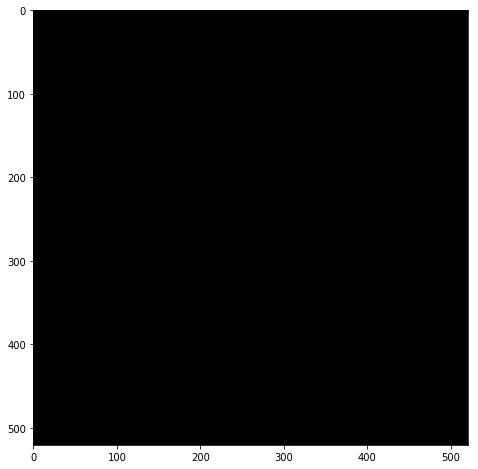

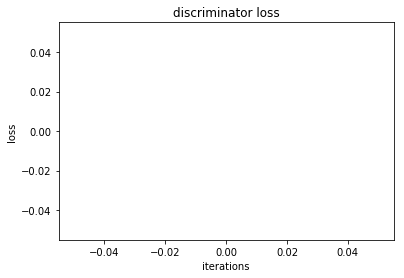

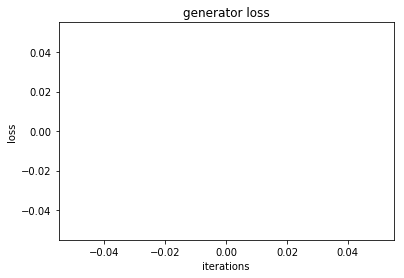

Iteration 355000/611000: dis loss = nan, gen loss = nan
Iteration 355500/611000: dis loss = nan, gen loss = nan
Epoch 581 time is 33.43 [s]
Iteration 356000/611000: dis loss = nan, gen loss = nan
Epoch 582 time is 33.47 [s]
Iteration 356500/611000: dis loss = nan, gen loss = nan
Epoch 583 time is 33.34 [s]
Iteration 357000/611000: dis loss = nan, gen loss = nan
Epoch 584 time is 33.46 [s]
Iteration 357500/611000: dis loss = nan, gen loss = nan
Iteration 358000/611000: dis loss = nan, gen loss = nan
Epoch 585 time is 33.42 [s]


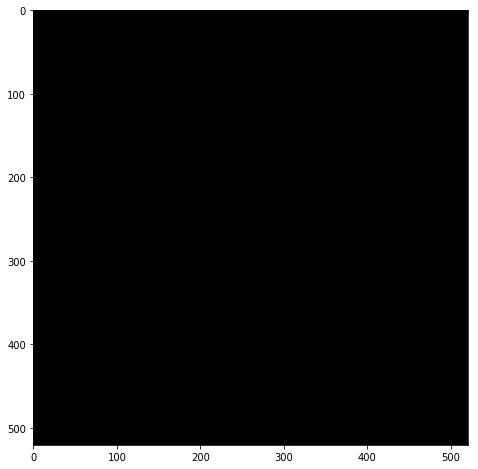

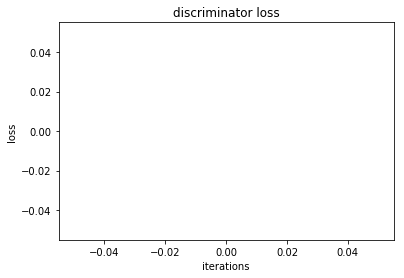

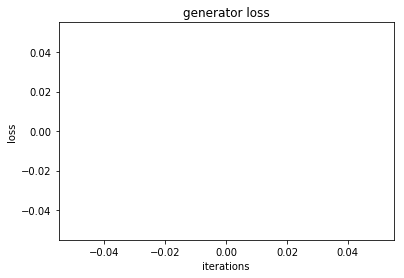

Iteration 358500/611000: dis loss = nan, gen loss = nan
Epoch 586 time is 33.39 [s]
Iteration 359000/611000: dis loss = nan, gen loss = nan
Epoch 587 time is 33.52 [s]
Iteration 359500/611000: dis loss = nan, gen loss = nan
Epoch 588 time is 33.47 [s]
Iteration 360000/611000: dis loss = nan, gen loss = nan
Epoch 589 time is 33.60 [s]
Iteration 360500/611000: dis loss = nan, gen loss = nan
Iteration 361000/611000: dis loss = nan, gen loss = nan
Epoch 590 time is 33.48 [s]


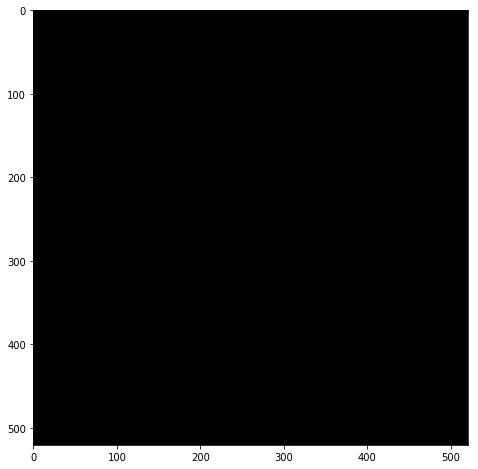

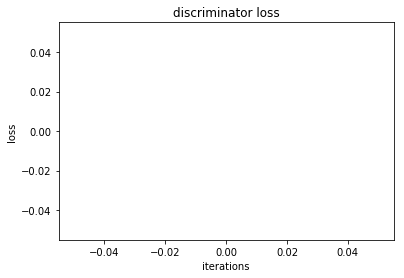

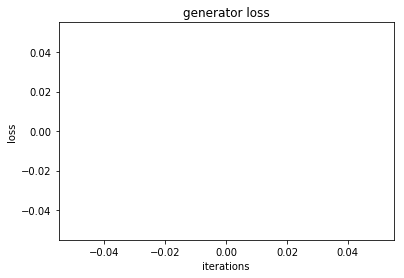

Iteration 361500/611000: dis loss = nan, gen loss = nan
Epoch 591 time is 33.33 [s]
Iteration 362000/611000: dis loss = nan, gen loss = nan
Epoch 592 time is 33.51 [s]
Iteration 362500/611000: dis loss = nan, gen loss = nan
Epoch 593 time is 33.58 [s]
Iteration 363000/611000: dis loss = nan, gen loss = nan
Iteration 363500/611000: dis loss = nan, gen loss = nan
Epoch 594 time is 33.43 [s]
Iteration 364000/611000: dis loss = nan, gen loss = nan
Epoch 595 time is 33.47 [s]


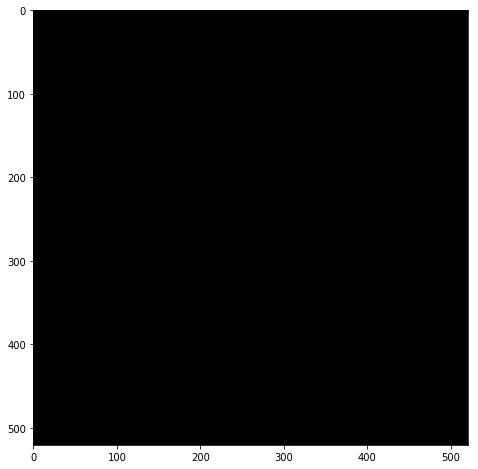

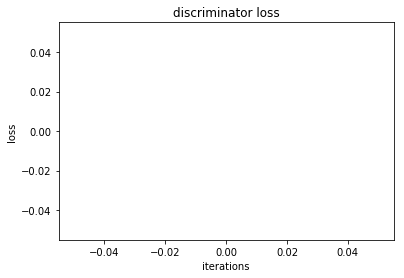

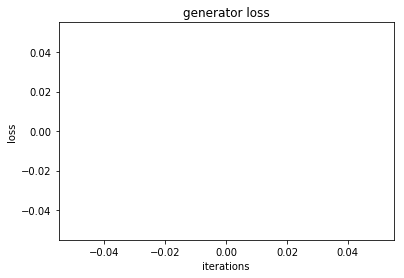

Iteration 364500/611000: dis loss = nan, gen loss = nan
Epoch 596 time is 33.39 [s]
Iteration 365000/611000: dis loss = nan, gen loss = nan
Epoch 597 time is 33.44 [s]
Iteration 365500/611000: dis loss = nan, gen loss = nan
Epoch 598 time is 33.35 [s]
Iteration 366000/611000: dis loss = nan, gen loss = nan
Iteration 366500/611000: dis loss = nan, gen loss = nan
Epoch 599 time is 33.41 [s]
Iteration 367000/611000: dis loss = nan, gen loss = nan
Epoch 600 time is 33.41 [s]


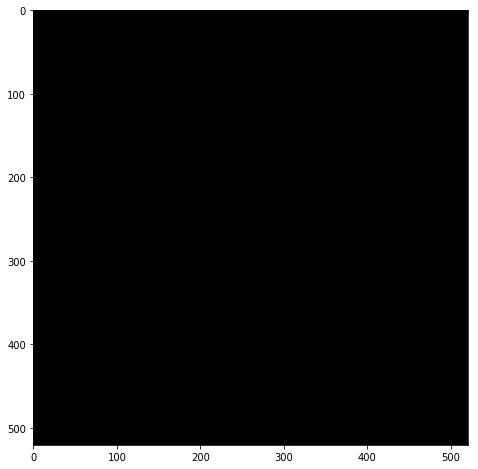

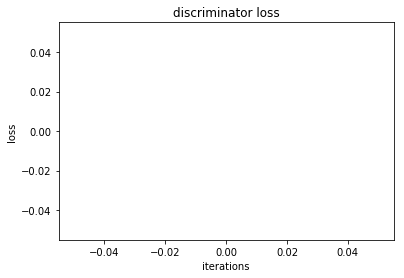

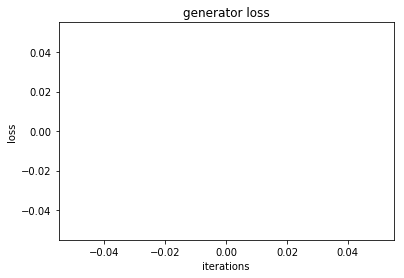

Iteration 367500/611000: dis loss = nan, gen loss = nan
Epoch 601 time is 33.44 [s]
Iteration 368000/611000: dis loss = nan, gen loss = nan
Epoch 602 time is 33.52 [s]
Iteration 368500/611000: dis loss = nan, gen loss = nan
Iteration 369000/611000: dis loss = nan, gen loss = nan
Epoch 603 time is 33.50 [s]
Iteration 369500/611000: dis loss = nan, gen loss = nan
Epoch 604 time is 33.48 [s]
Iteration 370000/611000: dis loss = nan, gen loss = nan
Epoch 605 time is 33.53 [s]


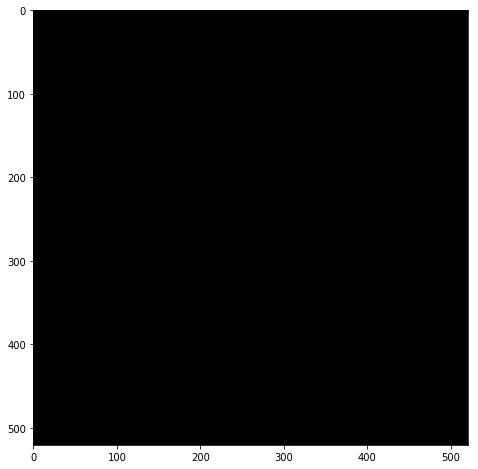

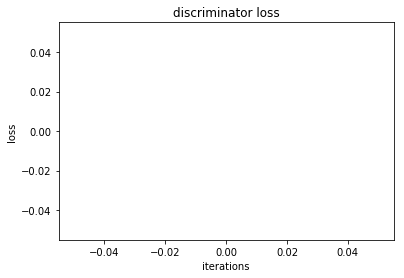

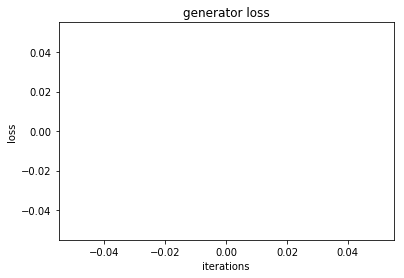

Iteration 370500/611000: dis loss = nan, gen loss = nan
Epoch 606 time is 33.33 [s]
Iteration 371000/611000: dis loss = nan, gen loss = nan
Epoch 607 time is 33.28 [s]
Iteration 371500/611000: dis loss = nan, gen loss = nan
Iteration 372000/611000: dis loss = nan, gen loss = nan
Epoch 608 time is 33.29 [s]
Iteration 372500/611000: dis loss = nan, gen loss = nan
Epoch 609 time is 33.28 [s]
Iteration 373000/611000: dis loss = nan, gen loss = nan
Epoch 610 time is 33.33 [s]


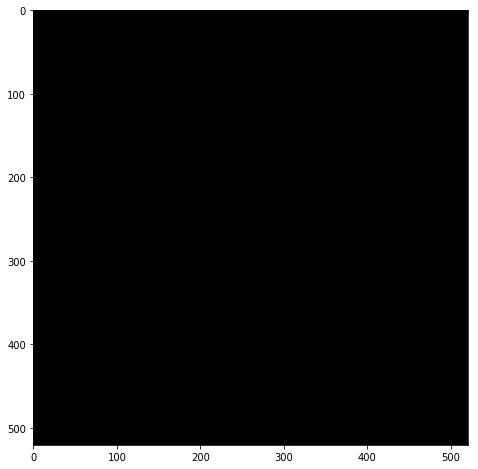

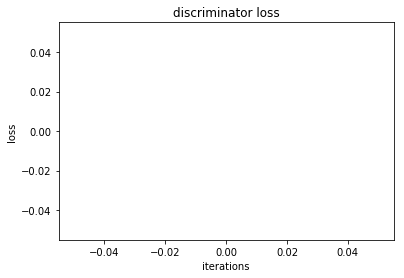

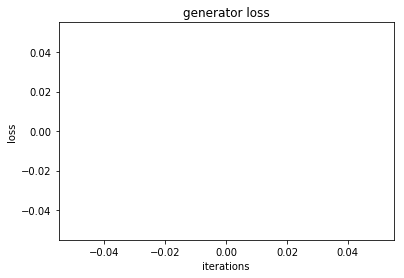

Iteration 373500/611000: dis loss = nan, gen loss = nan
Epoch 611 time is 33.40 [s]
Iteration 374000/611000: dis loss = nan, gen loss = nan
Iteration 374500/611000: dis loss = nan, gen loss = nan
Epoch 612 time is 33.53 [s]
Iteration 375000/611000: dis loss = nan, gen loss = nan
Epoch 613 time is 33.50 [s]
Iteration 375500/611000: dis loss = nan, gen loss = nan
Epoch 614 time is 33.41 [s]
Iteration 376000/611000: dis loss = nan, gen loss = nan
Epoch 615 time is 33.58 [s]


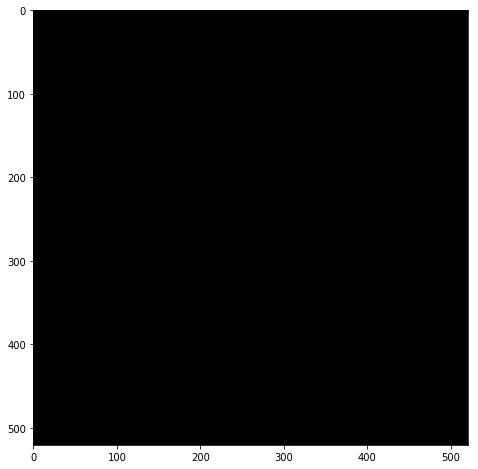

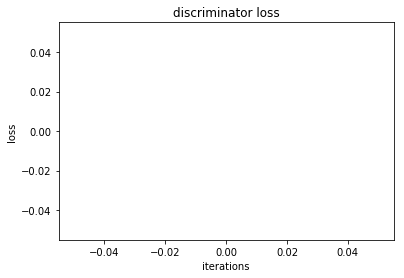

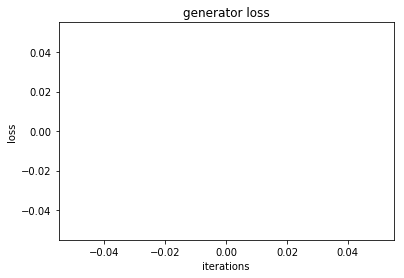

Iteration 376500/611000: dis loss = nan, gen loss = nan
Epoch 616 time is 33.43 [s]
Iteration 377000/611000: dis loss = nan, gen loss = nan
Iteration 377500/611000: dis loss = nan, gen loss = nan
Epoch 617 time is 33.51 [s]
Iteration 378000/611000: dis loss = nan, gen loss = nan
Epoch 618 time is 33.59 [s]
Iteration 378500/611000: dis loss = nan, gen loss = nan
Epoch 619 time is 33.48 [s]
Iteration 379000/611000: dis loss = nan, gen loss = nan
Epoch 620 time is 33.39 [s]


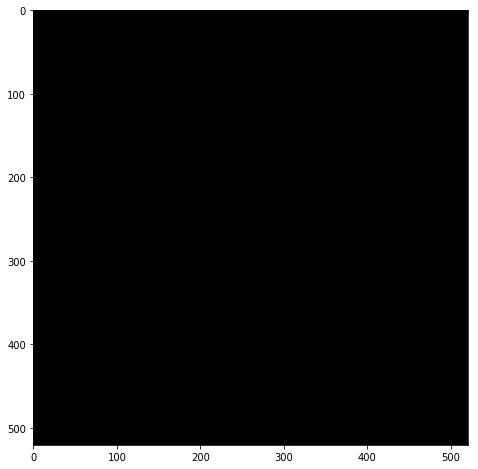

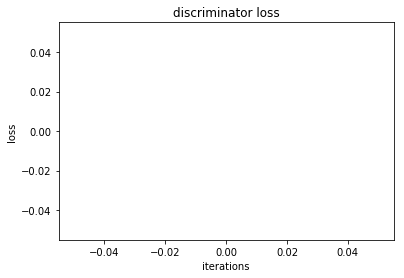

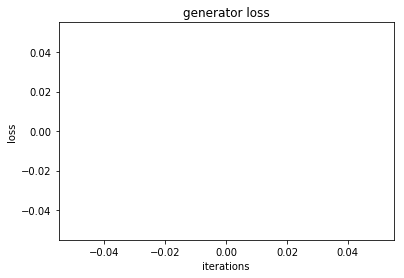

Iteration 379500/611000: dis loss = nan, gen loss = nan
Iteration 380000/611000: dis loss = nan, gen loss = nan
Epoch 621 time is 33.60 [s]
Iteration 380500/611000: dis loss = nan, gen loss = nan
Epoch 622 time is 33.42 [s]
Iteration 381000/611000: dis loss = nan, gen loss = nan
Epoch 623 time is 33.45 [s]
Iteration 381500/611000: dis loss = nan, gen loss = nan
Epoch 624 time is 33.47 [s]
Iteration 382000/611000: dis loss = nan, gen loss = nan
Epoch 625 time is 33.49 [s]


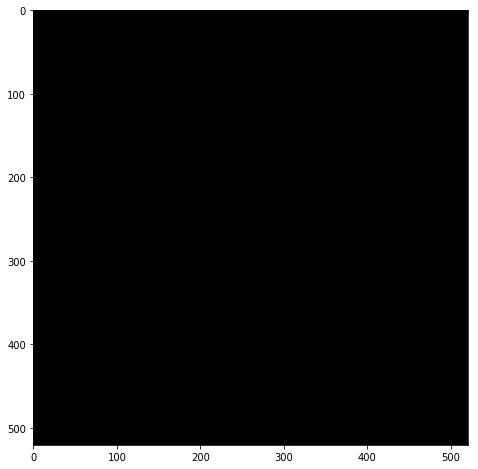

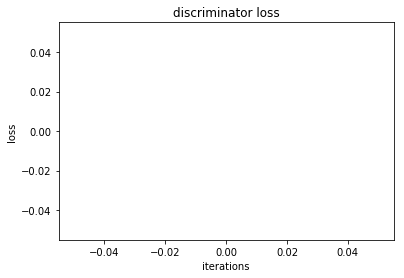

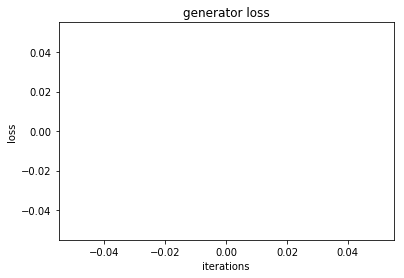

Iteration 382500/611000: dis loss = nan, gen loss = nan
Iteration 383000/611000: dis loss = nan, gen loss = nan
Epoch 626 time is 33.29 [s]
Iteration 383500/611000: dis loss = nan, gen loss = nan
Epoch 627 time is 33.28 [s]
Iteration 384000/611000: dis loss = nan, gen loss = nan
Epoch 628 time is 33.24 [s]
Iteration 384500/611000: dis loss = nan, gen loss = nan
Epoch 629 time is 33.33 [s]
Iteration 385000/611000: dis loss = nan, gen loss = nan
Iteration 385500/611000: dis loss = nan, gen loss = nan
Epoch 630 time is 33.33 [s]


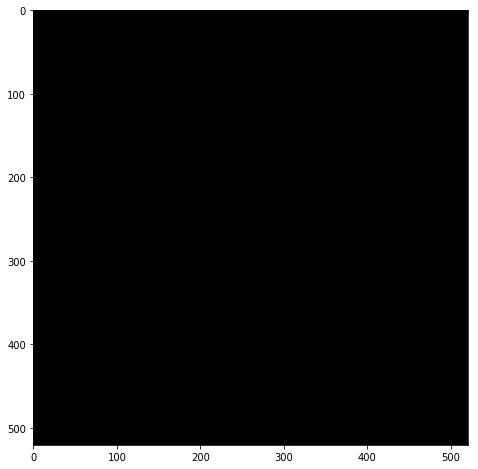

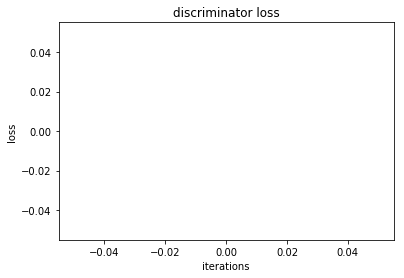

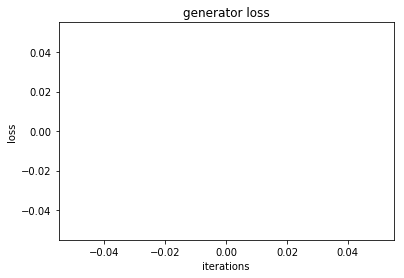

Iteration 386000/611000: dis loss = nan, gen loss = nan
Epoch 631 time is 33.52 [s]
Iteration 386500/611000: dis loss = nan, gen loss = nan
Epoch 632 time is 33.41 [s]
Iteration 387000/611000: dis loss = nan, gen loss = nan
Epoch 633 time is 33.44 [s]
Iteration 387500/611000: dis loss = nan, gen loss = nan
Epoch 634 time is 33.35 [s]
Iteration 388000/611000: dis loss = nan, gen loss = nan
Iteration 388500/611000: dis loss = nan, gen loss = nan
Epoch 635 time is 33.45 [s]


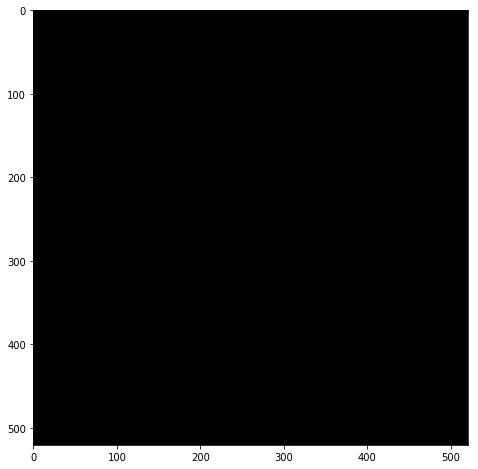

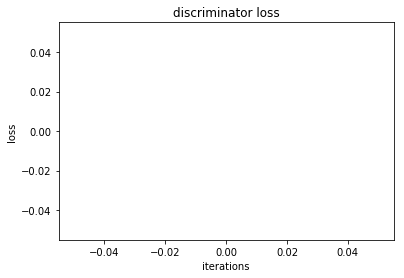

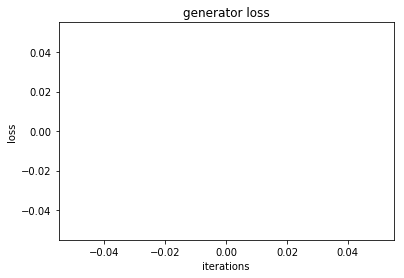

Iteration 389000/611000: dis loss = nan, gen loss = nan
Epoch 636 time is 33.46 [s]
Iteration 389500/611000: dis loss = nan, gen loss = nan
Epoch 637 time is 33.37 [s]
Iteration 390000/611000: dis loss = nan, gen loss = nan
Epoch 638 time is 33.38 [s]
Iteration 390500/611000: dis loss = nan, gen loss = nan
Iteration 391000/611000: dis loss = nan, gen loss = nan
Epoch 639 time is 33.50 [s]
Iteration 391500/611000: dis loss = nan, gen loss = nan
Epoch 640 time is 33.52 [s]


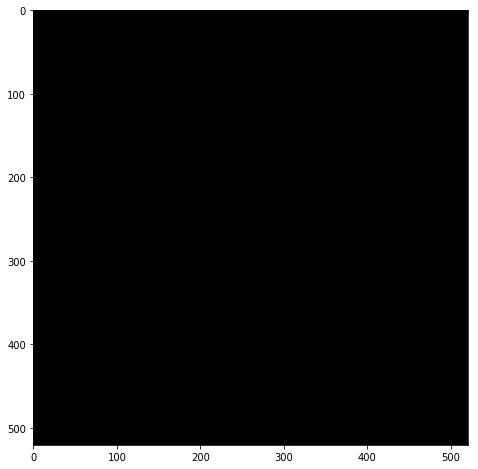

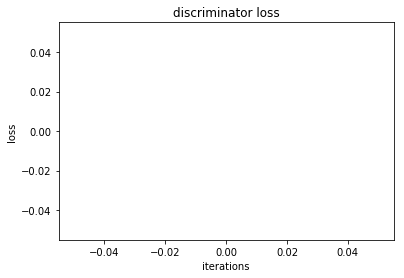

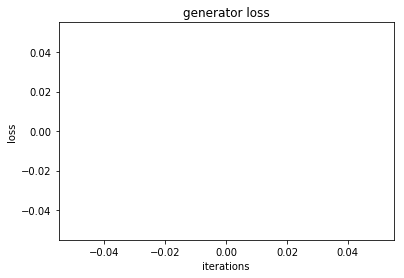

Iteration 392000/611000: dis loss = nan, gen loss = nan
Epoch 641 time is 33.40 [s]
Iteration 392500/611000: dis loss = nan, gen loss = nan
Epoch 642 time is 33.41 [s]
Iteration 393000/611000: dis loss = nan, gen loss = nan
Epoch 643 time is 33.47 [s]
Iteration 393500/611000: dis loss = nan, gen loss = nan
Iteration 394000/611000: dis loss = nan, gen loss = nan
Epoch 644 time is 33.61 [s]
Iteration 394500/611000: dis loss = nan, gen loss = nan
Epoch 645 time is 33.49 [s]


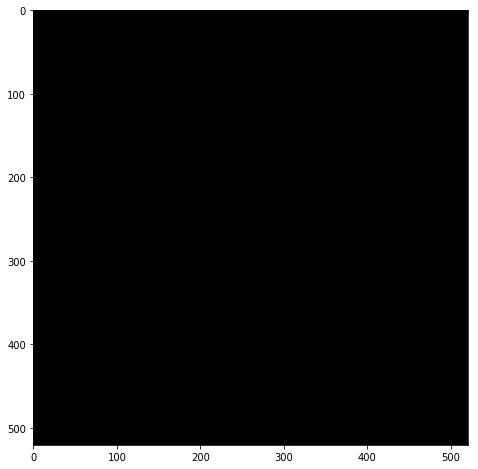

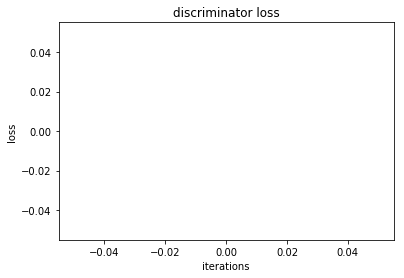

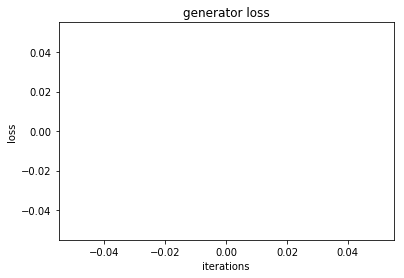

Iteration 395000/611000: dis loss = nan, gen loss = nan
Epoch 646 time is 33.38 [s]
Iteration 395500/611000: dis loss = nan, gen loss = nan
Epoch 647 time is 33.44 [s]
Iteration 396000/611000: dis loss = nan, gen loss = nan
Iteration 396500/611000: dis loss = nan, gen loss = nan
Epoch 648 time is 33.45 [s]
Iteration 397000/611000: dis loss = nan, gen loss = nan
Epoch 649 time is 33.49 [s]
Iteration 397500/611000: dis loss = nan, gen loss = nan
Epoch 650 time is 33.44 [s]


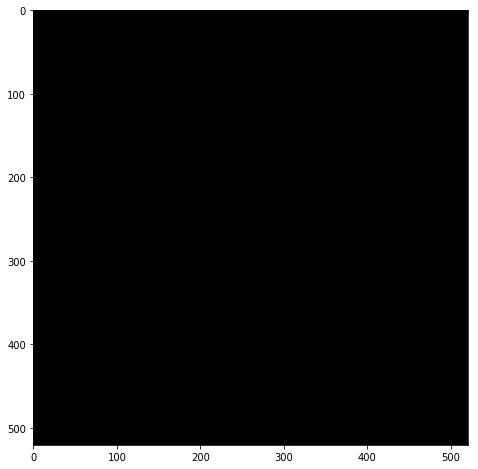

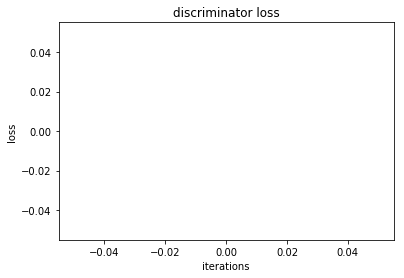

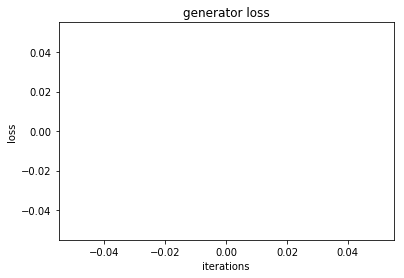

Iteration 398000/611000: dis loss = nan, gen loss = nan
Epoch 651 time is 33.54 [s]
Iteration 398500/611000: dis loss = nan, gen loss = nan
Epoch 652 time is 33.48 [s]
Iteration 399000/611000: dis loss = nan, gen loss = nan
Iteration 399500/611000: dis loss = nan, gen loss = nan
Epoch 653 time is 33.46 [s]
Iteration 400000/611000: dis loss = nan, gen loss = nan
Epoch 654 time is 33.39 [s]
Iteration 400500/611000: dis loss = nan, gen loss = nan
Epoch 655 time is 33.57 [s]


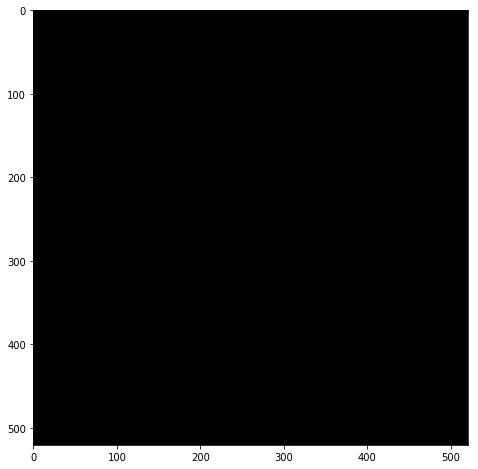

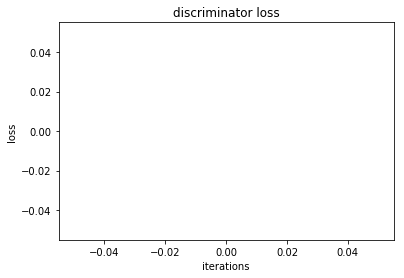

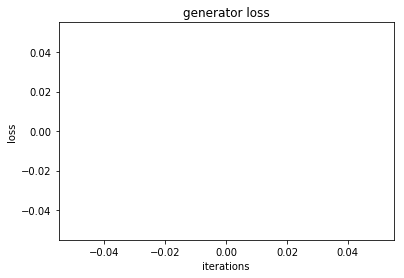

Iteration 401000/611000: dis loss = nan, gen loss = nan
Epoch 656 time is 33.42 [s]
Iteration 401500/611000: dis loss = nan, gen loss = nan
Iteration 402000/611000: dis loss = nan, gen loss = nan
Epoch 657 time is 33.50 [s]
Iteration 402500/611000: dis loss = nan, gen loss = nan
Epoch 658 time is 33.52 [s]
Iteration 403000/611000: dis loss = nan, gen loss = nan
Epoch 659 time is 33.43 [s]
Iteration 403500/611000: dis loss = nan, gen loss = nan
Epoch 660 time is 33.40 [s]


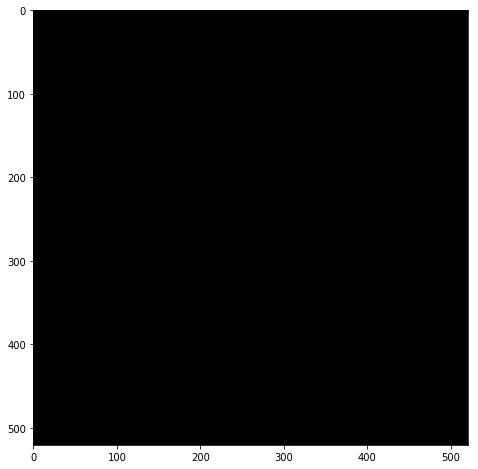

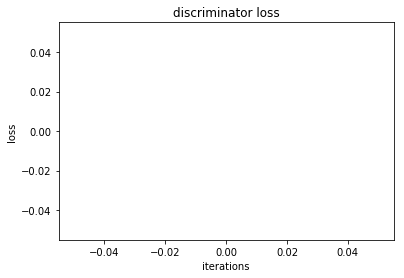

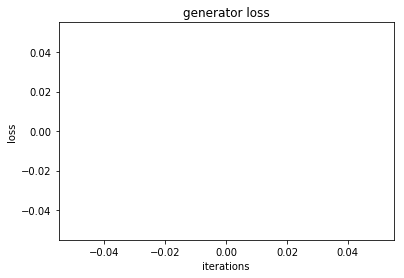

Iteration 404000/611000: dis loss = nan, gen loss = nan
Epoch 661 time is 33.46 [s]
Iteration 404500/611000: dis loss = nan, gen loss = nan
Iteration 405000/611000: dis loss = nan, gen loss = nan
Epoch 662 time is 33.50 [s]
Iteration 405500/611000: dis loss = nan, gen loss = nan
Epoch 663 time is 33.57 [s]
Iteration 406000/611000: dis loss = nan, gen loss = nan
Epoch 664 time is 33.50 [s]
Iteration 406500/611000: dis loss = nan, gen loss = nan
Epoch 665 time is 33.34 [s]


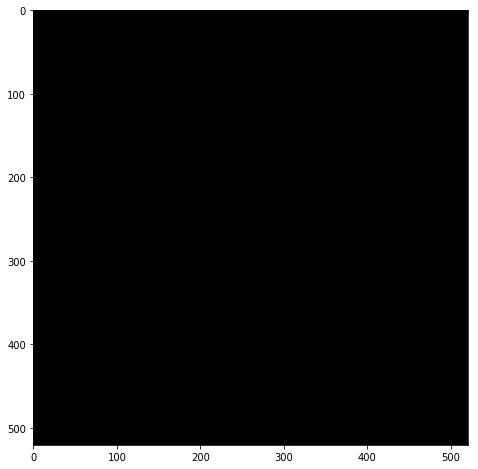

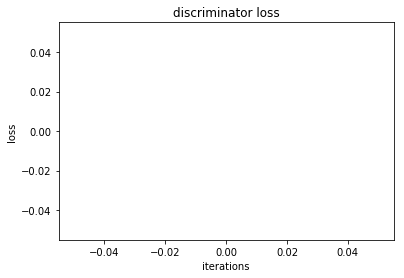

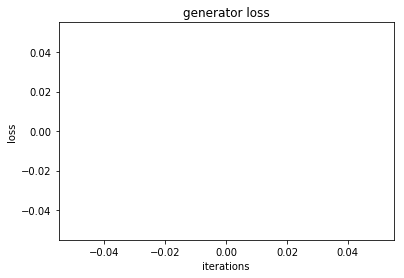

Iteration 407000/611000: dis loss = nan, gen loss = nan
Iteration 407500/611000: dis loss = nan, gen loss = nan
Epoch 666 time is 33.42 [s]
Iteration 408000/611000: dis loss = nan, gen loss = nan
Epoch 667 time is 33.54 [s]
Iteration 408500/611000: dis loss = nan, gen loss = nan
Epoch 668 time is 33.35 [s]
Iteration 409000/611000: dis loss = nan, gen loss = nan
Epoch 669 time is 33.56 [s]
Iteration 409500/611000: dis loss = nan, gen loss = nan
Epoch 670 time is 33.45 [s]


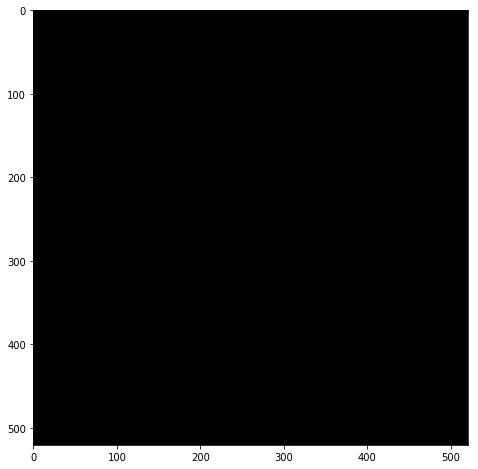

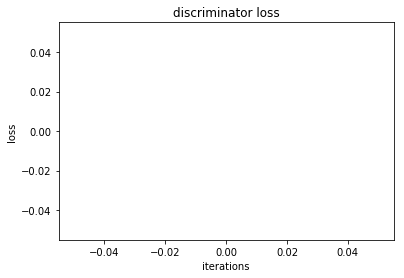

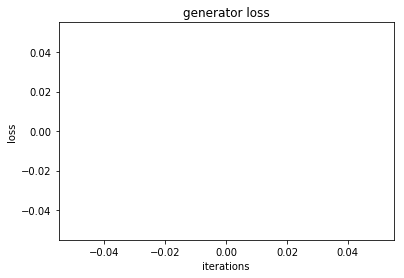

Iteration 410000/611000: dis loss = nan, gen loss = nan
Iteration 410500/611000: dis loss = nan, gen loss = nan
Epoch 671 time is 33.33 [s]
Iteration 411000/611000: dis loss = nan, gen loss = nan
Epoch 672 time is 33.51 [s]
Iteration 411500/611000: dis loss = nan, gen loss = nan
Epoch 673 time is 33.50 [s]
Iteration 412000/611000: dis loss = nan, gen loss = nan
Epoch 674 time is 33.41 [s]
Iteration 412500/611000: dis loss = nan, gen loss = nan
Iteration 413000/611000: dis loss = nan, gen loss = nan
Epoch 675 time is 33.46 [s]


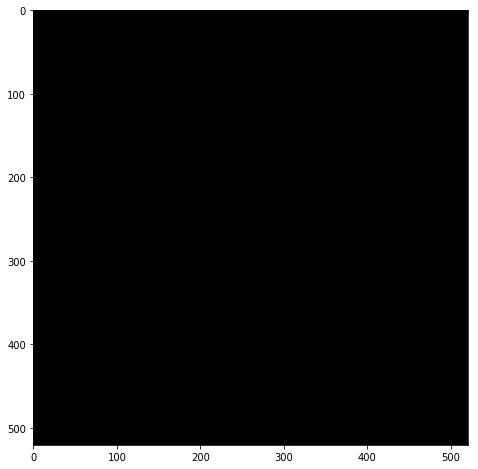

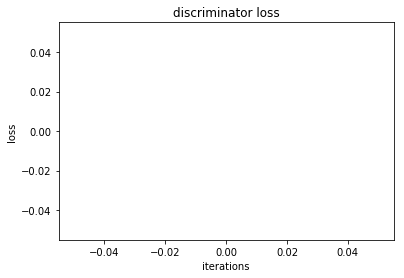

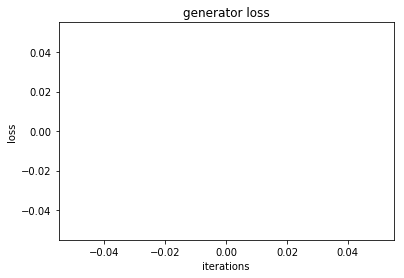

Iteration 413500/611000: dis loss = nan, gen loss = nan
Epoch 676 time is 33.49 [s]
Iteration 414000/611000: dis loss = nan, gen loss = nan
Epoch 677 time is 33.44 [s]
Iteration 414500/611000: dis loss = nan, gen loss = nan
Epoch 678 time is 33.47 [s]
Iteration 415000/611000: dis loss = nan, gen loss = nan
Epoch 679 time is 33.33 [s]
Iteration 415500/611000: dis loss = nan, gen loss = nan
Iteration 416000/611000: dis loss = nan, gen loss = nan
Epoch 680 time is 33.43 [s]


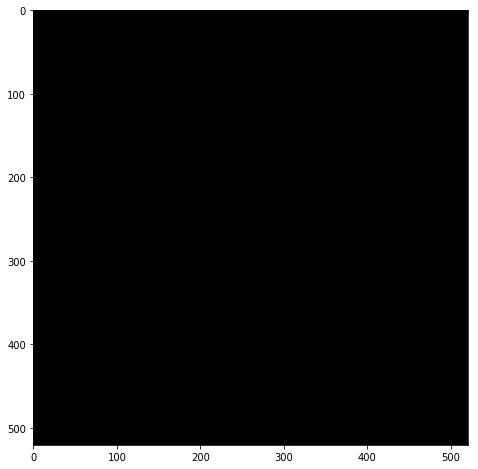

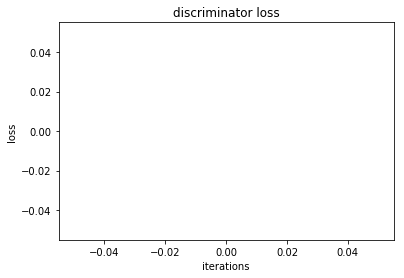

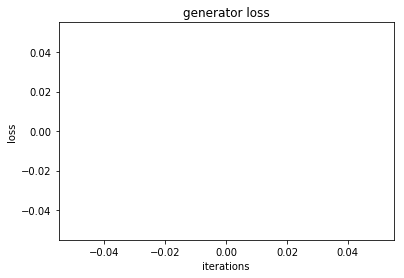

Iteration 416500/611000: dis loss = nan, gen loss = nan
Epoch 681 time is 33.55 [s]
Iteration 417000/611000: dis loss = nan, gen loss = nan
Epoch 682 time is 33.45 [s]
Iteration 417500/611000: dis loss = nan, gen loss = nan
Epoch 683 time is 33.42 [s]
Iteration 418000/611000: dis loss = nan, gen loss = nan
Iteration 418500/611000: dis loss = nan, gen loss = nan
Epoch 684 time is 33.38 [s]
Iteration 419000/611000: dis loss = nan, gen loss = nan
Epoch 685 time is 33.62 [s]


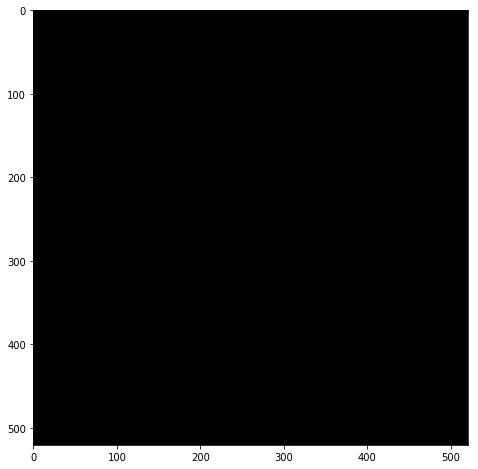

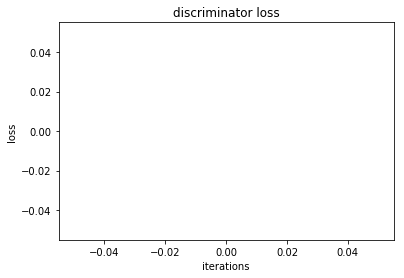

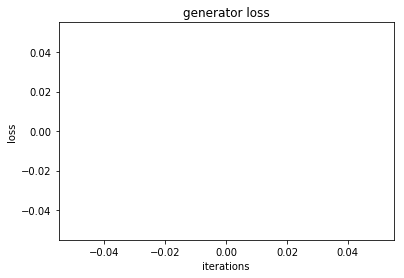

Iteration 419500/611000: dis loss = nan, gen loss = nan
Epoch 686 time is 33.53 [s]
Iteration 420000/611000: dis loss = nan, gen loss = nan
Epoch 687 time is 33.54 [s]
Iteration 420500/611000: dis loss = nan, gen loss = nan
Epoch 688 time is 33.35 [s]
Iteration 421000/611000: dis loss = nan, gen loss = nan
Iteration 421500/611000: dis loss = nan, gen loss = nan
Epoch 689 time is 33.49 [s]
Iteration 422000/611000: dis loss = nan, gen loss = nan
Epoch 690 time is 33.59 [s]


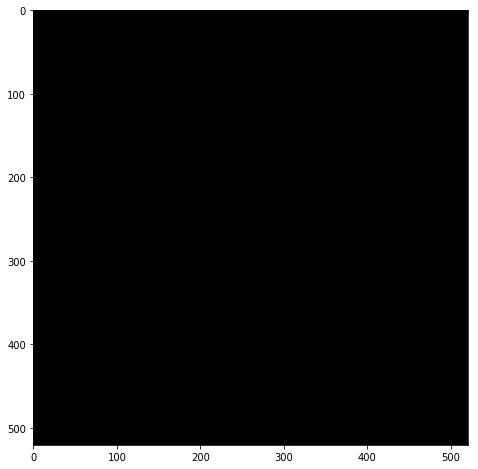

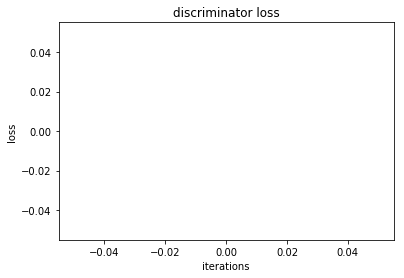

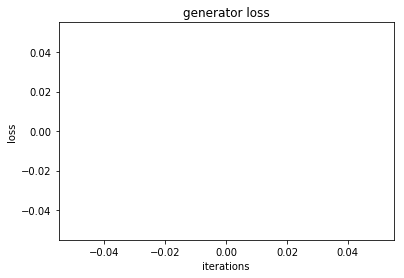

Iteration 422500/611000: dis loss = nan, gen loss = nan
Epoch 691 time is 33.41 [s]
Iteration 423000/611000: dis loss = nan, gen loss = nan
Epoch 692 time is 33.50 [s]
Iteration 423500/611000: dis loss = nan, gen loss = nan
Iteration 424000/611000: dis loss = nan, gen loss = nan
Epoch 693 time is 33.50 [s]
Iteration 424500/611000: dis loss = nan, gen loss = nan
Epoch 694 time is 33.57 [s]
Iteration 425000/611000: dis loss = nan, gen loss = nan
Epoch 695 time is 33.45 [s]


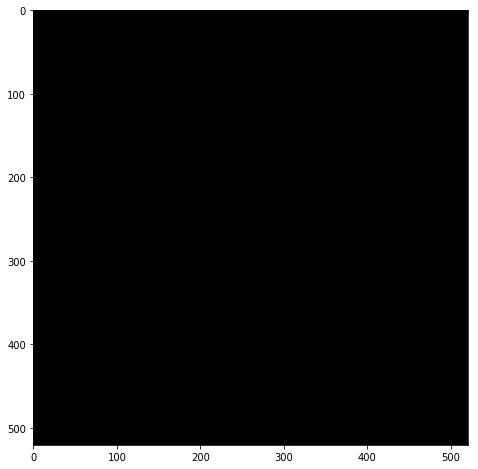

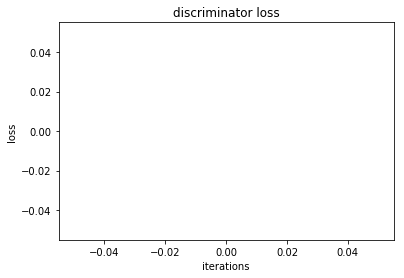

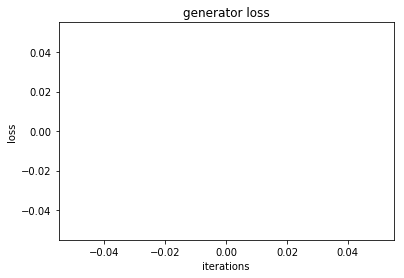

Iteration 425500/611000: dis loss = nan, gen loss = nan
Epoch 696 time is 33.53 [s]
Iteration 426000/611000: dis loss = nan, gen loss = nan
Epoch 697 time is 33.64 [s]
Iteration 426500/611000: dis loss = nan, gen loss = nan
Iteration 427000/611000: dis loss = nan, gen loss = nan
Epoch 698 time is 33.43 [s]
Iteration 427500/611000: dis loss = nan, gen loss = nan
Epoch 699 time is 33.48 [s]
Iteration 428000/611000: dis loss = nan, gen loss = nan
Epoch 700 time is 33.56 [s]


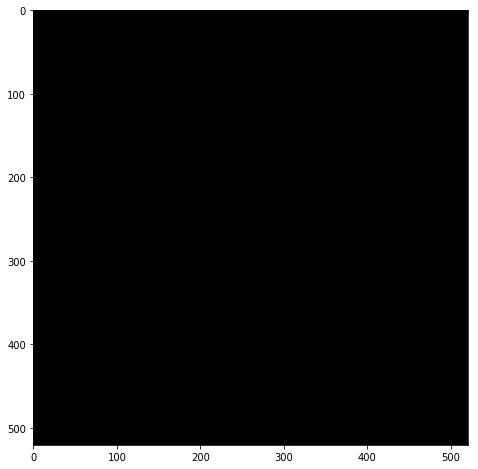

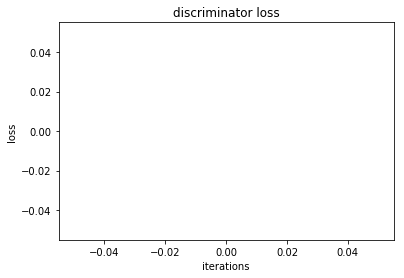

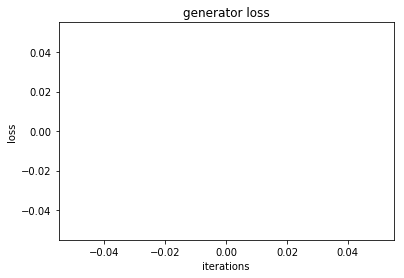

Iteration 428500/611000: dis loss = nan, gen loss = nan
Epoch 701 time is 33.51 [s]
Iteration 429000/611000: dis loss = nan, gen loss = nan
Iteration 429500/611000: dis loss = nan, gen loss = nan
Epoch 702 time is 33.54 [s]
Iteration 430000/611000: dis loss = nan, gen loss = nan
Epoch 703 time is 33.51 [s]
Iteration 430500/611000: dis loss = nan, gen loss = nan
Epoch 704 time is 33.56 [s]
Iteration 431000/611000: dis loss = nan, gen loss = nan
Epoch 705 time is 33.36 [s]


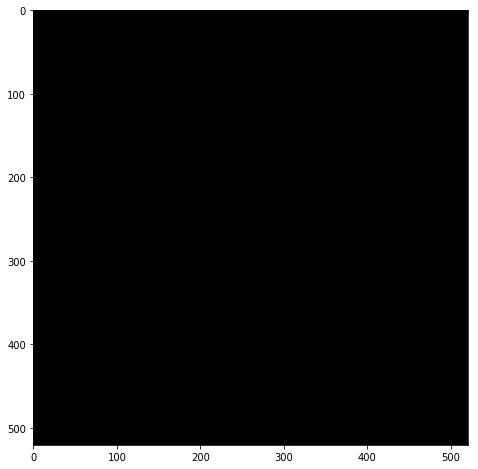

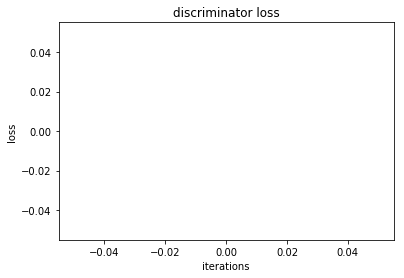

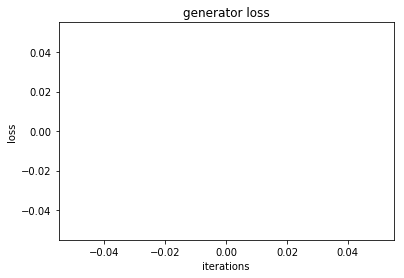

Iteration 431500/611000: dis loss = nan, gen loss = nan
Epoch 706 time is 33.28 [s]
Iteration 432000/611000: dis loss = nan, gen loss = nan
Iteration 432500/611000: dis loss = nan, gen loss = nan
Epoch 707 time is 33.35 [s]
Iteration 433000/611000: dis loss = nan, gen loss = nan
Epoch 708 time is 33.36 [s]
Iteration 433500/611000: dis loss = nan, gen loss = nan
Epoch 709 time is 33.37 [s]
Iteration 434000/611000: dis loss = nan, gen loss = nan
Epoch 710 time is 33.47 [s]


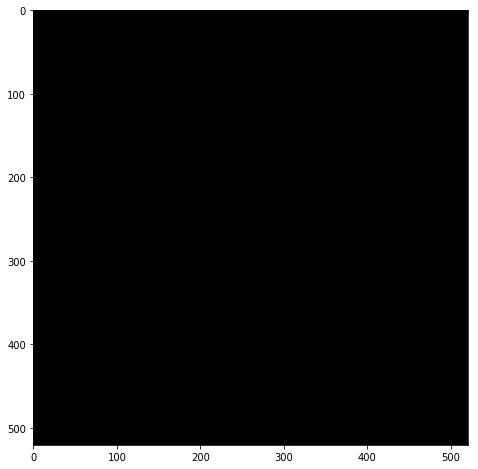

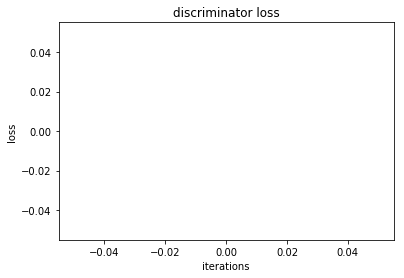

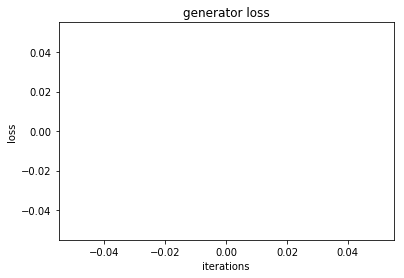

Iteration 434500/611000: dis loss = nan, gen loss = nan
Iteration 435000/611000: dis loss = nan, gen loss = nan
Epoch 711 time is 33.33 [s]
Iteration 435500/611000: dis loss = nan, gen loss = nan
Epoch 712 time is 33.42 [s]
Iteration 436000/611000: dis loss = nan, gen loss = nan
Epoch 713 time is 33.41 [s]
Iteration 436500/611000: dis loss = nan, gen loss = nan
Epoch 714 time is 33.38 [s]
Iteration 437000/611000: dis loss = nan, gen loss = nan
Epoch 715 time is 33.39 [s]


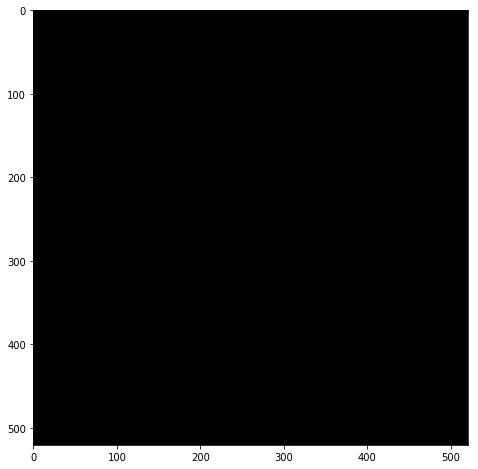

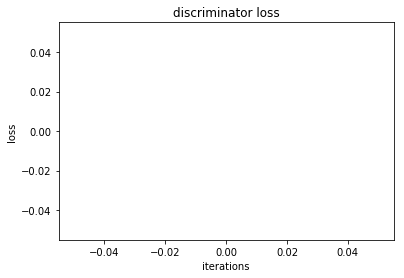

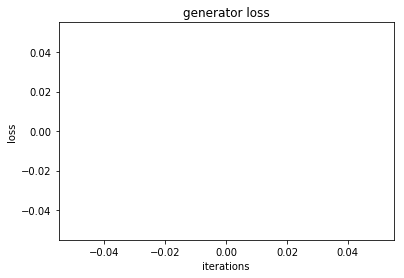

Iteration 437500/611000: dis loss = nan, gen loss = nan
Iteration 438000/611000: dis loss = nan, gen loss = nan
Epoch 716 time is 33.34 [s]
Iteration 438500/611000: dis loss = nan, gen loss = nan
Epoch 717 time is 33.33 [s]
Iteration 439000/611000: dis loss = nan, gen loss = nan
Epoch 718 time is 33.37 [s]
Iteration 439500/611000: dis loss = nan, gen loss = nan
Epoch 719 time is 33.28 [s]
Iteration 440000/611000: dis loss = nan, gen loss = nan
Iteration 440500/611000: dis loss = nan, gen loss = nan
Epoch 720 time is 33.18 [s]


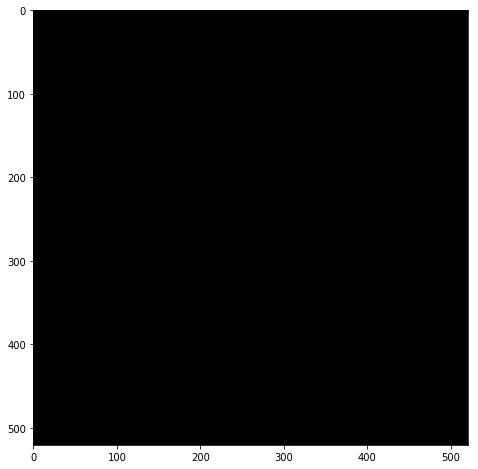

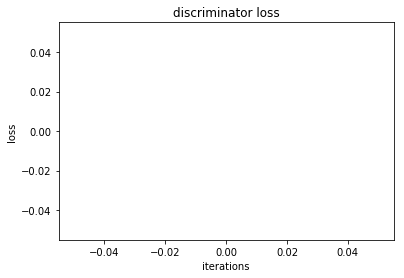

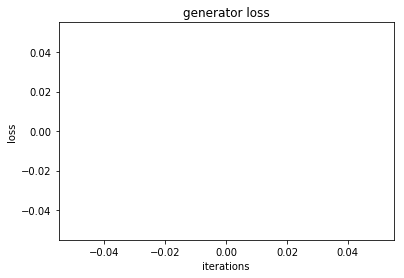

Iteration 441000/611000: dis loss = nan, gen loss = nan
Epoch 721 time is 33.34 [s]
Iteration 441500/611000: dis loss = nan, gen loss = nan
Epoch 722 time is 33.28 [s]
Iteration 442000/611000: dis loss = nan, gen loss = nan
Epoch 723 time is 33.43 [s]
Iteration 442500/611000: dis loss = nan, gen loss = nan
Epoch 724 time is 33.28 [s]
Iteration 443000/611000: dis loss = nan, gen loss = nan
Iteration 443500/611000: dis loss = nan, gen loss = nan
Epoch 725 time is 33.31 [s]


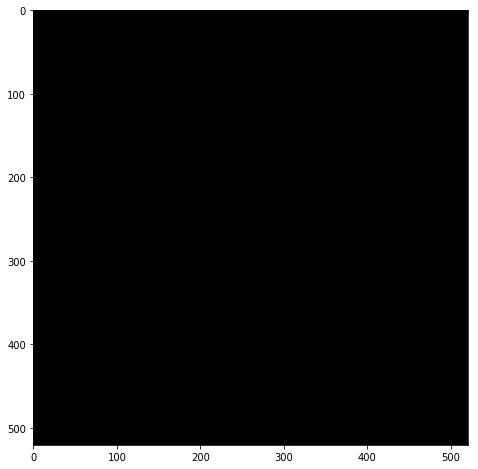

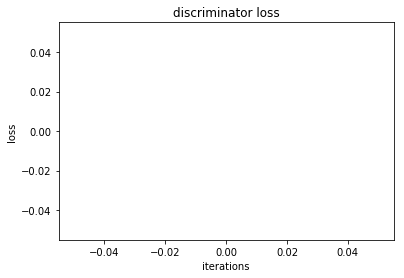

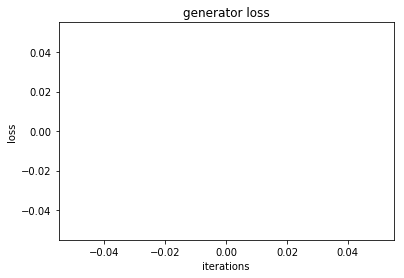

Iteration 444000/611000: dis loss = nan, gen loss = nan
Epoch 726 time is 33.33 [s]
Iteration 444500/611000: dis loss = nan, gen loss = nan
Epoch 727 time is 33.34 [s]
Iteration 445000/611000: dis loss = nan, gen loss = nan
Epoch 728 time is 33.28 [s]
Iteration 445500/611000: dis loss = nan, gen loss = nan
Iteration 446000/611000: dis loss = nan, gen loss = nan
Epoch 729 time is 33.30 [s]
Iteration 446500/611000: dis loss = nan, gen loss = nan
Epoch 730 time is 33.30 [s]


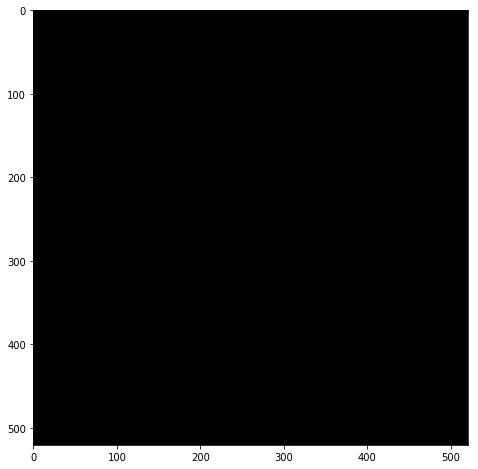

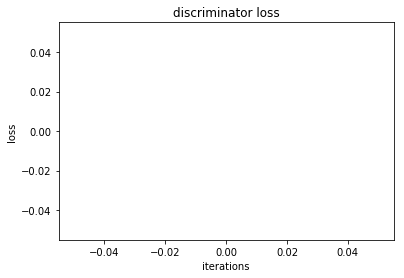

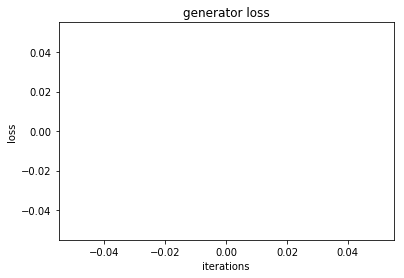

Iteration 447000/611000: dis loss = nan, gen loss = nan
Epoch 731 time is 33.53 [s]
Iteration 447500/611000: dis loss = nan, gen loss = nan
Epoch 732 time is 33.52 [s]
Iteration 448000/611000: dis loss = nan, gen loss = nan
Epoch 733 time is 33.41 [s]
Iteration 448500/611000: dis loss = nan, gen loss = nan
Iteration 449000/611000: dis loss = nan, gen loss = nan
Epoch 734 time is 33.44 [s]
Iteration 449500/611000: dis loss = nan, gen loss = nan
Epoch 735 time is 33.39 [s]


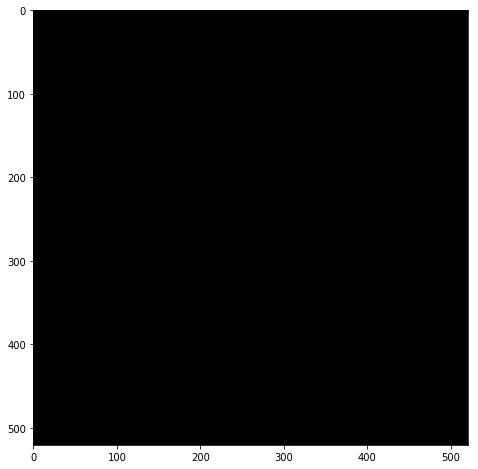

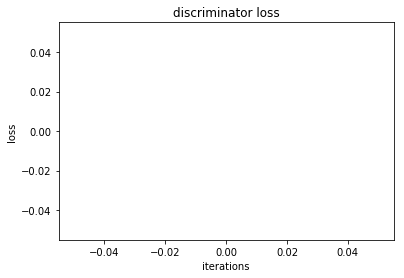

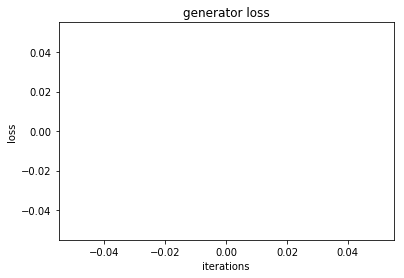

Iteration 450000/611000: dis loss = nan, gen loss = nan
Epoch 736 time is 33.34 [s]
Iteration 450500/611000: dis loss = nan, gen loss = nan
Epoch 737 time is 33.18 [s]
Iteration 451000/611000: dis loss = nan, gen loss = nan
Iteration 451500/611000: dis loss = nan, gen loss = nan
Epoch 738 time is 33.37 [s]
Iteration 452000/611000: dis loss = nan, gen loss = nan
Epoch 739 time is 33.25 [s]
Iteration 452500/611000: dis loss = nan, gen loss = nan
Epoch 740 time is 33.30 [s]


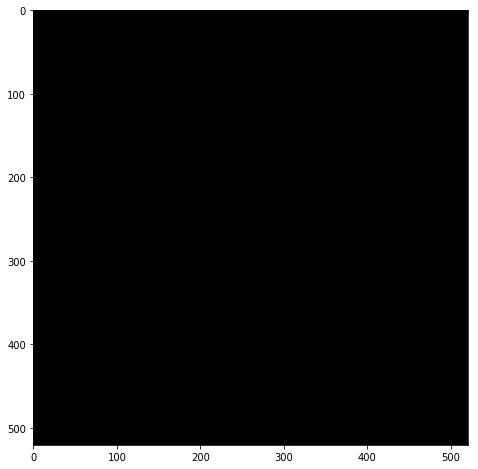

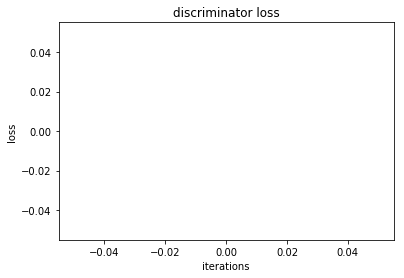

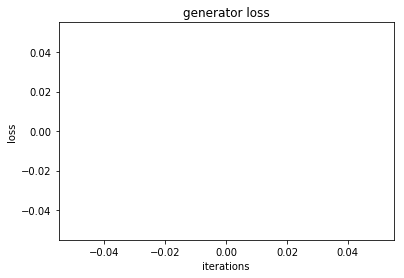

Iteration 453000/611000: dis loss = nan, gen loss = nan
Epoch 741 time is 33.47 [s]
Iteration 453500/611000: dis loss = nan, gen loss = nan
Epoch 742 time is 33.52 [s]
Iteration 454000/611000: dis loss = nan, gen loss = nan
Iteration 454500/611000: dis loss = nan, gen loss = nan
Epoch 743 time is 33.35 [s]
Iteration 455000/611000: dis loss = nan, gen loss = nan
Epoch 744 time is 33.38 [s]
Iteration 455500/611000: dis loss = nan, gen loss = nan
Epoch 745 time is 33.49 [s]


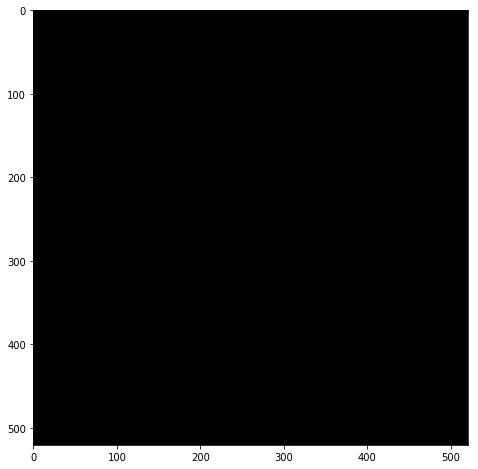

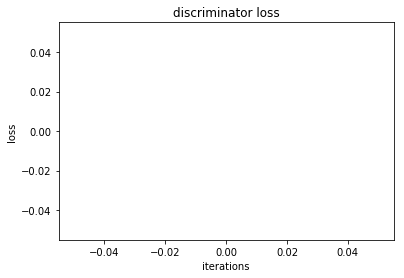

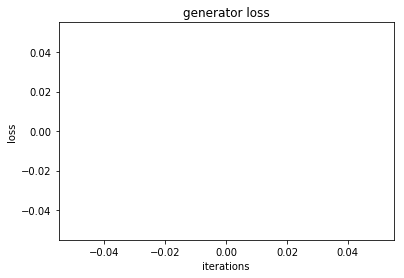

Iteration 456000/611000: dis loss = nan, gen loss = nan
Epoch 746 time is 33.46 [s]
Iteration 456500/611000: dis loss = nan, gen loss = nan
Iteration 457000/611000: dis loss = nan, gen loss = nan
Epoch 747 time is 33.58 [s]
Iteration 457500/611000: dis loss = nan, gen loss = nan
Epoch 748 time is 33.43 [s]
Iteration 458000/611000: dis loss = nan, gen loss = nan
Epoch 749 time is 33.45 [s]
Iteration 458500/611000: dis loss = nan, gen loss = nan
Epoch 750 time is 33.47 [s]


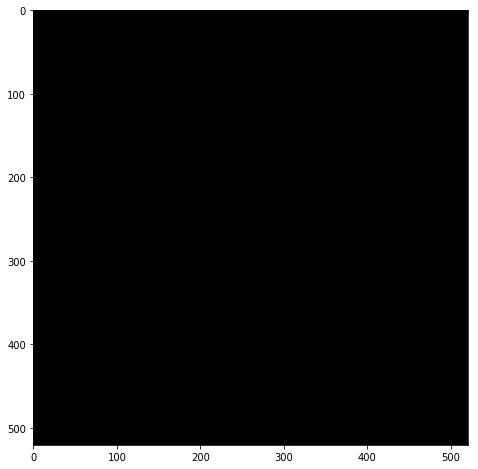

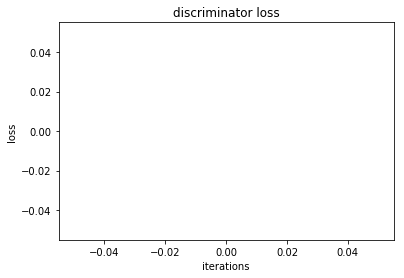

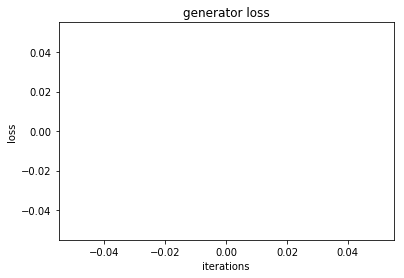

Iteration 459000/611000: dis loss = nan, gen loss = nan
Epoch 751 time is 33.56 [s]
Iteration 459500/611000: dis loss = nan, gen loss = nan
Iteration 460000/611000: dis loss = nan, gen loss = nan
Epoch 752 time is 33.46 [s]
Iteration 460500/611000: dis loss = nan, gen loss = nan
Epoch 753 time is 33.48 [s]
Iteration 461000/611000: dis loss = nan, gen loss = nan
Epoch 754 time is 33.53 [s]
Iteration 461500/611000: dis loss = nan, gen loss = nan
Epoch 755 time is 33.49 [s]


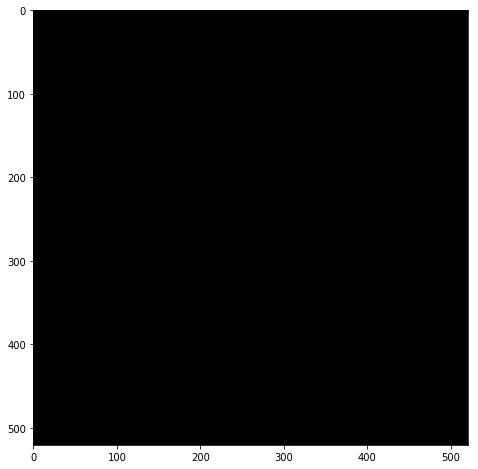

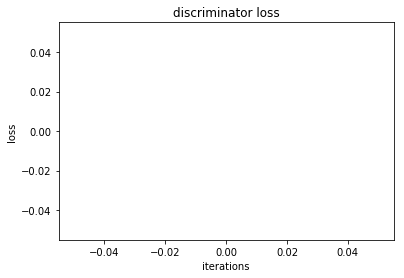

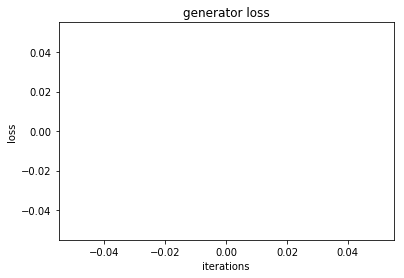

Iteration 462000/611000: dis loss = nan, gen loss = nan
Iteration 462500/611000: dis loss = nan, gen loss = nan
Epoch 756 time is 33.37 [s]
Iteration 463000/611000: dis loss = nan, gen loss = nan
Epoch 757 time is 33.44 [s]
Iteration 463500/611000: dis loss = nan, gen loss = nan
Epoch 758 time is 33.44 [s]
Iteration 464000/611000: dis loss = nan, gen loss = nan
Epoch 759 time is 33.35 [s]
Iteration 464500/611000: dis loss = nan, gen loss = nan
Epoch 760 time is 33.37 [s]


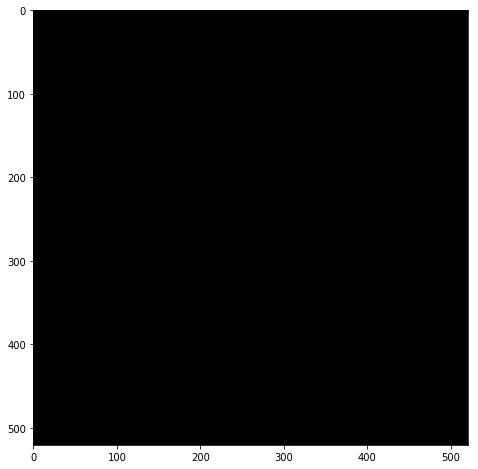

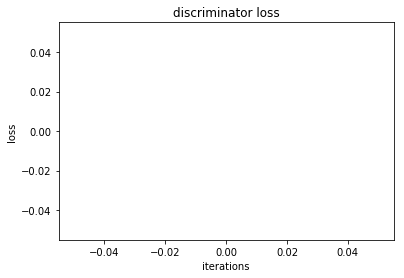

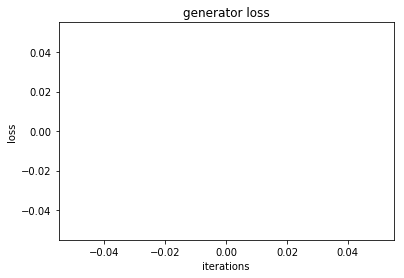

Iteration 465000/611000: dis loss = nan, gen loss = nan
Iteration 465500/611000: dis loss = nan, gen loss = nan
Epoch 761 time is 33.33 [s]
Iteration 466000/611000: dis loss = nan, gen loss = nan
Epoch 762 time is 33.46 [s]
Iteration 466500/611000: dis loss = nan, gen loss = nan
Epoch 763 time is 33.38 [s]
Iteration 467000/611000: dis loss = nan, gen loss = nan
Epoch 764 time is 33.47 [s]
Iteration 467500/611000: dis loss = nan, gen loss = nan
Iteration 468000/611000: dis loss = nan, gen loss = nan
Epoch 765 time is 33.48 [s]


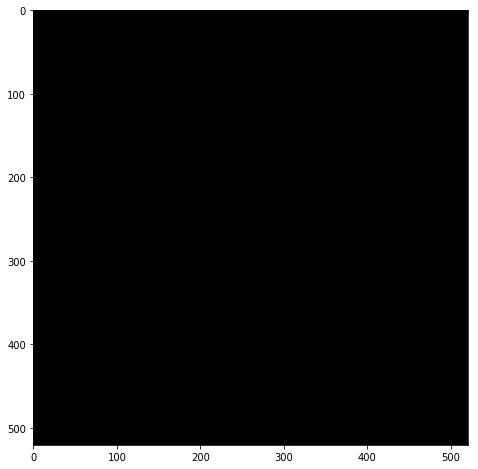

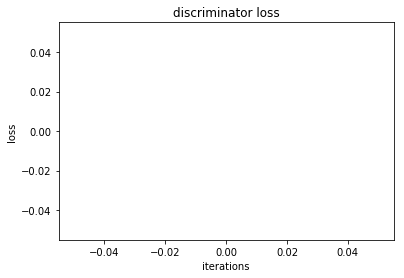

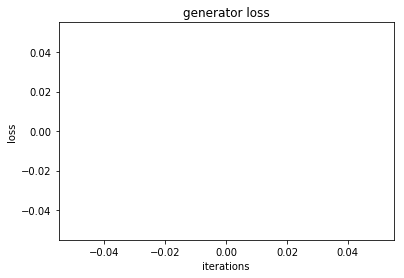

Iteration 468500/611000: dis loss = nan, gen loss = nan
Epoch 766 time is 33.44 [s]
Iteration 469000/611000: dis loss = nan, gen loss = nan
Epoch 767 time is 33.46 [s]
Iteration 469500/611000: dis loss = nan, gen loss = nan
Epoch 768 time is 33.53 [s]
Iteration 470000/611000: dis loss = nan, gen loss = nan
Epoch 769 time is 33.34 [s]
Iteration 470500/611000: dis loss = nan, gen loss = nan
Iteration 471000/611000: dis loss = nan, gen loss = nan
Epoch 770 time is 33.38 [s]


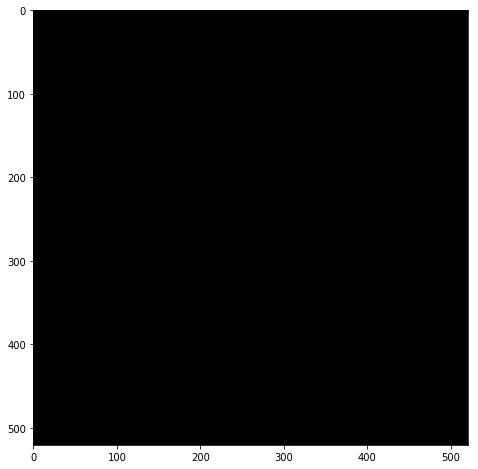

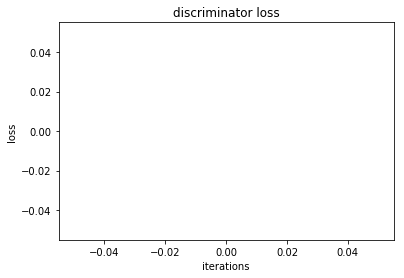

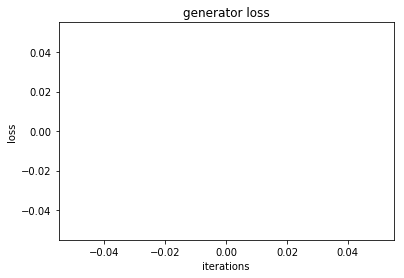

Iteration 471500/611000: dis loss = nan, gen loss = nan
Epoch 771 time is 33.44 [s]
Iteration 472000/611000: dis loss = nan, gen loss = nan
Epoch 772 time is 33.47 [s]
Iteration 472500/611000: dis loss = nan, gen loss = nan
Epoch 773 time is 33.46 [s]
Iteration 473000/611000: dis loss = nan, gen loss = nan
Iteration 473500/611000: dis loss = nan, gen loss = nan
Epoch 774 time is 33.37 [s]
Iteration 474000/611000: dis loss = nan, gen loss = nan
Epoch 775 time is 33.38 [s]


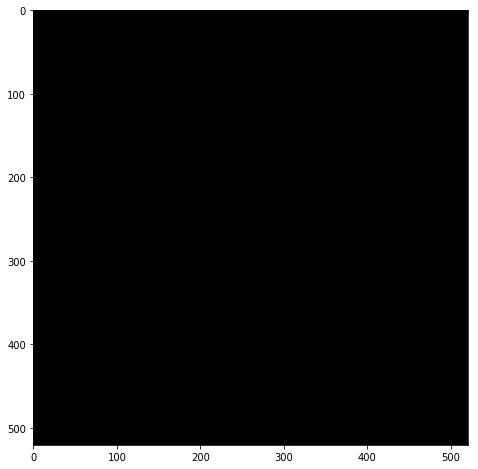

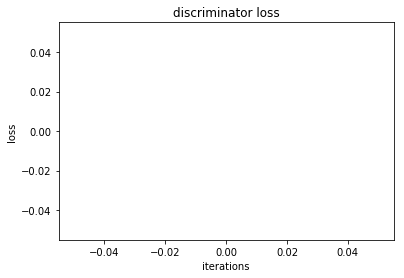

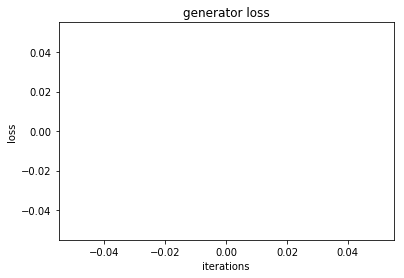

Iteration 474500/611000: dis loss = nan, gen loss = nan
Epoch 776 time is 33.50 [s]
Iteration 475000/611000: dis loss = nan, gen loss = nan
Epoch 777 time is 33.53 [s]
Iteration 475500/611000: dis loss = nan, gen loss = nan
Epoch 778 time is 33.52 [s]
Iteration 476000/611000: dis loss = nan, gen loss = nan
Iteration 476500/611000: dis loss = nan, gen loss = nan
Epoch 779 time is 33.47 [s]
Iteration 477000/611000: dis loss = nan, gen loss = nan
Epoch 780 time is 33.49 [s]


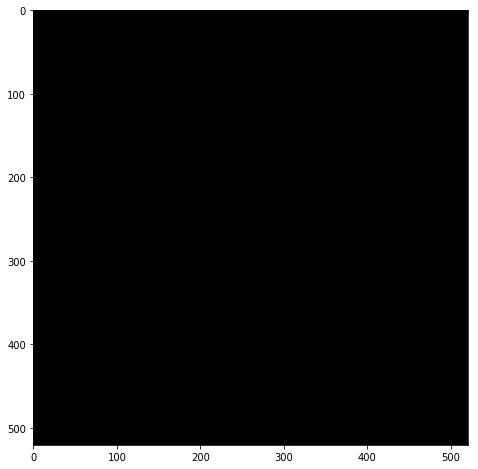

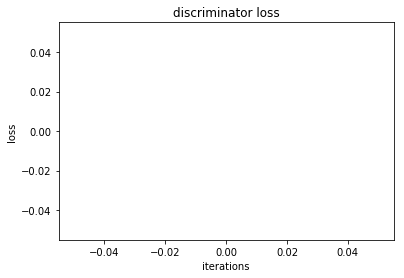

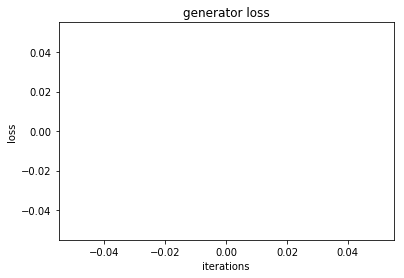

Iteration 477500/611000: dis loss = nan, gen loss = nan
Epoch 781 time is 33.44 [s]
Iteration 478000/611000: dis loss = nan, gen loss = nan
Epoch 782 time is 33.47 [s]
Iteration 478500/611000: dis loss = nan, gen loss = nan
Iteration 479000/611000: dis loss = nan, gen loss = nan
Epoch 783 time is 33.56 [s]
Iteration 479500/611000: dis loss = nan, gen loss = nan
Epoch 784 time is 33.53 [s]
Iteration 480000/611000: dis loss = nan, gen loss = nan
Epoch 785 time is 33.55 [s]


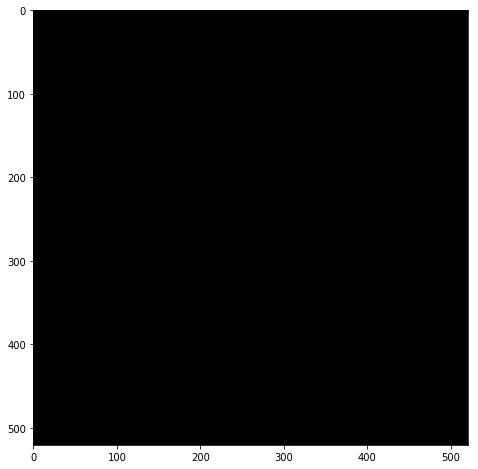

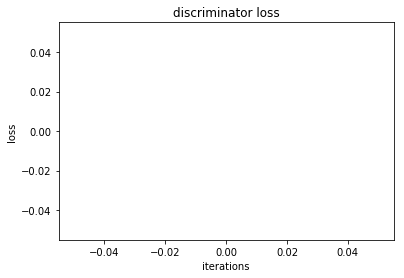

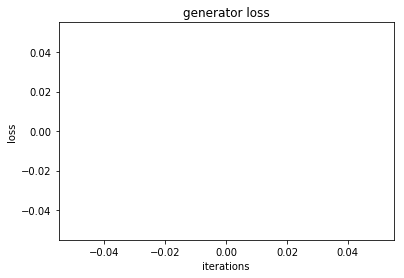

Iteration 480500/611000: dis loss = nan, gen loss = nan
Epoch 786 time is 33.34 [s]
Iteration 481000/611000: dis loss = nan, gen loss = nan
Epoch 787 time is 33.42 [s]
Iteration 481500/611000: dis loss = nan, gen loss = nan
Iteration 482000/611000: dis loss = nan, gen loss = nan
Epoch 788 time is 33.37 [s]
Iteration 482500/611000: dis loss = nan, gen loss = nan
Epoch 789 time is 33.40 [s]
Iteration 483000/611000: dis loss = nan, gen loss = nan
Epoch 790 time is 33.53 [s]


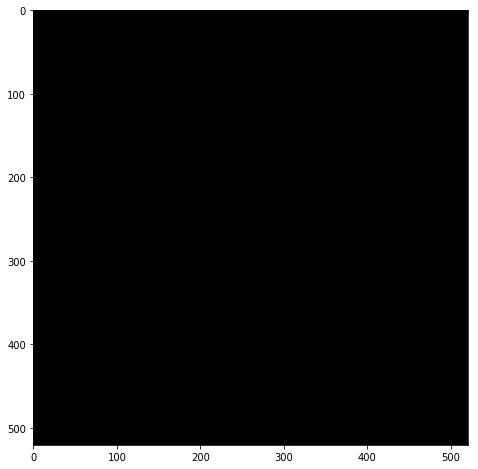

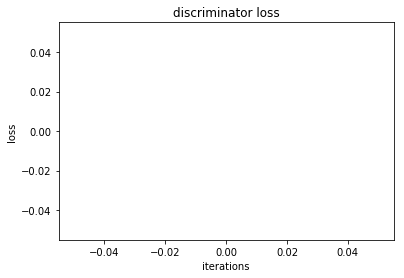

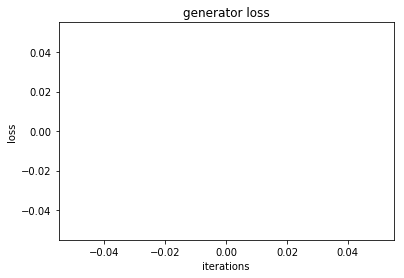

Iteration 483500/611000: dis loss = nan, gen loss = nan
Epoch 791 time is 33.35 [s]
Iteration 484000/611000: dis loss = nan, gen loss = nan
Iteration 484500/611000: dis loss = nan, gen loss = nan
Epoch 792 time is 33.40 [s]
Iteration 485000/611000: dis loss = nan, gen loss = nan
Epoch 793 time is 33.51 [s]
Iteration 485500/611000: dis loss = nan, gen loss = nan
Epoch 794 time is 33.54 [s]
Iteration 486000/611000: dis loss = nan, gen loss = nan
Epoch 795 time is 33.50 [s]


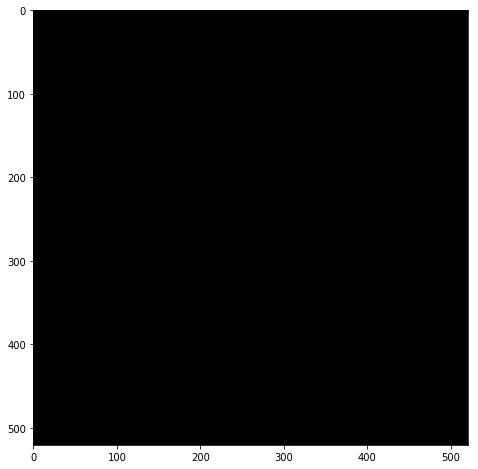

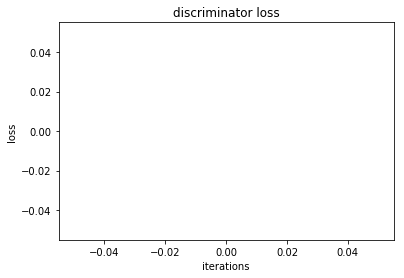

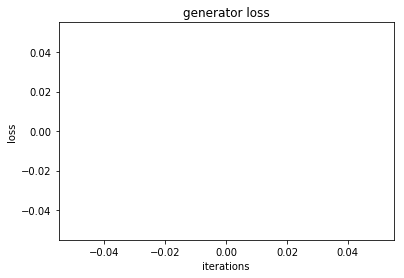

Iteration 486500/611000: dis loss = nan, gen loss = nan
Epoch 796 time is 33.36 [s]
Iteration 487000/611000: dis loss = nan, gen loss = nan
Iteration 487500/611000: dis loss = nan, gen loss = nan
Epoch 797 time is 33.49 [s]
Iteration 488000/611000: dis loss = nan, gen loss = nan
Epoch 798 time is 33.41 [s]
Iteration 488500/611000: dis loss = nan, gen loss = nan
Epoch 799 time is 33.43 [s]
Iteration 489000/611000: dis loss = nan, gen loss = nan
Epoch 800 time is 33.50 [s]


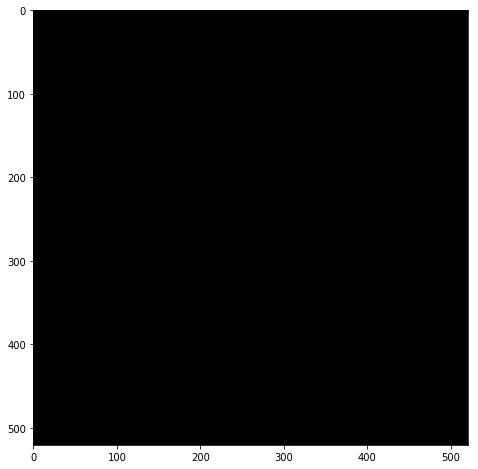

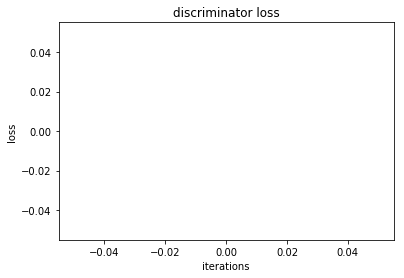

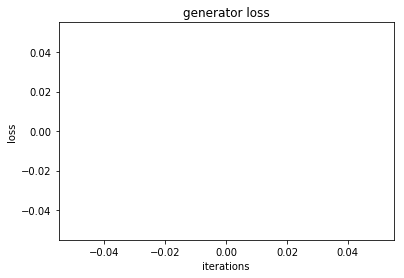

Iteration 489500/611000: dis loss = nan, gen loss = nan
Iteration 490000/611000: dis loss = nan, gen loss = nan
Epoch 801 time is 33.44 [s]
Iteration 490500/611000: dis loss = nan, gen loss = nan
Epoch 802 time is 33.23 [s]
Iteration 491000/611000: dis loss = nan, gen loss = nan
Epoch 803 time is 33.51 [s]
Iteration 491500/611000: dis loss = nan, gen loss = nan
Epoch 804 time is 33.28 [s]
Iteration 492000/611000: dis loss = nan, gen loss = nan
Epoch 805 time is 33.38 [s]


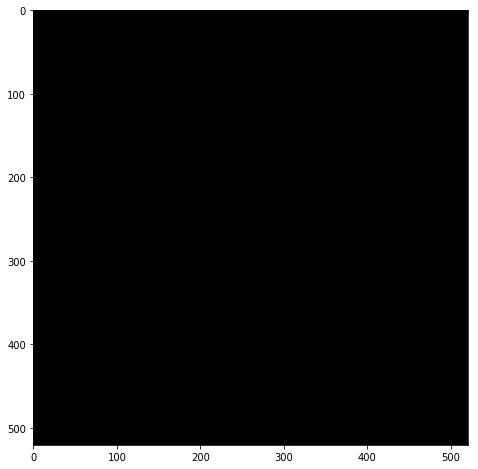

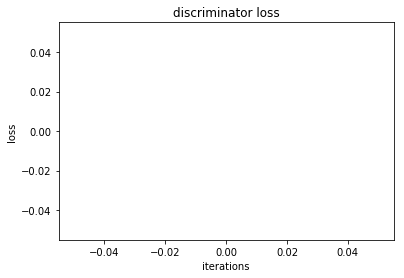

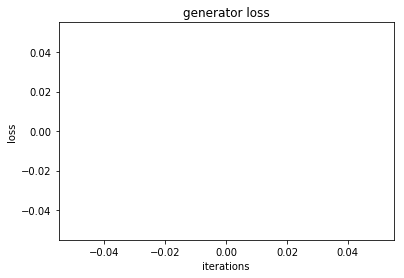

Iteration 492500/611000: dis loss = nan, gen loss = nan
Iteration 493000/611000: dis loss = nan, gen loss = nan
Epoch 806 time is 33.27 [s]
Iteration 493500/611000: dis loss = nan, gen loss = nan
Epoch 807 time is 33.20 [s]
Iteration 494000/611000: dis loss = nan, gen loss = nan
Epoch 808 time is 33.30 [s]
Iteration 494500/611000: dis loss = nan, gen loss = nan
Epoch 809 time is 33.26 [s]
Iteration 495000/611000: dis loss = nan, gen loss = nan
Iteration 495500/611000: dis loss = nan, gen loss = nan
Epoch 810 time is 33.32 [s]


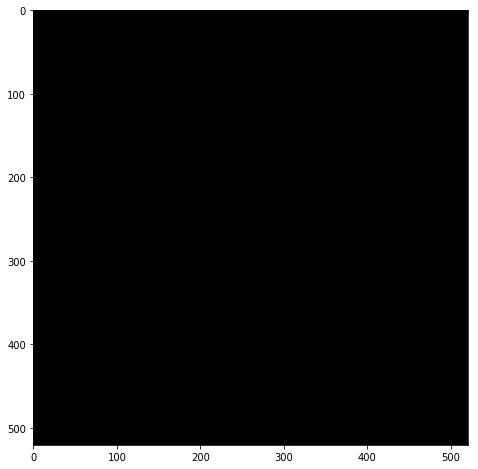

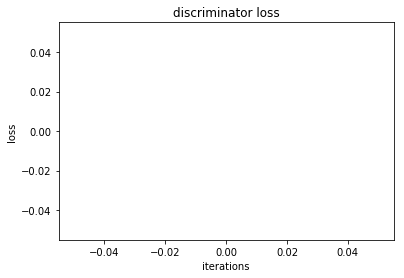

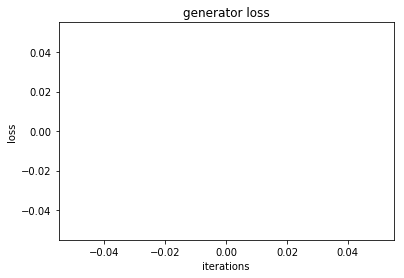

Iteration 496000/611000: dis loss = nan, gen loss = nan
Epoch 811 time is 33.41 [s]
Iteration 496500/611000: dis loss = nan, gen loss = nan
Epoch 812 time is 33.55 [s]
Iteration 497000/611000: dis loss = nan, gen loss = nan
Epoch 813 time is 33.48 [s]
Iteration 497500/611000: dis loss = nan, gen loss = nan
Epoch 814 time is 33.56 [s]
Iteration 498000/611000: dis loss = nan, gen loss = nan
Iteration 498500/611000: dis loss = nan, gen loss = nan
Epoch 815 time is 33.43 [s]


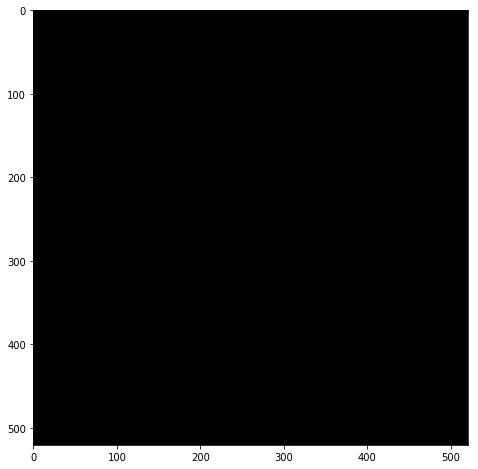

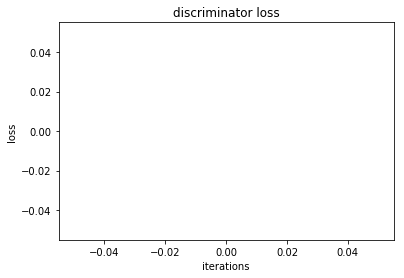

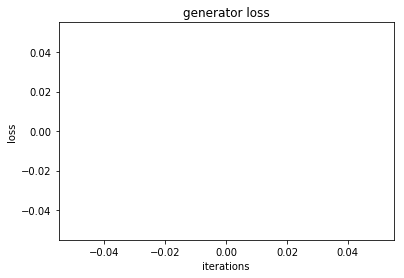

Iteration 499000/611000: dis loss = nan, gen loss = nan
Epoch 816 time is 33.29 [s]
Iteration 499500/611000: dis loss = nan, gen loss = nan
Epoch 817 time is 33.35 [s]
Iteration 500000/611000: dis loss = nan, gen loss = nan
Epoch 818 time is 33.31 [s]
Iteration 500500/611000: dis loss = nan, gen loss = nan
Iteration 501000/611000: dis loss = nan, gen loss = nan
Epoch 819 time is 33.42 [s]
Iteration 501500/611000: dis loss = nan, gen loss = nan
Epoch 820 time is 33.32 [s]


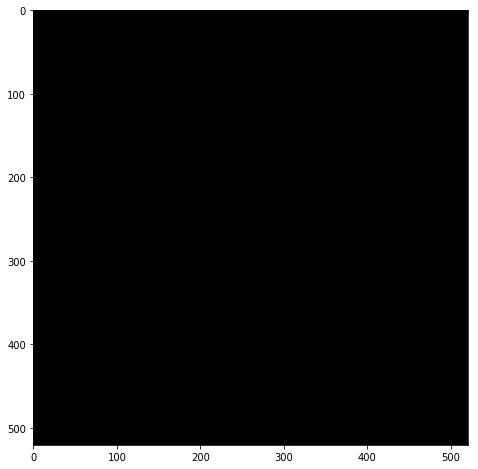

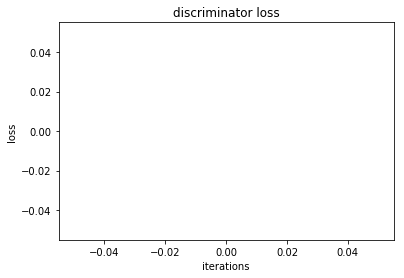

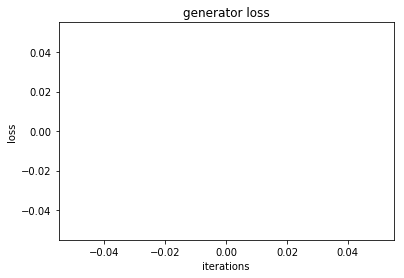

Iteration 502000/611000: dis loss = nan, gen loss = nan
Epoch 821 time is 33.47 [s]
Iteration 502500/611000: dis loss = nan, gen loss = nan
Epoch 822 time is 33.36 [s]
Iteration 503000/611000: dis loss = nan, gen loss = nan
Epoch 823 time is 33.53 [s]
Iteration 503500/611000: dis loss = nan, gen loss = nan
Iteration 504000/611000: dis loss = nan, gen loss = nan
Epoch 824 time is 33.50 [s]
Iteration 504500/611000: dis loss = nan, gen loss = nan
Epoch 825 time is 33.41 [s]


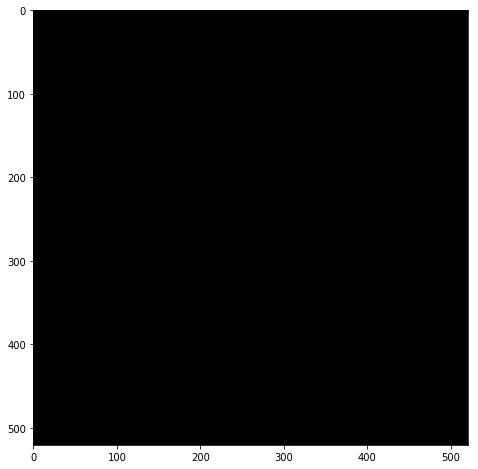

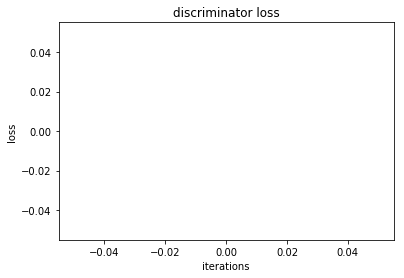

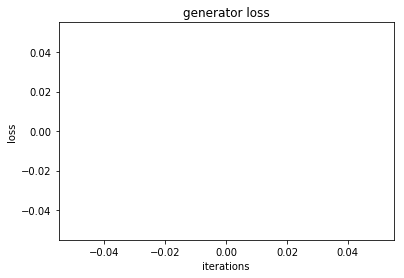

Iteration 505000/611000: dis loss = nan, gen loss = nan
Epoch 826 time is 33.37 [s]
Iteration 505500/611000: dis loss = nan, gen loss = nan
Epoch 827 time is 33.60 [s]
Iteration 506000/611000: dis loss = nan, gen loss = nan
Iteration 506500/611000: dis loss = nan, gen loss = nan
Epoch 828 time is 33.49 [s]
Iteration 507000/611000: dis loss = nan, gen loss = nan
Epoch 829 time is 33.42 [s]
Iteration 507500/611000: dis loss = nan, gen loss = nan
Epoch 830 time is 33.47 [s]


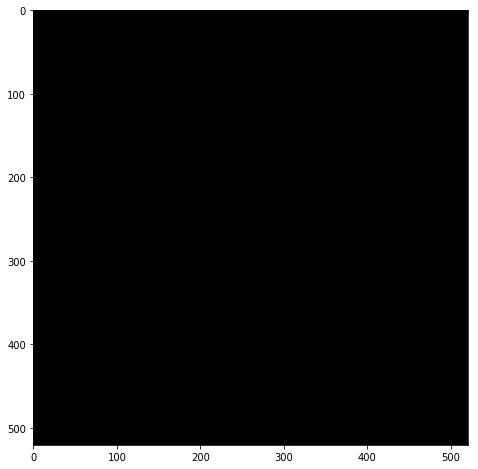

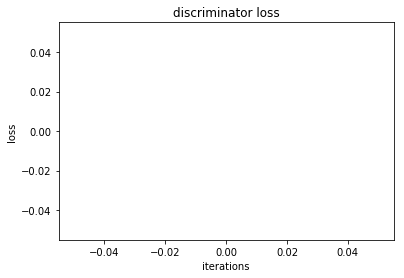

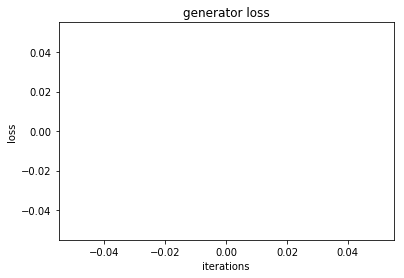

Iteration 508000/611000: dis loss = nan, gen loss = nan
Epoch 831 time is 33.38 [s]
Iteration 508500/611000: dis loss = nan, gen loss = nan
Epoch 832 time is 33.51 [s]
Iteration 509000/611000: dis loss = nan, gen loss = nan
Iteration 509500/611000: dis loss = nan, gen loss = nan
Epoch 833 time is 33.51 [s]
Iteration 510000/611000: dis loss = nan, gen loss = nan
Epoch 834 time is 33.37 [s]
Iteration 510500/611000: dis loss = nan, gen loss = nan
Epoch 835 time is 33.38 [s]


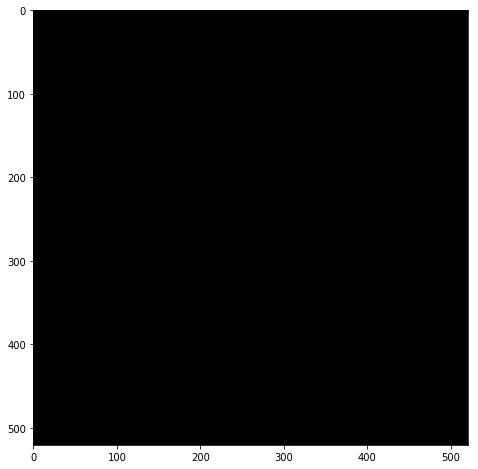

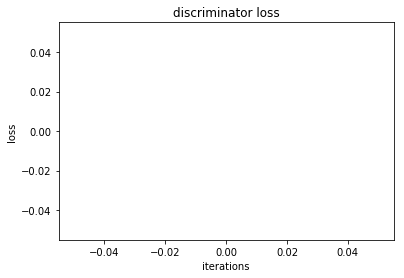

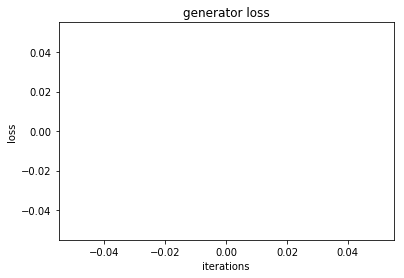

Iteration 511000/611000: dis loss = nan, gen loss = nan
Epoch 836 time is 33.45 [s]
Iteration 511500/611000: dis loss = nan, gen loss = nan
Iteration 512000/611000: dis loss = nan, gen loss = nan
Epoch 837 time is 33.34 [s]
Iteration 512500/611000: dis loss = nan, gen loss = nan
Epoch 838 time is 33.54 [s]
Iteration 513000/611000: dis loss = nan, gen loss = nan
Epoch 839 time is 33.50 [s]
Iteration 513500/611000: dis loss = nan, gen loss = nan
Epoch 840 time is 33.45 [s]


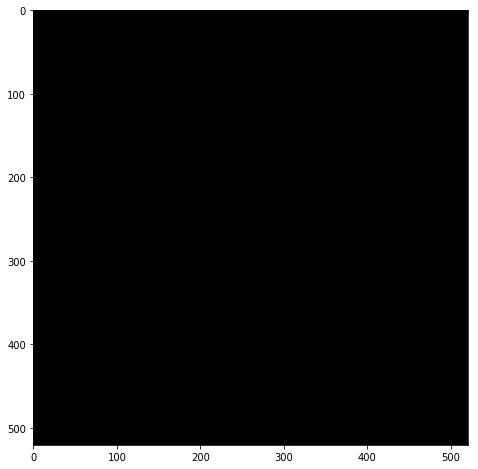

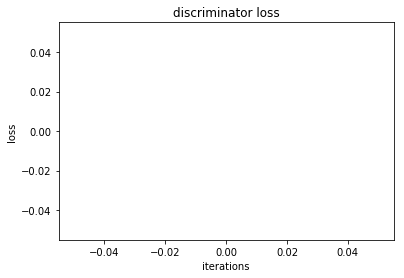

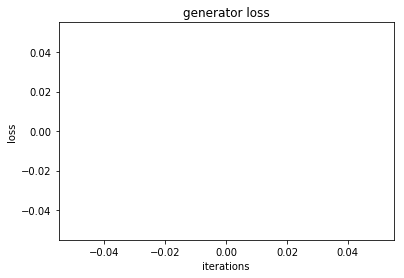

Iteration 514000/611000: dis loss = nan, gen loss = nan
Epoch 841 time is 33.29 [s]
Iteration 514500/611000: dis loss = nan, gen loss = nan
Iteration 515000/611000: dis loss = nan, gen loss = nan
Epoch 842 time is 33.36 [s]
Iteration 515500/611000: dis loss = nan, gen loss = nan
Epoch 843 time is 33.44 [s]
Iteration 516000/611000: dis loss = nan, gen loss = nan
Epoch 844 time is 33.34 [s]
Iteration 516500/611000: dis loss = nan, gen loss = nan
Epoch 845 time is 33.43 [s]


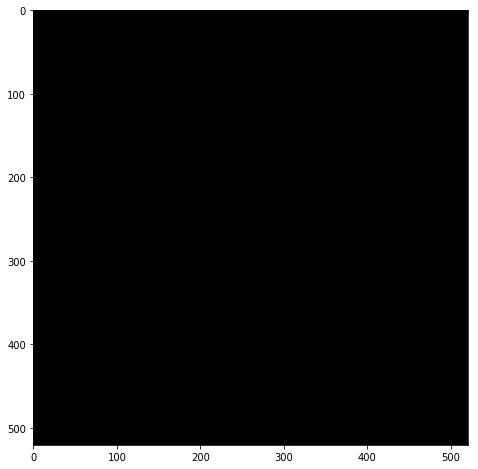

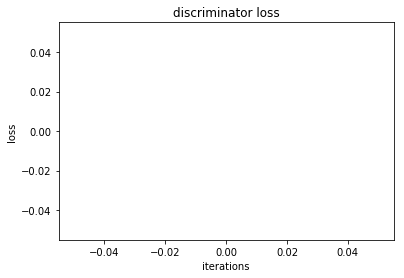

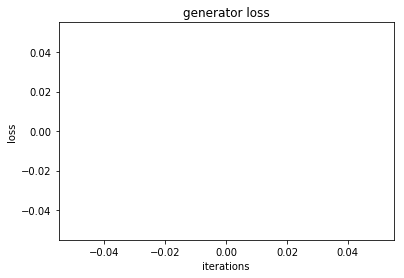

Iteration 517000/611000: dis loss = nan, gen loss = nan
Iteration 517500/611000: dis loss = nan, gen loss = nan
Epoch 846 time is 33.41 [s]
Iteration 518000/611000: dis loss = nan, gen loss = nan
Epoch 847 time is 33.58 [s]
Iteration 518500/611000: dis loss = nan, gen loss = nan
Epoch 848 time is 33.53 [s]
Iteration 519000/611000: dis loss = nan, gen loss = nan
Epoch 849 time is 33.42 [s]
Iteration 519500/611000: dis loss = nan, gen loss = nan
Epoch 850 time is 32.91 [s]


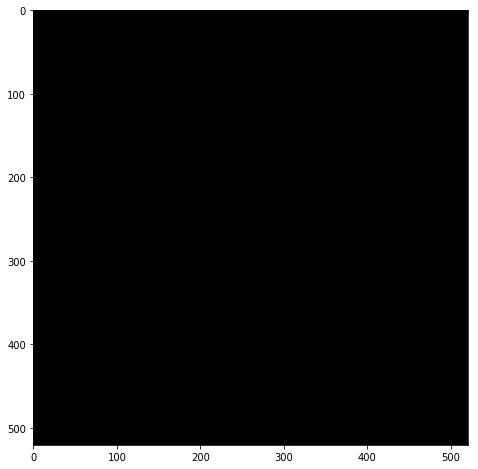

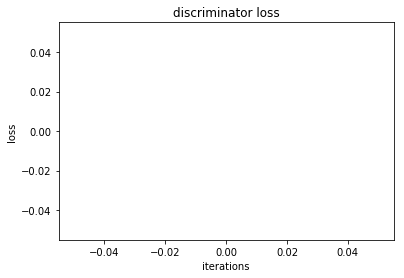

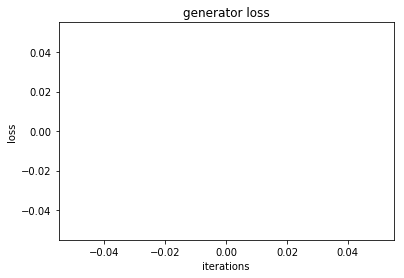

Iteration 520000/611000: dis loss = nan, gen loss = nan
Iteration 520500/611000: dis loss = nan, gen loss = nan
Epoch 851 time is 33.46 [s]
Iteration 521000/611000: dis loss = nan, gen loss = nan
Epoch 852 time is 33.46 [s]
Iteration 521500/611000: dis loss = nan, gen loss = nan
Epoch 853 time is 33.37 [s]
Iteration 522000/611000: dis loss = nan, gen loss = nan
Epoch 854 time is 33.51 [s]
Iteration 522500/611000: dis loss = nan, gen loss = nan
Iteration 523000/611000: dis loss = nan, gen loss = nan
Epoch 855 time is 33.55 [s]


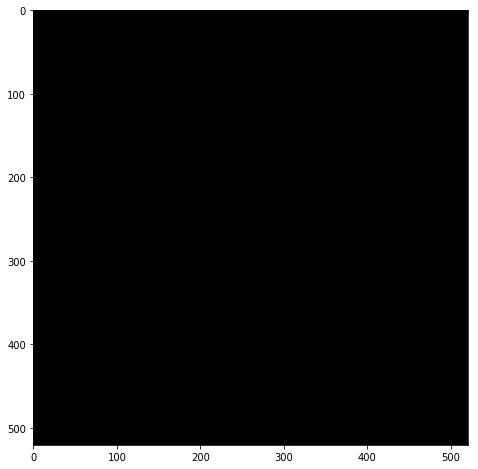

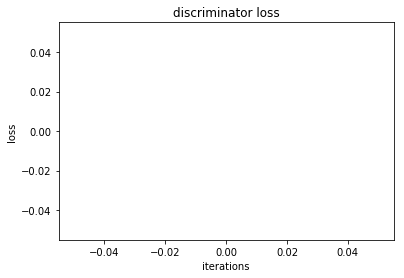

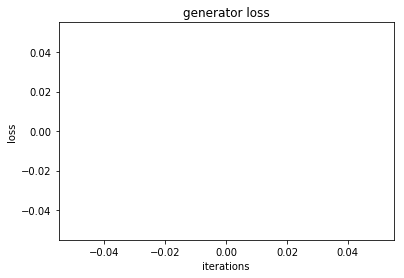

Iteration 523500/611000: dis loss = nan, gen loss = nan
Epoch 856 time is 33.30 [s]
Iteration 524000/611000: dis loss = nan, gen loss = nan
Epoch 857 time is 33.56 [s]
Iteration 524500/611000: dis loss = nan, gen loss = nan
Epoch 858 time is 33.49 [s]
Iteration 525000/611000: dis loss = nan, gen loss = nan
Epoch 859 time is 33.45 [s]
Iteration 525500/611000: dis loss = nan, gen loss = nan
Iteration 526000/611000: dis loss = nan, gen loss = nan
Epoch 860 time is 33.38 [s]


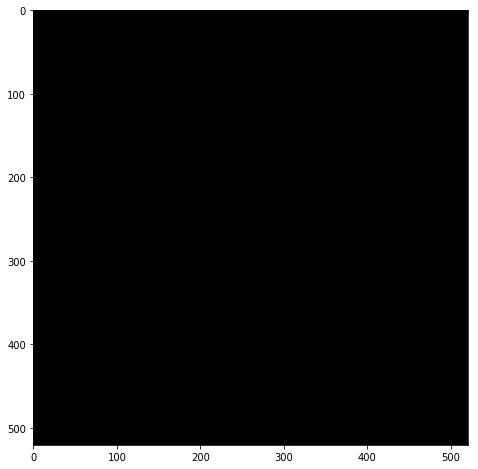

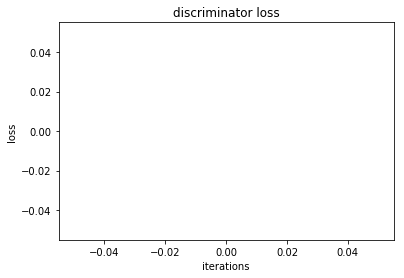

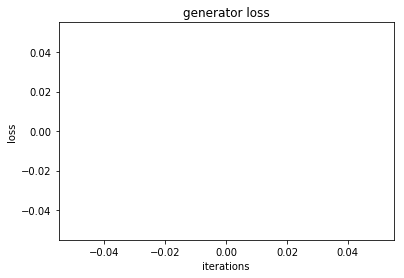

Iteration 526500/611000: dis loss = nan, gen loss = nan
Epoch 861 time is 33.42 [s]
Iteration 527000/611000: dis loss = nan, gen loss = nan
Epoch 862 time is 33.52 [s]
Iteration 527500/611000: dis loss = nan, gen loss = nan
Epoch 863 time is 33.52 [s]
Iteration 528000/611000: dis loss = nan, gen loss = nan
Iteration 528500/611000: dis loss = nan, gen loss = nan
Epoch 864 time is 33.41 [s]
Iteration 529000/611000: dis loss = nan, gen loss = nan
Epoch 865 time is 33.53 [s]


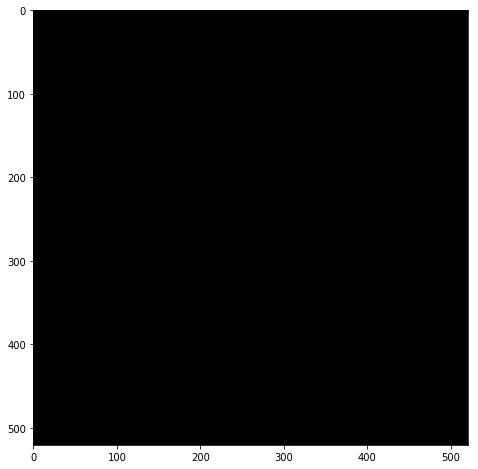

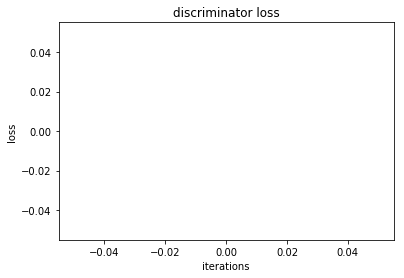

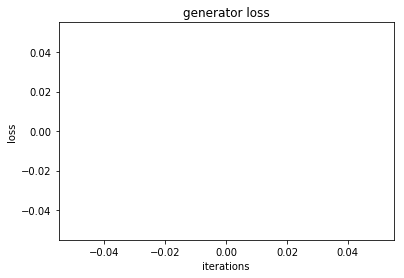

Iteration 529500/611000: dis loss = nan, gen loss = nan
Epoch 866 time is 33.48 [s]
Iteration 530000/611000: dis loss = nan, gen loss = nan
Epoch 867 time is 33.30 [s]
Iteration 530500/611000: dis loss = nan, gen loss = nan
Epoch 868 time is 33.36 [s]
Iteration 531000/611000: dis loss = nan, gen loss = nan
Iteration 531500/611000: dis loss = nan, gen loss = nan
Epoch 869 time is 33.28 [s]
Iteration 532000/611000: dis loss = nan, gen loss = nan
Epoch 870 time is 33.38 [s]


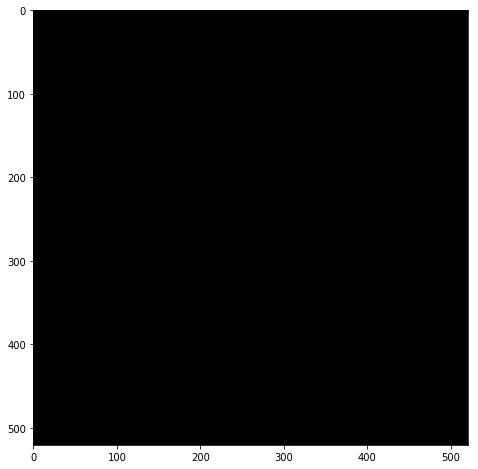

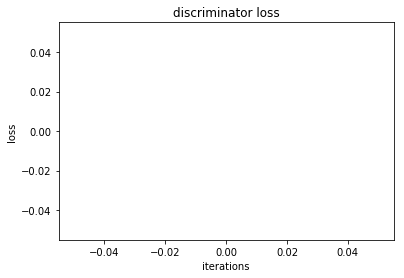

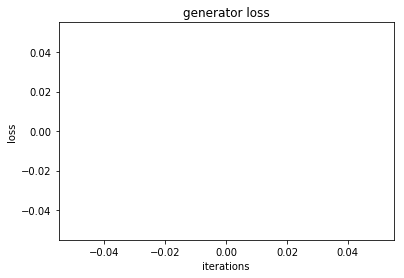

Iteration 532500/611000: dis loss = nan, gen loss = nan
Epoch 871 time is 33.37 [s]
Iteration 533000/611000: dis loss = nan, gen loss = nan
Epoch 872 time is 33.56 [s]
Iteration 533500/611000: dis loss = nan, gen loss = nan
Iteration 534000/611000: dis loss = nan, gen loss = nan
Epoch 873 time is 33.48 [s]
Iteration 534500/611000: dis loss = nan, gen loss = nan
Epoch 874 time is 33.55 [s]
Iteration 535000/611000: dis loss = nan, gen loss = nan
Epoch 875 time is 33.53 [s]


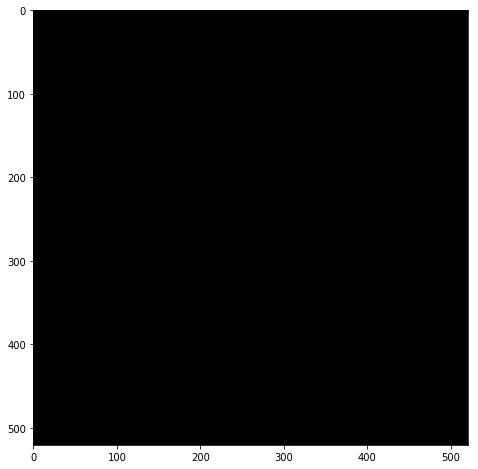

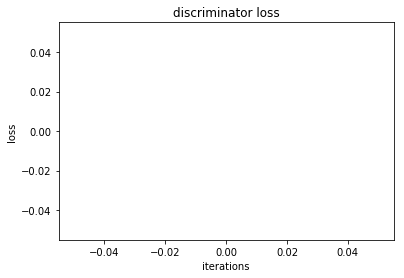

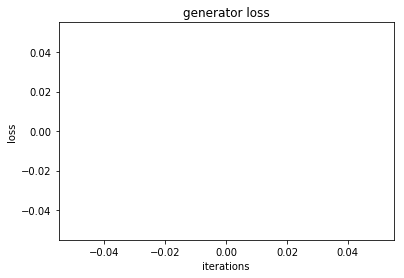

Iteration 535500/611000: dis loss = nan, gen loss = nan
Epoch 876 time is 33.47 [s]
Iteration 536000/611000: dis loss = nan, gen loss = nan
Epoch 877 time is 33.49 [s]
Iteration 536500/611000: dis loss = nan, gen loss = nan
Iteration 537000/611000: dis loss = nan, gen loss = nan
Epoch 878 time is 33.50 [s]
Iteration 537500/611000: dis loss = nan, gen loss = nan
Epoch 879 time is 33.50 [s]
Iteration 538000/611000: dis loss = nan, gen loss = nan
Epoch 880 time is 33.49 [s]


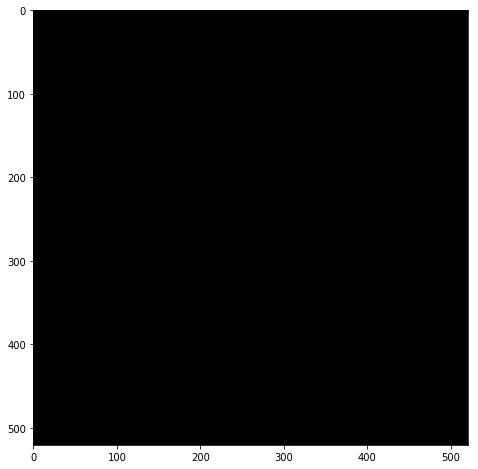

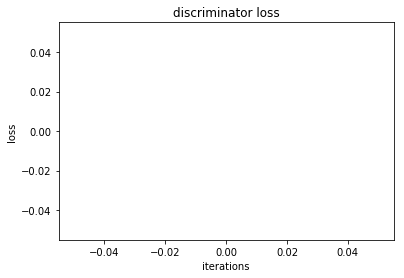

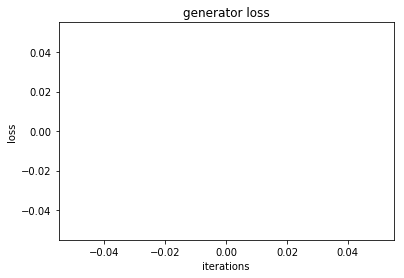

Iteration 538500/611000: dis loss = nan, gen loss = nan
Epoch 881 time is 33.48 [s]
Iteration 539000/611000: dis loss = nan, gen loss = nan
Iteration 539500/611000: dis loss = nan, gen loss = nan
Epoch 882 time is 33.42 [s]
Iteration 540000/611000: dis loss = nan, gen loss = nan
Epoch 883 time is 33.41 [s]
Iteration 540500/611000: dis loss = nan, gen loss = nan
Epoch 884 time is 33.56 [s]
Iteration 541000/611000: dis loss = nan, gen loss = nan
Epoch 885 time is 33.48 [s]


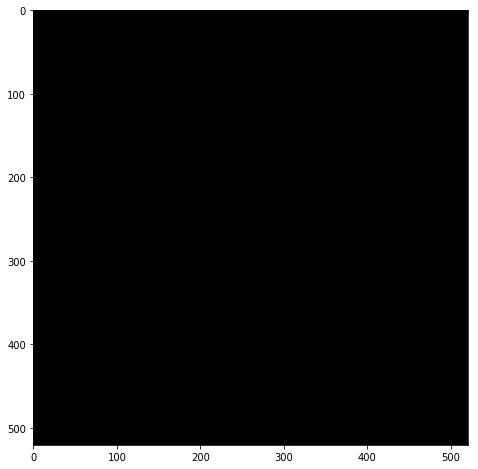

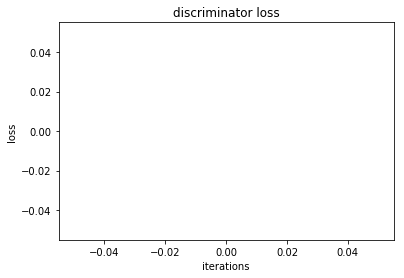

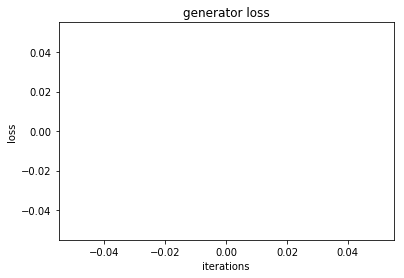

Iteration 541500/611000: dis loss = nan, gen loss = nan
Epoch 886 time is 33.42 [s]
Iteration 542000/611000: dis loss = nan, gen loss = nan
Iteration 542500/611000: dis loss = nan, gen loss = nan
Epoch 887 time is 33.37 [s]
Iteration 543000/611000: dis loss = nan, gen loss = nan
Epoch 888 time is 33.59 [s]
Iteration 543500/611000: dis loss = nan, gen loss = nan
Epoch 889 time is 33.53 [s]
Iteration 544000/611000: dis loss = nan, gen loss = nan
Epoch 890 time is 33.51 [s]


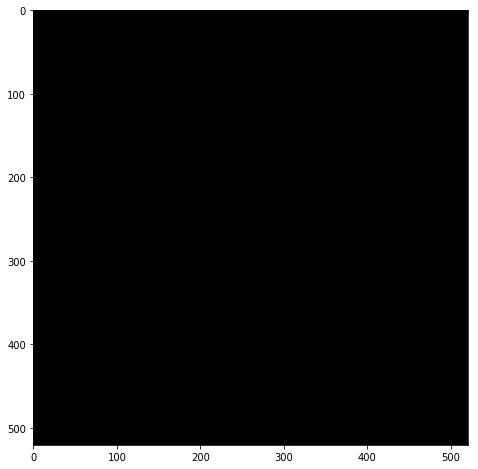

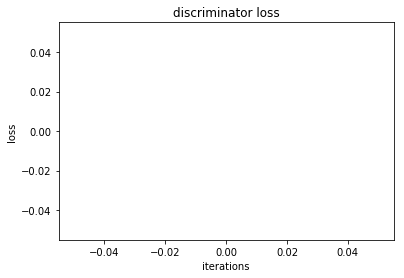

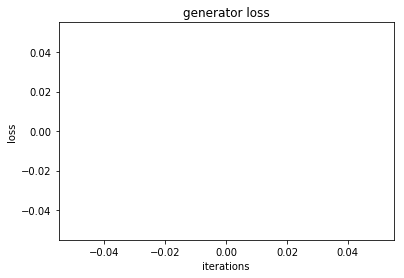

Iteration 544500/611000: dis loss = nan, gen loss = nan
Iteration 545000/611000: dis loss = nan, gen loss = nan
Epoch 891 time is 33.58 [s]
Iteration 545500/611000: dis loss = nan, gen loss = nan
Epoch 892 time is 33.54 [s]
Iteration 546000/611000: dis loss = nan, gen loss = nan
Epoch 893 time is 33.38 [s]
Iteration 546500/611000: dis loss = nan, gen loss = nan
Epoch 894 time is 33.55 [s]
Iteration 547000/611000: dis loss = nan, gen loss = nan
Epoch 895 time is 33.43 [s]


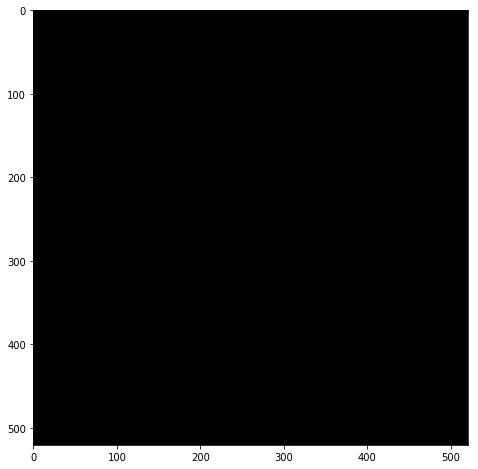

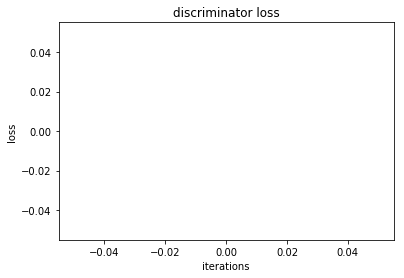

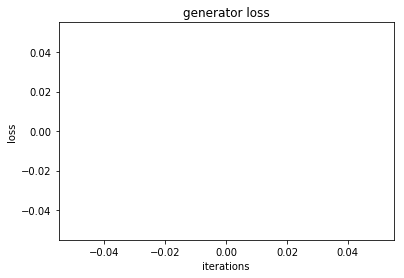

Iteration 547500/611000: dis loss = nan, gen loss = nan
Iteration 548000/611000: dis loss = nan, gen loss = nan
Epoch 896 time is 33.39 [s]
Iteration 548500/611000: dis loss = nan, gen loss = nan
Epoch 897 time is 33.53 [s]
Iteration 549000/611000: dis loss = nan, gen loss = nan
Epoch 898 time is 33.56 [s]
Iteration 549500/611000: dis loss = nan, gen loss = nan
Epoch 899 time is 33.49 [s]
Iteration 550000/611000: dis loss = nan, gen loss = nan
Iteration 550500/611000: dis loss = nan, gen loss = nan
Epoch 900 time is 33.36 [s]


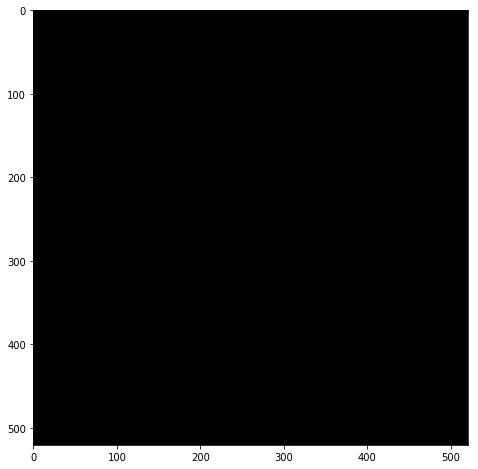

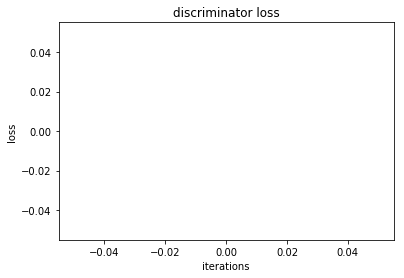

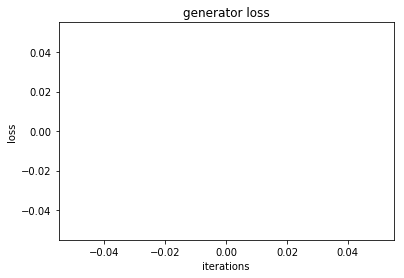

Iteration 551000/611000: dis loss = nan, gen loss = nan
Epoch 901 time is 33.55 [s]
Iteration 551500/611000: dis loss = nan, gen loss = nan
Epoch 902 time is 33.43 [s]
Iteration 552000/611000: dis loss = nan, gen loss = nan
Epoch 903 time is 33.46 [s]
Iteration 552500/611000: dis loss = nan, gen loss = nan
Epoch 904 time is 33.62 [s]
Iteration 553000/611000: dis loss = nan, gen loss = nan
Iteration 553500/611000: dis loss = nan, gen loss = nan
Epoch 905 time is 33.34 [s]


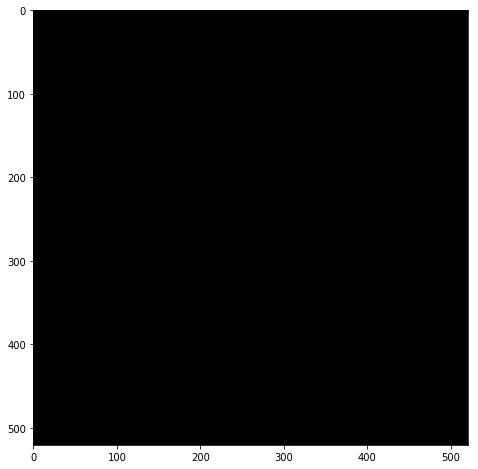

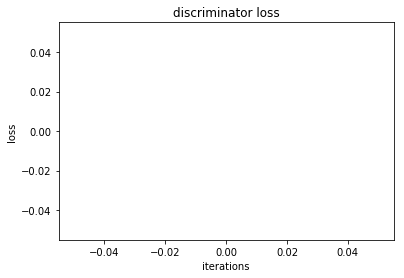

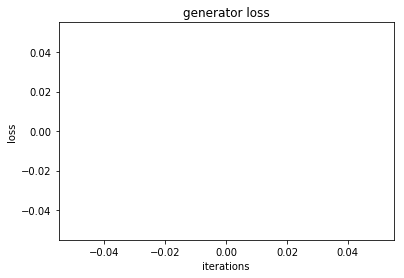

Iteration 554000/611000: dis loss = nan, gen loss = nan
Epoch 906 time is 33.28 [s]
Iteration 554500/611000: dis loss = nan, gen loss = nan
Epoch 907 time is 33.29 [s]
Iteration 555000/611000: dis loss = nan, gen loss = nan
Epoch 908 time is 33.26 [s]
Iteration 555500/611000: dis loss = nan, gen loss = nan
Iteration 556000/611000: dis loss = nan, gen loss = nan
Epoch 909 time is 33.34 [s]
Iteration 556500/611000: dis loss = nan, gen loss = nan
Epoch 910 time is 33.34 [s]


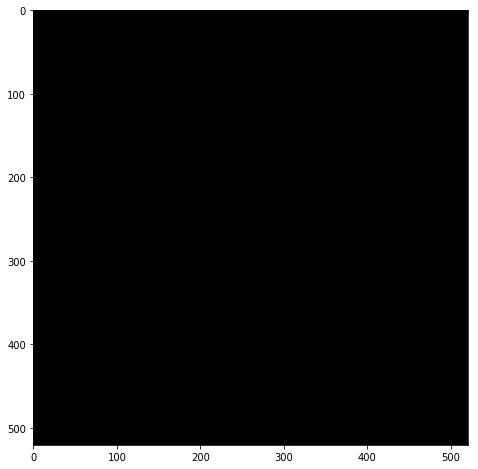

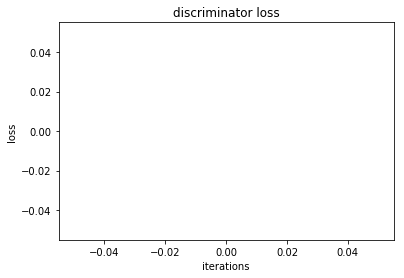

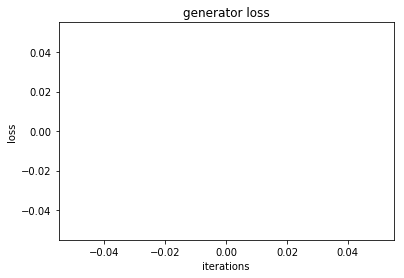

Iteration 557000/611000: dis loss = nan, gen loss = nan
Epoch 911 time is 33.37 [s]
Iteration 557500/611000: dis loss = nan, gen loss = nan
Epoch 912 time is 33.41 [s]
Iteration 558000/611000: dis loss = nan, gen loss = nan
Epoch 913 time is 33.50 [s]
Iteration 558500/611000: dis loss = nan, gen loss = nan
Iteration 559000/611000: dis loss = nan, gen loss = nan
Epoch 914 time is 33.53 [s]
Iteration 559500/611000: dis loss = nan, gen loss = nan
Epoch 915 time is 33.62 [s]


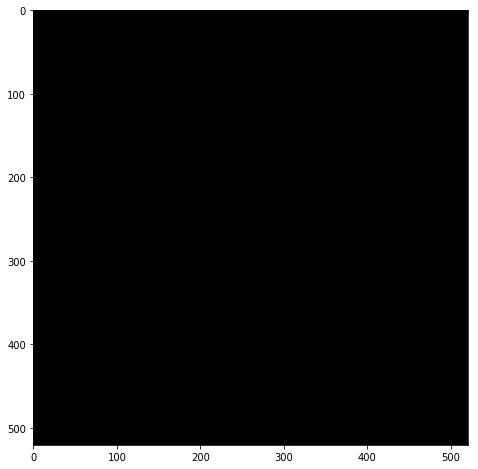

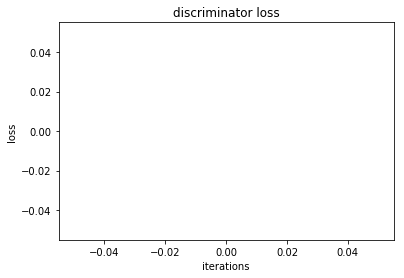

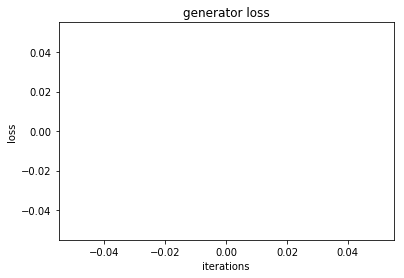

Iteration 560000/611000: dis loss = nan, gen loss = nan
Epoch 916 time is 33.46 [s]
Iteration 560500/611000: dis loss = nan, gen loss = nan
Epoch 917 time is 33.39 [s]
Iteration 561000/611000: dis loss = nan, gen loss = nan
Iteration 561500/611000: dis loss = nan, gen loss = nan
Epoch 918 time is 33.54 [s]
Iteration 562000/611000: dis loss = nan, gen loss = nan
Epoch 919 time is 33.56 [s]
Iteration 562500/611000: dis loss = nan, gen loss = nan
Epoch 920 time is 33.47 [s]


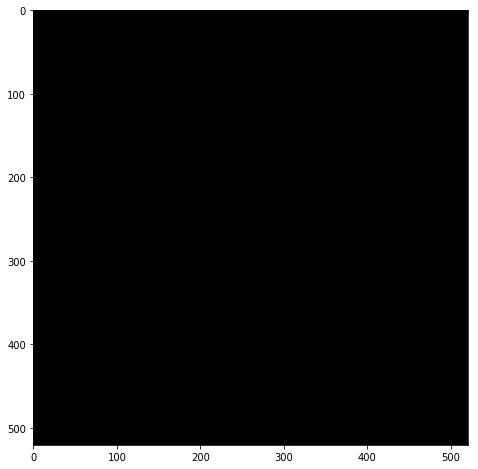

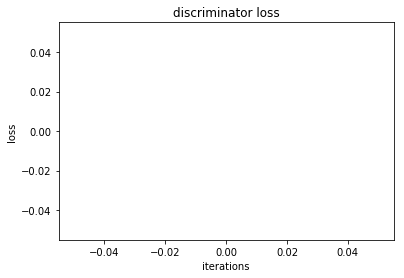

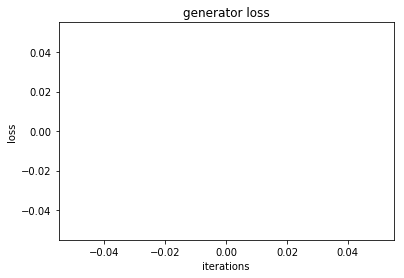

Iteration 563000/611000: dis loss = nan, gen loss = nan
Epoch 921 time is 33.52 [s]
Iteration 563500/611000: dis loss = nan, gen loss = nan
Epoch 922 time is 33.53 [s]
Iteration 564000/611000: dis loss = nan, gen loss = nan
Iteration 564500/611000: dis loss = nan, gen loss = nan
Epoch 923 time is 33.55 [s]
Iteration 565000/611000: dis loss = nan, gen loss = nan
Epoch 924 time is 33.55 [s]
Iteration 565500/611000: dis loss = nan, gen loss = nan
Epoch 925 time is 33.48 [s]


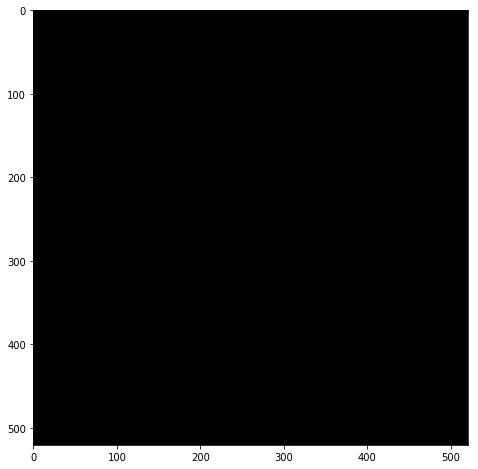

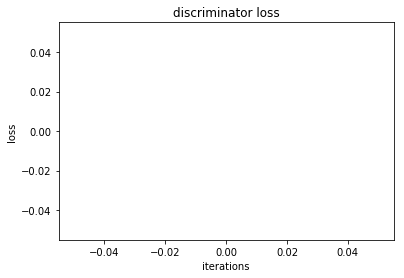

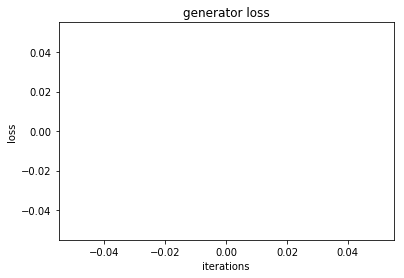

Iteration 566000/611000: dis loss = nan, gen loss = nan
Epoch 926 time is 33.58 [s]
Iteration 566500/611000: dis loss = nan, gen loss = nan
Iteration 567000/611000: dis loss = nan, gen loss = nan
Epoch 927 time is 33.38 [s]
Iteration 567500/611000: dis loss = nan, gen loss = nan
Epoch 928 time is 33.45 [s]
Iteration 568000/611000: dis loss = nan, gen loss = nan
Epoch 929 time is 33.57 [s]
Iteration 568500/611000: dis loss = nan, gen loss = nan
Epoch 930 time is 33.49 [s]


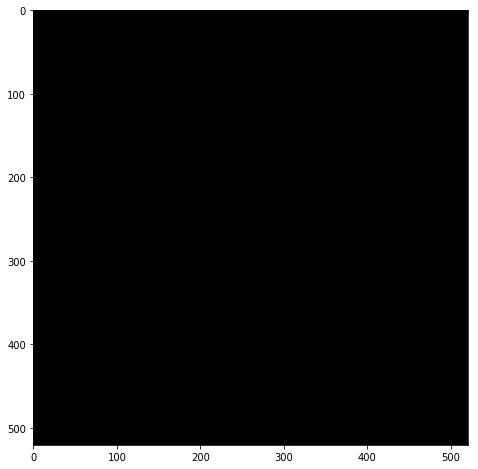

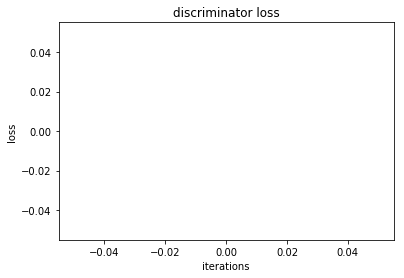

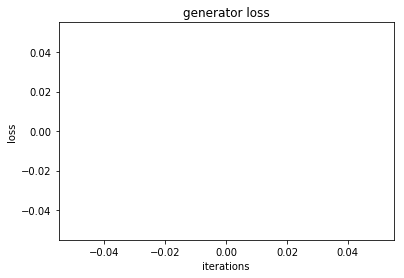

Iteration 569000/611000: dis loss = nan, gen loss = nan
Epoch 931 time is 33.71 [s]
Iteration 569500/611000: dis loss = nan, gen loss = nan
Iteration 570000/611000: dis loss = nan, gen loss = nan
Epoch 932 time is 33.54 [s]
Iteration 570500/611000: dis loss = nan, gen loss = nan
Epoch 933 time is 33.49 [s]
Iteration 571000/611000: dis loss = nan, gen loss = nan
Epoch 934 time is 33.45 [s]
Iteration 571500/611000: dis loss = nan, gen loss = nan
Epoch 935 time is 33.56 [s]


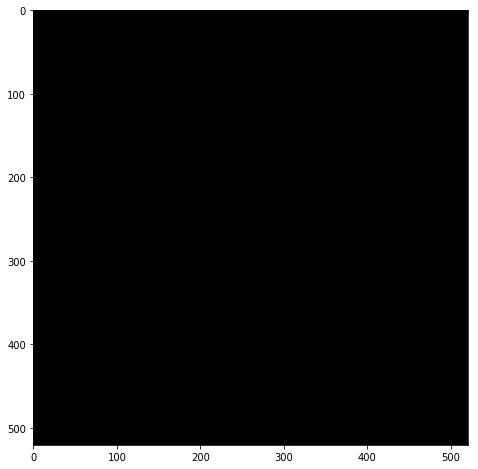

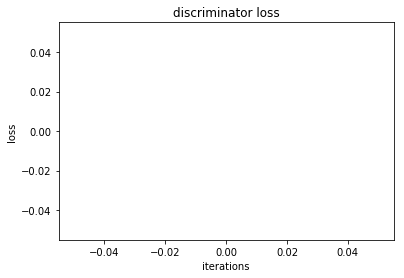

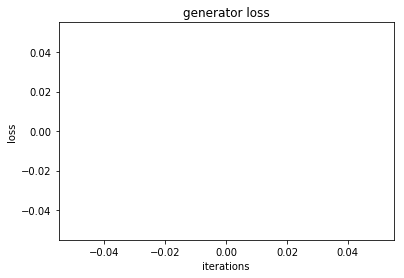

Iteration 572000/611000: dis loss = nan, gen loss = nan
Iteration 572500/611000: dis loss = nan, gen loss = nan
Epoch 936 time is 33.33 [s]
Iteration 573000/611000: dis loss = nan, gen loss = nan
Epoch 937 time is 33.28 [s]
Iteration 573500/611000: dis loss = nan, gen loss = nan
Epoch 938 time is 33.36 [s]
Iteration 574000/611000: dis loss = nan, gen loss = nan
Epoch 939 time is 33.23 [s]
Iteration 574500/611000: dis loss = nan, gen loss = nan
Epoch 940 time is 33.39 [s]


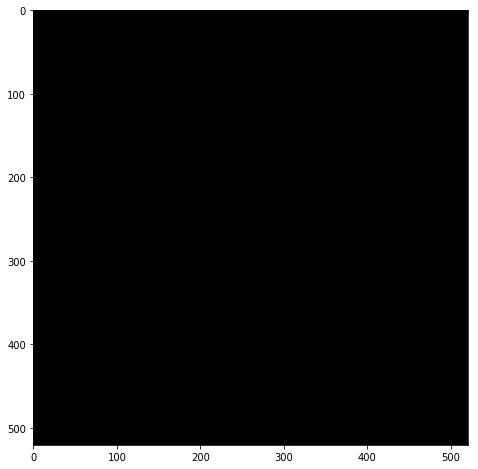

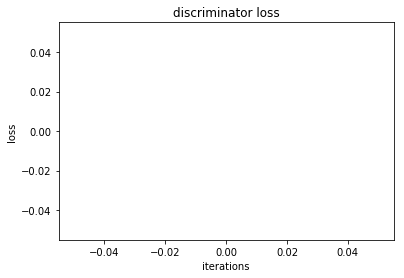

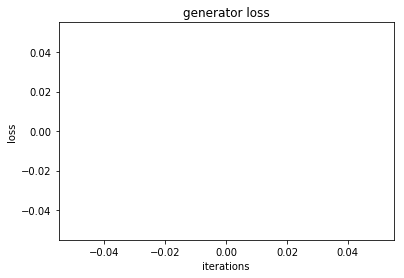

Iteration 575000/611000: dis loss = nan, gen loss = nan
Iteration 575500/611000: dis loss = nan, gen loss = nan
Epoch 941 time is 33.58 [s]
Iteration 576000/611000: dis loss = nan, gen loss = nan
Epoch 942 time is 33.48 [s]
Iteration 576500/611000: dis loss = nan, gen loss = nan
Epoch 943 time is 33.64 [s]
Iteration 577000/611000: dis loss = nan, gen loss = nan
Epoch 944 time is 33.41 [s]
Iteration 577500/611000: dis loss = nan, gen loss = nan
Iteration 578000/611000: dis loss = nan, gen loss = nan
Epoch 945 time is 33.43 [s]


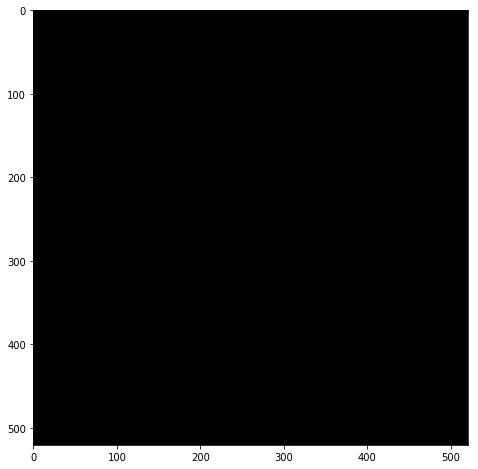

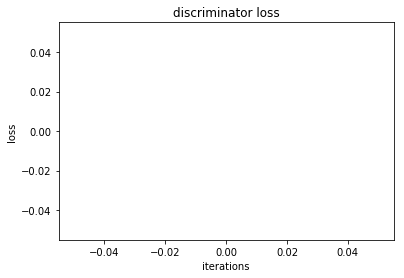

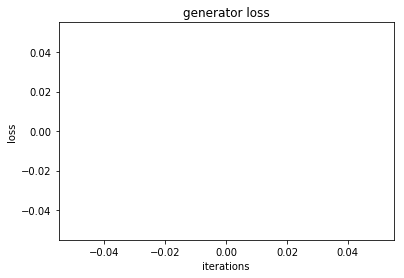

Iteration 578500/611000: dis loss = nan, gen loss = nan
Epoch 946 time is 33.55 [s]
Iteration 579000/611000: dis loss = nan, gen loss = nan
Epoch 947 time is 33.50 [s]
Iteration 579500/611000: dis loss = nan, gen loss = nan
Epoch 948 time is 33.43 [s]
Iteration 580000/611000: dis loss = nan, gen loss = nan
Epoch 949 time is 33.41 [s]
Iteration 580500/611000: dis loss = nan, gen loss = nan
Iteration 581000/611000: dis loss = nan, gen loss = nan
Epoch 950 time is 33.46 [s]


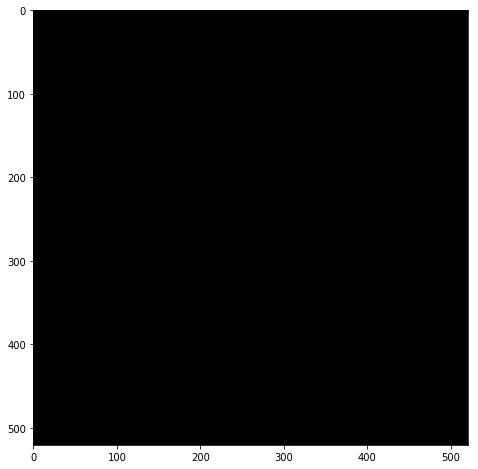

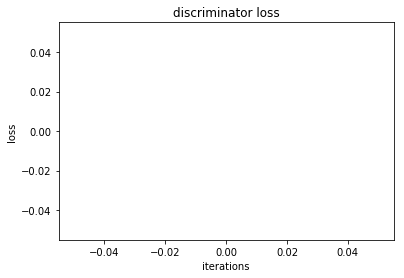

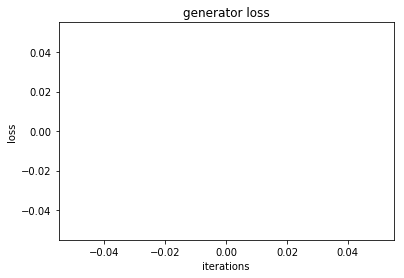

Iteration 581500/611000: dis loss = nan, gen loss = nan
Epoch 951 time is 33.36 [s]
Iteration 582000/611000: dis loss = nan, gen loss = nan
Epoch 952 time is 33.51 [s]
Iteration 582500/611000: dis loss = nan, gen loss = nan
Epoch 953 time is 33.57 [s]
Iteration 583000/611000: dis loss = nan, gen loss = nan
Iteration 583500/611000: dis loss = nan, gen loss = nan
Epoch 954 time is 33.57 [s]
Iteration 584000/611000: dis loss = nan, gen loss = nan
Epoch 955 time is 33.51 [s]


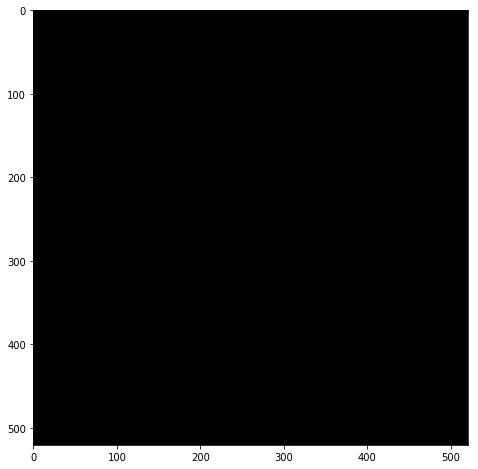

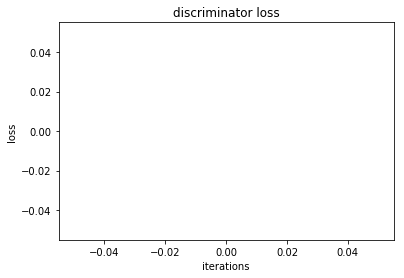

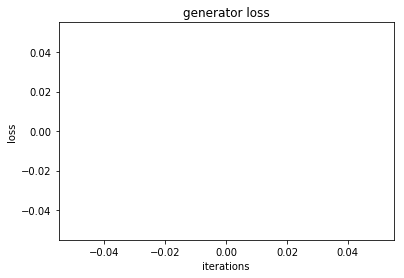

Iteration 584500/611000: dis loss = nan, gen loss = nan
Epoch 956 time is 33.50 [s]
Iteration 585000/611000: dis loss = nan, gen loss = nan
Epoch 957 time is 33.39 [s]
Iteration 585500/611000: dis loss = nan, gen loss = nan
Epoch 958 time is 33.48 [s]
Iteration 586000/611000: dis loss = nan, gen loss = nan
Iteration 586500/611000: dis loss = nan, gen loss = nan
Epoch 959 time is 33.48 [s]
Iteration 587000/611000: dis loss = nan, gen loss = nan
Epoch 960 time is 33.51 [s]


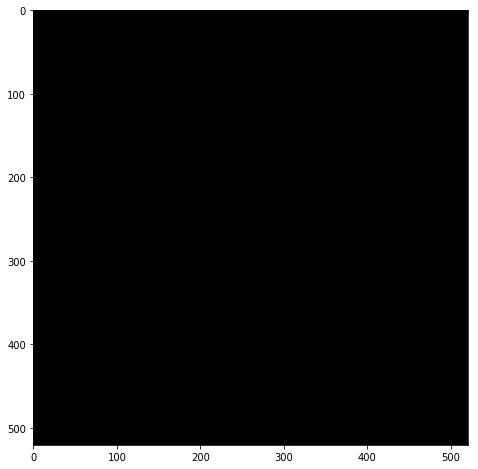

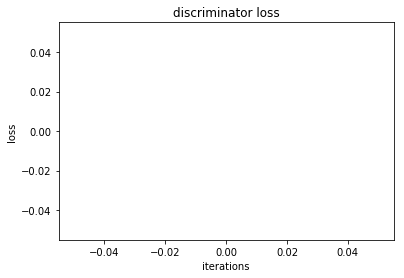

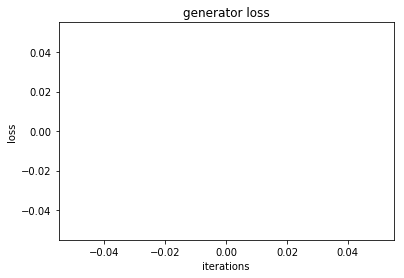

Iteration 587500/611000: dis loss = nan, gen loss = nan
Epoch 961 time is 33.48 [s]
Iteration 588000/611000: dis loss = nan, gen loss = nan
Epoch 962 time is 33.38 [s]
Iteration 588500/611000: dis loss = nan, gen loss = nan
Iteration 589000/611000: dis loss = nan, gen loss = nan
Epoch 963 time is 33.55 [s]
Iteration 589500/611000: dis loss = nan, gen loss = nan
Epoch 964 time is 33.37 [s]
Iteration 590000/611000: dis loss = nan, gen loss = nan
Epoch 965 time is 33.48 [s]


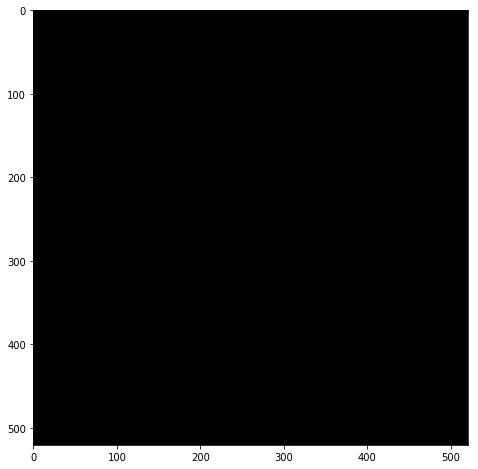

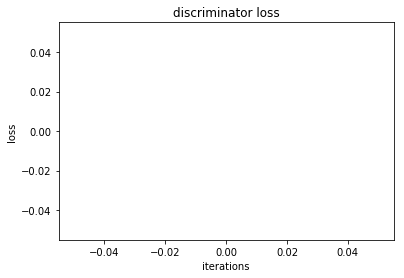

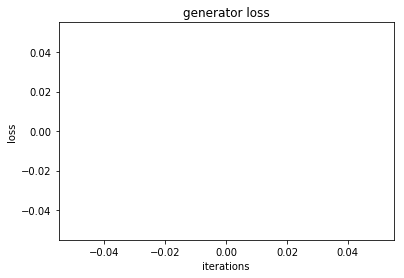

Iteration 590500/611000: dis loss = nan, gen loss = nan
Epoch 966 time is 33.41 [s]
Iteration 591000/611000: dis loss = nan, gen loss = nan
Epoch 967 time is 33.46 [s]
Iteration 591500/611000: dis loss = nan, gen loss = nan
Iteration 592000/611000: dis loss = nan, gen loss = nan
Epoch 968 time is 33.49 [s]
Iteration 592500/611000: dis loss = nan, gen loss = nan
Epoch 969 time is 33.57 [s]
Iteration 593000/611000: dis loss = nan, gen loss = nan
Epoch 970 time is 33.53 [s]


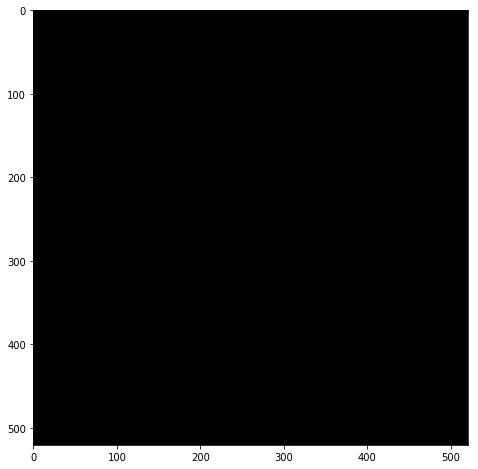

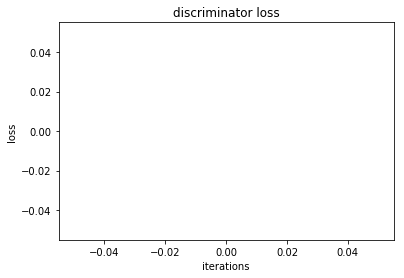

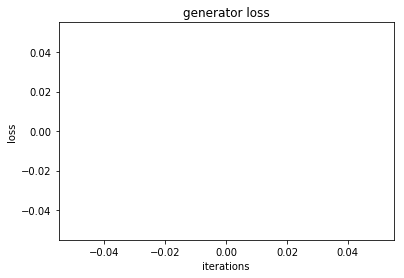

Iteration 593500/611000: dis loss = nan, gen loss = nan
Epoch 971 time is 33.45 [s]
Iteration 594000/611000: dis loss = nan, gen loss = nan
Iteration 594500/611000: dis loss = nan, gen loss = nan
Epoch 972 time is 33.55 [s]
Iteration 595000/611000: dis loss = nan, gen loss = nan
Epoch 973 time is 33.47 [s]
Iteration 595500/611000: dis loss = nan, gen loss = nan
Epoch 974 time is 33.52 [s]
Iteration 596000/611000: dis loss = nan, gen loss = nan
Epoch 975 time is 33.44 [s]


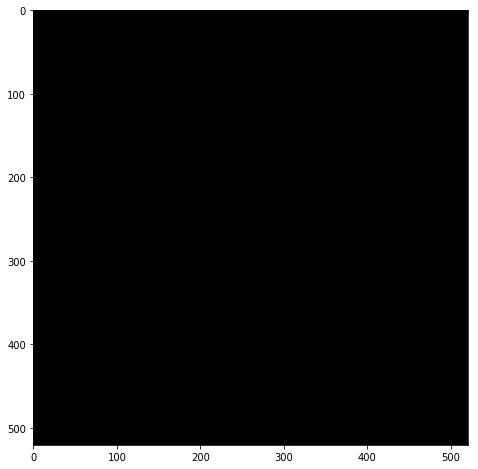

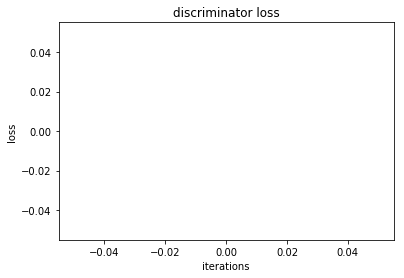

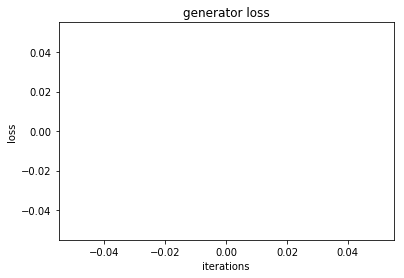

Iteration 596500/611000: dis loss = nan, gen loss = nan
Epoch 976 time is 33.31 [s]
Iteration 597000/611000: dis loss = nan, gen loss = nan
Iteration 597500/611000: dis loss = nan, gen loss = nan
Epoch 977 time is 33.14 [s]
Iteration 598000/611000: dis loss = nan, gen loss = nan
Epoch 978 time is 33.19 [s]
Iteration 598500/611000: dis loss = nan, gen loss = nan
Epoch 979 time is 33.31 [s]
Iteration 599000/611000: dis loss = nan, gen loss = nan
Epoch 980 time is 33.45 [s]


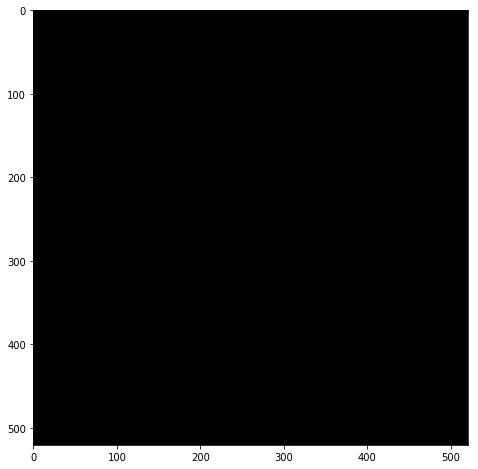

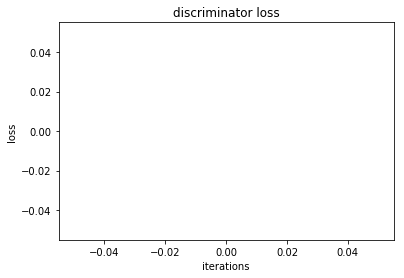

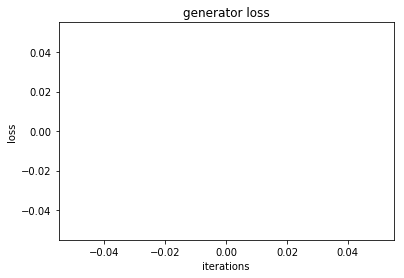

Iteration 599500/611000: dis loss = nan, gen loss = nan
Iteration 600000/611000: dis loss = nan, gen loss = nan
Epoch 981 time is 33.51 [s]
Iteration 600500/611000: dis loss = nan, gen loss = nan
Epoch 982 time is 33.53 [s]
Iteration 601000/611000: dis loss = nan, gen loss = nan
Epoch 983 time is 33.45 [s]
Iteration 601500/611000: dis loss = nan, gen loss = nan
Epoch 984 time is 33.30 [s]
Iteration 602000/611000: dis loss = nan, gen loss = nan
Epoch 985 time is 33.47 [s]


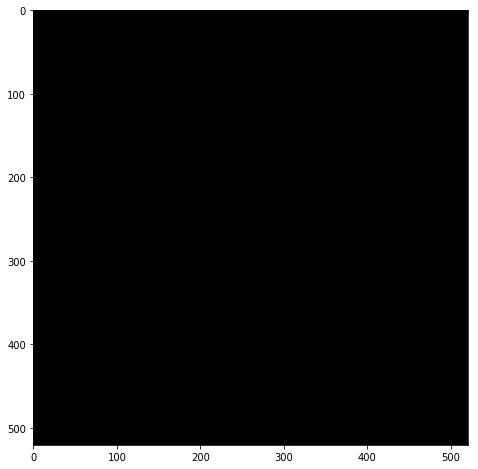

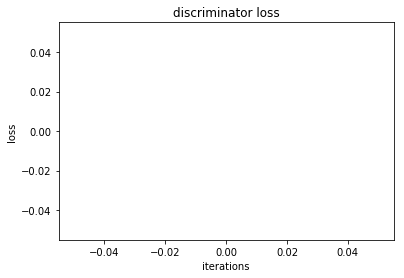

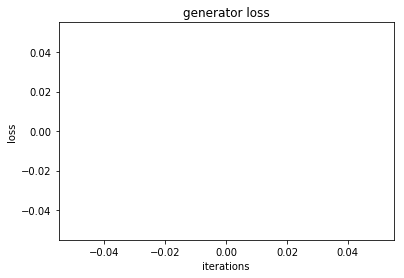

Iteration 602500/611000: dis loss = nan, gen loss = nan
Iteration 603000/611000: dis loss = nan, gen loss = nan
Epoch 986 time is 33.38 [s]
Iteration 603500/611000: dis loss = nan, gen loss = nan
Epoch 987 time is 33.47 [s]
Iteration 604000/611000: dis loss = nan, gen loss = nan
Epoch 988 time is 33.44 [s]
Iteration 604500/611000: dis loss = nan, gen loss = nan
Epoch 989 time is 33.41 [s]
Iteration 605000/611000: dis loss = nan, gen loss = nan
Iteration 605500/611000: dis loss = nan, gen loss = nan
Epoch 990 time is 33.50 [s]


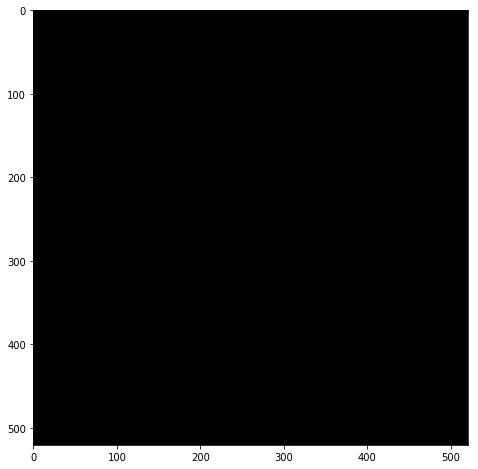

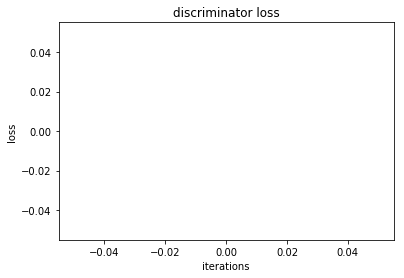

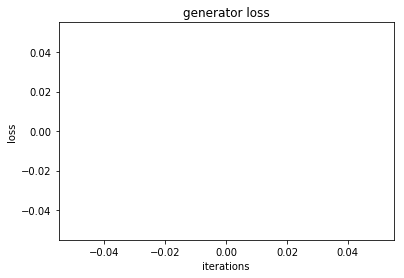

Iteration 606000/611000: dis loss = nan, gen loss = nan
Epoch 991 time is 33.50 [s]
Iteration 606500/611000: dis loss = nan, gen loss = nan
Epoch 992 time is 33.44 [s]
Iteration 607000/611000: dis loss = nan, gen loss = nan
Epoch 993 time is 33.53 [s]
Iteration 607500/611000: dis loss = nan, gen loss = nan
Epoch 994 time is 33.60 [s]
Iteration 608000/611000: dis loss = nan, gen loss = nan
Iteration 608500/611000: dis loss = nan, gen loss = nan
Epoch 995 time is 33.44 [s]


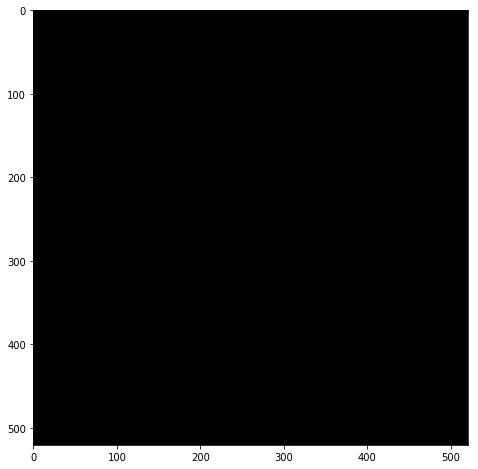

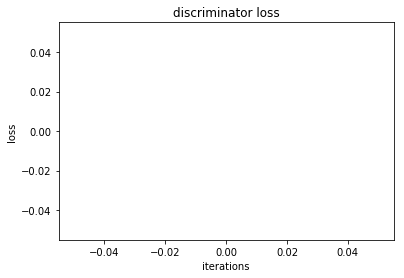

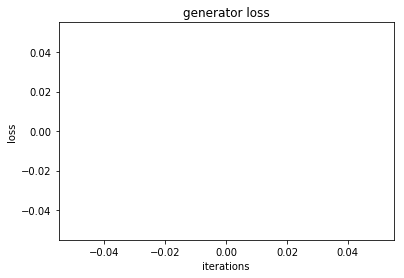

Iteration 609000/611000: dis loss = nan, gen loss = nan
Epoch 996 time is 33.42 [s]
Iteration 609500/611000: dis loss = nan, gen loss = nan
Epoch 997 time is 33.55 [s]
Iteration 610000/611000: dis loss = nan, gen loss = nan
Epoch 998 time is 33.53 [s]
Iteration 610500/611000: dis loss = nan, gen loss = nan
Iteration 611000/611000: dis loss = nan, gen loss = nan
Epoch 999 time is 33.44 [s]
... Done!
total time is 33518.75 [s]


In [23]:
tf.reset_default_graph()


mdel_path = 'model/dcgan_alubm_gpu-vae.ckpt'

with tf.Session(config=tf.ConfigProto(
        allow_soft_placement=True,log_device_placement=True)) as sess:
    #with tf.device('/cpu:0'):
    with tf.device('/gpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        
        # restore
        isrestore = False
        metapath = mdel_path +'.meta'
        if os.path.isfile(metapath):
            dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
            gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
            saver = tf.train.Saver(dis_var_list + gen_var_list)
            saver.restore(sess, mdel_path)
            #print('restore')
            isrestore = True
        
        # train
        dcgan.train(sess, train_samples, train_labels)
        
        #save
        if not isrestore:
            dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
            gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
            saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.save(sess, mdel_path)